In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from medpy.metric import dc, assd
import torch.nn.functional as F
import torchio as tio

import nibabel as nib



In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torch.nn.functional as F

class BrainSegmentationDataset(Dataset):
    def __init__(self, t1c_dir, t2f_dir, seg_dir, transforms=None):
        self.t1c_dir = t1c_dir
        self.t2f_dir = t2f_dir
        self.seg_dir = seg_dir
        self.transforms = transforms

        # Create a list of all seg images (patient + slice)
        self.seg_files = [os.path.join(root, file) for root, _, files in os.walk(seg_dir) 
                          for file in files if os.path.getsize(os.path.join(root, file)) > 136]

    def __len__(self):
        return len(self.seg_files)

    def __getitem__(self, idx):
        seg_img_path = self.seg_files[idx]
        
        mask = Image.open(seg_img_path).convert('L')
        
        mask = np.array(mask, dtype = np.int64)
        
        background_mask = (mask == 0).astype(np.float32)
        class1_mask = (mask == 85).astype(np.float32)
        class2_mask = (mask == 170).astype(np.float32)
        class3_mask = (mask == 255).astype(np.float32)
        
        mask = np.dstack([background_mask, class1_mask, class2_mask, class3_mask])
        mask = np.argmax(mask, axis = 2)
        
        # Corresponding input images
        t1c_img_path = seg_img_path.replace('seg', 't1c')
        t1c_img = Image.open(t1c_img_path).convert('L')  # load and convert t1c image
        t1c_tensor = torch.from_numpy(np.array(t1c_img,dtype = np.float32)[None, ...])/255.0
#         t1c_tensor = self.transforms(t1c_img)  # transform to tensor

        t2f_img_path = seg_img_path.replace('seg', 't2f')
        t2f_img = Image.open(t2f_img_path)  # load and convert t2f image
        t2f_tensor = torch.from_numpy(np.array(t2f_img,dtype = np.float32)[None, ...])/255.0
#         t2f_tensor = self.transforms(t2f_img)  # transform to tensor

        # Stack t1c and t2f tensors along the channel dimension
        inputs = torch.cat((t1c_tensor, t2f_tensor), dim=0)

        return inputs, mask

In [3]:
from torchvision import transforms

data_transforms = transforms.Compose([
     # You can modify this as per your model's input size
    transforms.ToTensor(),
])

dataset = BrainSegmentationDataset(t1c_dir="PED_Sliced/axial/t1c", t2f_dir="PED_Sliced/axial/t2f", seg_dir="PED_Sliced/axial/seg", transforms=data_transforms)

In [4]:
from torch.utils.data import DataLoader, random_split

# Split dataset into training set and validation set
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create a DataLoader for both sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [5]:
print(len(train_dataset))
print(len(train_loader))
data, labels = next(iter(train_loader))
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
data, labels = next(iter(val_loader))

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)



4324
136
Data shape: torch.Size([32, 2, 240, 240])
Labels shape: torch.Size([32, 240, 240])
Data shape: torch.Size([32, 2, 240, 240])
Labels shape: torch.Size([32, 240, 240])


In [6]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.psi(F.relu(g1 + x1, inplace=True))
        return x * psi


class AttnUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(AttnUNet, self).__init__()

        # Downsample path
        self.conv1 = self.double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        # Bottom
        self.conv5 = self.double_conv(512, 1024)

        # Attention blocks
        self.attention_block1 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.attention_block2 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.attention_block3 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.attention_block4 = AttentionBlock(F_g=64, F_l=64, F_int=32)

        # Upsample path
        self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.conv6 = self.double_conv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.conv7 = self.double_conv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.conv8 = self.double_conv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv9 = self.double_conv(128, 64)

        # Output
        self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
            nn.ReLU(inplace = True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Downsample path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        # Bottom
        c5 = self.conv5(p4)

        # Upsample path
        up6 = self.up6(c5)
        attention_map1 = self.attention_block1(up6, c4)
        merge6 = torch.cat([up6, attention_map1], dim = 1)
        c6 = self.conv6(merge6)

        up7 = self.up7(c6)
        attention_map2 = self.attention_block2(up7, c3)
        merge7 = torch.cat([up7, attention_map2], dim = 1)
        c7 = self.conv7(merge7)

        up8 = self.up8(c7)
        attention_map3 = self.attention_block3(up8, c2)
        merge8 = torch.cat([up8, attention_map3], dim = 1)
        c8 = self.conv8(merge8)

        up9 = self.up9(c8)
        attention_map4 = self.attention_block4(up9, c1)
        merge9 = torch.cat([up9, attention_map4], dim = 1)
        c9 = self.conv9(merge9)

        # Output
        out = self.conv10(c9)
        return out

    def predict(self, x):
        out = self.forward(x)
        _, preds = torch.max(out, 1)
        return preds

In [7]:
# class UNet(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(UNet, self).__init__()

#         # Downsample path
#         self.conv1 = self.double_conv(in_channels, 64)
#         self.pool1 = nn.MaxPool2d(2)
#         self.conv2 = self.double_conv(64, 128)
#         self.pool2 = nn.MaxPool2d(2)
#         self.conv3 = self.double_conv(128, 256)
#         self.pool3 = nn.MaxPool2d(2)
#         self.conv4 = self.double_conv(256, 512)
#         self.pool4 = nn.MaxPool2d(2)

#         # Bottom
#         self.conv5 = self.double_conv(512, 1024)

#         # Upsample path
#         self.up6 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
#         self.conv6 = self.double_conv(1024, 512)
#         self.up7 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
#         self.conv7 = self.double_conv(512, 256)
#         self.up8 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
#         self.conv8 = self.double_conv(256, 128)
#         self.up9 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
#         self.conv9 = self.double_conv(128, 64)

#         # Output
#         self.conv10 = nn.Conv2d(64, out_channels, kernel_size = 1)

#     def double_conv(self, in_channels, out_channels):
#         return nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.ReLU(inplace = True),
#             nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
#             nn.ReLU(inplace = True)
#         )

#     def forward(self, x):
#         # Downsample path
#         c1 = self.conv1(x)
#         p1 = self.pool1(c1)
#         c2 = self.conv2(p1)
#         p2 = self.pool2(c2)
#         c3 = self.conv3(p2)
#         p3 = self.pool3(c3)
#         c4 = self.conv4(p3)
#         p4 = self.pool4(c4)

#         # Bottom
#         c5 = self.conv5(p4)

#         # Upsample path
#         # up6 = self.up6(c5)
#         up6 = F.interpolate(self.up6(c5), size=c4.size()[2:], mode='bilinear', align_corners=False)
#         merge6 = torch.cat([up6, c4], dim = 1)
#         c6 = self.conv6(merge6)

#         up7 = F.interpolate(self.up7(c6), size=c3.size()[2:], mode='bilinear', align_corners=False)
#         merge7 = torch.cat([up7, c3], dim = 1)
#         c7 = self.conv7(merge7)

#         up8 = F.interpolate(self.up8(c7), size=c2.size()[2:], mode='bilinear', align_corners=False)
#         merge8 = torch.cat([up8, c2], dim = 1)
#         c8 = self.conv8(merge8)

#         up9 = F.interpolate(self.up9(c8), size=c1.size()[2:], mode='bilinear', align_corners=False)
#         merge9 = torch.cat([up9, c1], dim = 1)
#         c9 = self.conv9(merge9)

#         # Output
#         out = self.conv10(c9)
#         return out
    
#     def predict(self, x):
#         out = self.forward(x)
#         _, preds = torch.max(out, 1)
#         return preds


In [8]:


def plot_preds_and_masks(preds, masks):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    for i, (pred, mask) in enumerate(zip(preds, masks)):
#         pred = torch.argmax(pred, dim=0)  # Convert from one-hot encoding to class labels
#         mask = torch.argmax(mask, dim=0)  # Convert from one-hot encoding to class labels

        axs[0, i].imshow(pred.cpu().detach().numpy(), cmap = 'gray')
        axs[0, i].title.set_text("Predicted")
        axs[1, i].imshow(mask.cpu().detach().numpy(), cmap = 'gray')
        axs[1, i].title.set_text("Ground Truth")
    plt.show()



In [9]:
def compute_metrics(pred, target):
    assert pred.shape == target.shape
    batch_size, num_classes, _, _ = pred.shape
    DSCs = []
    ASSDs = []
    for image_idx in range(batch_size):
        dsc_per_class = []
        assd_per_class = []
        for class_idx in range(num_classes):
            pred_class = pred[image_idx, class_idx]
            target_class = target[image_idx, class_idx]

            # Check if the prediction and the target contain any objects
            pred_has_object = np.count_nonzero(pred_class) > 0
            target_has_object = np.count_nonzero(target_class) > 0
            
            if pred_has_object and target_has_object:
                dsc = dc(pred_class, target_class)
                assd_val = assd(pred_class, target_class)
            elif not pred_has_object and not target_has_object:
                dsc = 1.0  # perfect similarity
                assd_val = 0.0  # no distance
            else:
                dsc = 0.0  # no overlap
                assd_val = 362  # maximum distance

            dsc_per_class.append(dsc)
            assd_per_class.append(assd_val)
        
        DSCs.append(dsc_per_class)
        ASSDs.append(assd_per_class)
    DSCs = np.array(DSCs)
    ASSDs = np.array(ASSDs)
        
    return np.mean(DSCs, axis = 0), np.mean(ASSDs, axis = 0)



In [10]:
from tqdm import tqdm
def train_model(num_epochs):
    # Create dataset and dataloader for T1
#     training_dataset_T1 = train_loader
#     validation_dataset_T1 = val_loader

    training_dataloader_T1 = train_loader
    validation_dataloader_T1 = val_loader

    # Check if saved model exists, if so load it, otherwise initialize a new one
    model_path = "Attnunet_PED_axial_comb.pth"
    if os.path.isfile(model_path):
        print("Loading model...")
        model = AttnUNet(in_channels = 2 , out_channels = 4)
        model.load_state_dict(torch.load(model_path))
        model = model.to(device)
        print("Model loaded.")
    else:
        print("Initializing new model...")
        model = AttnUNet(in_channels = 2, out_channels = 4).to(device)
        print("New model initialized.")

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.0001)

    for epoch in range(num_epochs):
        print(f"Epoch { epoch + 1 }/{ num_epochs }")
        print("-------------------------")

        # Initialize the running loss to zero
        running_loss = 0.0

        # Initialize counter for the number of batches
        num_batches = 0

        # Initialize the running DSC and ASSD
        running_train_dsc = []
        running_train_assd = []

        # Training phase
        model.train() 
        for i, (images, masks) in enumerate(tqdm(training_dataloader_T1)):
            images = images.to(device)
            masks = masks.to(device)
#             masks = masks.float().squeeze(1).permute(0, 3, 2, 1)

            # Forward pass
            outputs = model(images)
            
            loss = criterion(outputs, masks)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1 == 0 and i == 0:
                print("Training Prediction Visualization:")
                _, preds = torch.max(outputs[:2], 1)
#                 print(outputs.shape,masks.shape)
                plot_preds_and_masks(preds,masks[:2])

            # Update the running loss and batch count
            running_loss += loss.item()
            num_batches += 1


            if epoch % 1 == 0:
                _, preds = torch.max(outputs, 1)
                preds_one_hot = F.one_hot(preds, num_classes = 4)
                preds_one_hot = preds_one_hot.permute(0, 3, 1, 2)

                masks_one_hot = F.one_hot(masks, num_classes = 4)
                masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)

                train_dsc, train_assd = compute_metrics(preds_one_hot.cpu().numpy(), masks_one_hot.cpu().numpy())
                running_train_dsc.append(train_dsc)
                running_train_assd.append(train_assd)


        # Compute and print the average training loss for this epoch
        avg_train_loss = running_loss / num_batches
        print(f"\nAverage Training Loss: {avg_train_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Training DSC: {np.mean(np.array(running_train_dsc), axis = 0)}\nAverage Training ASSD: {np.mean(np.array(running_train_assd), axis = 0)}")

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        num_val_batches = 0
        running_val_dsc = []
        running_val_assd = []

        with torch.no_grad():  # No need to track gradients in validation phase
            for i, (val_images, val_masks) in enumerate(tqdm(validation_dataloader_T1)):
                val_images = val_images.to(device)
                val_masks = val_masks.to(device)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_masks)
                
                running_val_loss += val_loss.item()
                num_val_batches += 1


                if epoch % 1 == 0 and i == 0:
                    print("Validation Prediction Visualization:")
                    _, preds = torch.max(val_outputs[:2], 1)
                    
                    plot_preds_and_masks(preds, val_masks[:2])


                if epoch % 1 == 0:
                    _, val_preds = torch.max(val_outputs, 1)
                    val_preds_one_hot = F.one_hot(val_preds, num_classes = 4)
                    val_preds_one_hot = val_preds_one_hot.permute(0, 3, 1, 2)

                    val_masks_one_hot = F.one_hot(val_masks, num_classes = 4)
                    val_masks_one_hot = val_masks_one_hot.permute(0, 3, 1, 2)
                    
                    val_dsc, val_assd = compute_metrics(val_preds_one_hot.cpu().numpy(), val_masks_one_hot.cpu().numpy())
                    running_val_dsc.append(val_dsc)
                    running_val_assd.append(val_assd)

        # Compute and print the average validation loss for this epoch
        avg_val_loss = running_val_loss / num_val_batches
        print(f"Average Validation Loss: {avg_val_loss}")

        if epoch % 1 == 0:
            print(f"\nAverage Validation DSC: {np.mean(np.array(running_val_dsc), axis = 0)}\nAverage Validation ASSD: {np.mean(np.array(running_val_assd), axis = 0)}")

        # Save the trained model
        torch.save(model.state_dict(), "Attnunet_PED_axial_comb.pth")

    
    return model


In [11]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

Initializing new model...
New model initialized.
Epoch 1/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


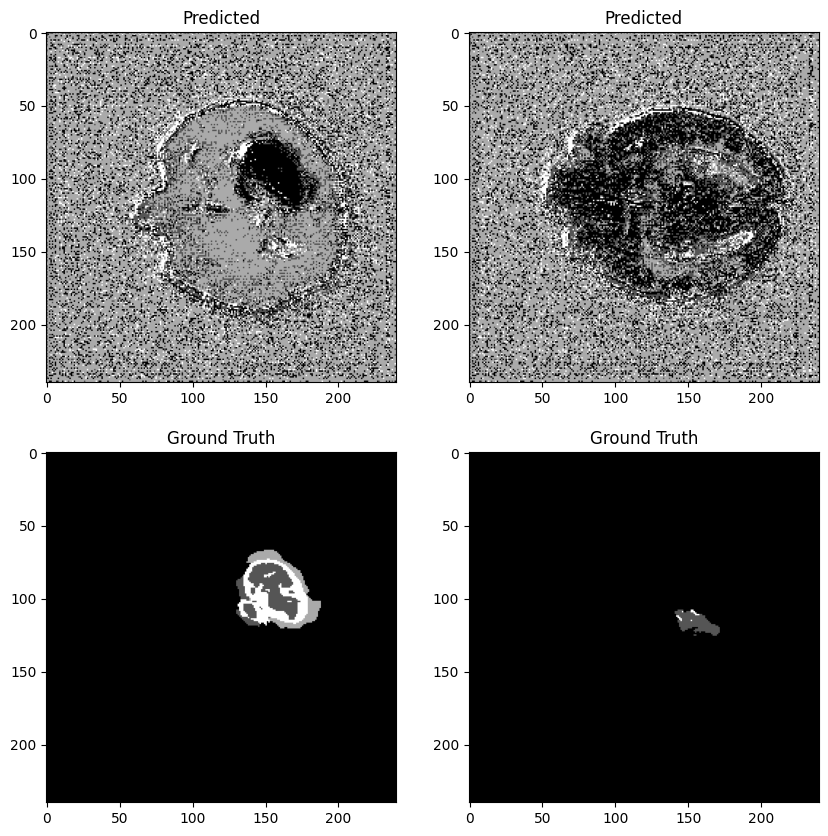

100%|██████████| 136/136 [06:35<00:00,  2.91s/it]



Average Training Loss: 1.168472962344394

Average Training DSC: [0.93620522 0.1427075  0.04233787 0.15997871]
Average Training ASSD: [ 10.16407413 179.12268793 280.49847962  19.18548844]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


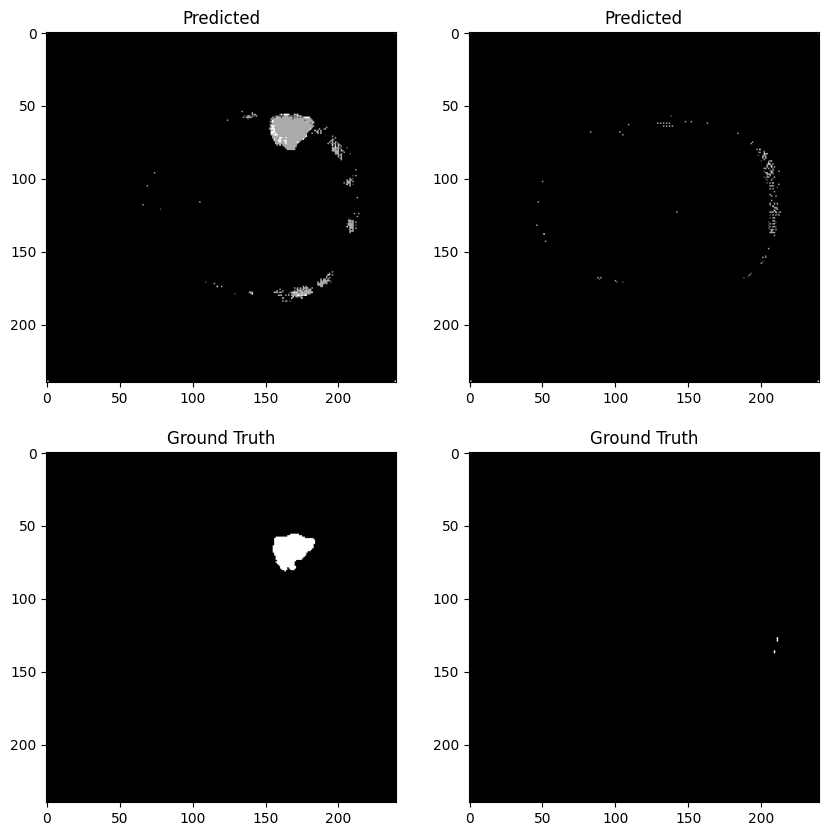

100%|██████████| 34/34 [01:16<00:00,  2.25s/it]


Average Validation Loss: 1.0009366904988009

Average Validation DSC: [0.99414132 0.23938491 0.06670956 0.18237282]
Average Validation ASSD: [  4.73717692 168.10335253 271.27212995  14.69581746]
Epoch 2/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


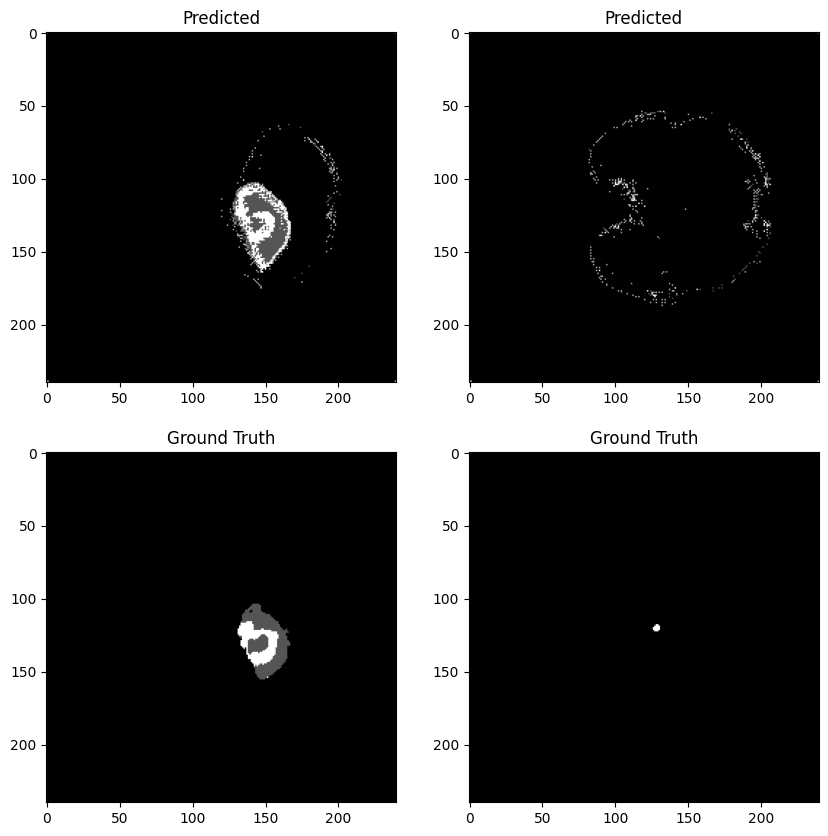

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.9388674896429566

Average Training DSC: [0.99516805 0.25938594 0.05676706 0.23571239]
Average Training ASSD: [  2.50085051 174.2227594  276.76939031  17.04906468]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


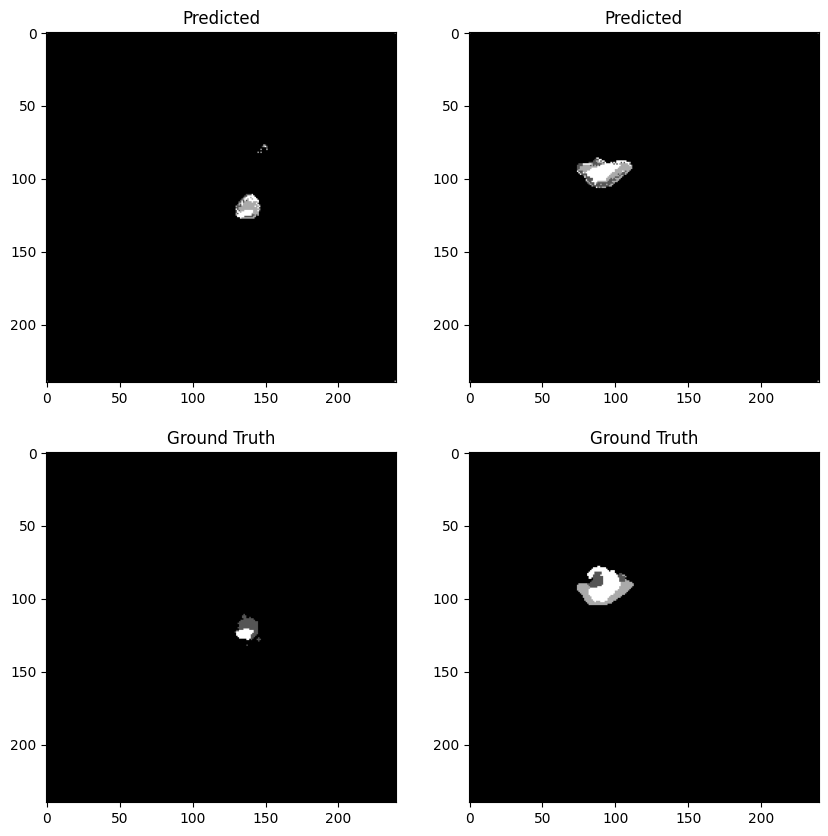

100%|██████████| 34/34 [01:05<00:00,  1.91s/it]


Average Validation Loss: 0.6775318103678086

Average Validation DSC: [0.99679696 0.2845755  0.08362882 0.32971539]
Average Validation ASSD: [  0.75314966 155.04601721 270.50771491  21.5874676 ]
Epoch 3/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


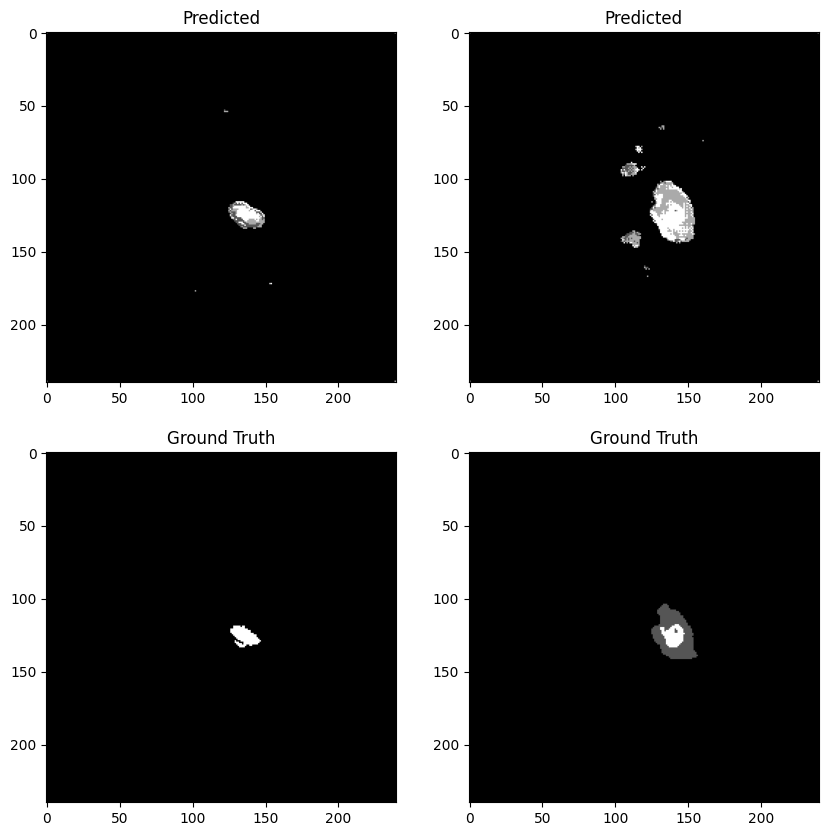

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.733613846494871

Average Training DSC: [0.99701976 0.26515647 0.06698686 0.33714254]
Average Training ASSD: [  0.8756133  171.98990505 276.46696446  24.24470088]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


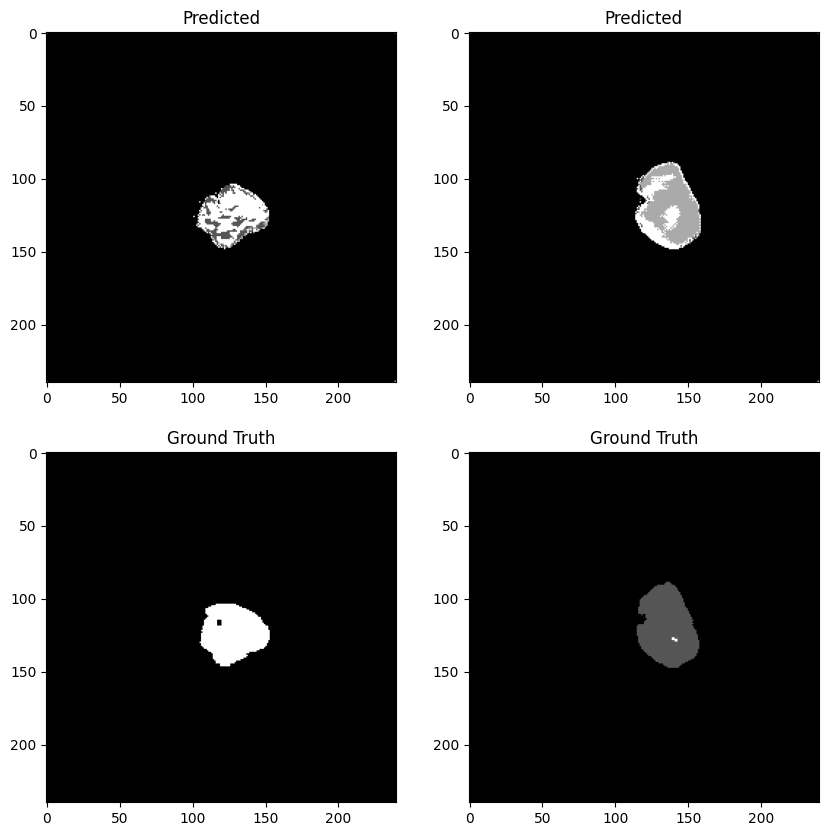

100%|██████████| 34/34 [01:05<00:00,  1.92s/it]


Average Validation Loss: 0.49299154825070324

Average Validation DSC: [0.99695668 0.24046478 0.06724866 0.38463973]
Average Validation ASSD: [  0.9077929  169.4777338  270.98135148  20.03850734]
Epoch 4/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


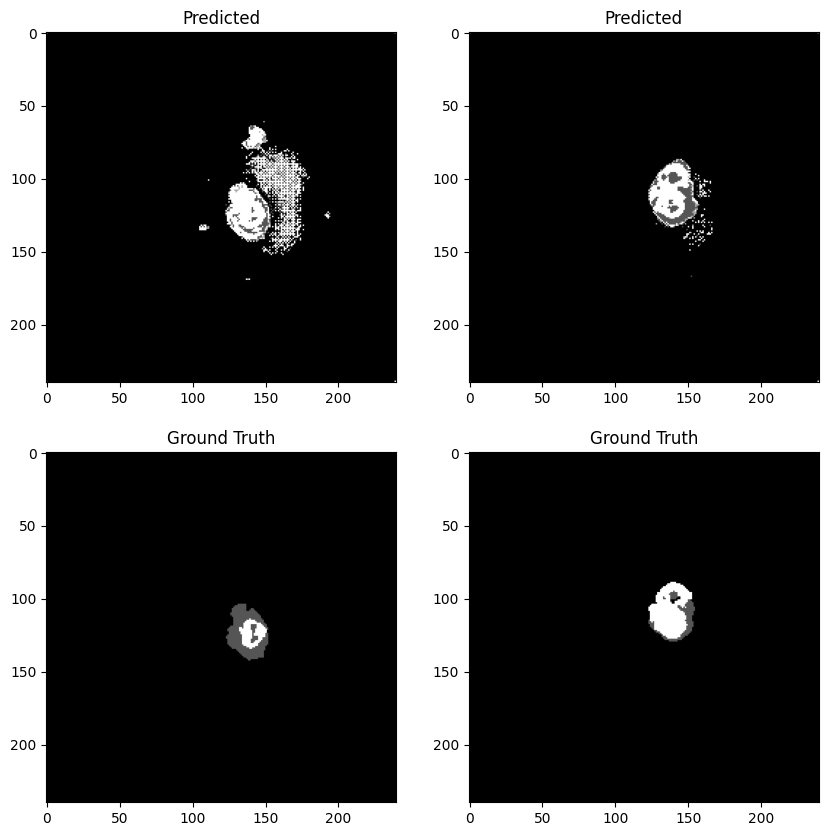

100%|██████████| 136/136 [05:14<00:00,  2.31s/it]



Average Training Loss: 0.5212663609315368

Average Training DSC: [0.9947336  0.24409957 0.07996615 0.37129797]
Average Training ASSD: [  1.2809603  176.76289821 268.11872452  22.02422046]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


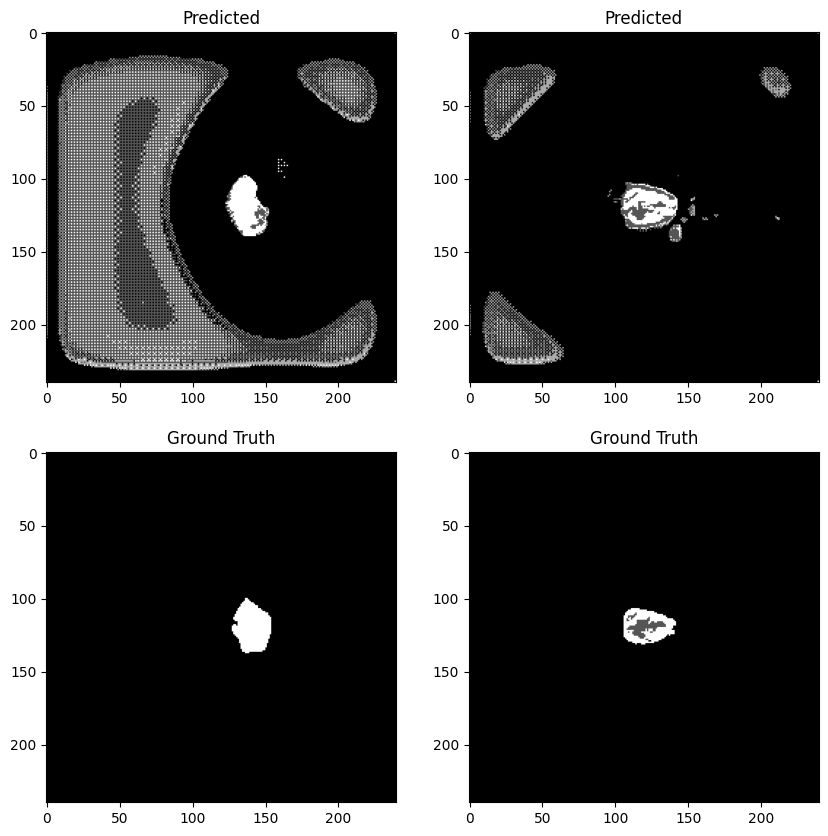

100%|██████████| 34/34 [01:08<00:00,  2.02s/it]


Average Validation Loss: 0.7094813953427708

Average Validation DSC: [0.89674566 0.08622453 0.01021028 0.23547108]
Average Validation ASSD: [  9.83435018 188.65490593 281.46924785  47.11661213]
Epoch 5/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


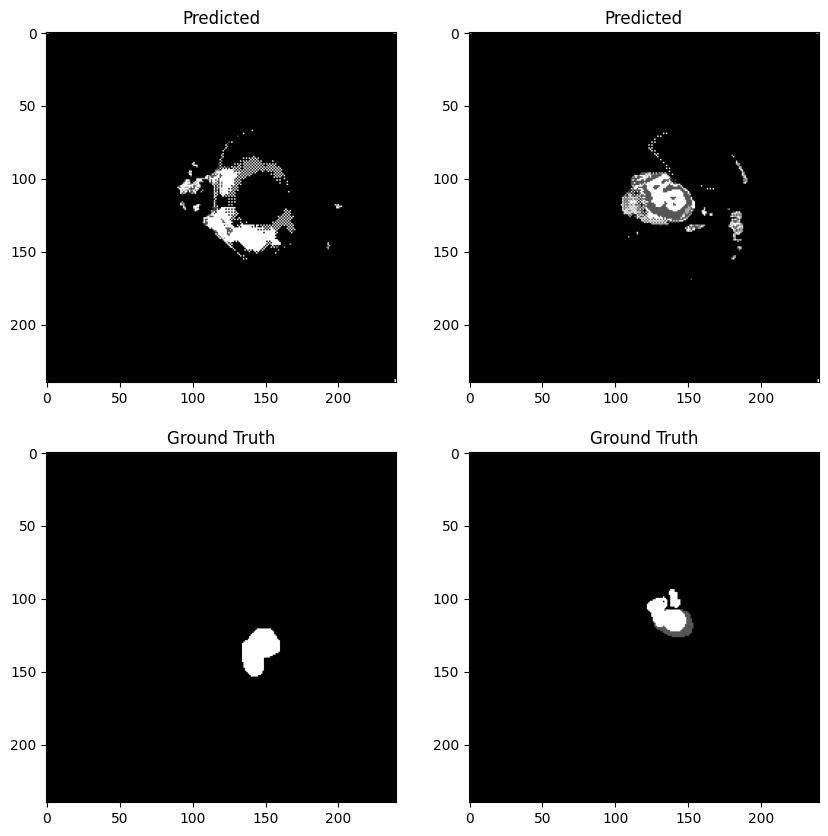

100%|██████████| 136/136 [05:13<00:00,  2.31s/it]



Average Training Loss: 0.38988252663437056

Average Training DSC: [0.996162   0.23820611 0.11113983 0.35507056]
Average Training ASSD: [  1.14776319 178.63374978 250.88851869  23.45191398]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


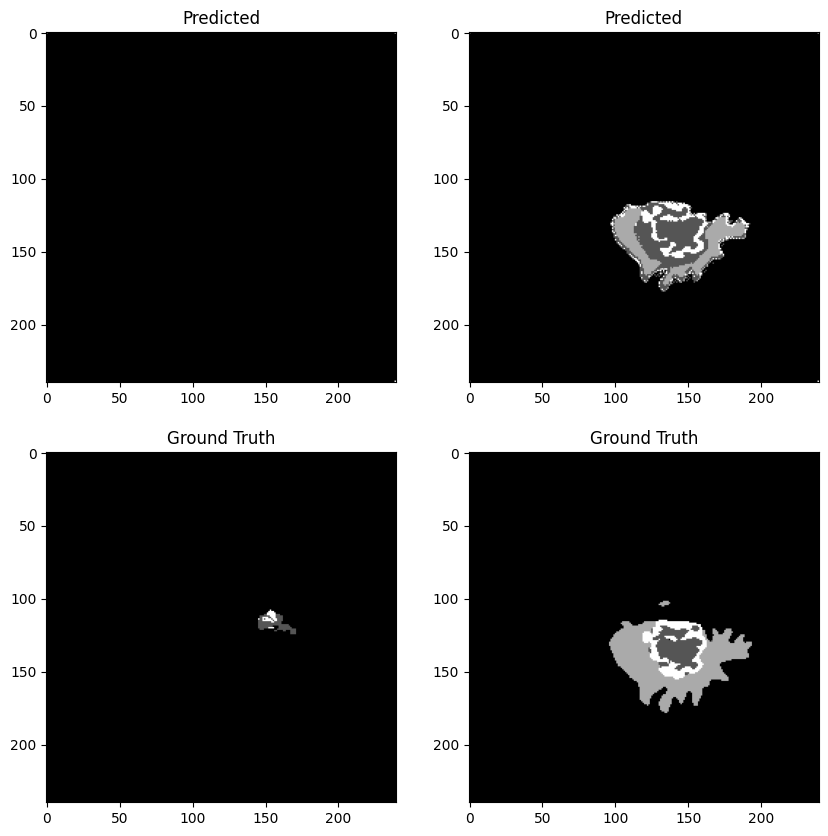

100%|██████████| 34/34 [01:05<00:00,  1.93s/it]


Average Validation Loss: 0.2540743013515192

Average Validation DSC: [0.99737459 0.22929835 0.17196709 0.36603139]
Average Validation ASSD: [  0.85234223 172.36263359 226.85089701  27.31996411]
Epoch 6/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


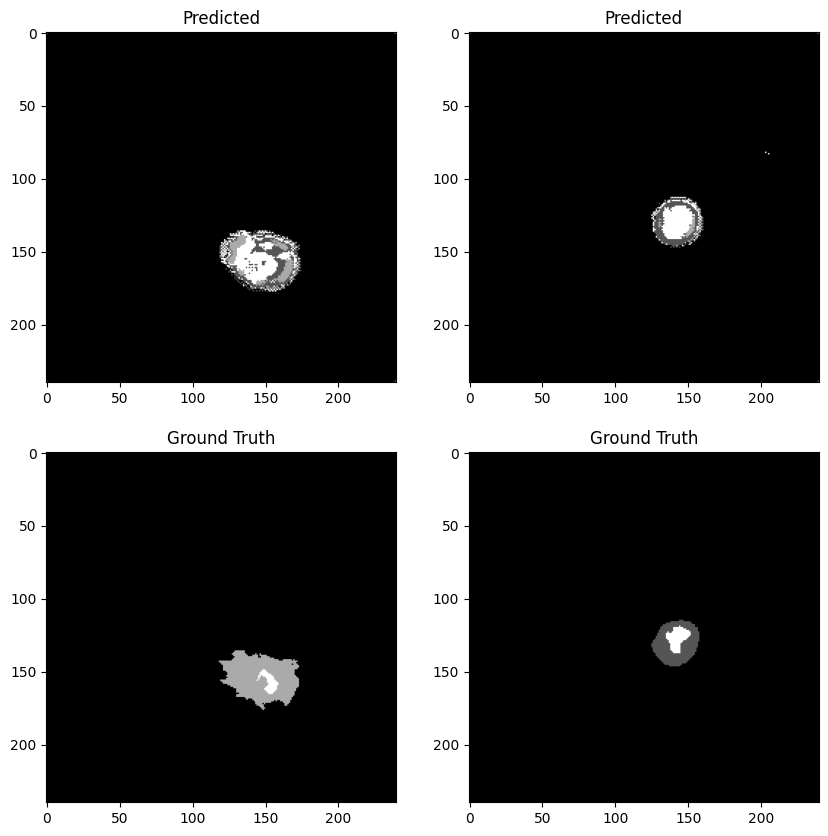

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.26763317569652023

Average Training DSC: [0.99758494 0.23496239 0.18030934 0.40156841]
Average Training ASSD: [  0.71387981 180.31672519 231.06213475  27.6606389 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


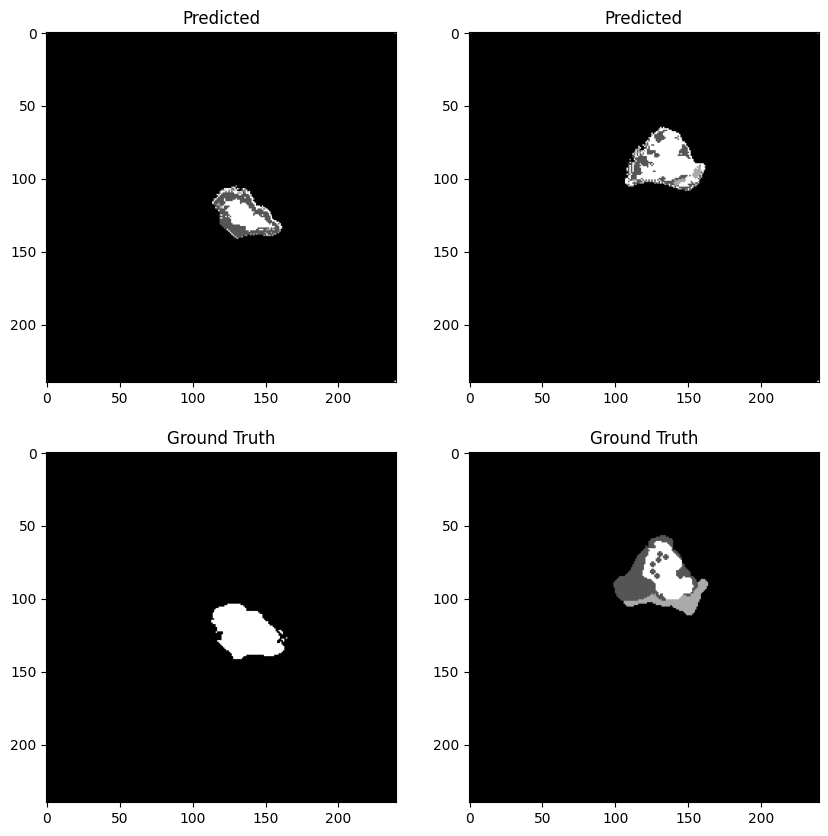

100%|██████████| 34/34 [01:07<00:00,  1.98s/it]


Average Validation Loss: 0.2002811668550267

Average Validation DSC: [0.99785105 0.25335571 0.19445012 0.41195844]
Average Validation ASSD: [  0.54230426 171.18592841 226.75516652  24.99113823]
Epoch 7/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


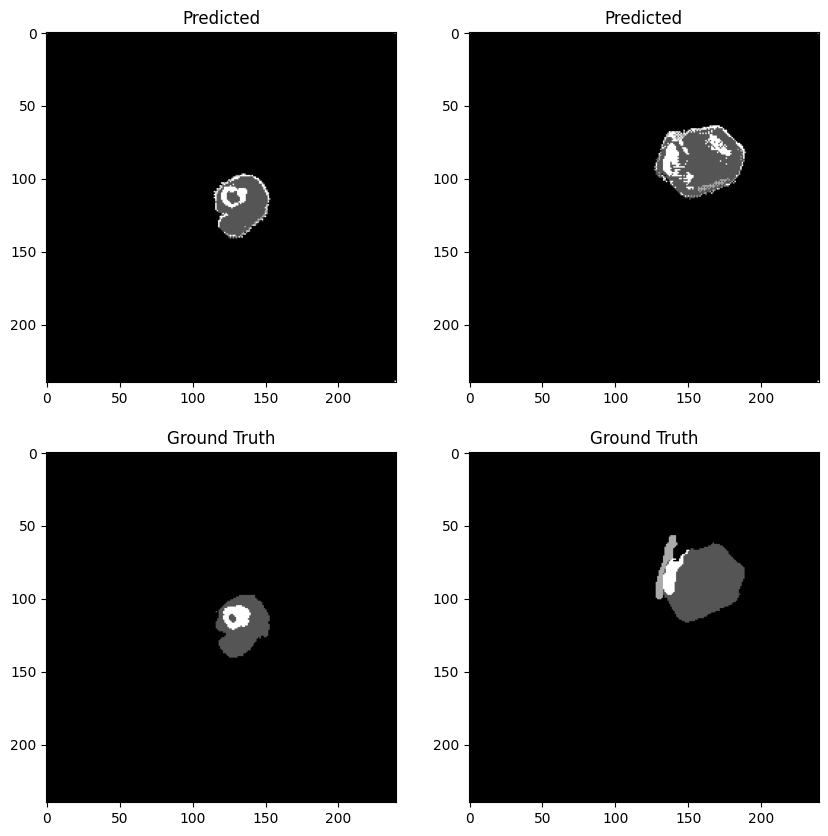

100%|██████████| 136/136 [05:20<00:00,  2.36s/it]



Average Training Loss: 0.1954721839112394

Average Training DSC: [0.99776239 0.26024975 0.19806127 0.42042221]
Average Training ASSD: [  0.61581354 176.52919849 226.603769    26.99803384]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


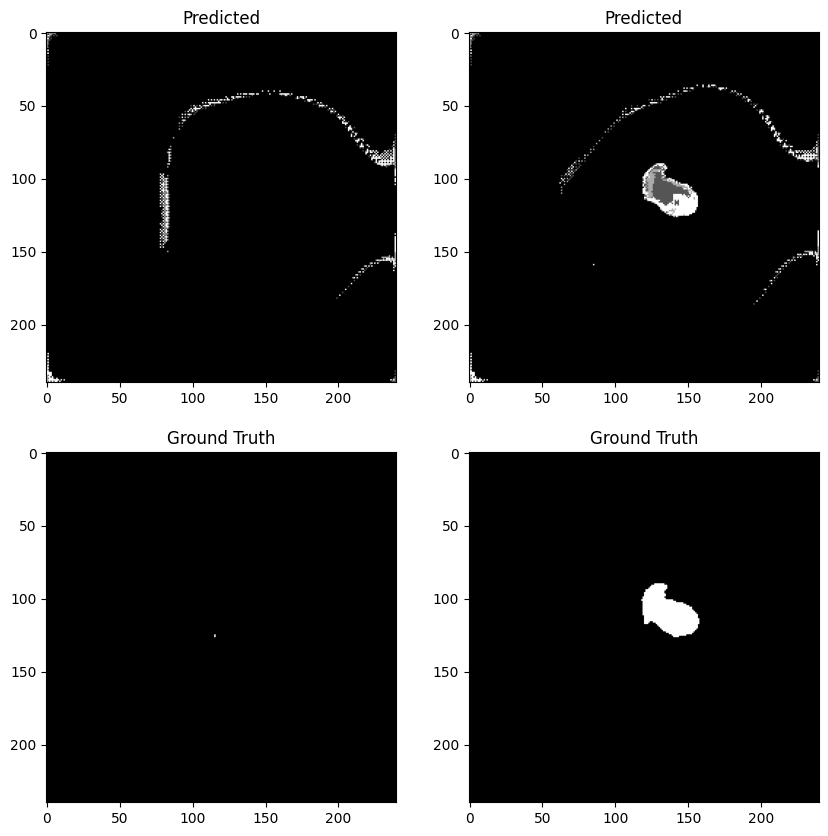

100%|██████████| 34/34 [01:07<00:00,  1.99s/it]


Average Validation Loss: 0.13710679464480457

Average Validation DSC: [0.99100555 0.20156077 0.02852581 0.31551284]
Average Validation ASSD: [  7.31517672 178.59118884 276.90576296  35.33571129]
Epoch 8/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


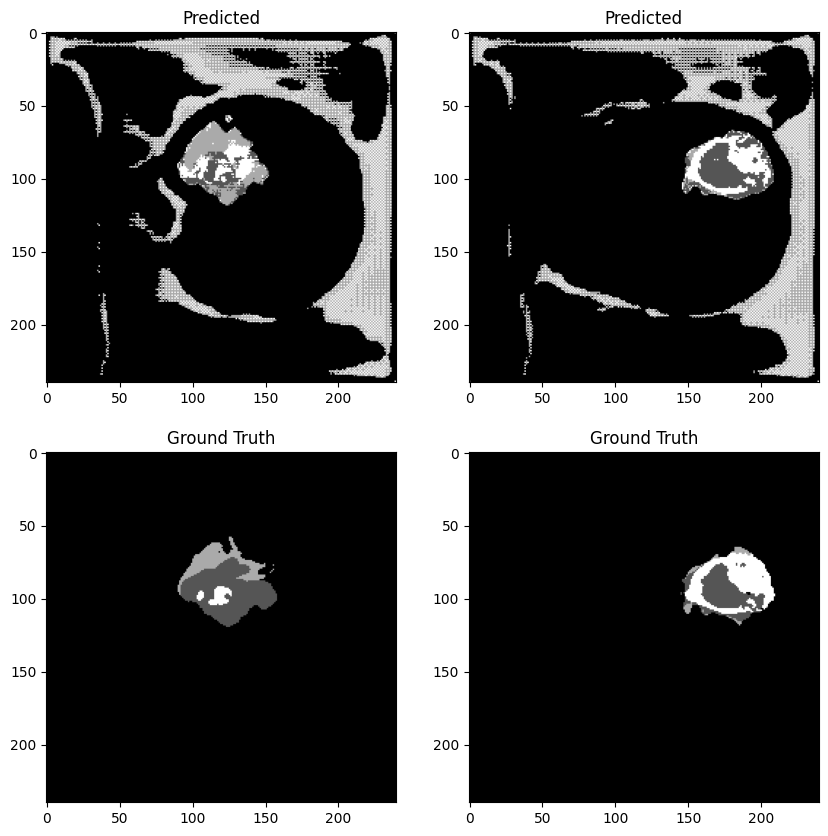

100%|██████████| 136/136 [05:11<00:00,  2.29s/it]



Average Training Loss: 0.1901027674731963

Average Training DSC: [0.99651454 0.32423605 0.11945904 0.361286  ]
Average Training ASSD: [  0.83646475 146.42392928 248.22535733  29.29560141]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


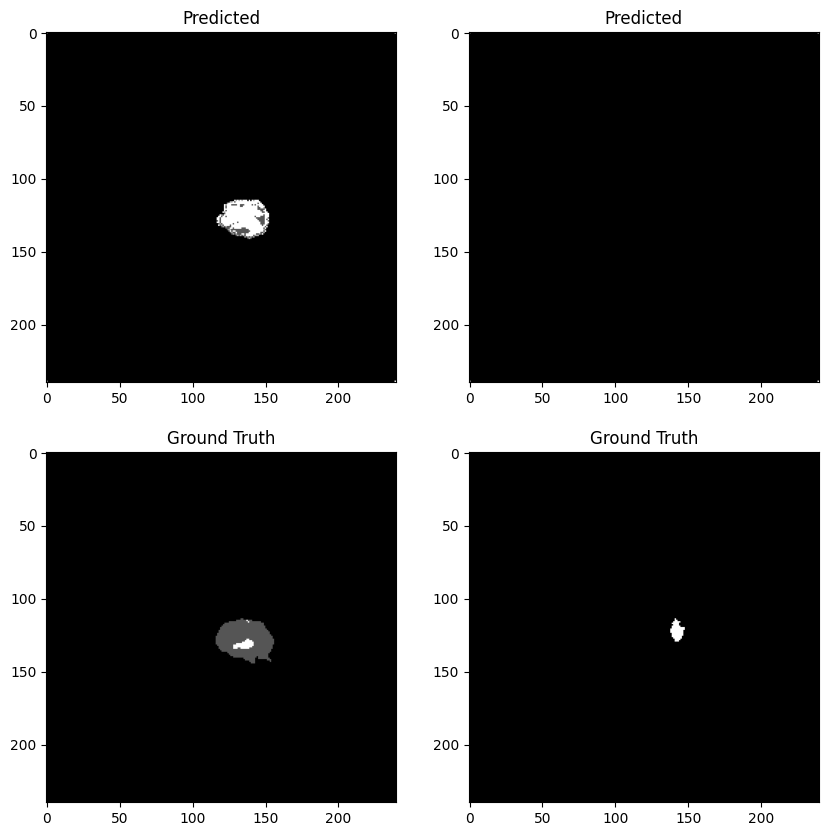

100%|██████████| 34/34 [01:04<00:00,  1.90s/it]


Average Validation Loss: 0.1227900149191127

Average Validation DSC: [0.99746238 0.39426378 0.22887191 0.37986095]
Average Validation ASSD: [  0.6540328  122.58826761 202.81414612  33.03489765]
Epoch 9/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


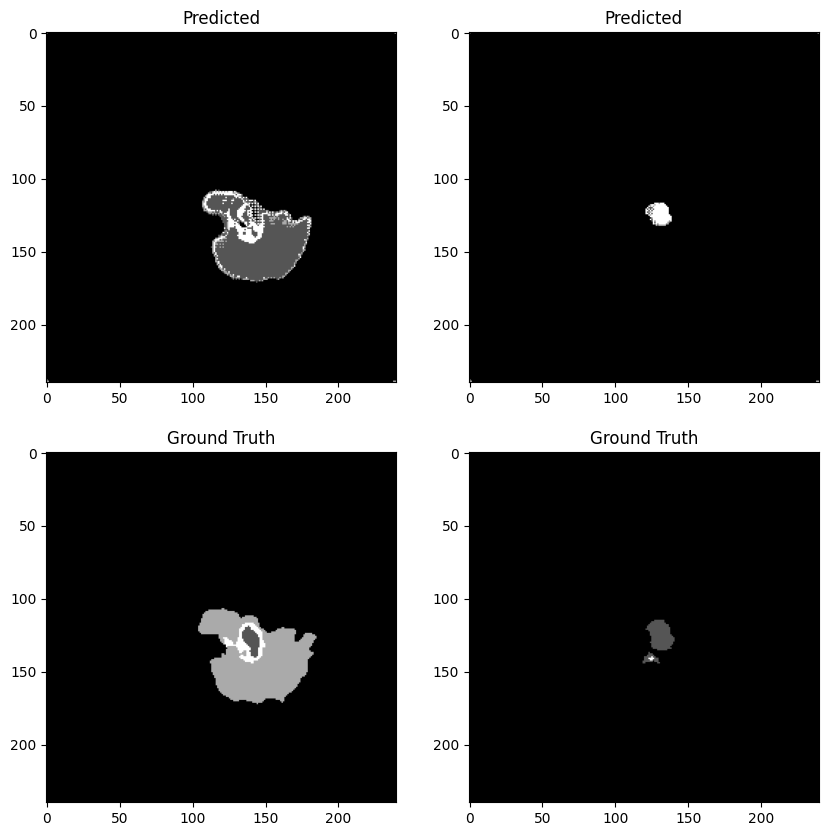

100%|██████████| 136/136 [05:11<00:00,  2.29s/it]



Average Training Loss: 0.12637188877252972

Average Training DSC: [0.99781705 0.36029862 0.05595976 0.39617997]
Average Training ASSD: [  0.53929482 142.48687032 270.69960801  28.55315954]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


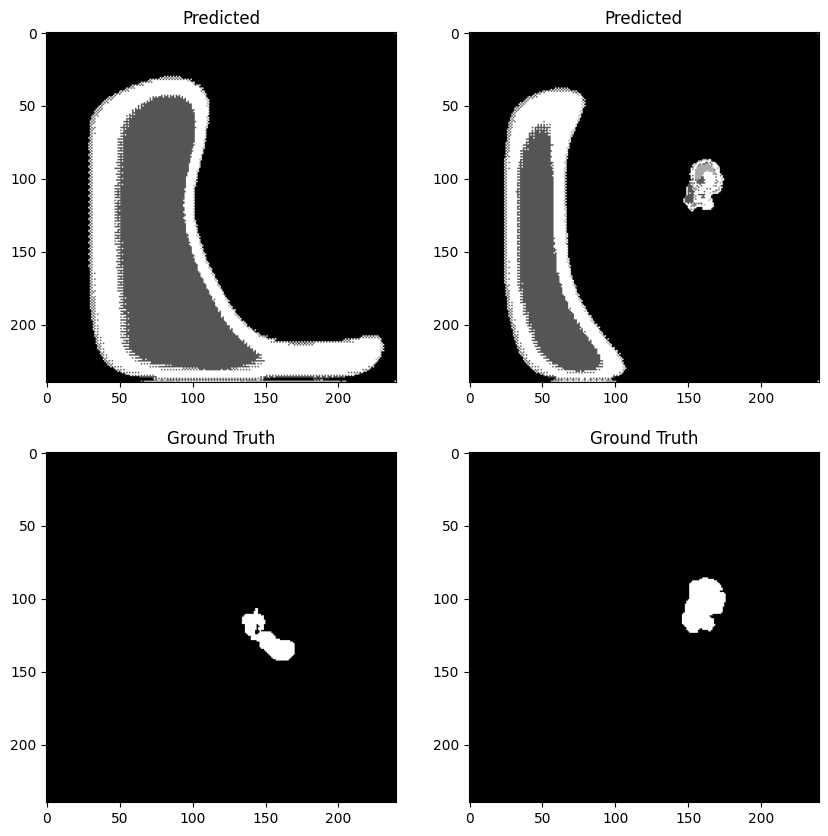

100%|██████████| 34/34 [01:06<00:00,  1.97s/it]


Average Validation Loss: 5.810729461557725

Average Validation DSC: [0.93787558 0.18554863 0.03932873 0.11528928]
Average Validation ASSD: [  3.89423335 183.22557657 277.94677664  51.05400477]
Epoch 10/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


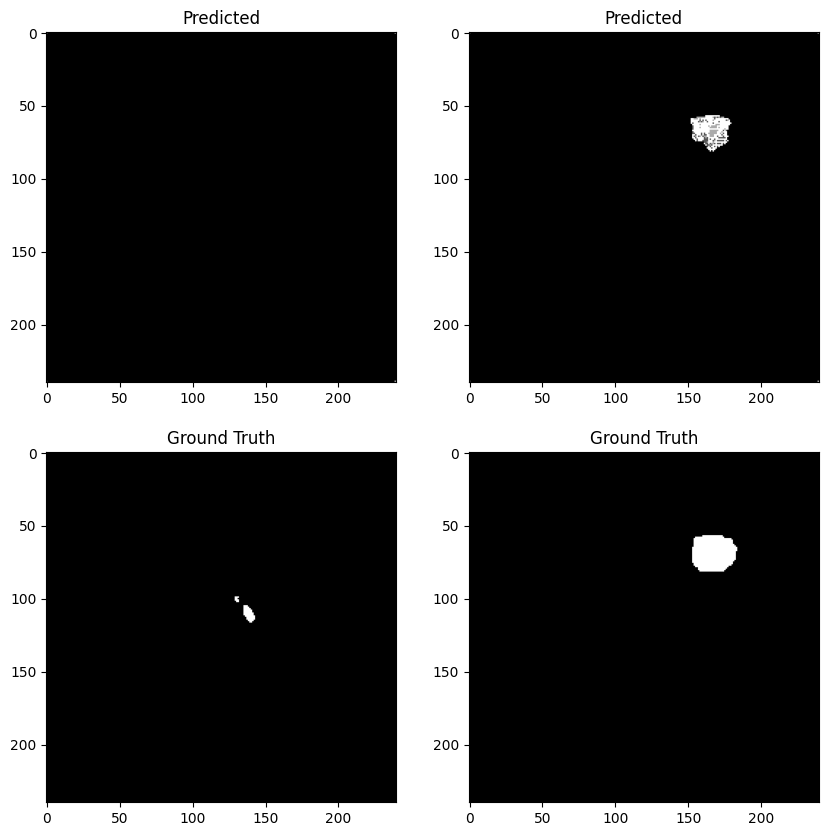

100%|██████████| 136/136 [05:12<00:00,  2.30s/it]



Average Training Loss: 0.10357226699809818

Average Training DSC: [0.99787962 0.29398773 0.21116875 0.42521062]
Average Training ASSD: [  0.51217224 163.16817528 219.78403673  26.66756439]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


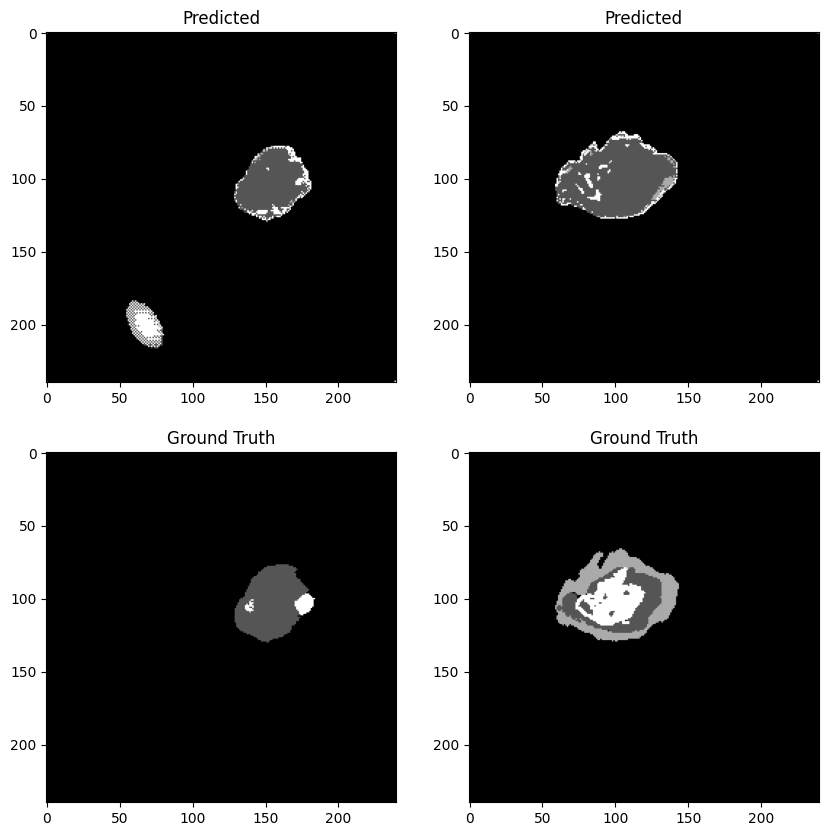

100%|██████████| 34/34 [01:05<00:00,  1.94s/it]


Average Validation Loss: 0.6933154937099008

Average Validation DSC: [0.987895   0.23926008 0.23458995 0.26396444]
Average Validation ASSD: [  2.39520434 179.14542575 200.82750597  35.31976197]
Epoch 11/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


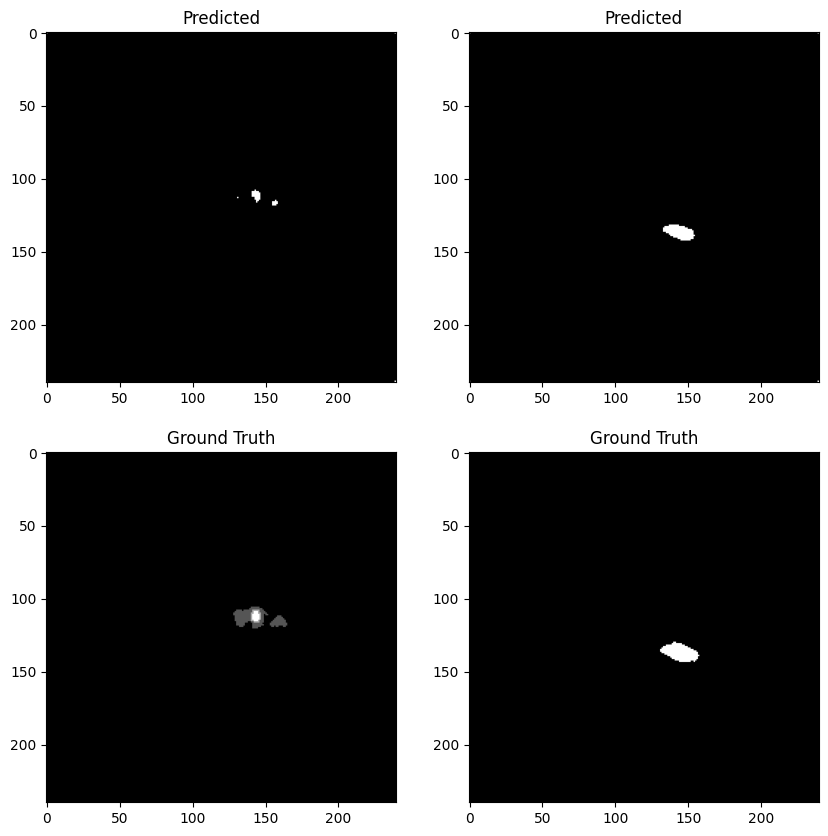

100%|██████████| 136/136 [05:09<00:00,  2.28s/it]



Average Training Loss: 0.08406641189118519

Average Training DSC: [0.99801932 0.35745927 0.3253442  0.43537049]
Average Training ASSD: [  0.48332461 144.83224154 183.54793903  26.88859204]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


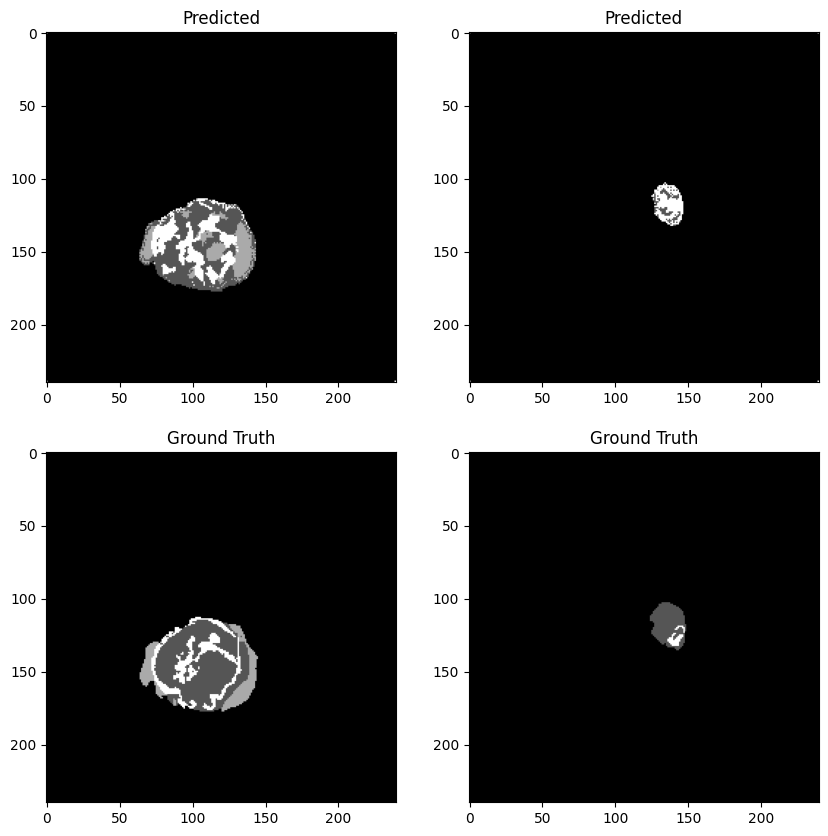

100%|██████████| 34/34 [01:04<00:00,  1.90s/it]


Average Validation Loss: 0.0785035125034697

Average Validation DSC: [0.99813821 0.38549812 0.31753972 0.46143603]
Average Validation ASSD: [  0.42580774 123.33201185 189.65993526  24.26574493]
Epoch 12/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


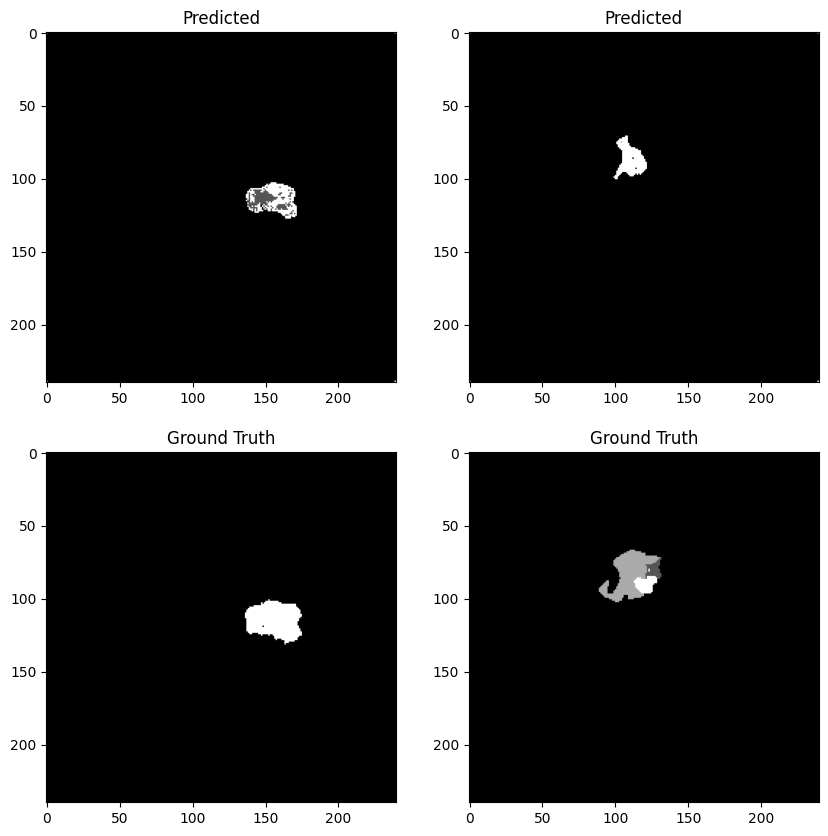

100%|██████████| 136/136 [05:15<00:00,  2.32s/it]



Average Training Loss: 0.07229108141516061

Average Training DSC: [0.9981101  0.38830751 0.36547655 0.45158518]
Average Training ASSD: [  0.44678058 139.21843509 173.72838399  25.56430302]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


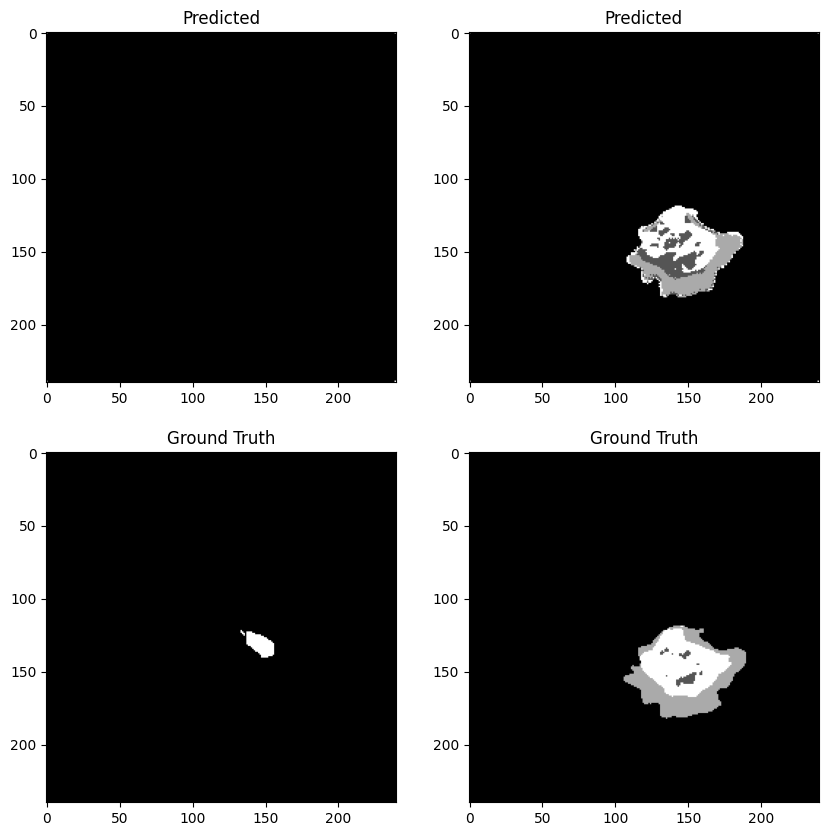

100%|██████████| 34/34 [01:07<00:00,  1.98s/it]


Average Validation Loss: 0.06178941983072197

Average Validation DSC: [0.99792568 0.46150643 0.31564359 0.42492472]
Average Validation ASSD: [  0.39919924 102.72775615 199.7495082   21.14914212]
Epoch 13/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


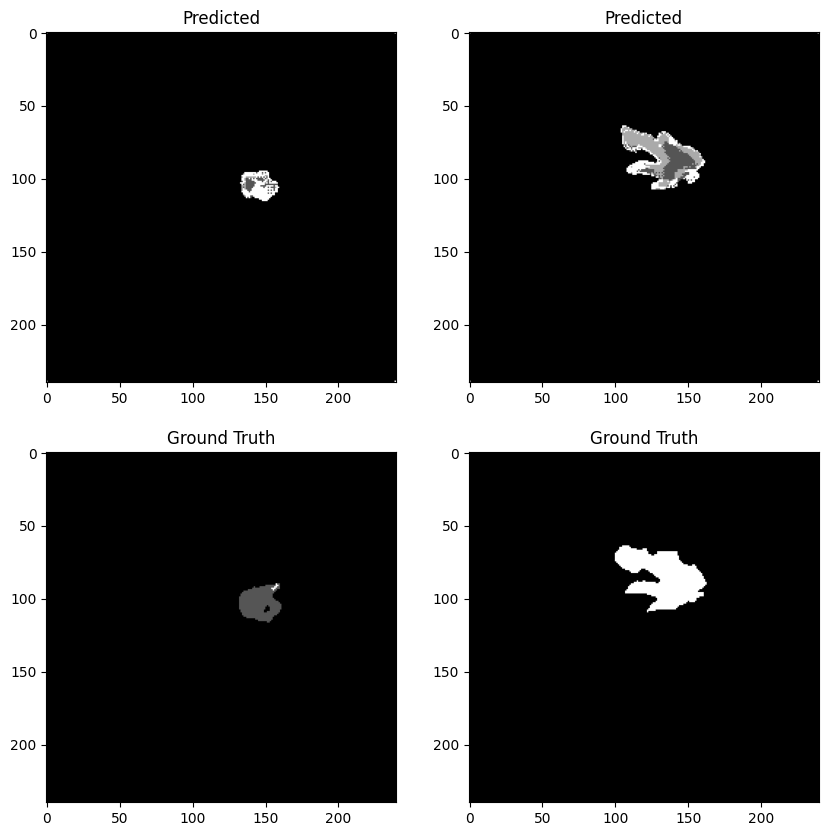

100%|██████████| 136/136 [05:17<00:00,  2.33s/it]



Average Training Loss: 0.06574803864692941

Average Training DSC: [0.99808021 0.39608747 0.41328589 0.46555348]
Average Training ASSD: [  0.44052453 135.38264411 161.33468418  24.87966391]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


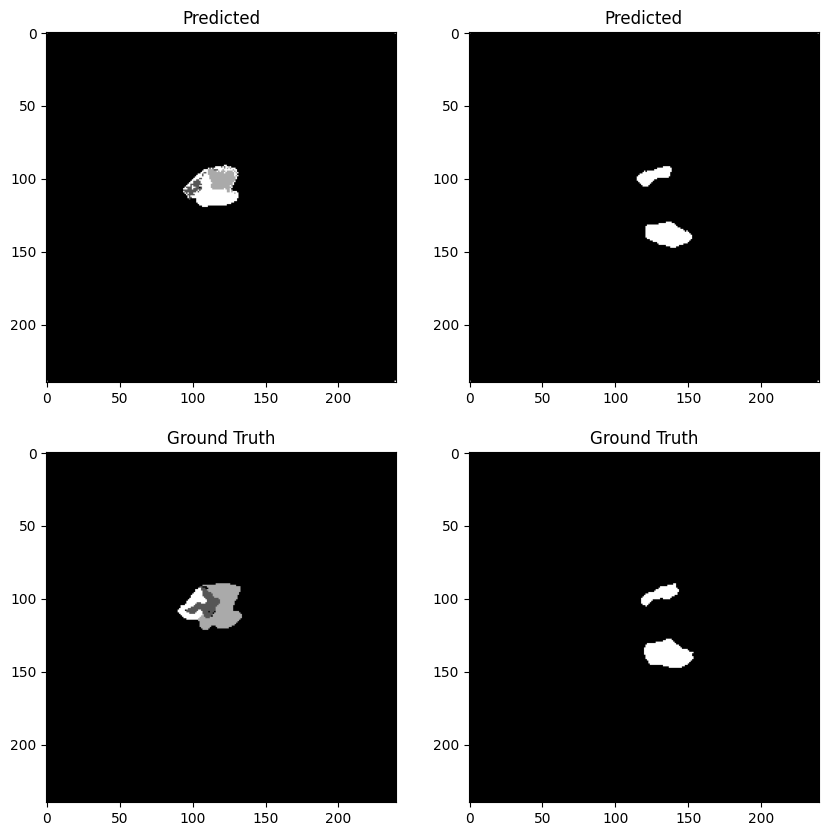

100%|██████████| 34/34 [01:20<00:00,  2.37s/it]


Average Validation Loss: 0.07286602017634056

Average Validation DSC: [0.99772141 0.38731848 0.46879205 0.45540084]
Average Validation ASSD: [  0.54318093 115.43011927 140.189067    27.13896063]
Epoch 14/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


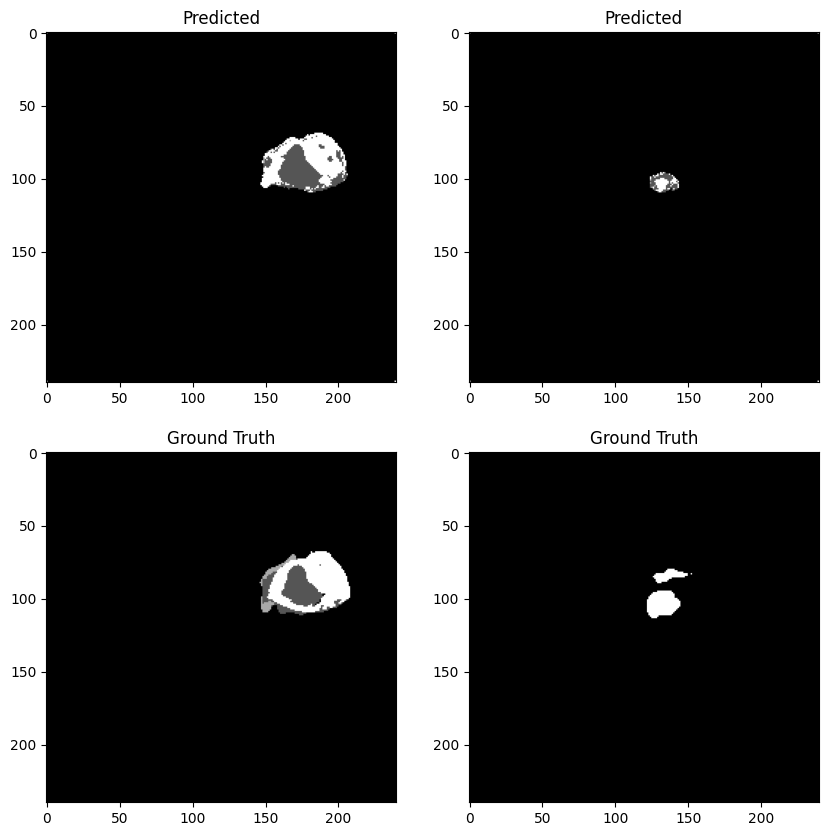

100%|██████████| 136/136 [18:58<00:00,  8.37s/it]



Average Training Loss: 0.061371849904603815

Average Training DSC: [0.99794939 0.40438866 0.49380533 0.45636444]
Average Training ASSD: [  0.47622643 133.74375301 136.91205725  25.46947746]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


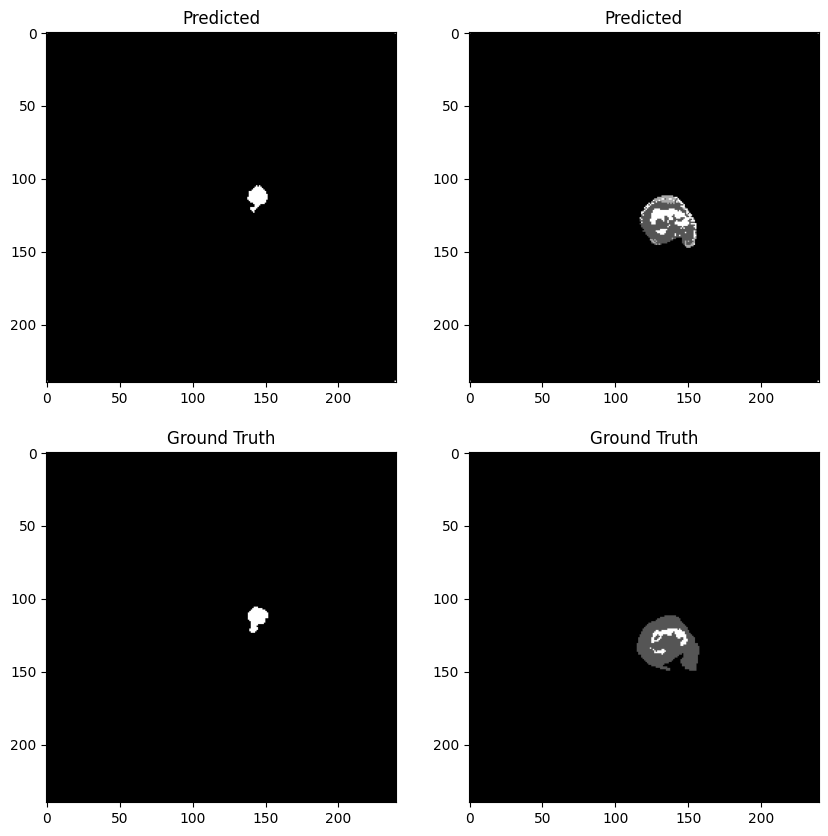

100%|██████████| 34/34 [04:44<00:00,  8.38s/it]


Average Validation Loss: 0.05759667900993543

Average Validation DSC: [0.99826386 0.42140017 0.53074424 0.50606122]
Average Validation ASSD: [  0.368707   113.09949087 124.95551087  19.84043514]
Epoch 15/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


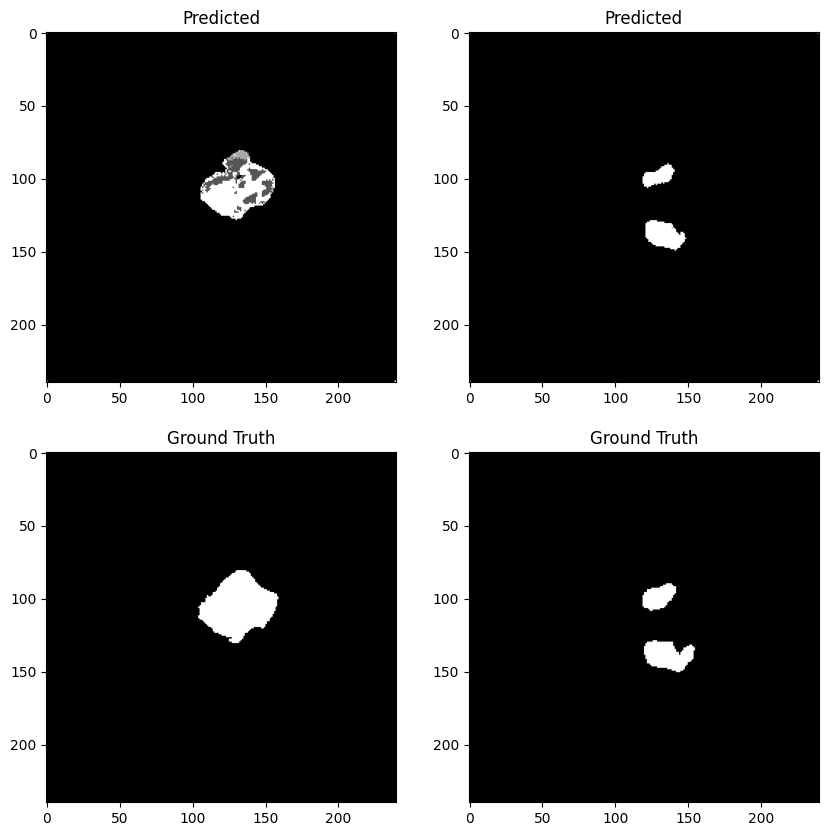

100%|██████████| 136/136 [20:28<00:00,  9.04s/it]



Average Training Loss: 0.05085830245276585

Average Training DSC: [0.99818433 0.42577599 0.55390377 0.48430013]
Average Training ASSD: [  0.39285648 131.41523854 122.70603131  23.34489376]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


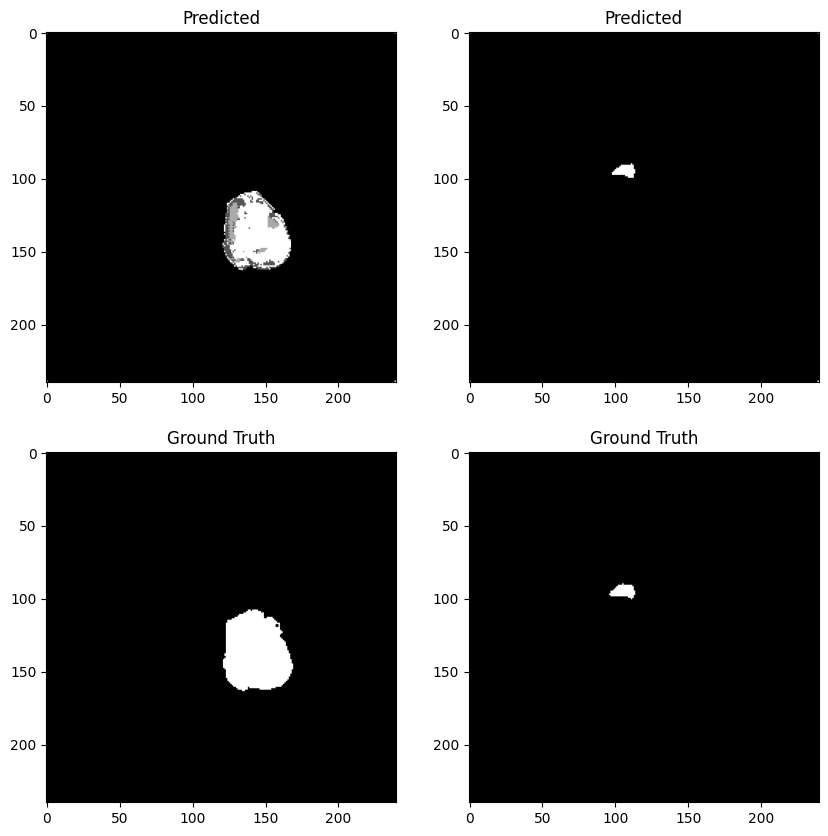

100%|██████████| 34/34 [04:59<00:00,  8.81s/it]


Average Validation Loss: 0.05117131243733799

Average Validation DSC: [0.99830999 0.41797867 0.607476   0.51160667]
Average Validation ASSD: [  0.3677228  117.16850004  95.05080656  22.04422424]
Epoch 16/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


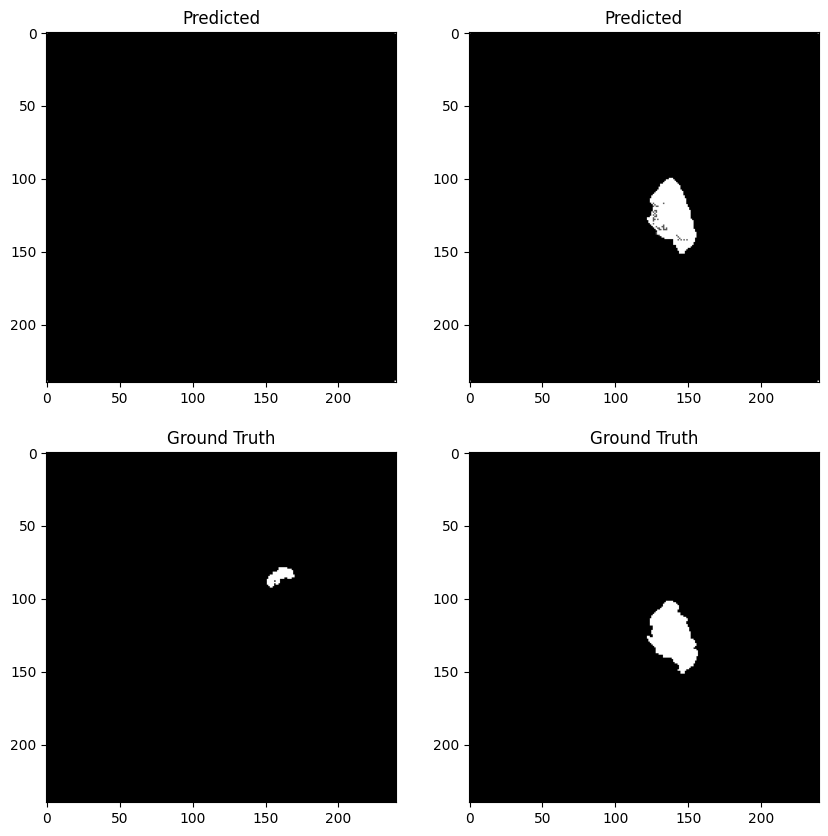

100%|██████████| 136/136 [20:41<00:00,  9.13s/it]



Average Training Loss: 0.04477074257481624

Average Training DSC: [0.99831162 0.3997954  0.61727263 0.51263046]
Average Training ASSD: [  0.35949135 142.69859963 103.89451545  21.77109823]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


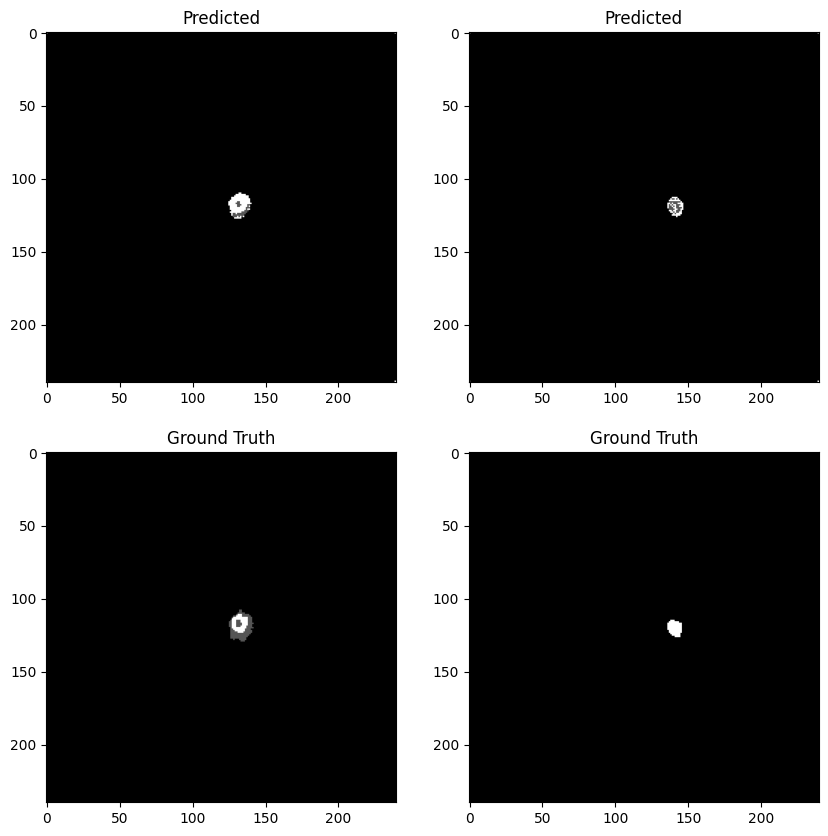

100%|██████████| 34/34 [04:44<00:00,  8.36s/it]


Average Validation Loss: 0.04437137767672539

Average Validation DSC: [0.99818597 0.29030094 0.73049008 0.50501483]
Average Validation ASSD: [  0.39208913 173.68388494  59.18076468  22.45445881]
Epoch 17/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


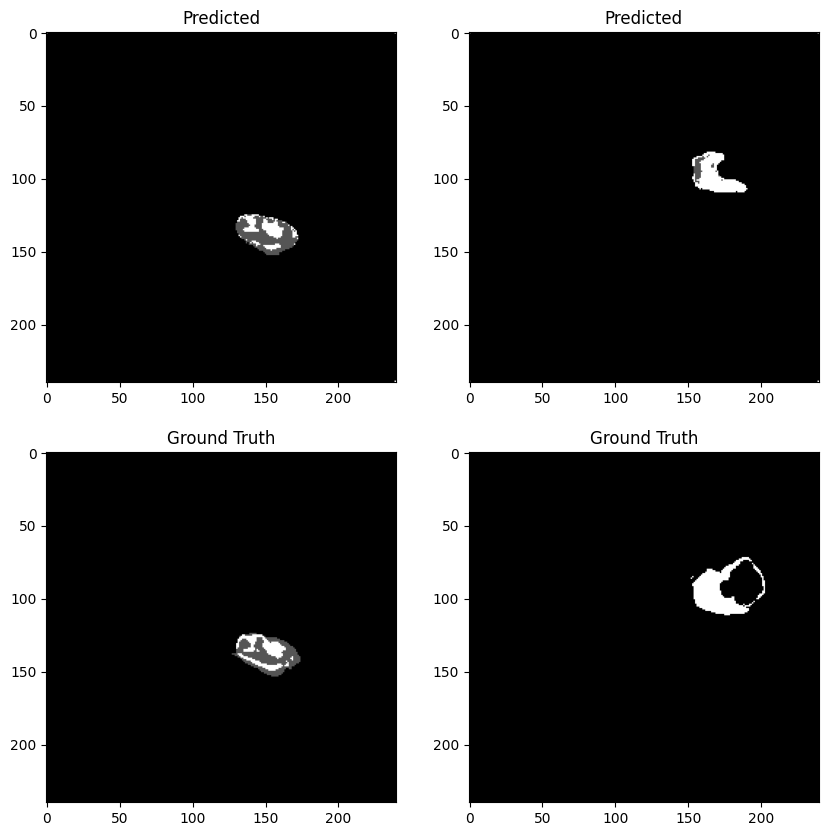

100%|██████████| 136/136 [19:58<00:00,  8.81s/it]



Average Training Loss: 0.041666458032148725

Average Training DSC: [0.99831206 0.33533606 0.65666351 0.51551214]
Average Training ASSD: [  0.36664393 162.94092689  91.61485203  27.89273941]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


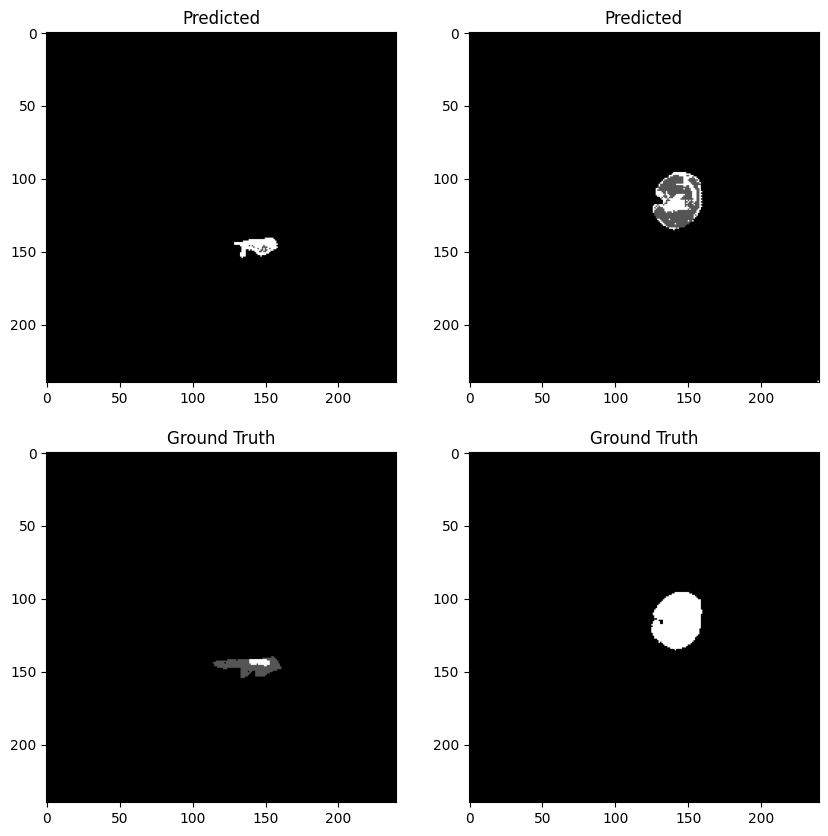

100%|██████████| 34/34 [04:36<00:00,  8.14s/it]


Average Validation Loss: 0.04279523397631505

Average Validation DSC: [0.99811078 0.28563308 0.61246469 0.49534916]
Average Validation ASSD: [  0.40134908 176.93614274 106.50574601  23.24315447]
Epoch 18/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


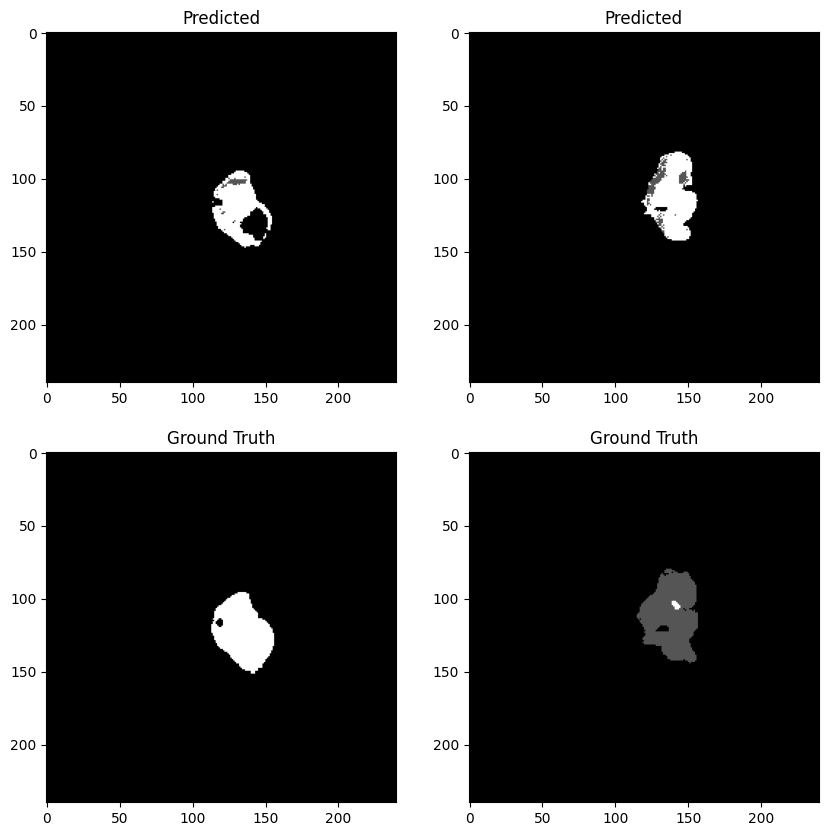

100%|██████████| 136/136 [20:38<00:00,  9.10s/it]



Average Training Loss: 0.03960372866405284

Average Training DSC: [0.99825266 0.4591142  0.69157893 0.5271493 ]
Average Training ASSD: [  0.34663549 124.95903323  79.28781601  32.61181954]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


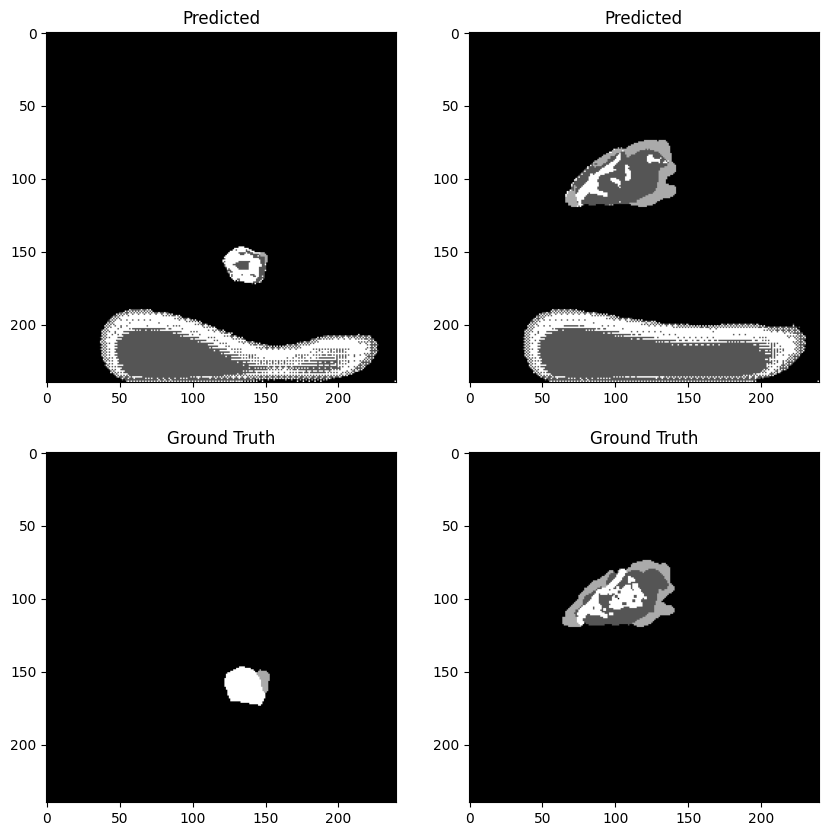

100%|██████████| 34/34 [04:43<00:00,  8.35s/it]


Average Validation Loss: 6.835902915281408

Average Validation DSC: [0.94707596 0.1667096  0.16314697 0.159318  ]
Average Validation ASSD: [  3.60983102 188.20961429 269.02728698  49.50052347]
Epoch 19/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


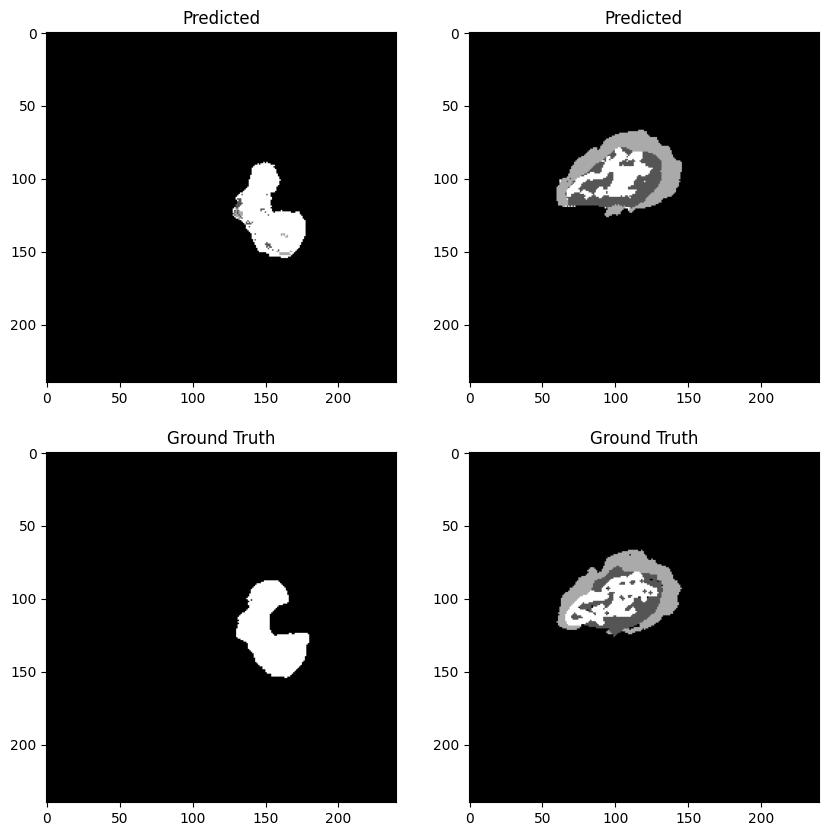

100%|██████████| 136/136 [20:36<00:00,  9.09s/it]



Average Training Loss: 0.03970094929065775

Average Training DSC: [0.99820655 0.48238035 0.70377137 0.52136321]
Average Training ASSD: [  0.36900396 114.19945475  77.17757509  32.99435052]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


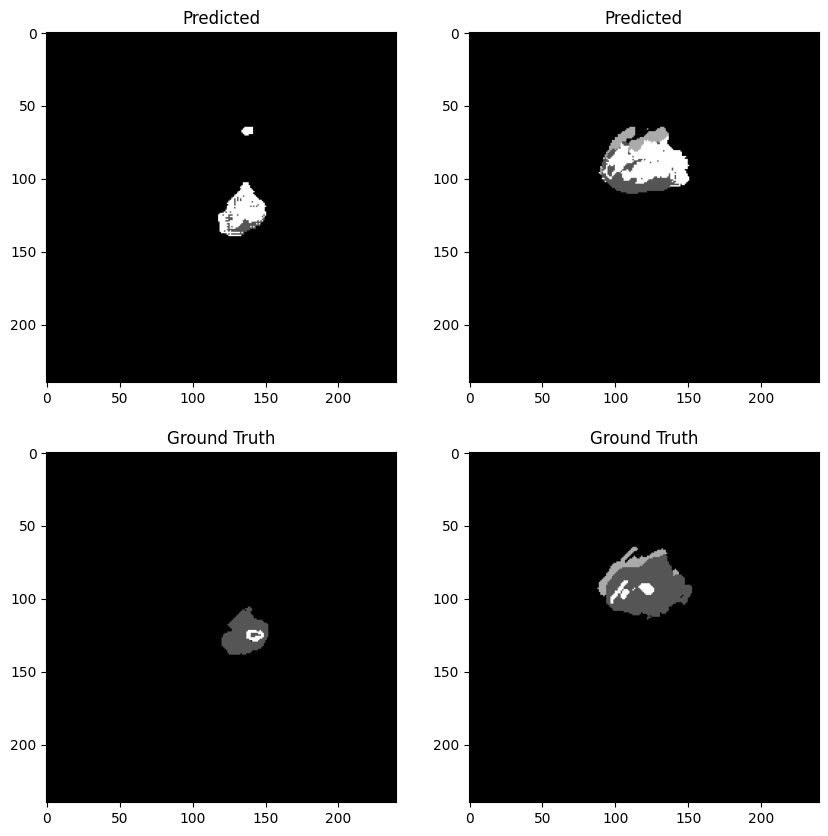

100%|██████████| 34/34 [05:02<00:00,  8.89s/it]


Average Validation Loss: 0.0368239353684818

Average Validation DSC: [0.99841123 0.48331387 0.80396255 0.54468021]
Average Validation ASSD: [  0.29892383 107.1254403   42.33868983  35.90532478]
Epoch 20/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


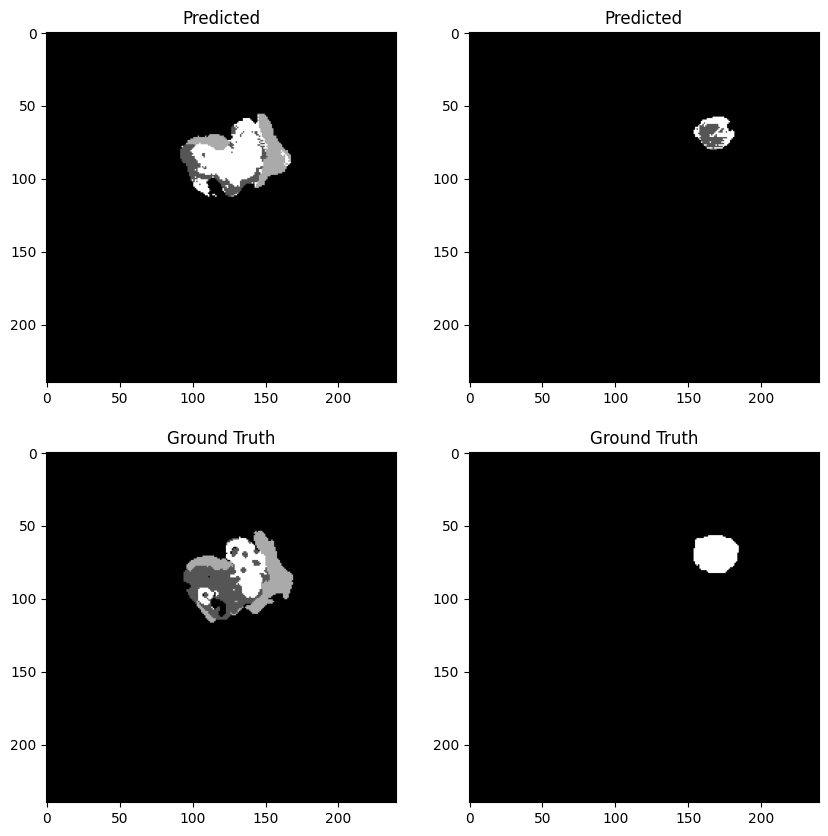

100%|██████████| 136/136 [19:44<00:00,  8.71s/it]



Average Training Loss: 0.032255418406909

Average Training DSC: [0.99843736 0.53563875 0.76176733 0.5548817 ]
Average Training ASSD: [  0.30816091 103.41151997  59.18846432  35.39200125]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


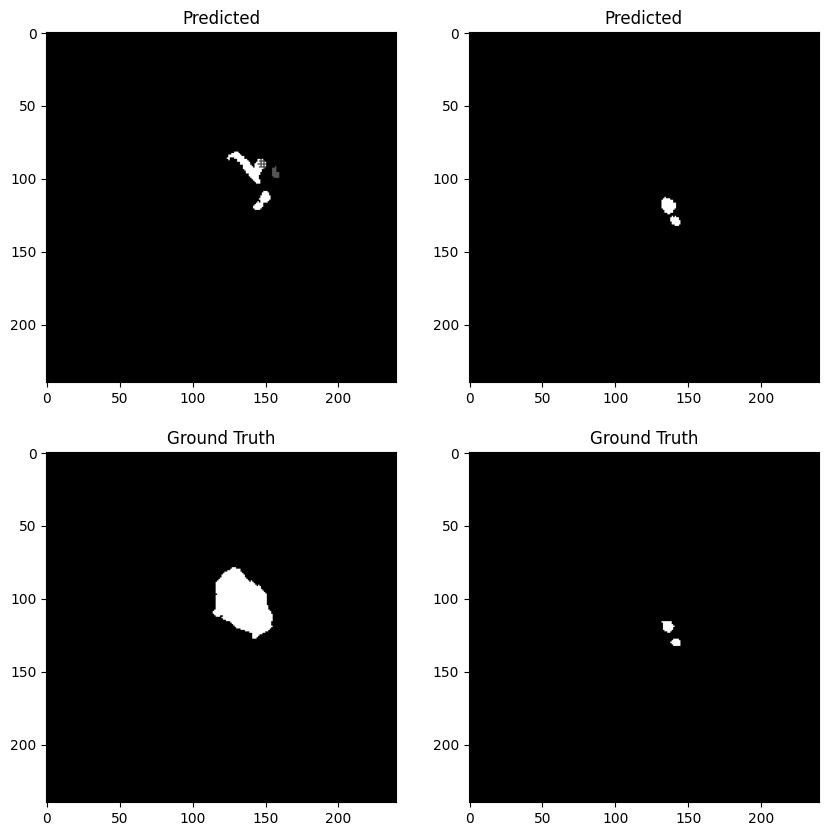

100%|██████████| 34/34 [05:02<00:00,  8.91s/it]


Average Validation Loss: 0.028727767824688378

Average Validation DSC: [0.99856341 0.54508855 0.82249987 0.54666681]
Average Validation ASSD: [  0.27265631 105.70328975  36.9397967   31.44484185]
Epoch 21/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


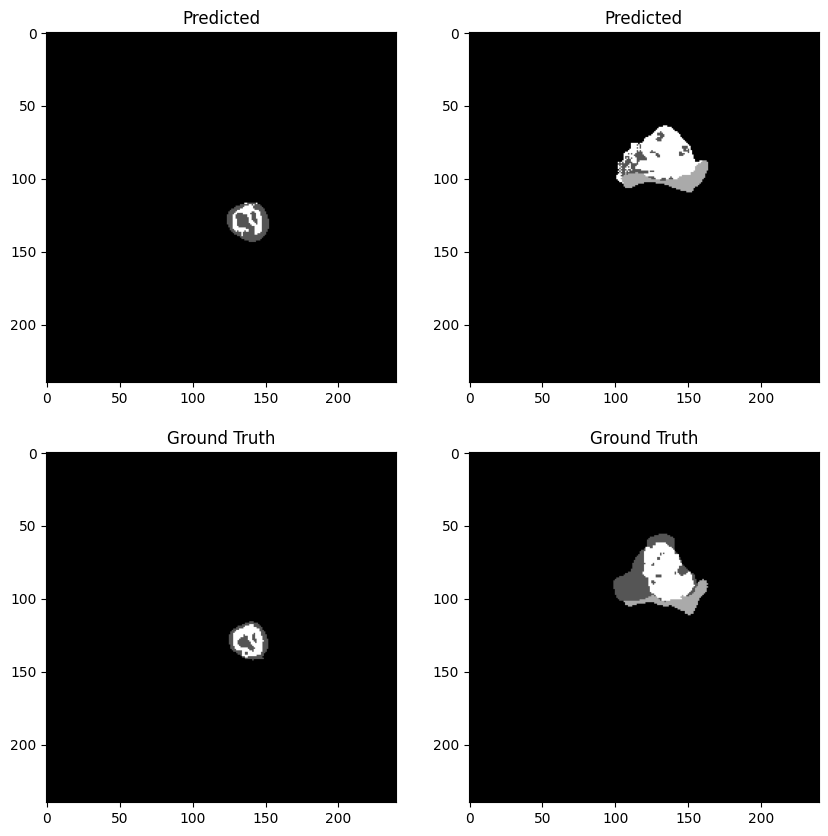

100%|██████████| 136/136 [20:46<00:00,  9.17s/it]



Average Training Loss: 0.027534715064308223

Average Training DSC: [0.99860888 0.59483817 0.81520331 0.58395255]
Average Training ASSD: [ 0.25881756 88.79928405 42.84809752 34.32661936]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


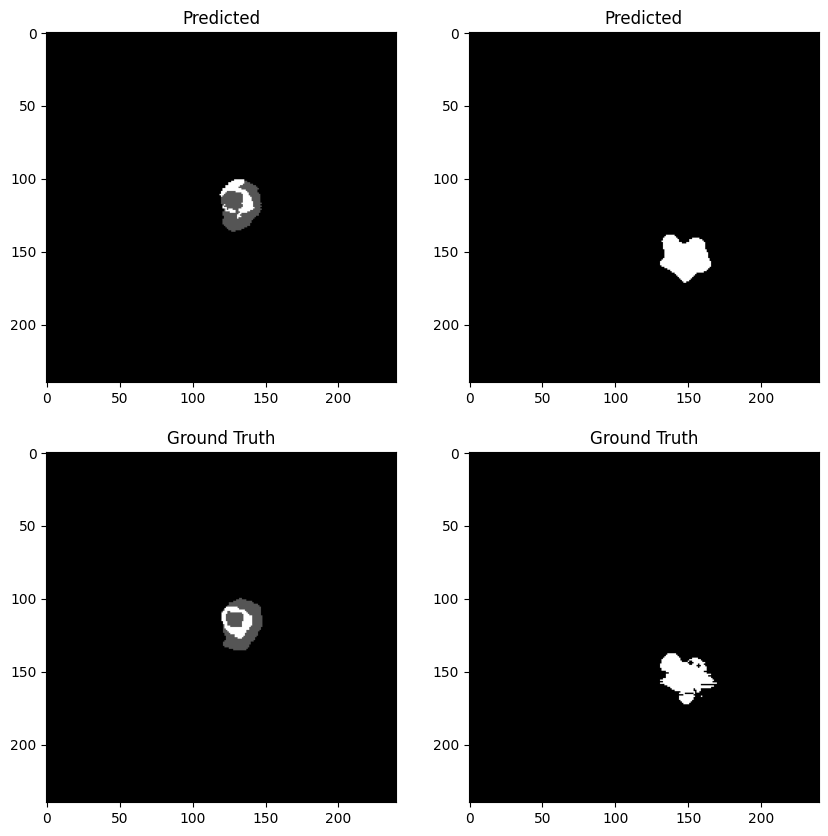

100%|██████████| 34/34 [05:01<00:00,  8.86s/it]


Average Validation Loss: 0.02776724784908926

Average Validation DSC: [0.99857049 0.61219028 0.86826843 0.60781456]
Average Validation ASSD: [ 0.23239292 81.06989307 22.35751713 25.49339149]
Epoch 22/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


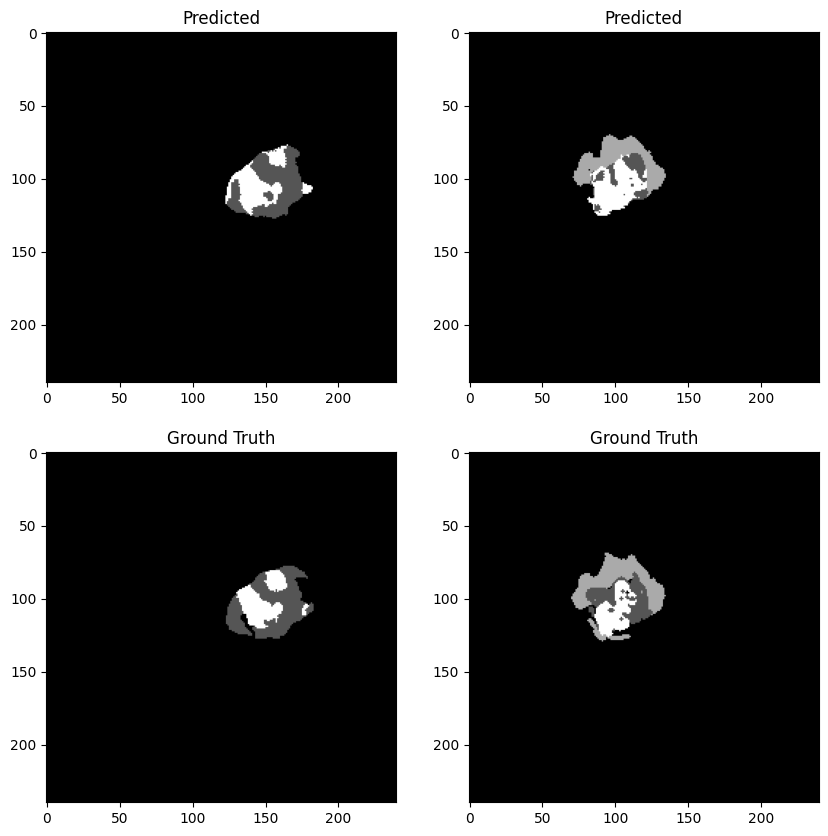

100%|██████████| 136/136 [20:05<00:00,  8.86s/it]



Average Training Loss: 0.02829454861143056

Average Training DSC: [0.99844928 0.6091005  0.8127971  0.58034466]
Average Training ASSD: [ 0.31142905 87.33689266 43.69314536 34.49510095]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


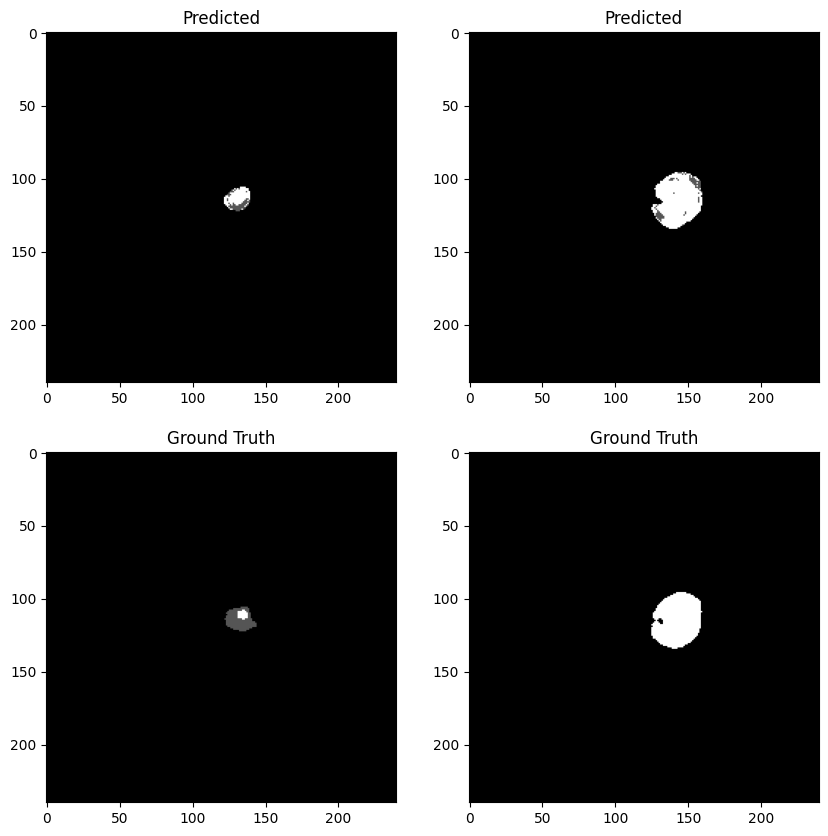

100%|██████████| 34/34 [04:35<00:00,  8.11s/it]


Average Validation Loss: 0.03088760655373335

Average Validation DSC: [0.99797823 0.48482847 0.69939283 0.55308203]
Average Validation ASSD: [  0.31394985 111.60903908  79.35327201  19.15703608]
Epoch 23/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


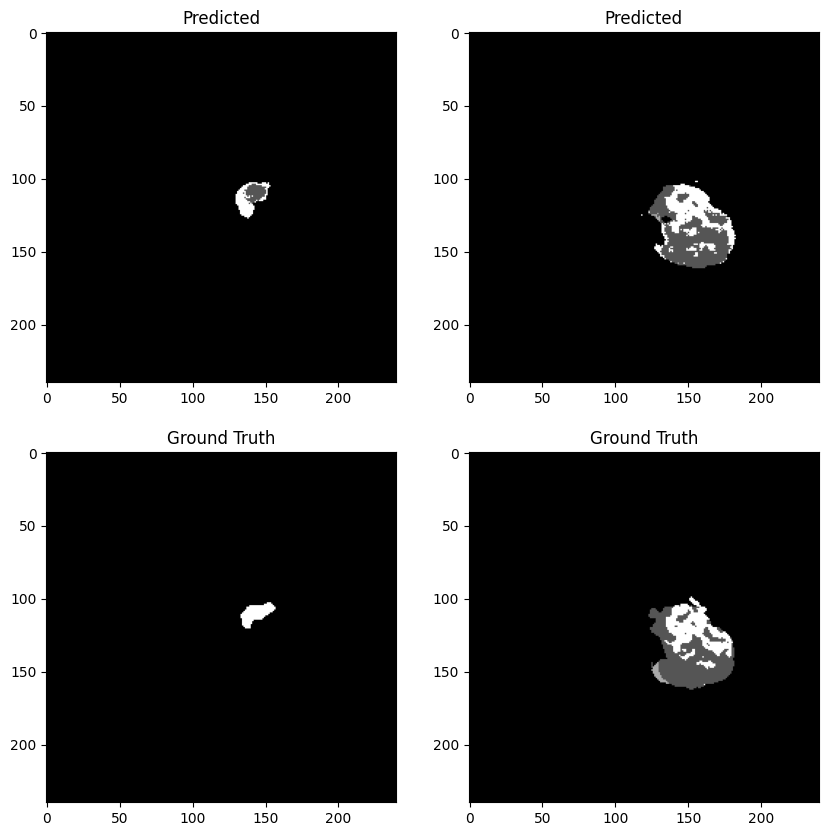

100%|██████████| 136/136 [19:57<00:00,  8.80s/it]



Average Training Loss: 0.029361454030389294

Average Training DSC: [0.99831843 0.57948554 0.78840876 0.57062672]
Average Training ASSD: [ 0.32085619 95.24669786 52.33341511 35.88767635]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


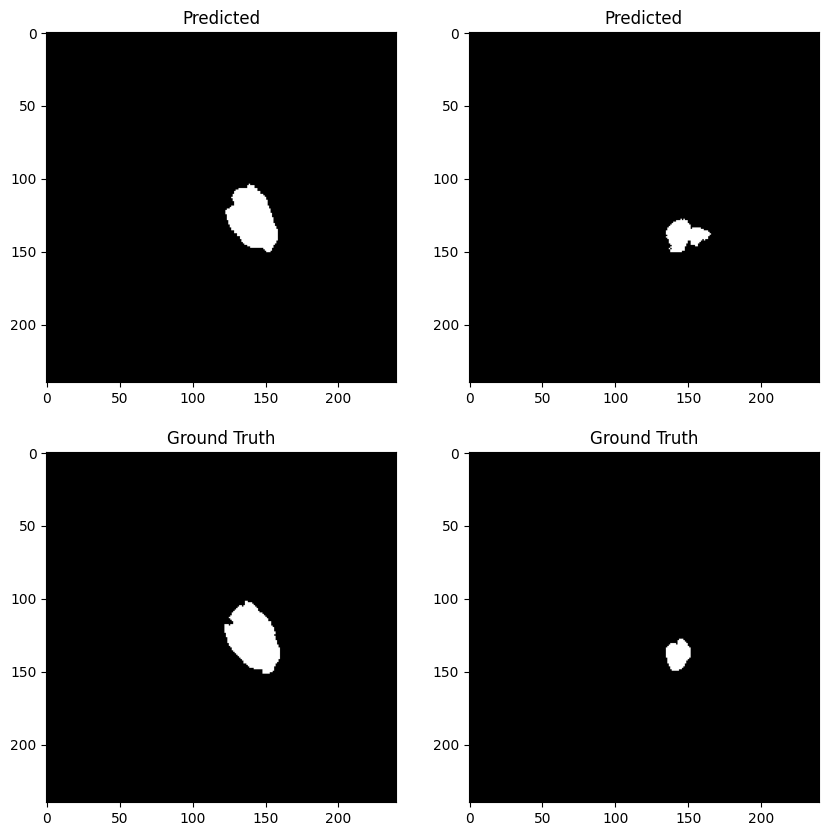

100%|██████████| 34/34 [04:36<00:00,  8.14s/it]


Average Validation Loss: 0.02788396897342275

Average Validation DSC: [0.99851601 0.58270583 0.82523821 0.60509044]
Average Validation ASSD: [ 0.24001957 96.63169021 39.60069602 23.59660248]
Epoch 24/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


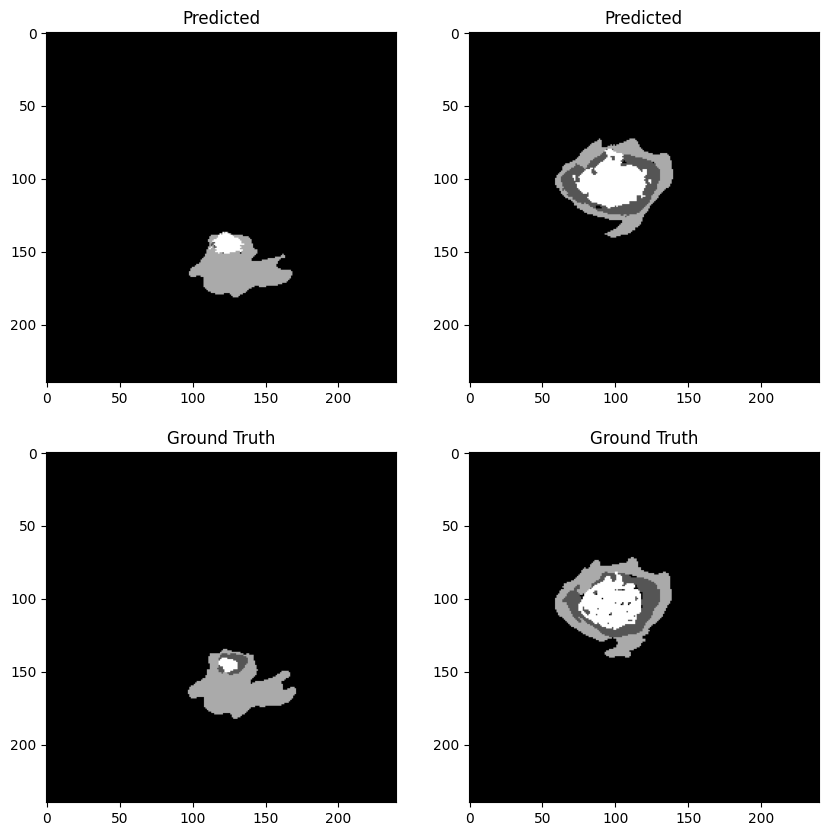

100%|██████████| 136/136 [20:00<00:00,  8.83s/it]



Average Training Loss: 0.022350138094385758

Average Training DSC: [0.99862249 0.68186148 0.84027249 0.61856844]
Average Training ASSD: [ 0.25786692 69.83772876 36.01532533 34.27217371]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


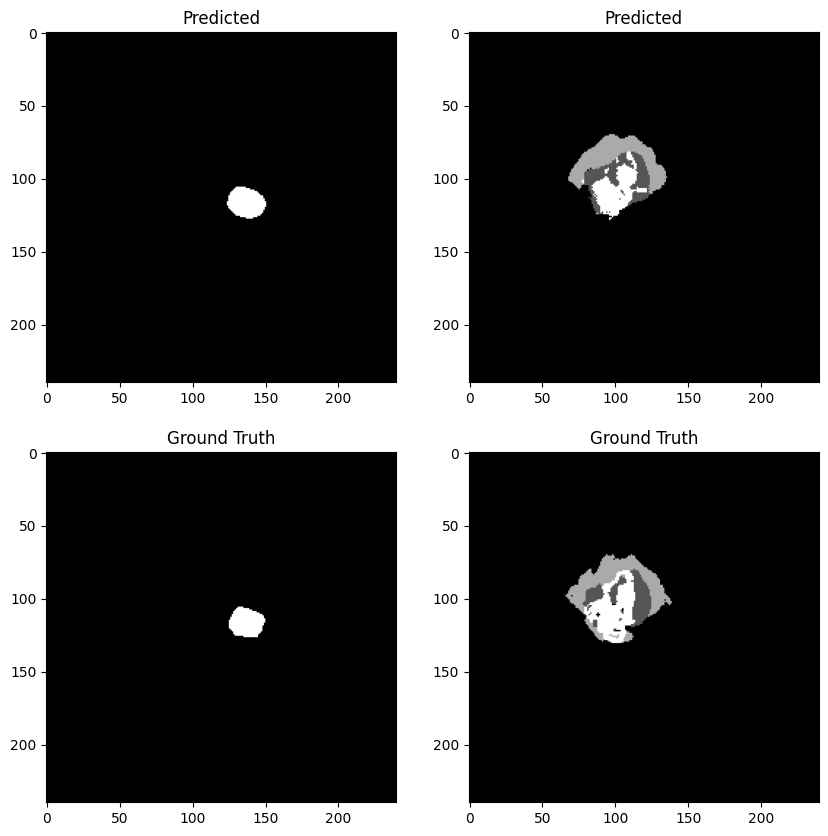

100%|██████████| 34/34 [04:55<00:00,  8.68s/it]


Average Validation Loss: 0.024310865110772496

Average Validation DSC: [0.99854889 0.71298063 0.88571419 0.62915068]
Average Validation ASSD: [ 0.24391916 52.15789009 16.54464909 29.5638857 ]
Epoch 25/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


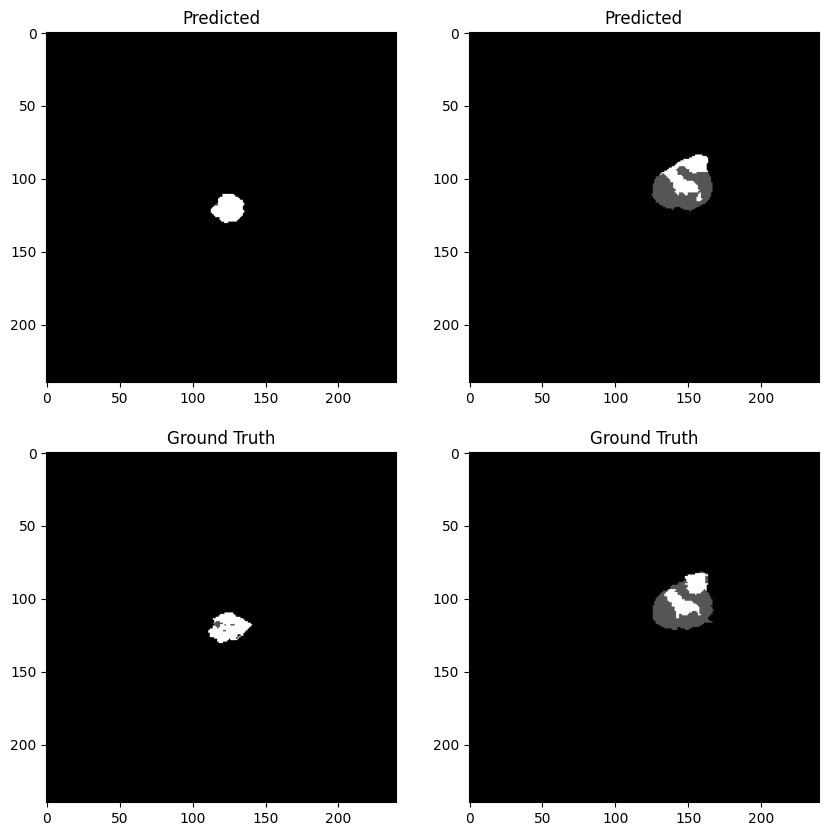

100%|██████████| 136/136 [19:56<00:00,  8.80s/it]



Average Training Loss: 0.020279866026933577

Average Training DSC: [0.9987118  0.74215739 0.85404714 0.64432139]
Average Training ASSD: [ 0.22540684 51.72947543 32.08347797 31.96870901]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


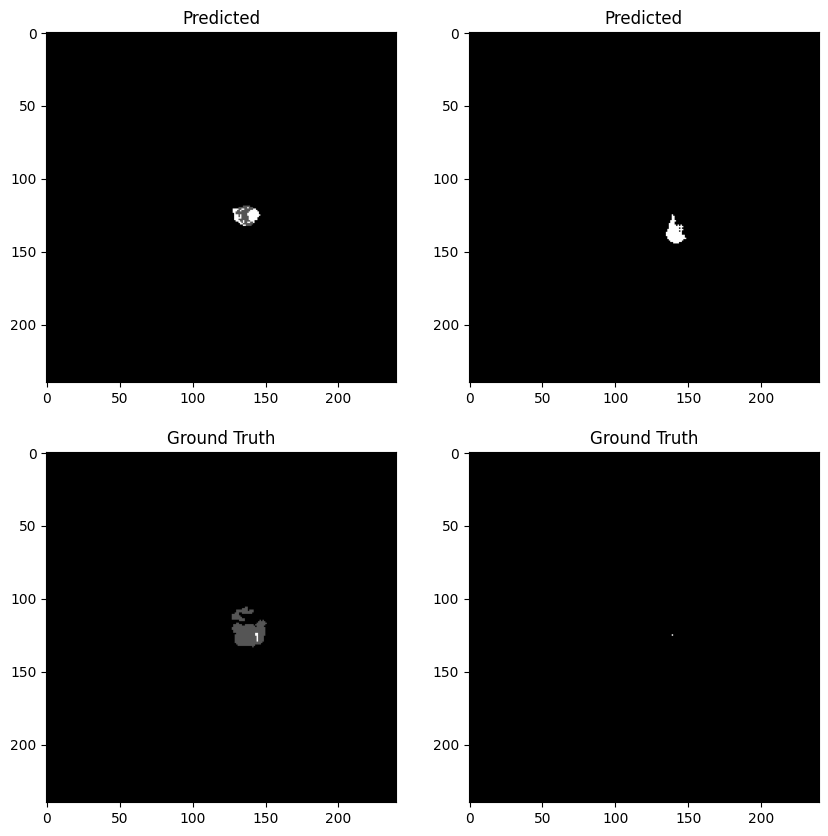

100%|██████████| 34/34 [04:54<00:00,  8.67s/it]


Average Validation Loss: 0.024016453391488862

Average Validation DSC: [0.99837414 0.70681148 0.87191678 0.5769161 ]
Average Validation ASSD: [ 0.30953779 62.89715765 19.66677394 44.66782173]
Epoch 26/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


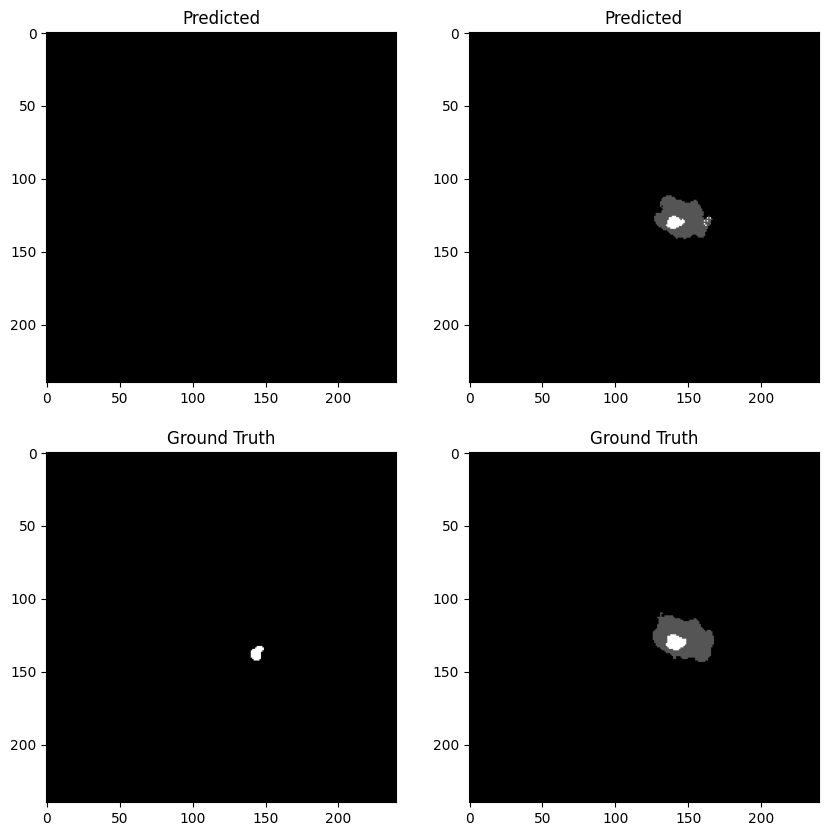

100%|██████████| 136/136 [20:11<00:00,  8.91s/it]



Average Training Loss: 0.021751488915041965

Average Training DSC: [0.99856503 0.71798661 0.83939177 0.62247775]
Average Training ASSD: [ 0.26862802 56.41179213 34.8185198  35.82852614]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


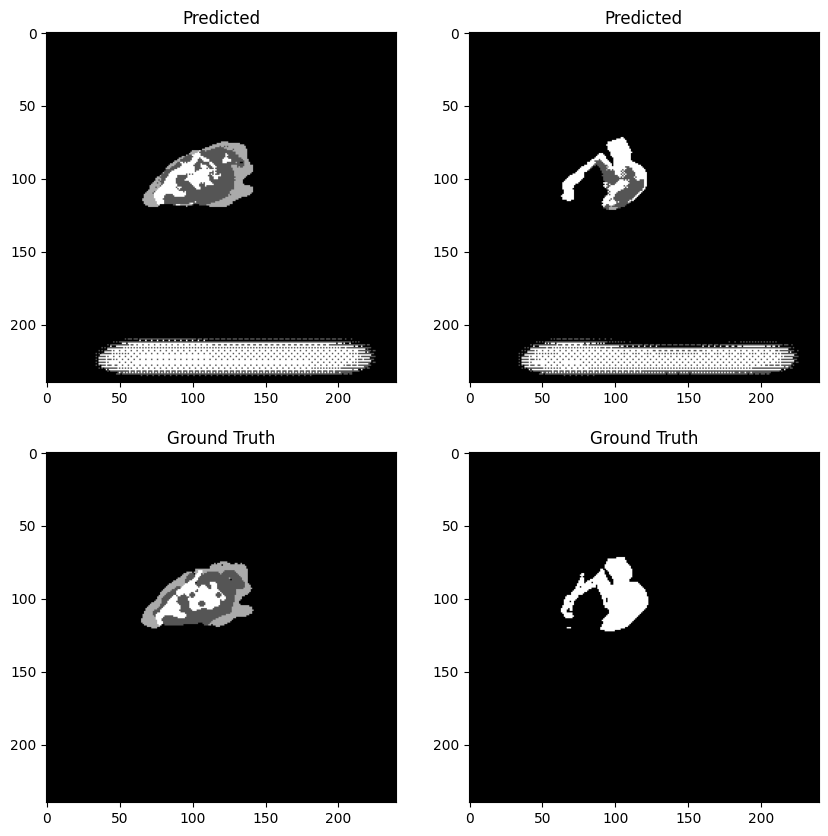

100%|██████████| 34/34 [04:52<00:00,  8.61s/it]


Average Validation Loss: 1.5582868106224959

Average Validation DSC: [0.97117873 0.21626874 0.66871292 0.19482122]
Average Validation ASSD: [  3.5890627  189.09653606  87.77755168  58.5766436 ]
Epoch 27/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


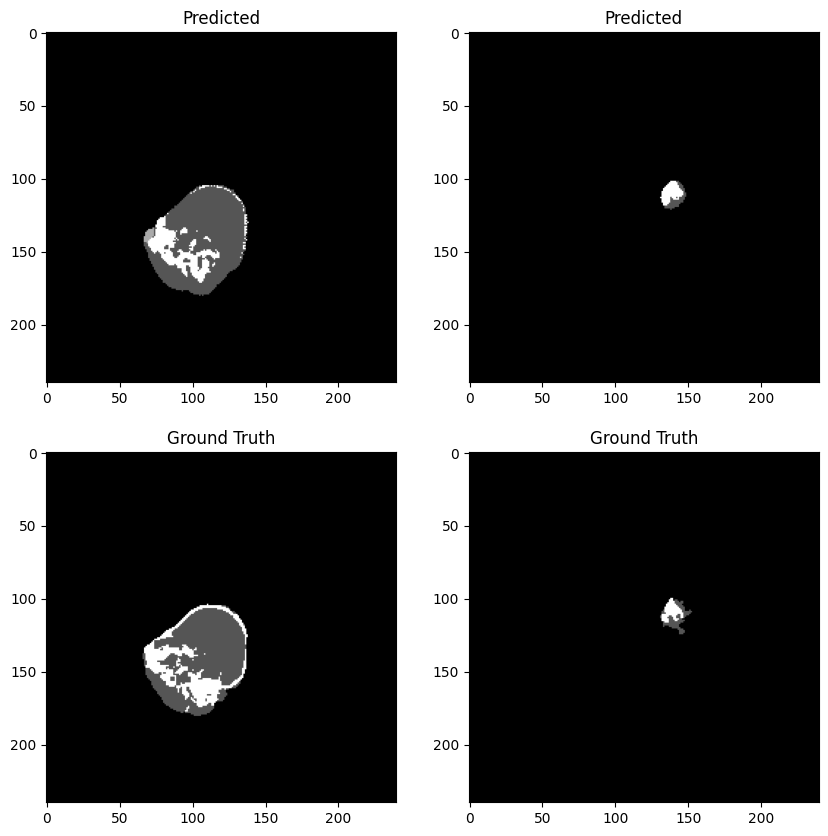

100%|██████████| 136/136 [19:11<00:00,  8.46s/it]



Average Training Loss: 0.021043906084207052

Average Training DSC: [0.998558   0.72476024 0.83727872 0.62610687]
Average Training ASSD: [ 0.2541849  55.18257104 36.34234655 32.54016809]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


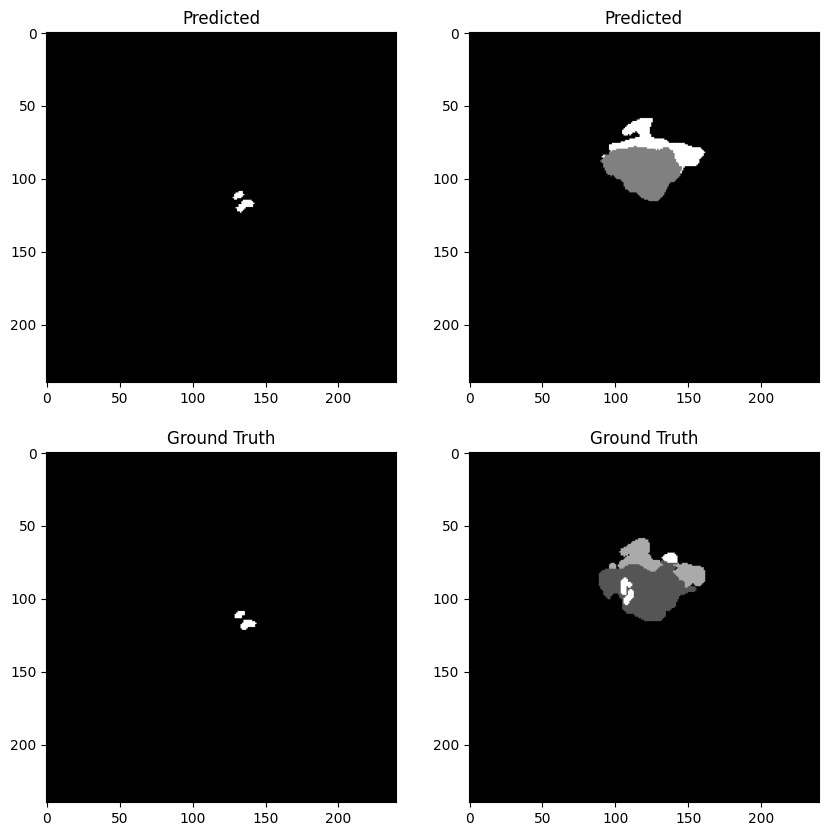

100%|██████████| 34/34 [04:34<00:00,  8.08s/it]


Average Validation Loss: 0.02067327020032441

Average Validation DSC: [0.99866639 0.77408995 0.89152036 0.65516297]
Average Validation ASSD: [ 0.2258172  39.90017318 15.3865695  29.97142571]
Epoch 28/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


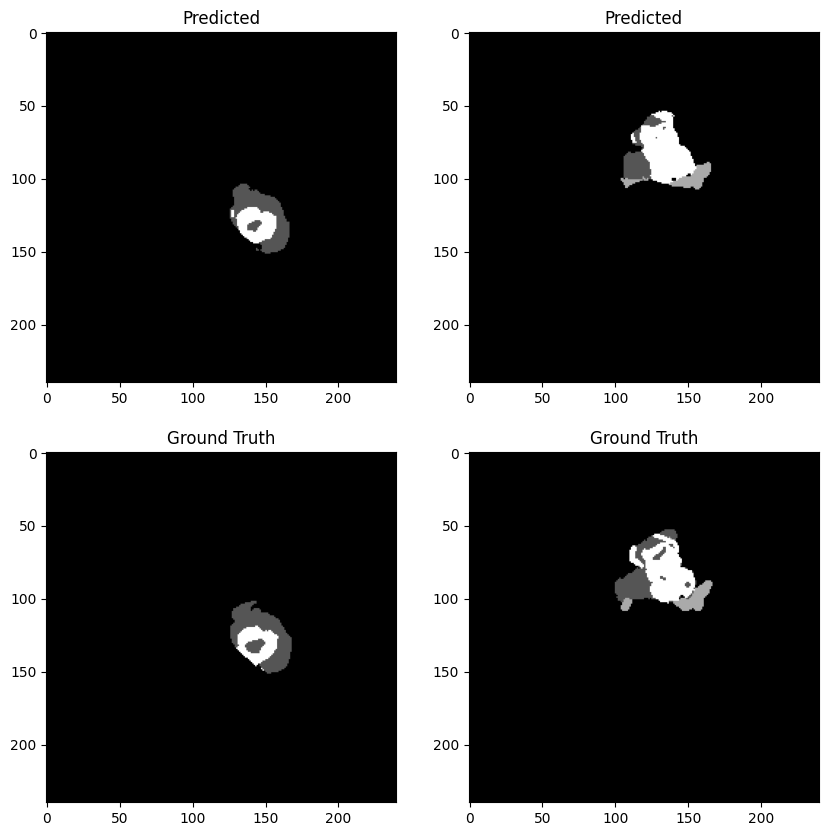

100%|██████████| 136/136 [18:44<00:00,  8.27s/it]



Average Training Loss: 0.01713100733810707

Average Training DSC: [0.99875971 0.788463   0.88500285 0.66152459]
Average Training ASSD: [ 0.21313502 39.40230313 20.93452379 33.44231903]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


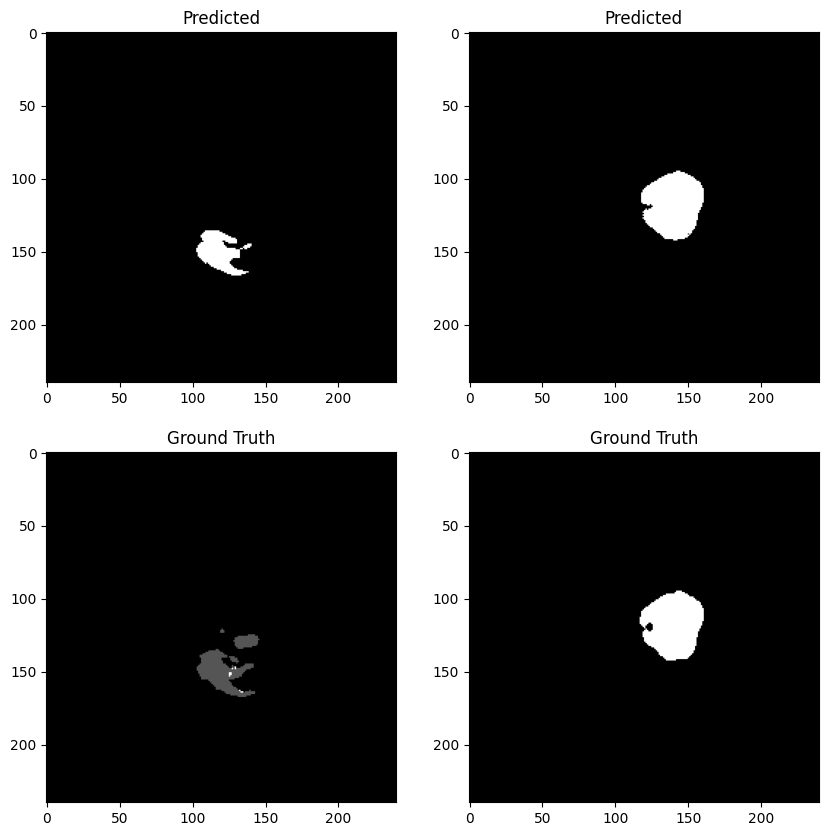

100%|██████████| 34/34 [04:29<00:00,  7.93s/it]


Average Validation Loss: 0.02034493554931353

Average Validation DSC: [0.99877036 0.76329318 0.89660572 0.67169664]
Average Validation ASSD: [ 0.20671842 47.00254875 15.0437423  33.93342571]
Epoch 29/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


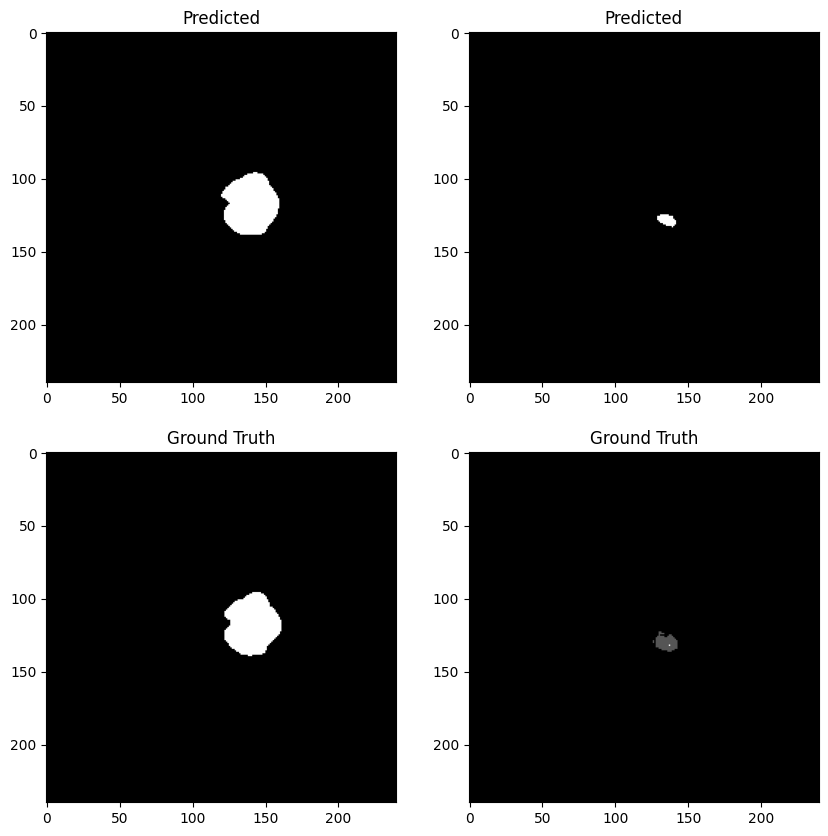

100%|██████████| 136/136 [17:50<00:00,  7.87s/it]



Average Training Loss: 0.015365415636230917

Average Training DSC: [0.99886286 0.81758531 0.89563736 0.6822483 ]
Average Training ASSD: [ 0.18640754 30.37144059 19.1028997  30.7602581 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


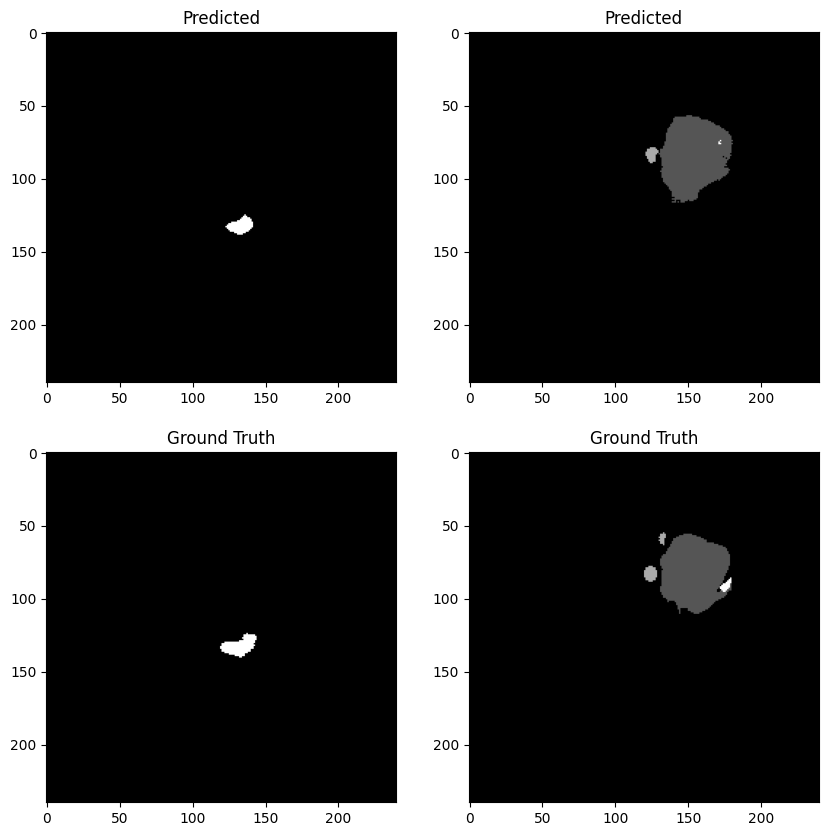

100%|██████████| 34/34 [04:57<00:00,  8.74s/it]


Average Validation Loss: 0.020188441007014585

Average Validation DSC: [0.99882206 0.79699184 0.88992164 0.63155272]
Average Validation ASSD: [ 0.19331137 35.88690829 18.94186199 37.79051041]
Epoch 30/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


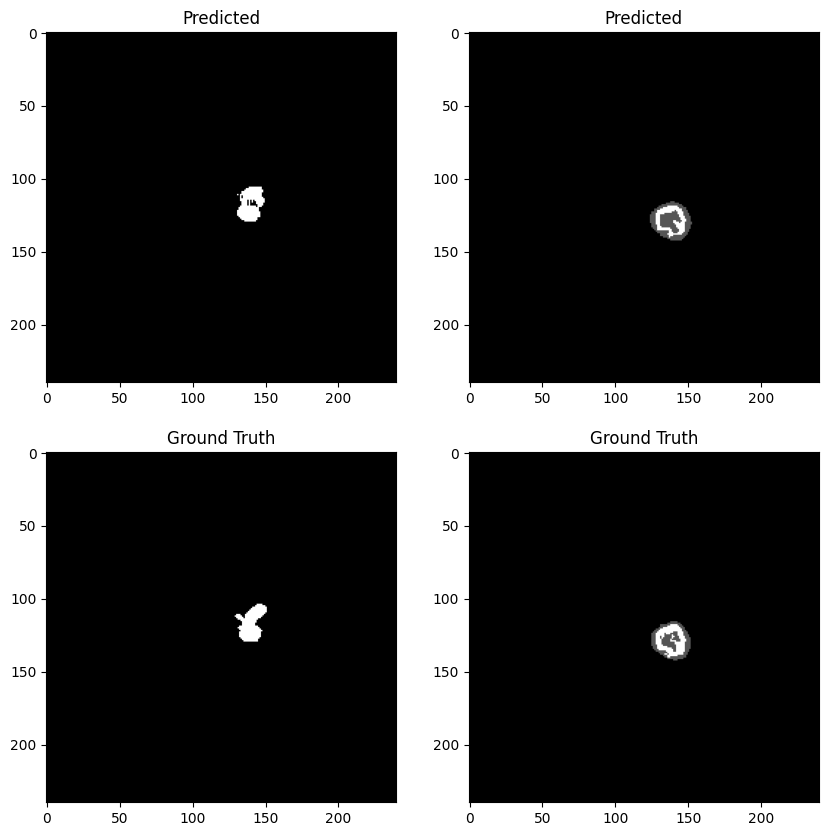

100%|██████████| 136/136 [20:42<00:00,  9.13s/it]



Average Training Loss: 0.014688628718859571

Average Training DSC: [0.9988671  0.83091587 0.89546164 0.68846364]
Average Training ASSD: [ 0.19058995 27.18499164 19.0114638  31.50383069]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


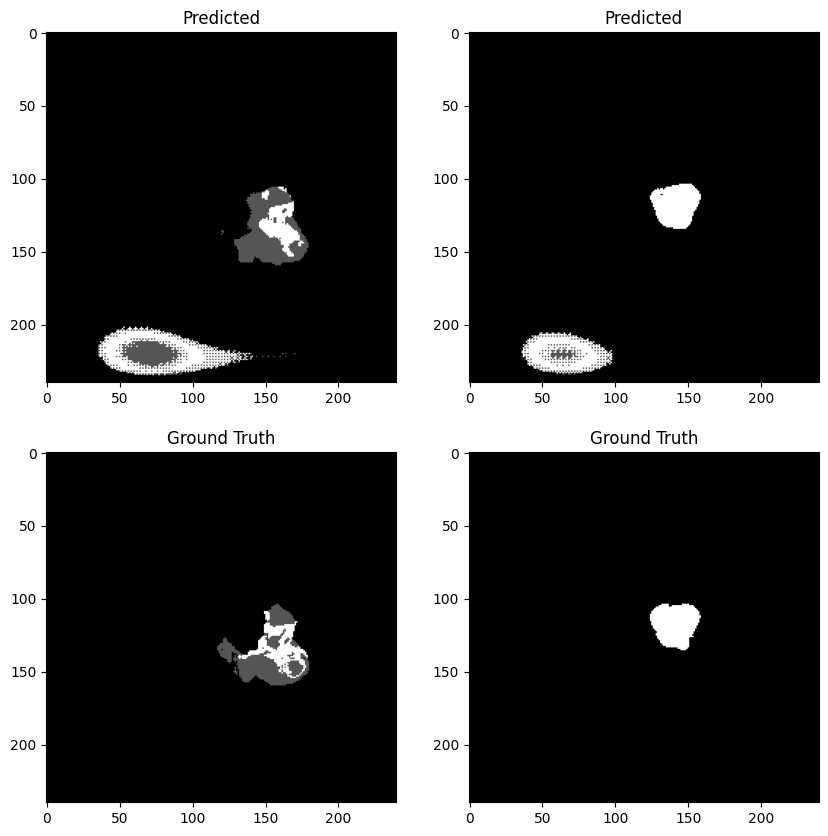

100%|██████████| 34/34 [04:50<00:00,  8.54s/it]


Average Validation Loss: 2.2486412630361667

Average Validation DSC: [0.98119302 0.31378149 0.89630525 0.30395817]
Average Validation ASSD: [  1.78139632 183.36237258  16.33057221  51.22585718]
Epoch 31/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


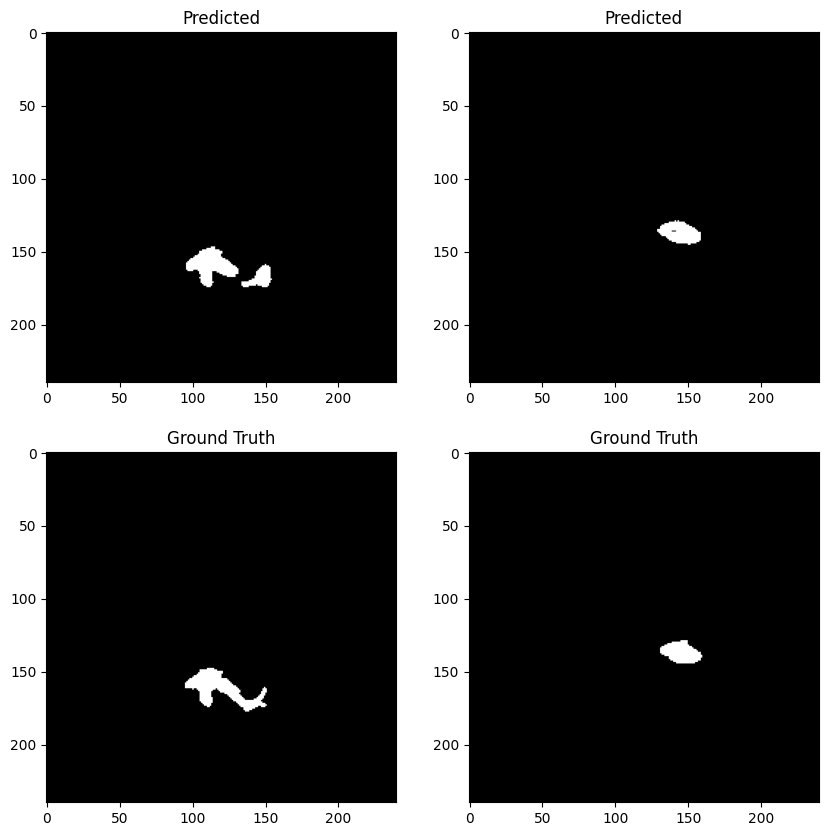

100%|██████████| 136/136 [20:43<00:00,  9.15s/it]



Average Training Loss: 0.014134003150769892

Average Training DSC: [0.99890274 0.82482454 0.90202472 0.694139  ]
Average Training ASSD: [ 0.18179492 29.8390675  17.37930896 30.45029457]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


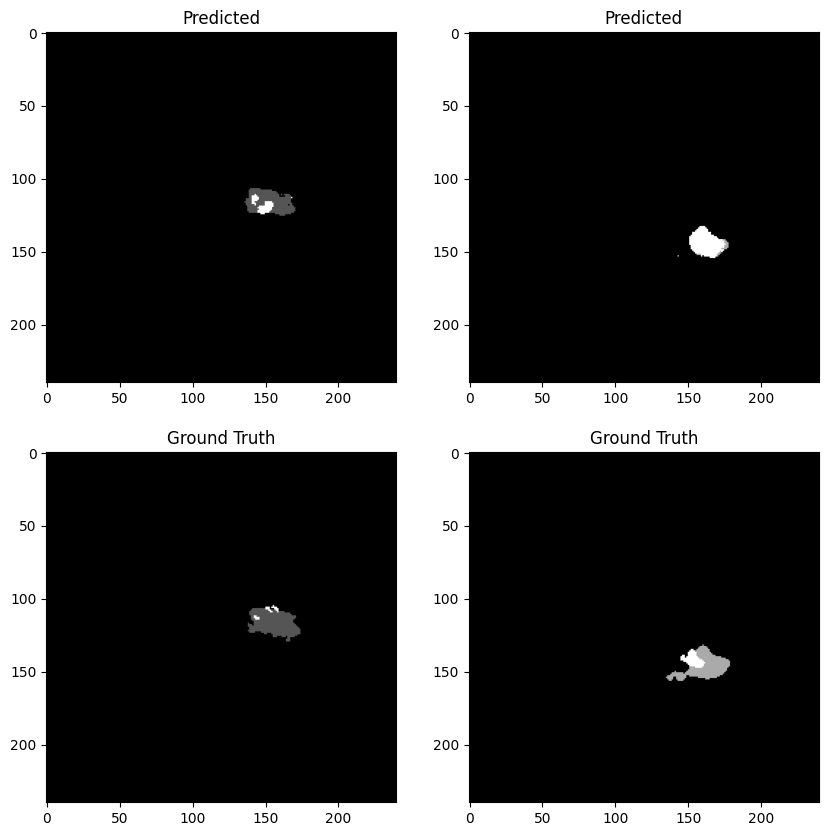

100%|██████████| 34/34 [04:52<00:00,  8.62s/it]


Average Validation Loss: 0.02114978846272125

Average Validation DSC: [0.99861022 0.7711787  0.89708283 0.66203763]
Average Validation ASSD: [ 0.23406085 33.16215995 12.76271672 25.94667321]
Epoch 32/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


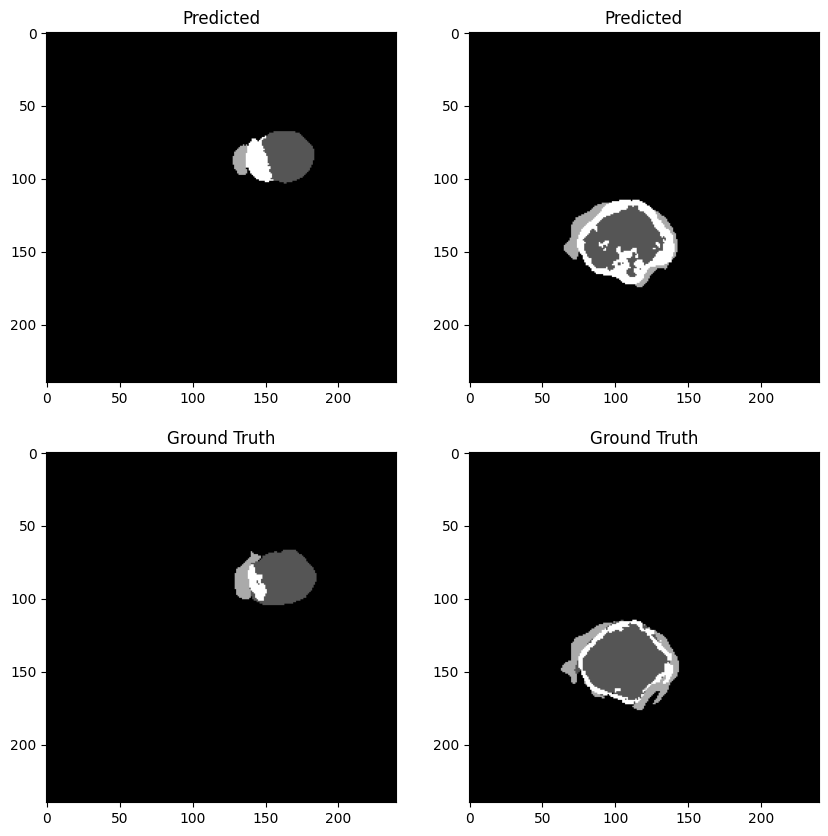

100%|██████████| 136/136 [20:18<00:00,  8.96s/it]



Average Training Loss: 0.014228697078685989

Average Training DSC: [0.99883841 0.82978697 0.89129561 0.68825236]
Average Training ASSD: [ 0.19026686 27.54758966 20.10318886 31.84178704]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


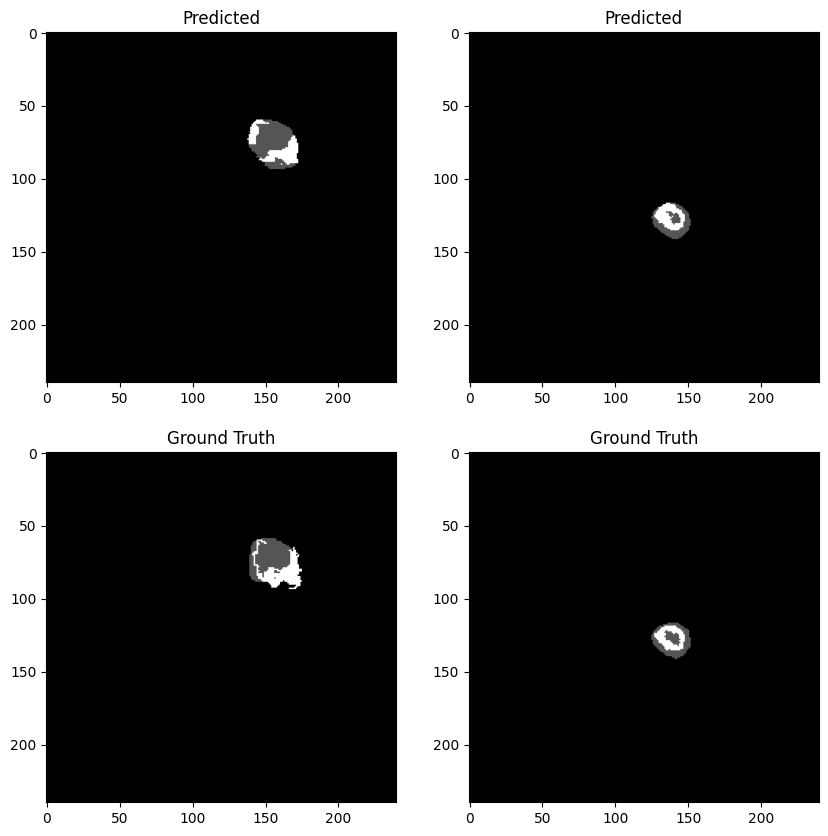

100%|██████████| 34/34 [04:54<00:00,  8.67s/it]


Average Validation Loss: 0.017190815634368098

Average Validation DSC: [0.99885152 0.82261728 0.90506069 0.69343921]
Average Validation ASSD: [ 0.17466838 29.36517261 14.82920969 27.05002677]
Epoch 33/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


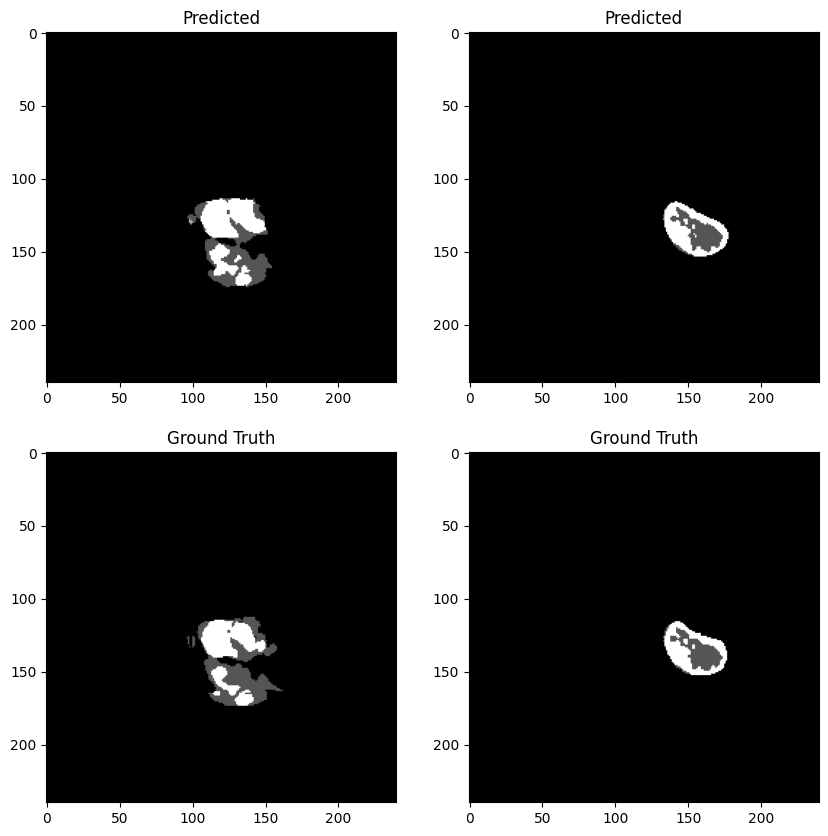

100%|██████████| 136/136 [20:31<00:00,  9.06s/it]



Average Training Loss: 0.01265646387850318

Average Training DSC: [0.99895012 0.84920625 0.90436212 0.70525293]
Average Training ASSD: [ 0.17164877 22.724082   17.46519707 29.61744117]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


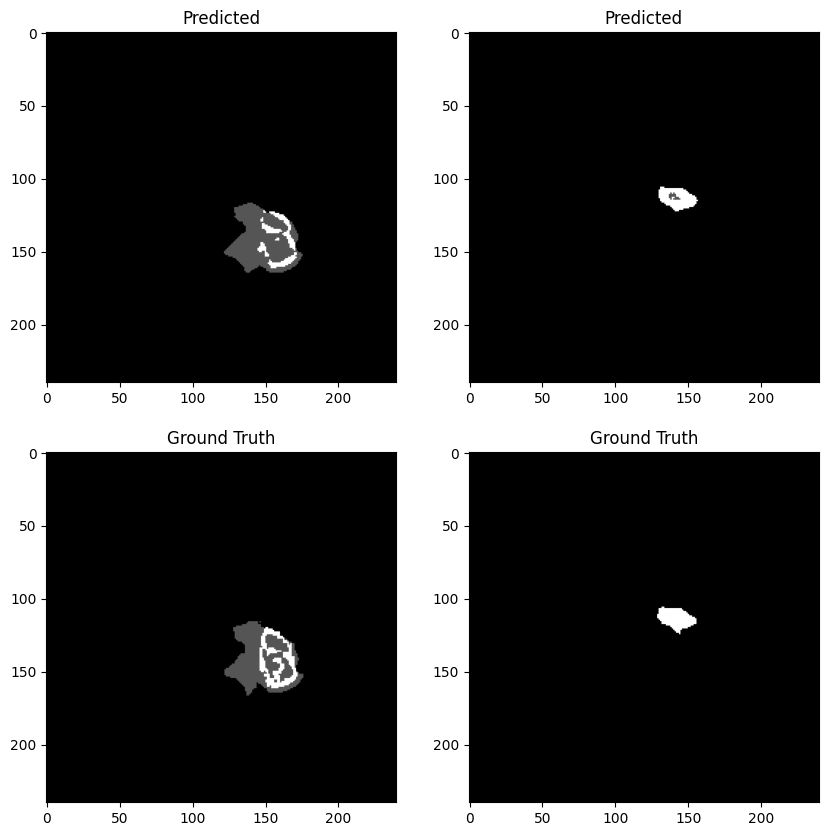

100%|██████████| 34/34 [04:56<00:00,  8.73s/it]


Average Validation Loss: 0.016997294746996724

Average Validation DSC: [0.99884157 0.79434125 0.86939997 0.67289324]
Average Validation ASSD: [ 0.1725777  39.82595522 28.64975592 31.65824554]
Epoch 34/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


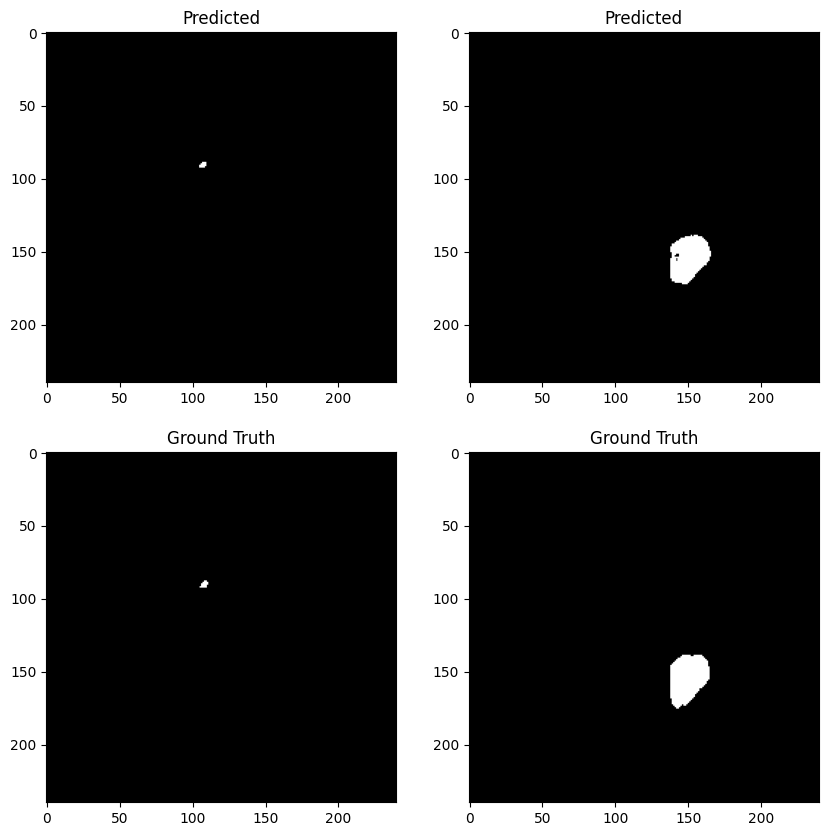

100%|██████████| 136/136 [21:07<00:00,  9.32s/it]



Average Training Loss: 0.012765790828887154

Average Training DSC: [0.99895594 0.84405662 0.90550947 0.70422549]
Average Training ASSD: [ 0.16041723 23.17792815 16.48757717 28.54536142]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


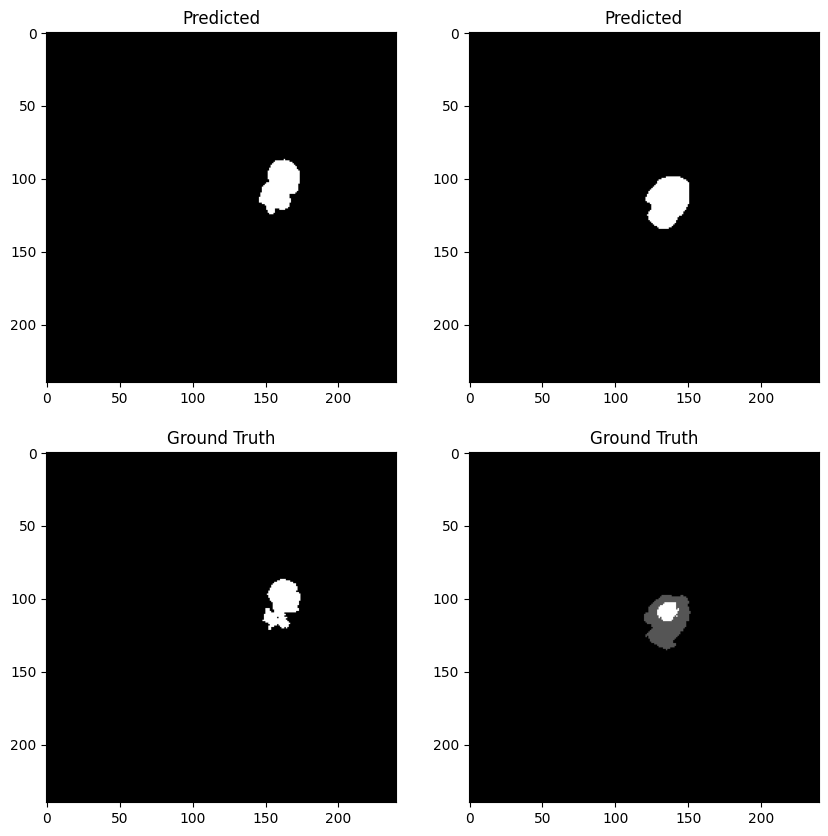

100%|██████████| 34/34 [04:42<00:00,  8.31s/it]


Average Validation Loss: 0.017364251920405555

Average Validation DSC: [0.99894285 0.74856932 0.90727542 0.62834115]
Average Validation ASSD: [ 0.15741175 51.81953183 13.34009278 38.83853502]
Epoch 35/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


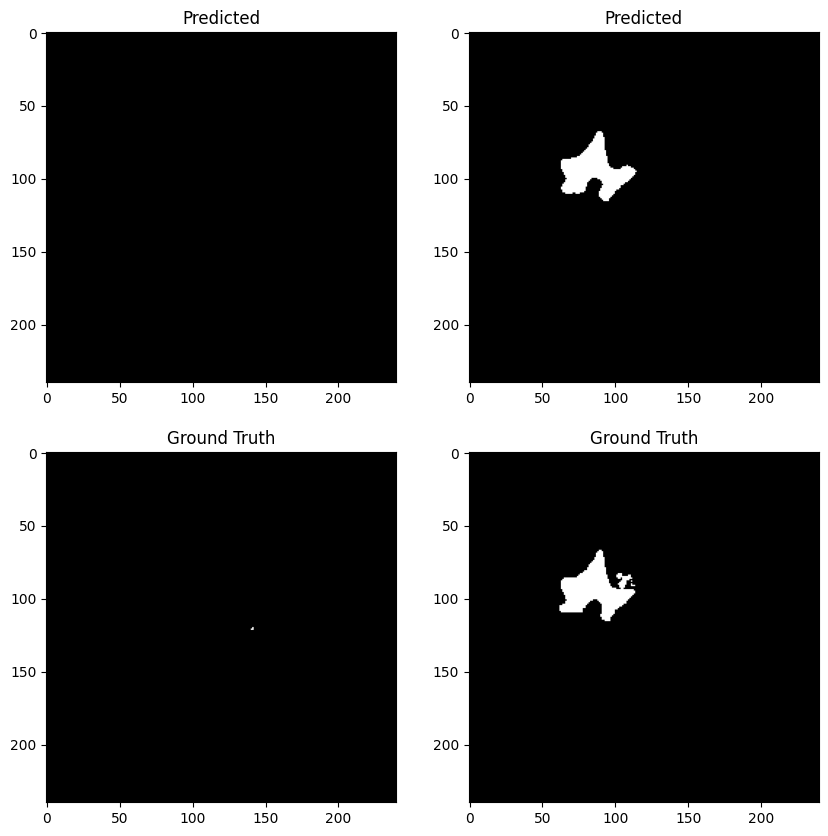

100%|██████████| 136/136 [20:12<00:00,  8.92s/it]



Average Training Loss: 0.012343349229708752

Average Training DSC: [0.99895236 0.83963575 0.90383577 0.70901164]
Average Training ASSD: [ 0.16205314 25.490585   17.76638063 30.35966477]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


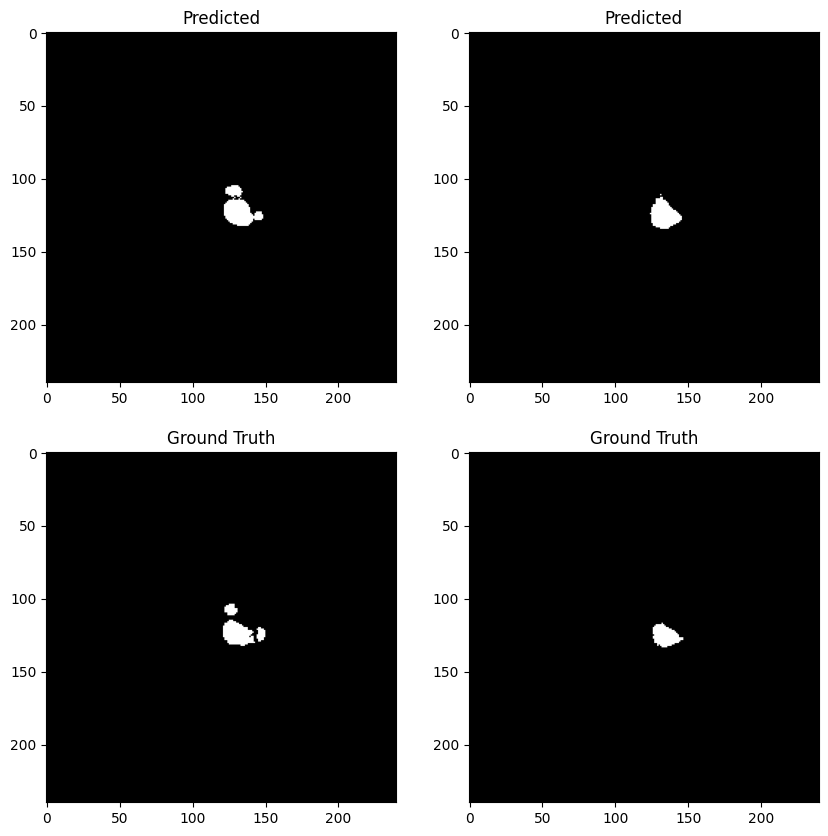

100%|██████████| 34/34 [04:58<00:00,  8.78s/it]


Average Validation Loss: 0.017451895948718574

Average Validation DSC: [0.99887065 0.83924081 0.91011266 0.66679451]
Average Validation ASSD: [ 0.17698443 22.72568304 13.83176876 33.78139997]
Epoch 36/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


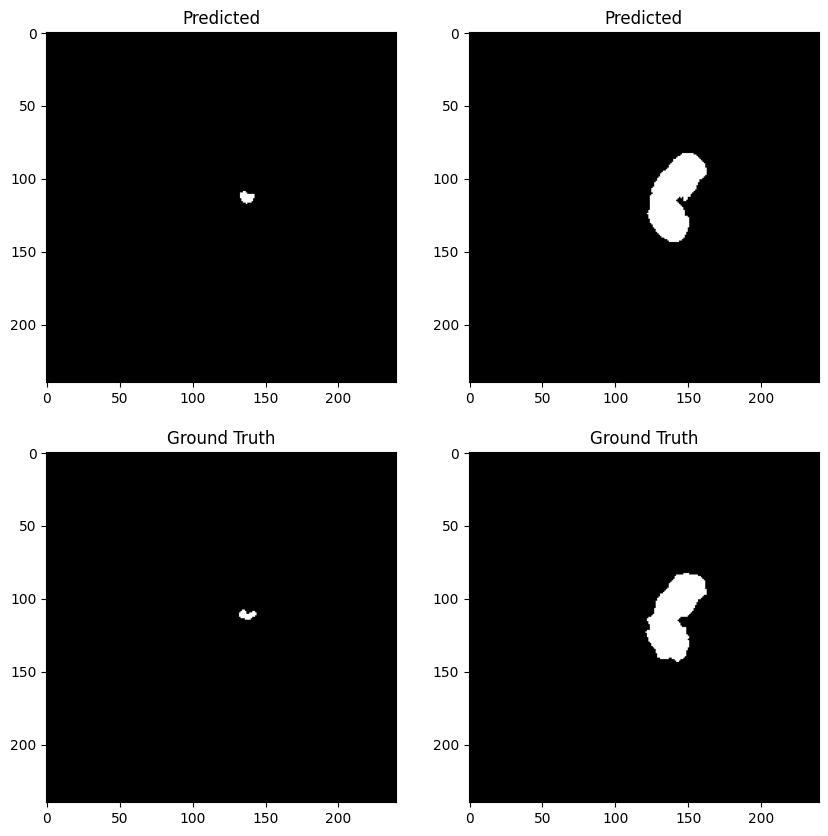

100%|██████████| 136/136 [20:43<00:00,  9.14s/it]



Average Training Loss: 0.011380076305666828

Average Training DSC: [0.9989873  0.86246224 0.91450597 0.71841178]
Average Training ASSD: [ 0.15654737 18.89898078 14.20437659 28.05044204]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


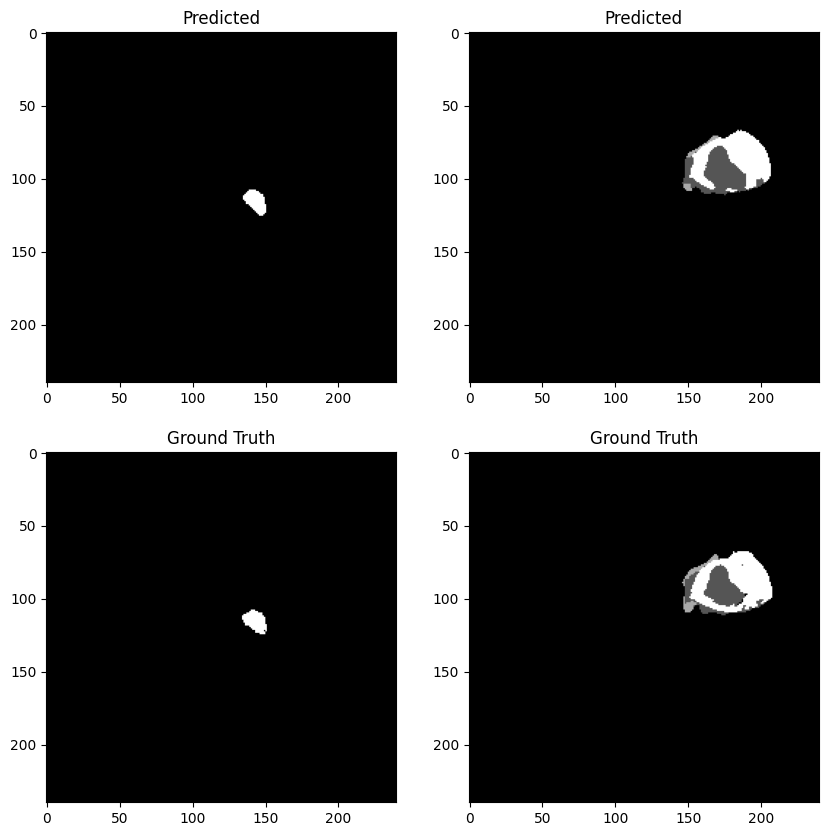

100%|██████████| 34/34 [04:53<00:00,  8.63s/it]


Average Validation Loss: 0.016448380809058163

Average Validation DSC: [0.99890613 0.83869694 0.91364072 0.7084879 ]
Average Validation ASSD: [ 0.16207017 22.12031174  9.4364866  23.67332882]
Epoch 37/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


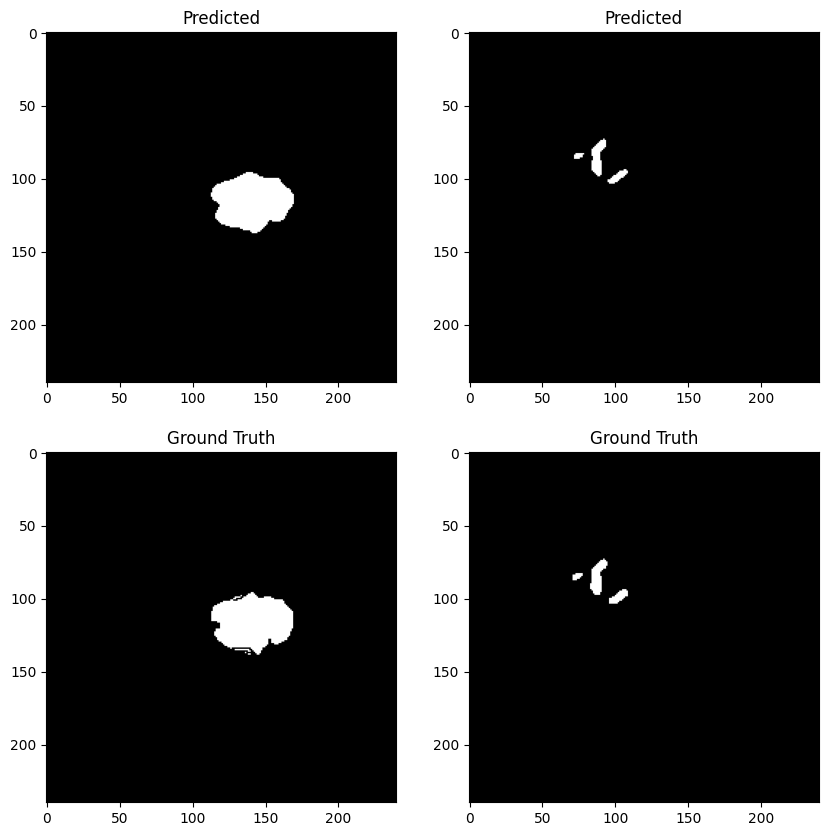

100%|██████████| 136/136 [20:20<00:00,  8.97s/it]



Average Training Loss: 0.010670779539984377

Average Training DSC: [0.99903137 0.87216092 0.91600994 0.72632034]
Average Training ASSD: [ 0.14406908 17.02192591 13.89782088 27.15981542]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


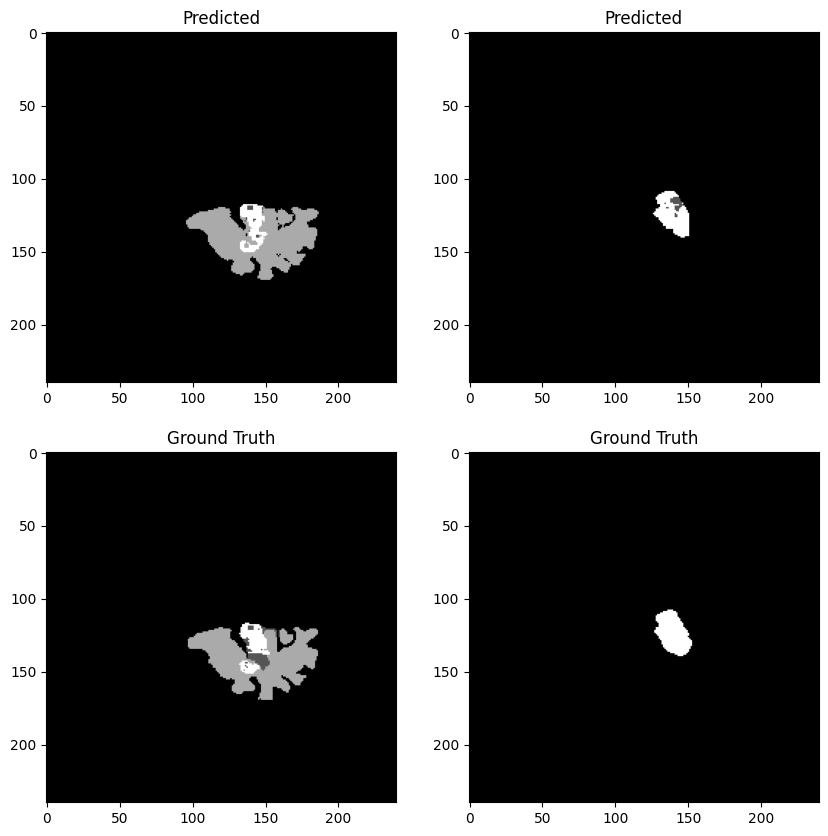

100%|██████████| 34/34 [04:44<00:00,  8.38s/it]


Average Validation Loss: 0.015911119962658954

Average Validation DSC: [0.99896897 0.82948215 0.90563299 0.72908899]
Average Validation ASSD: [ 0.14314481 27.5085579  14.5146251  20.65456293]
Epoch 38/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


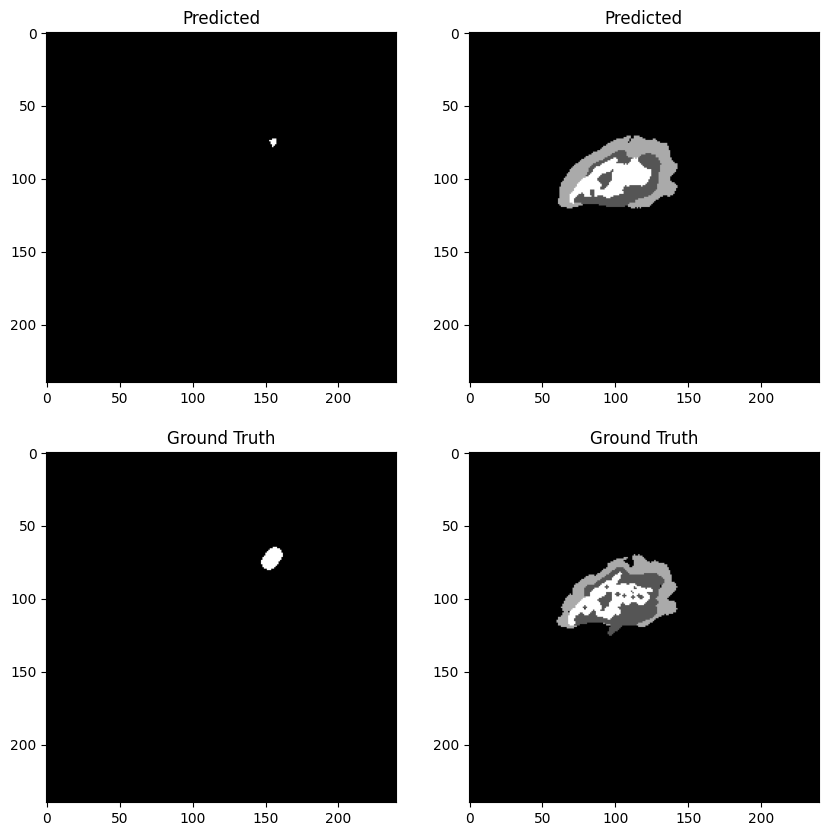

100%|██████████| 136/136 [20:45<00:00,  9.16s/it]



Average Training Loss: 0.011205749534864855

Average Training DSC: [0.99901827 0.86073991 0.90872273 0.7306145 ]
Average Training ASSD: [ 0.14973613 20.94045825 16.59987036 25.71794789]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


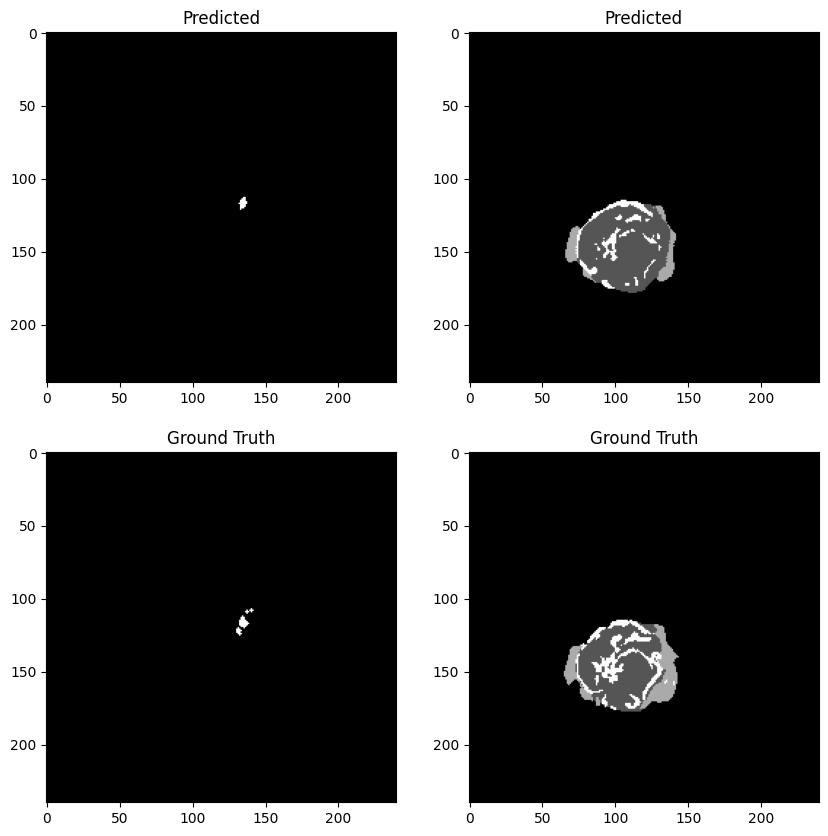

100%|██████████| 34/34 [04:57<00:00,  8.75s/it]


Average Validation Loss: 0.015013684655594476

Average Validation DSC: [0.99892395 0.83350976 0.91607307 0.70494877]
Average Validation ASSD: [ 0.16721506 23.47673708 11.23092675 26.77900431]
Epoch 39/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


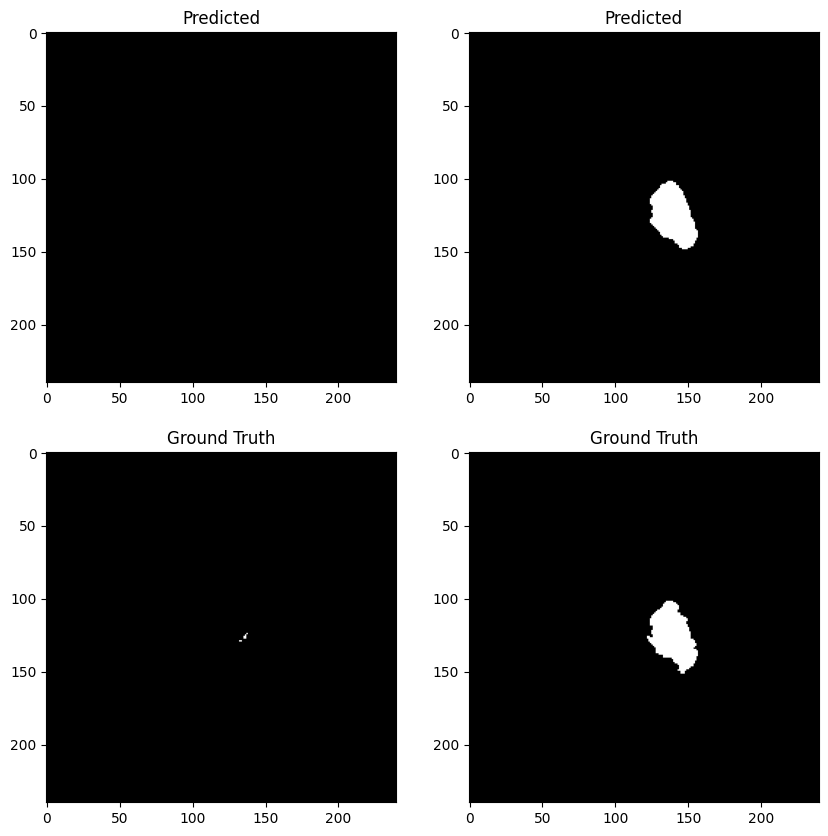

100%|██████████| 136/136 [20:16<00:00,  8.94s/it]



Average Training Loss: 0.07558668105561725

Average Training DSC: [0.99518371 0.53852602 0.63908133 0.36863352]
Average Training ASSD: [  1.45173769 103.96594397 101.06694733  75.10413495]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


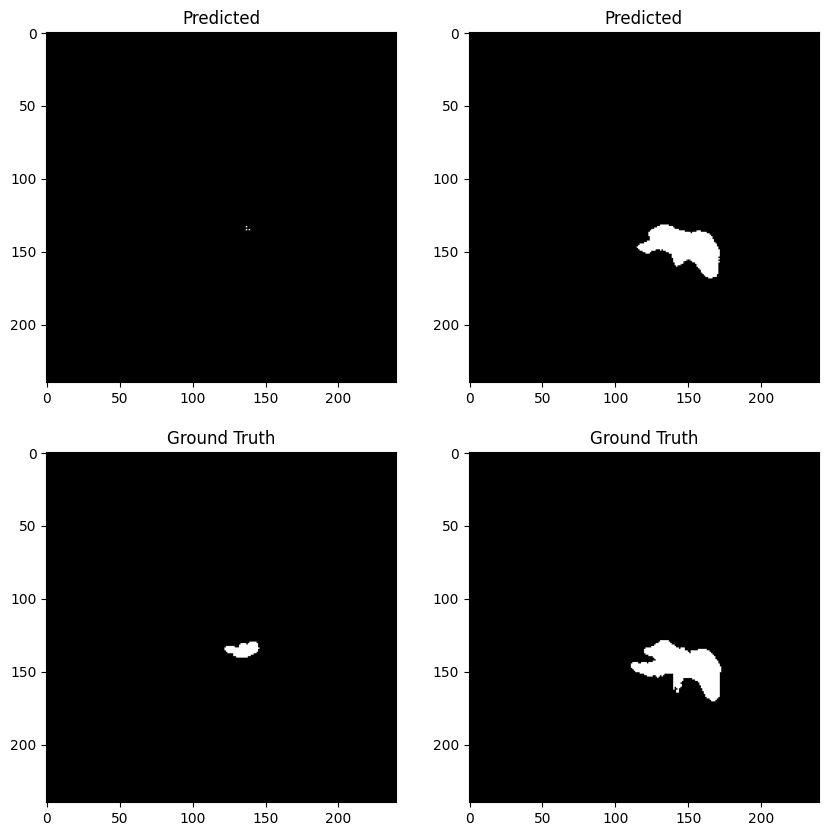

100%|██████████| 34/34 [04:57<00:00,  8.76s/it]


Average Validation Loss: 0.050633700783638394

Average Validation DSC: [0.99574587 0.4945543  0.62970695 0.29043874]
Average Validation ASSD: [  1.10433989 110.06275558  89.44087387  89.49440319]
Epoch 40/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


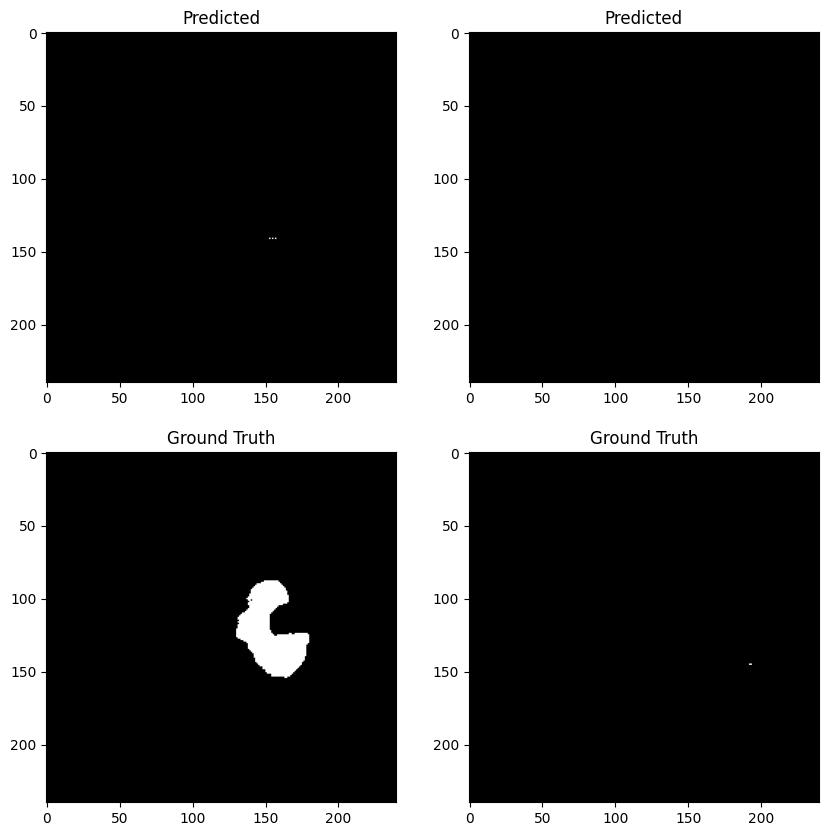

100%|██████████| 136/136 [20:02<00:00,  8.84s/it]



Average Training Loss: 0.0453866518321721

Average Training DSC: [0.9966925  0.48460633 0.65458533 0.37566174]
Average Training ASSD: [  0.71766964 102.67378181  89.90389472  55.90758533]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


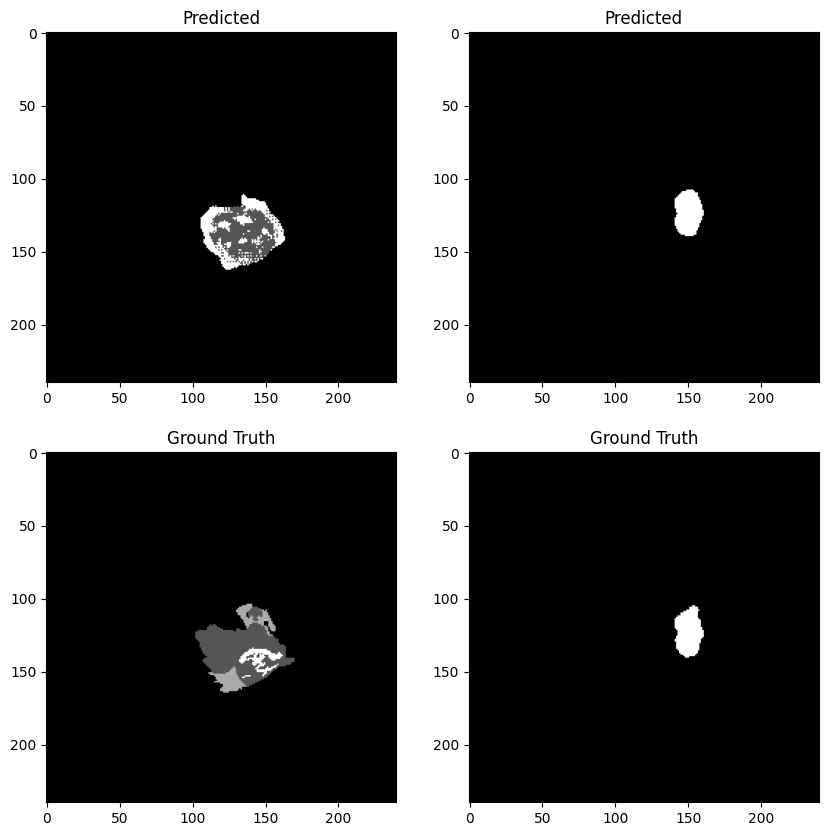

100%|██████████| 34/34 [05:03<00:00,  8.92s/it]


Average Validation Loss: 0.04000458855401067

Average Validation DSC: [0.99725992 0.49432249 0.65741409 0.41453179]
Average Validation ASSD: [  0.57672258 101.55900748  92.06383012  51.14898265]
Epoch 41/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


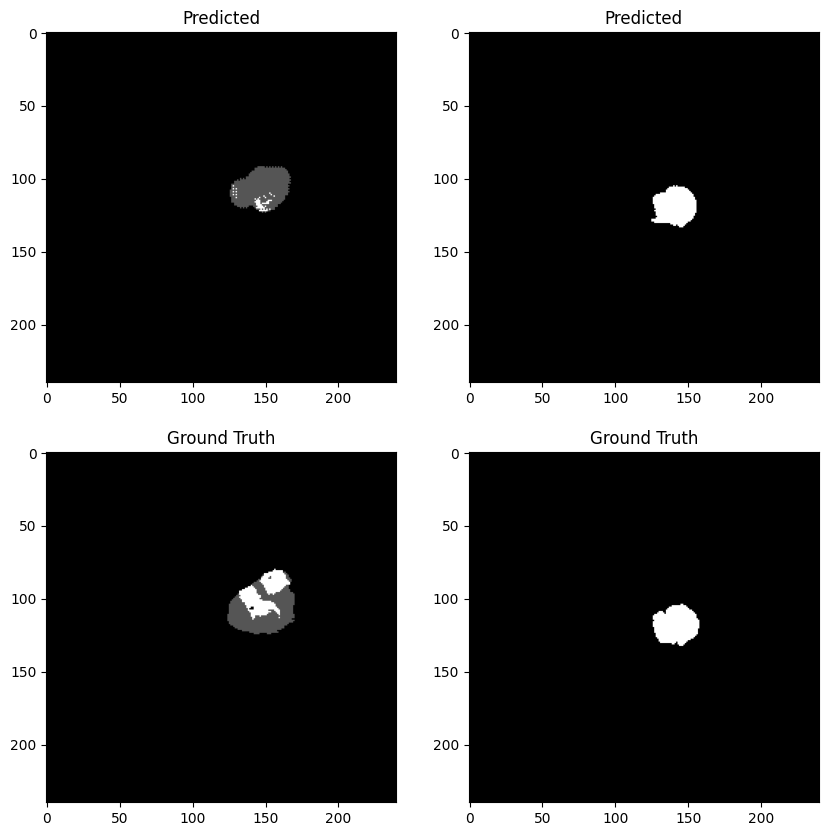

100%|██████████| 136/136 [20:30<00:00,  9.04s/it]



Average Training Loss: 0.03593022554345867

Average Training DSC: [0.99754665 0.49659547 0.60370839 0.42446816]
Average Training ASSD: [  0.47305494  98.83094041 106.59146124  41.45724095]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


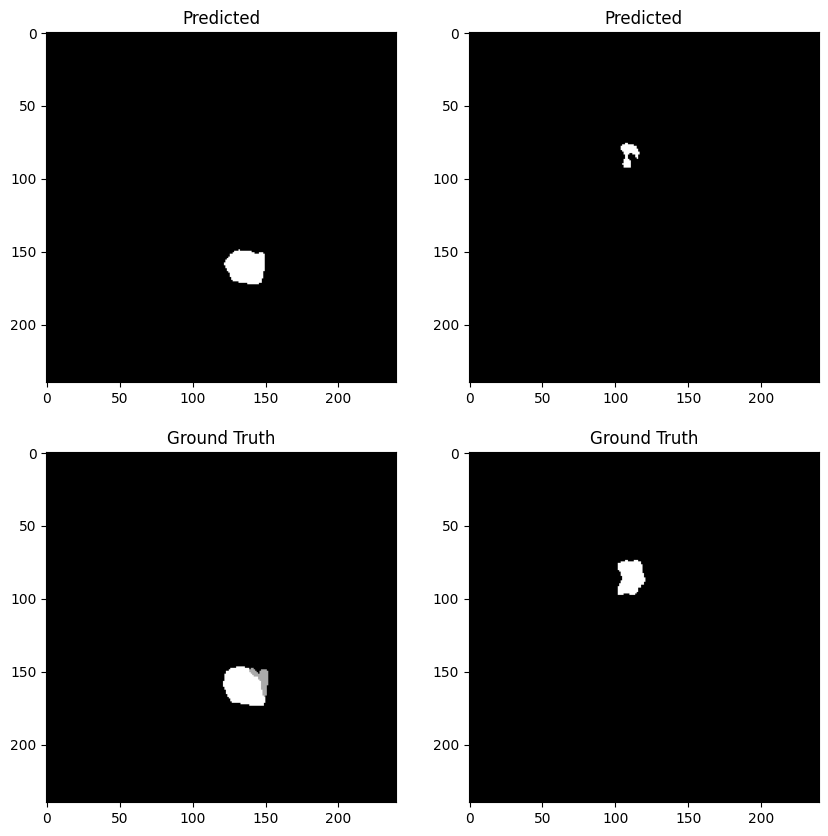

100%|██████████| 34/34 [05:15<00:00,  9.27s/it]


Average Validation Loss: 0.03657993148354923

Average Validation DSC: [0.99719702 0.50100223 0.5770456  0.43147629]
Average Validation ASSD: [  0.57305889  90.27577554 110.33523269  54.51897128]
Epoch 42/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


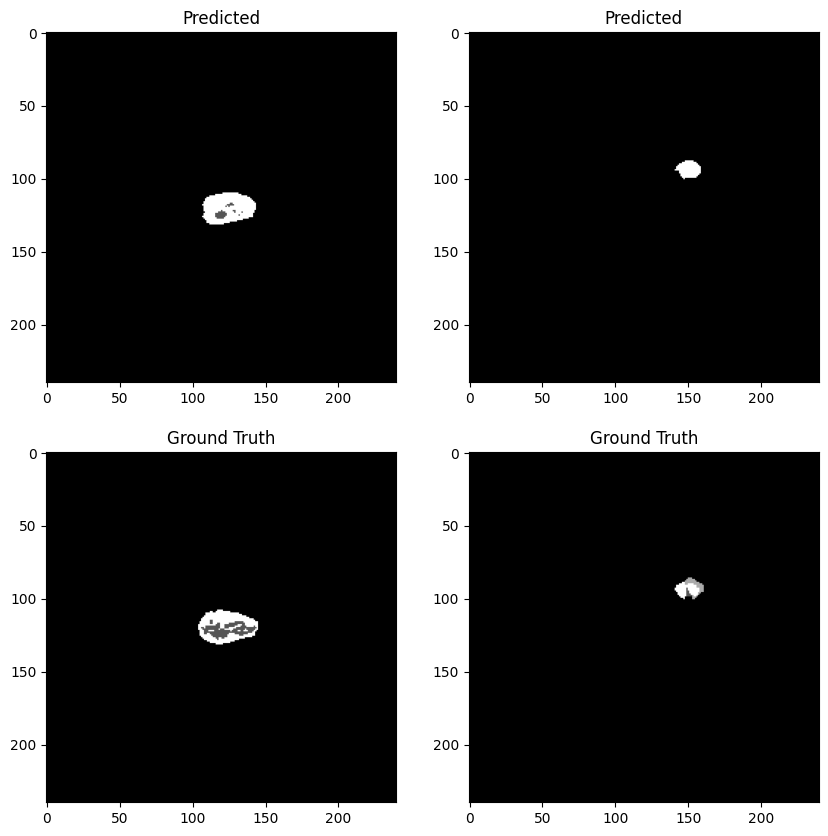

100%|██████████| 136/136 [20:36<00:00,  9.09s/it]



Average Training Loss: 0.03136923209325794

Average Training DSC: [0.9979452  0.51203283 0.56301201 0.45988347]
Average Training ASSD: [  0.38079283  94.45957182 117.20046424  37.44819392]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


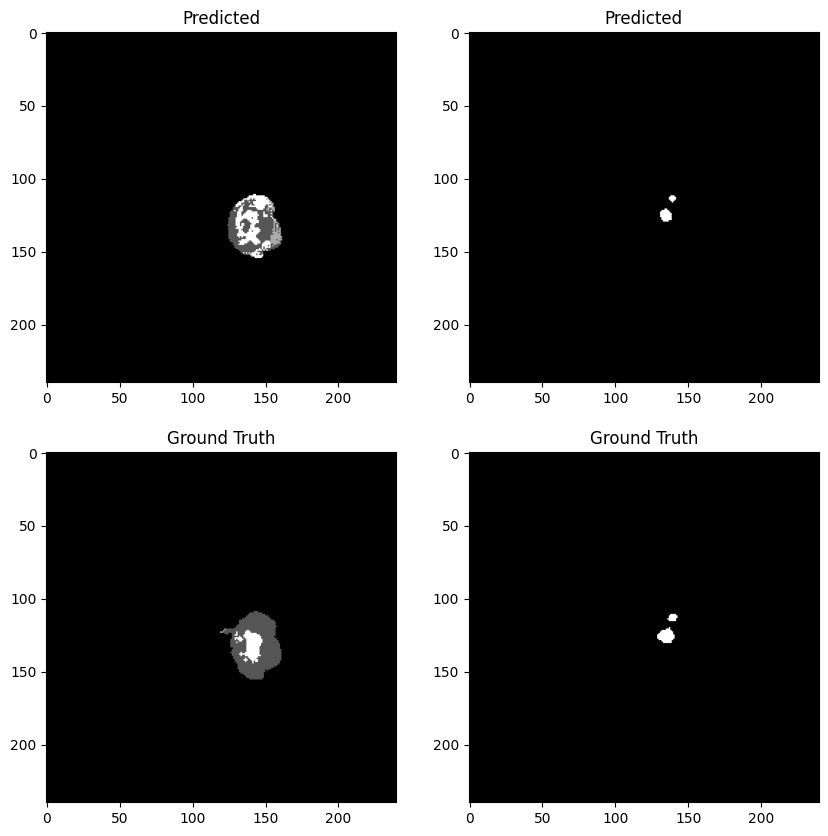

100%|██████████| 34/34 [04:54<00:00,  8.68s/it]


Average Validation Loss: 0.030886320013772037

Average Validation DSC: [0.99823107 0.47011336 0.57943276 0.51086135]
Average Validation ASSD: [  0.2770939  103.21342612 101.14624388  21.5908859 ]
Epoch 43/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


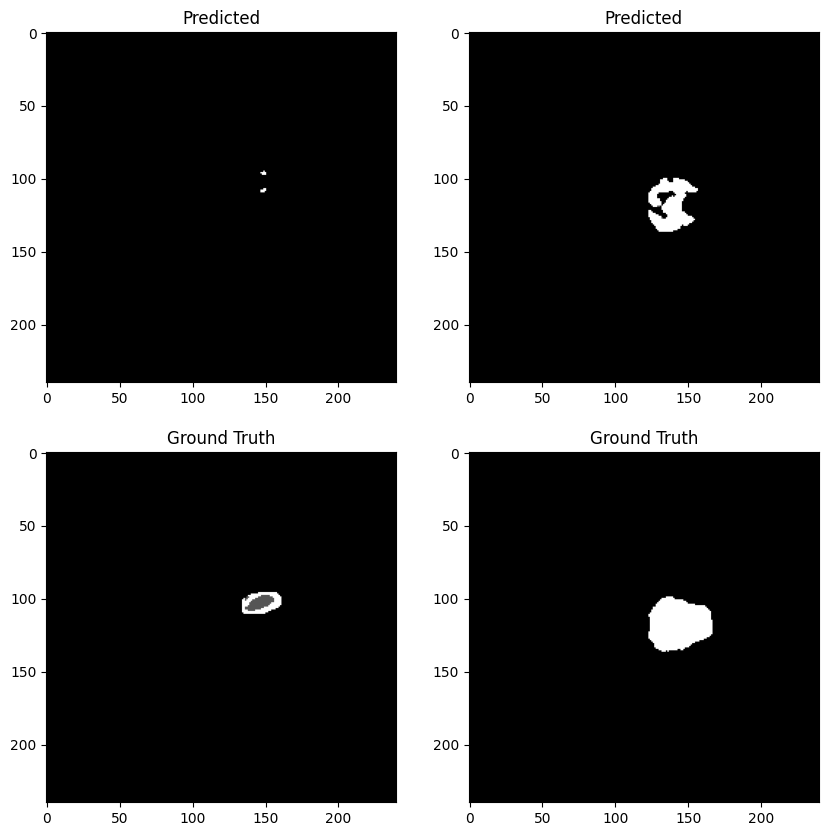

100%|██████████| 136/136 [21:04<00:00,  9.30s/it]



Average Training Loss: 0.02730078629546744

Average Training DSC: [0.99821009 0.53069967 0.50630491 0.50119844]
Average Training ASSD: [  0.3205114   94.2638581  129.47705339  35.51808224]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


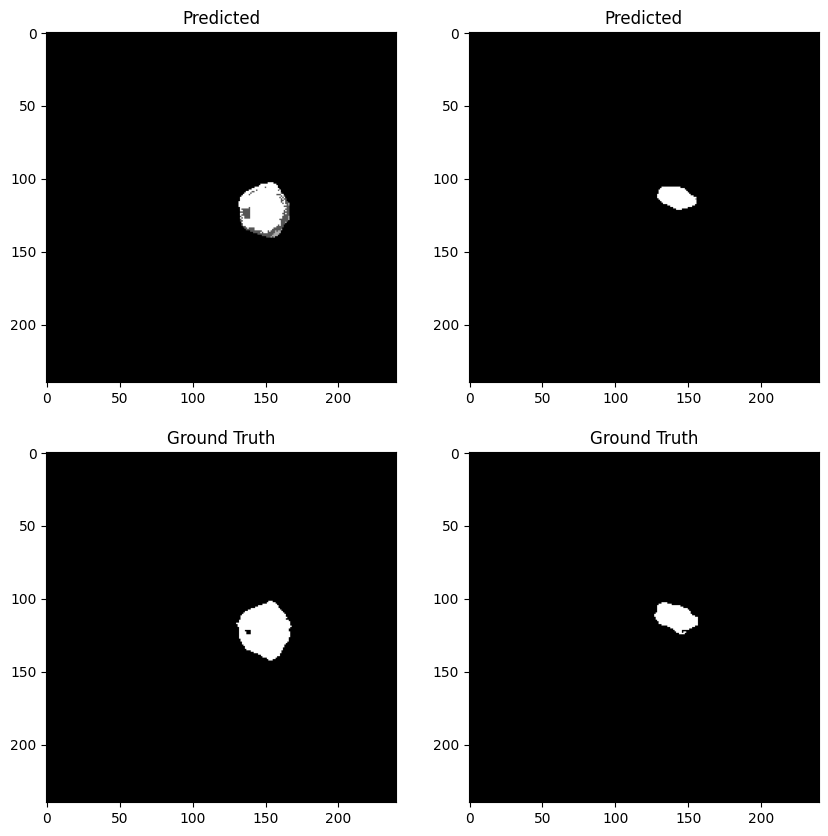

100%|██████████| 34/34 [05:11<00:00,  9.17s/it]


Average Validation Loss: 0.028179341543684986

Average Validation DSC: [0.99781461 0.57042542 0.55099799 0.47509873]
Average Validation ASSD: [  0.42591075  82.42216943 121.36773287  48.34040614]
Epoch 44/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


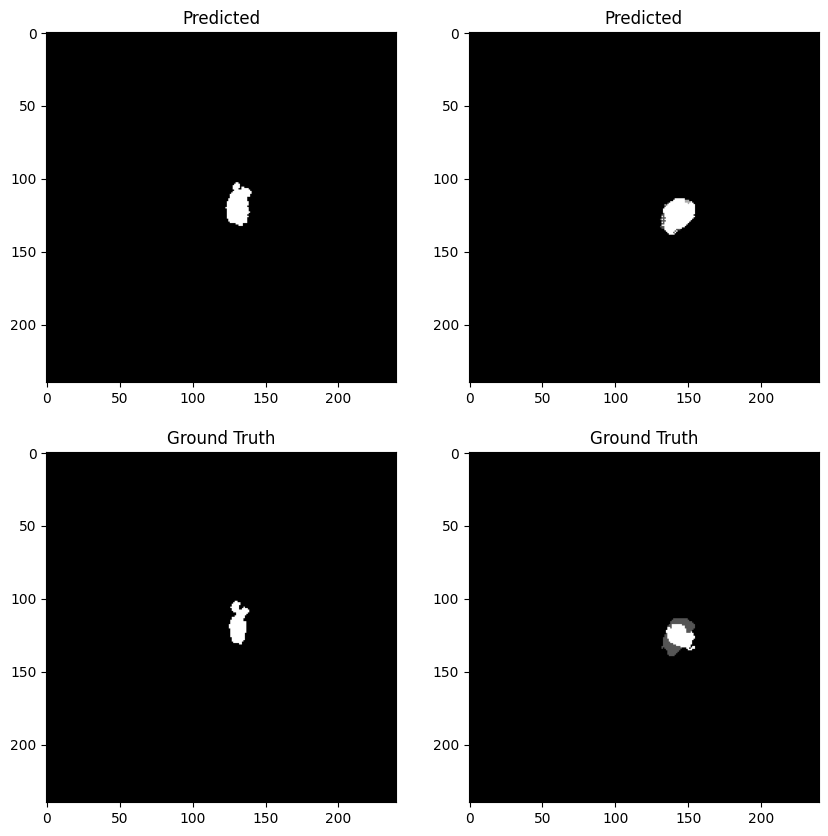

100%|██████████| 136/136 [21:12<00:00,  9.35s/it]



Average Training Loss: 0.02269259440329145

Average Training DSC: [0.99840041 0.58447908 0.68885009 0.54923404]
Average Training ASSD: [ 0.27482782 84.46335139 77.727866   31.62009648]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


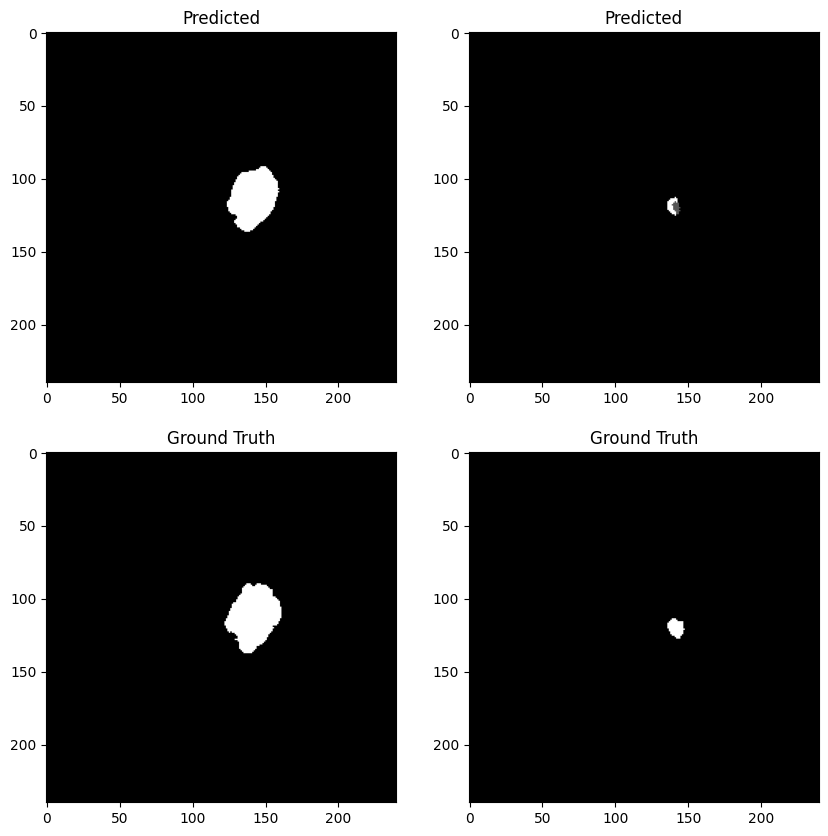

100%|██████████| 34/34 [05:18<00:00,  9.36s/it]


Average Validation Loss: 0.025999622802962277

Average Validation DSC: [0.99765711 0.59648781 0.75168048 0.50321675]
Average Validation ASSD: [ 0.39719075 74.56752652 53.82993082 39.65237129]
Epoch 45/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


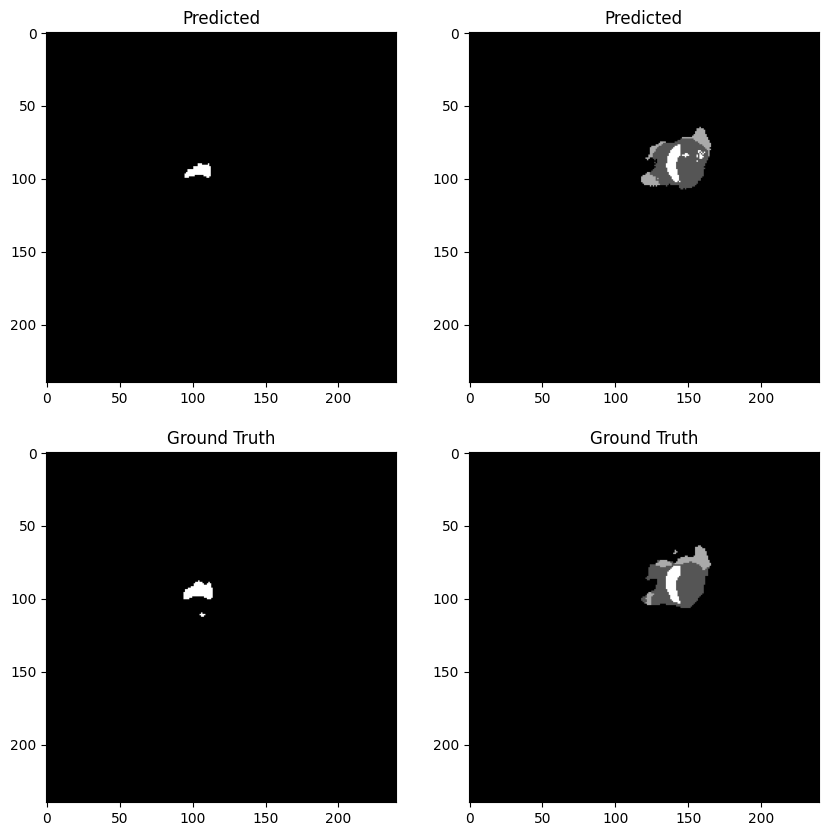

100%|██████████| 136/136 [21:14<00:00,  9.37s/it]



Average Training Loss: 0.02030543429667459

Average Training DSC: [0.9984238  0.61665241 0.80086703 0.58013884]
Average Training ASSD: [ 0.26306004 80.44729242 44.62956506 28.73837176]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


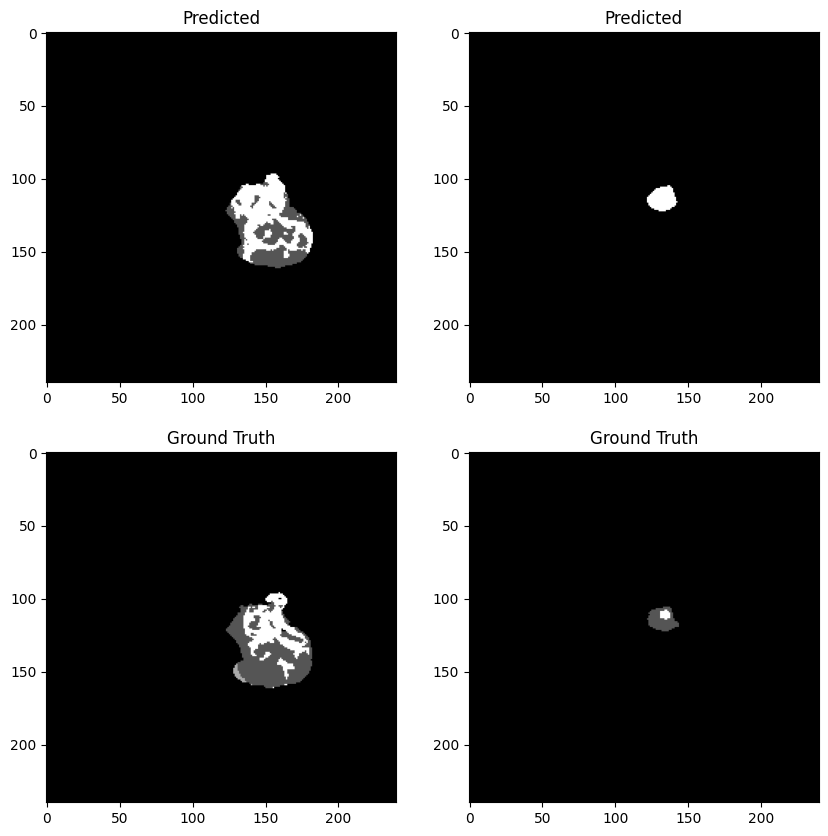

100%|██████████| 34/34 [05:08<00:00,  9.07s/it]


Average Validation Loss: 0.02242275108309353

Average Validation DSC: [0.9984777  0.52479587 0.84142634 0.60224138]
Average Validation ASSD: [  0.24661058 101.05806105  30.23607292  24.36558055]
Epoch 46/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


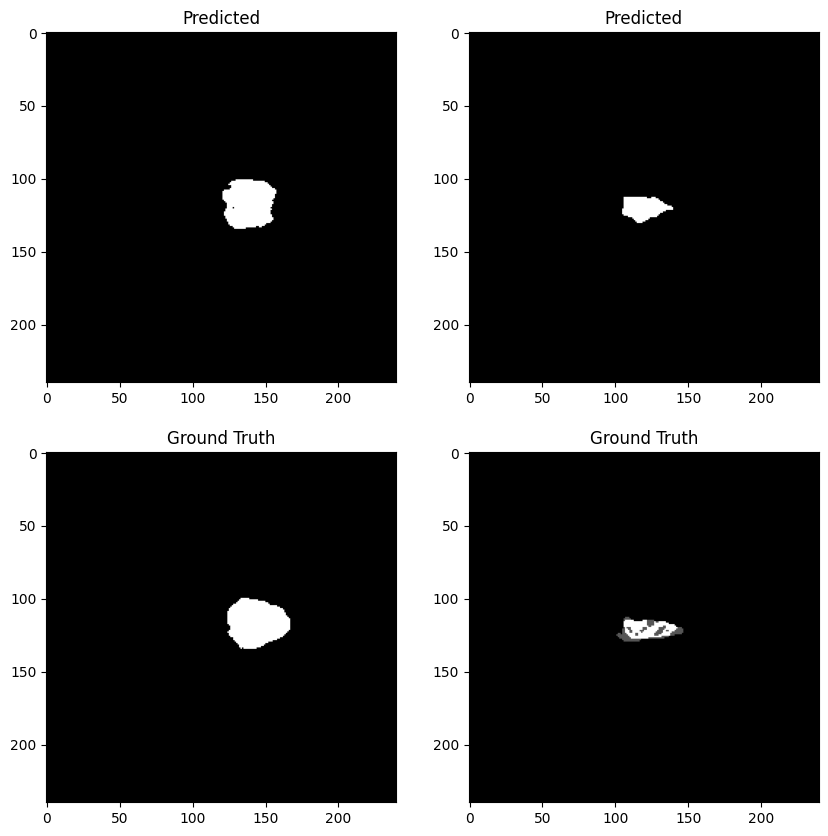

100%|██████████| 136/136 [21:10<00:00,  9.34s/it]



Average Training Loss: 0.01670369684614022

Average Training DSC: [0.99862251 0.69732228 0.83714336 0.61711765]
Average Training ASSD: [ 0.23258417 59.4317014  35.09749783 29.36965059]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


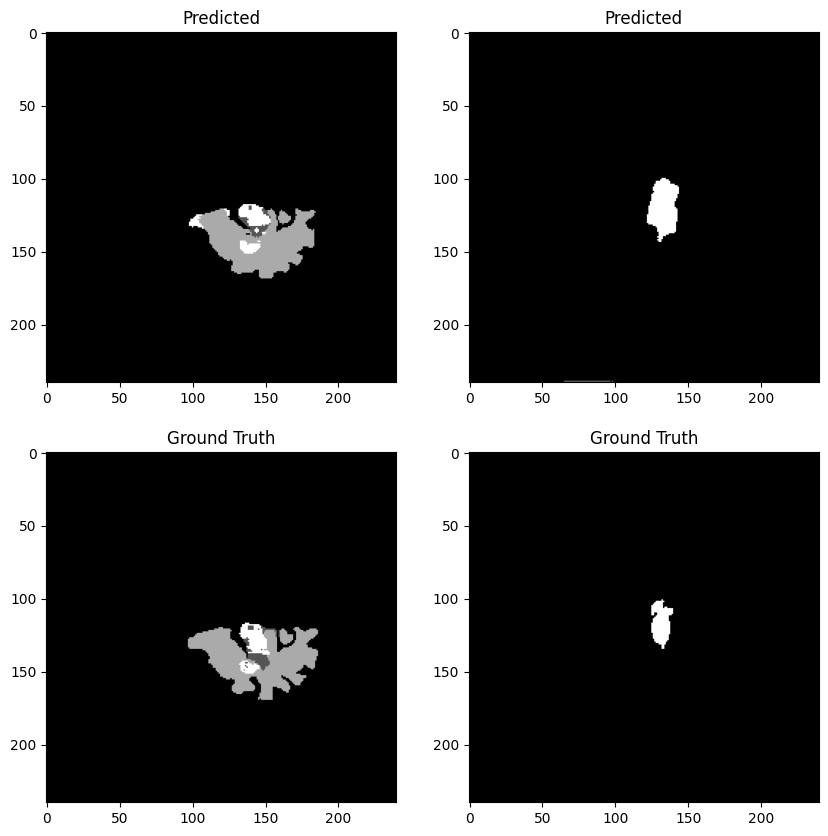

100%|██████████| 34/34 [05:22<00:00,  9.49s/it]


Average Validation Loss: 0.02193412496982252

Average Validation DSC: [0.99829889 0.58207387 0.85472869 0.58896115]
Average Validation ASSD: [ 0.24935958 90.71868258 27.61377183 16.16730967]
Epoch 47/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


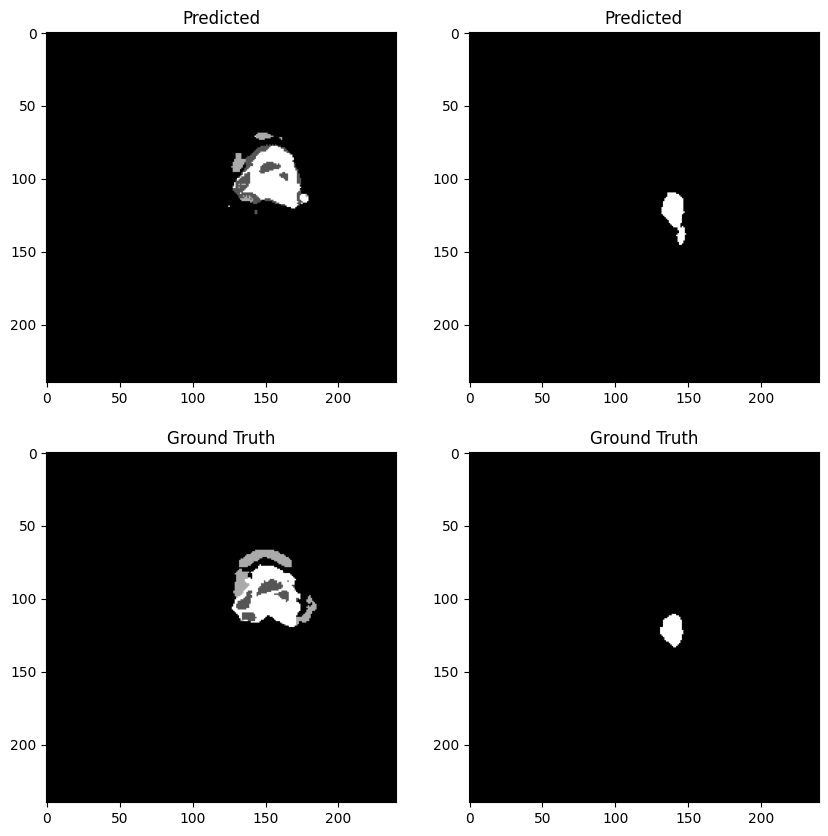

100%|██████████| 136/136 [20:08<00:00,  8.89s/it]



Average Training Loss: 0.015347521115258774

Average Training DSC: [0.99864836 0.74116012 0.84835222 0.64129672]
Average Training ASSD: [ 0.20962292 46.93834359 31.54231337 26.42033671]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


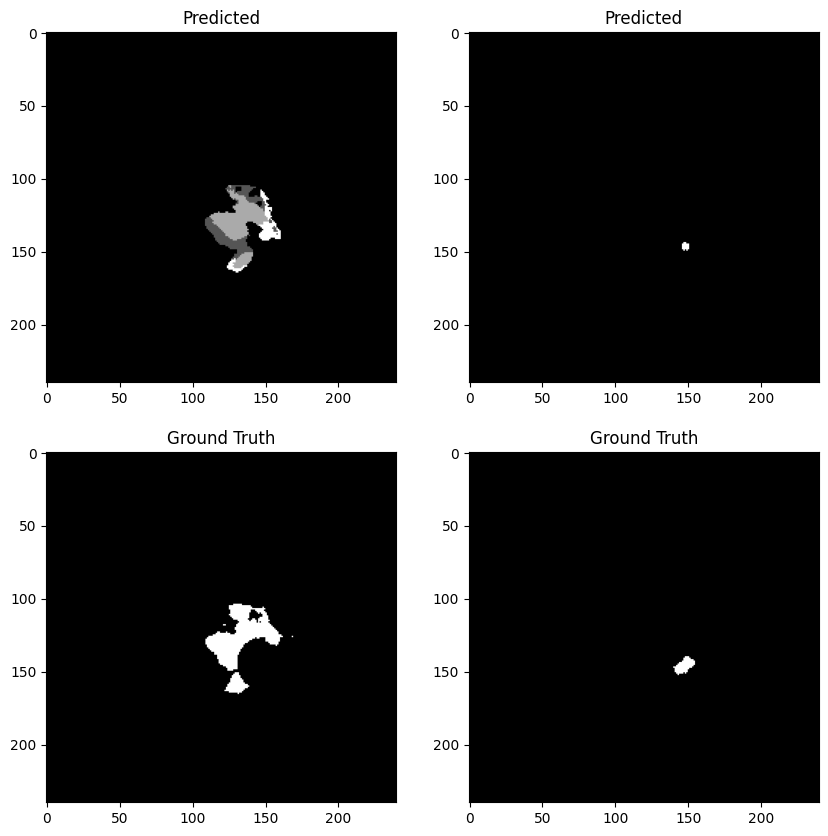

100%|██████████| 34/34 [04:57<00:00,  8.74s/it]


Average Validation Loss: 0.01729787447873284

Average Validation DSC: [0.99869541 0.70345166 0.86367601 0.63716446]
Average Validation ASSD: [ 0.18443933 59.68669954 25.48401353 20.97843605]
Epoch 48/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


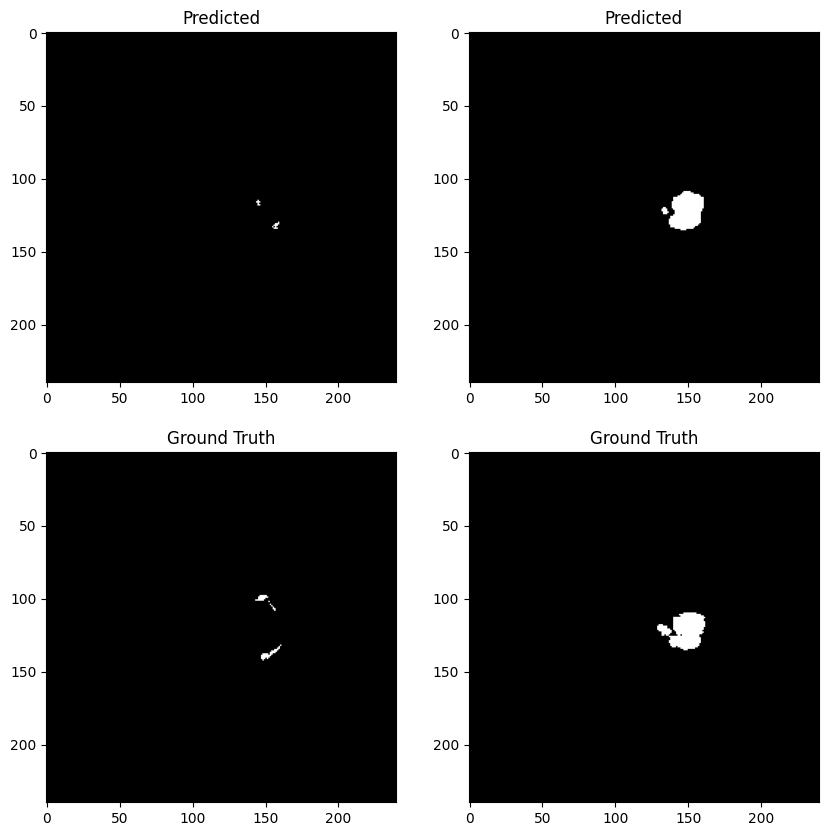

100%|██████████| 136/136 [20:36<00:00,  9.09s/it]



Average Training Loss: 0.013437712873222636

Average Training DSC: [0.99876217 0.78047471 0.87128344 0.66346084]
Average Training ASSD: [ 0.18957078 37.43454346 25.29559365 27.70167453]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


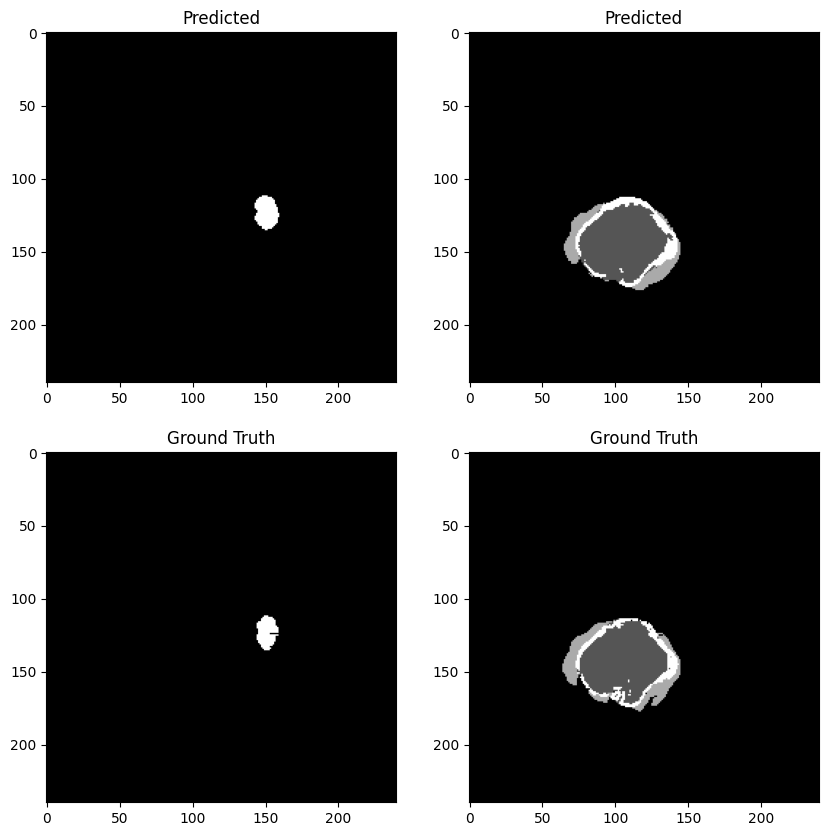

100%|██████████| 34/34 [05:02<00:00,  8.90s/it]


Average Validation Loss: 0.016773051089223695

Average Validation DSC: [0.99875389 0.77169735 0.89427209 0.6591923 ]
Average Validation ASSD: [ 0.20395777 34.83646859 16.83473135 24.96721377]
Epoch 49/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


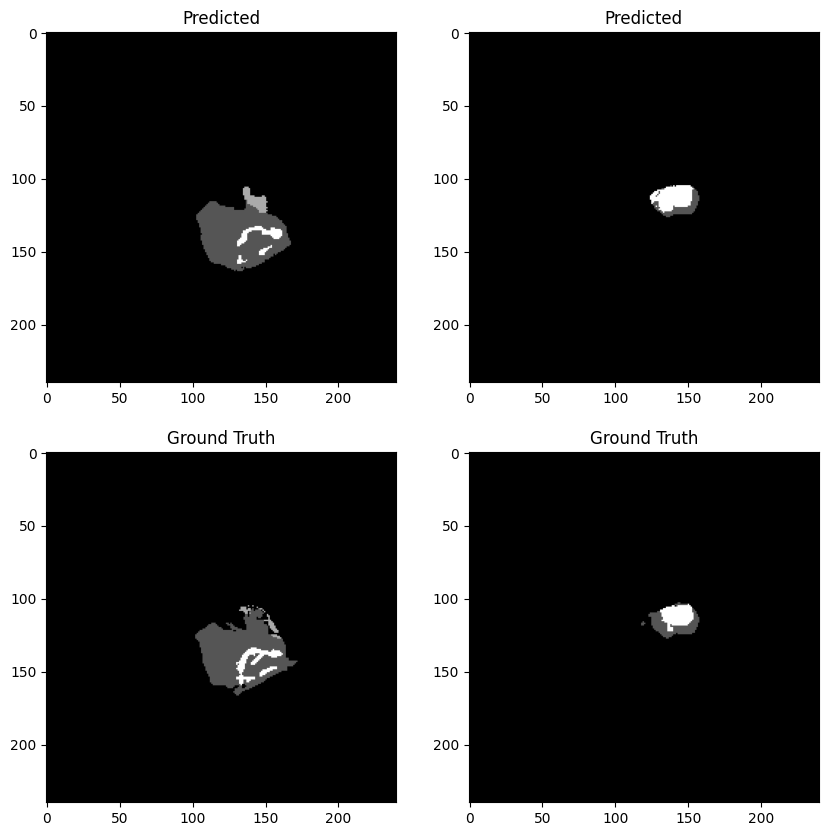

100%|██████████| 136/136 [20:42<00:00,  9.14s/it]



Average Training Loss: 0.012890639591633397

Average Training DSC: [0.99878777 0.79710995 0.87645329 0.67035147]
Average Training ASSD: [ 0.18514327 34.11930941 22.2033029  28.70895972]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


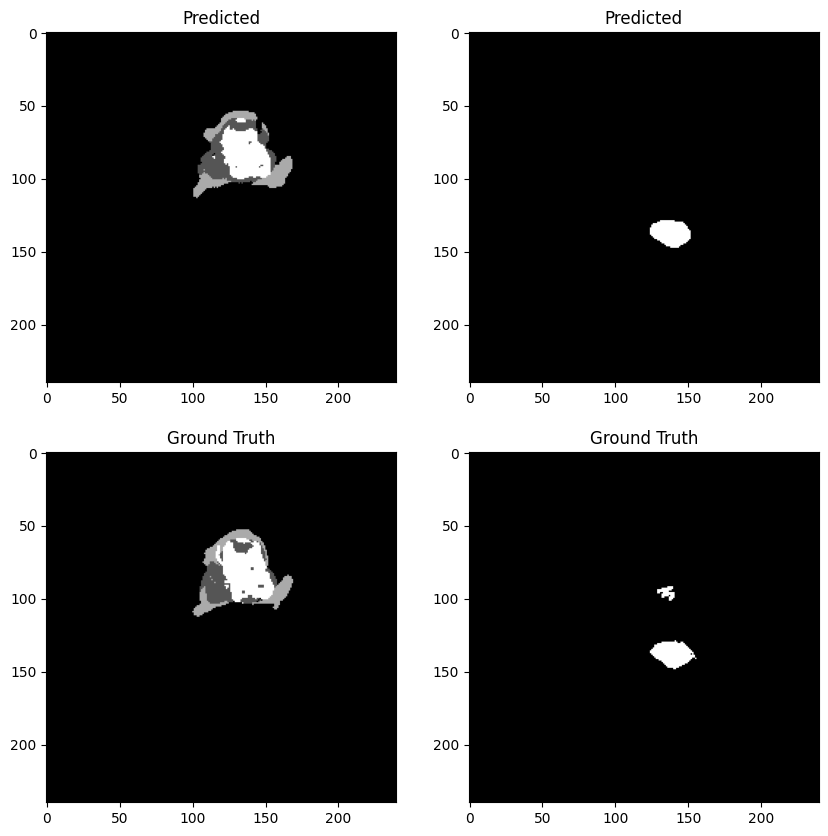

100%|██████████| 34/34 [04:55<00:00,  8.69s/it]


Average Validation Loss: 0.0155036395196529

Average Validation DSC: [0.99870319 0.72041784 0.89594663 0.62494181]
Average Validation ASSD: [ 0.22497662 60.02803832 16.44826871 39.37010627]
Epoch 50/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


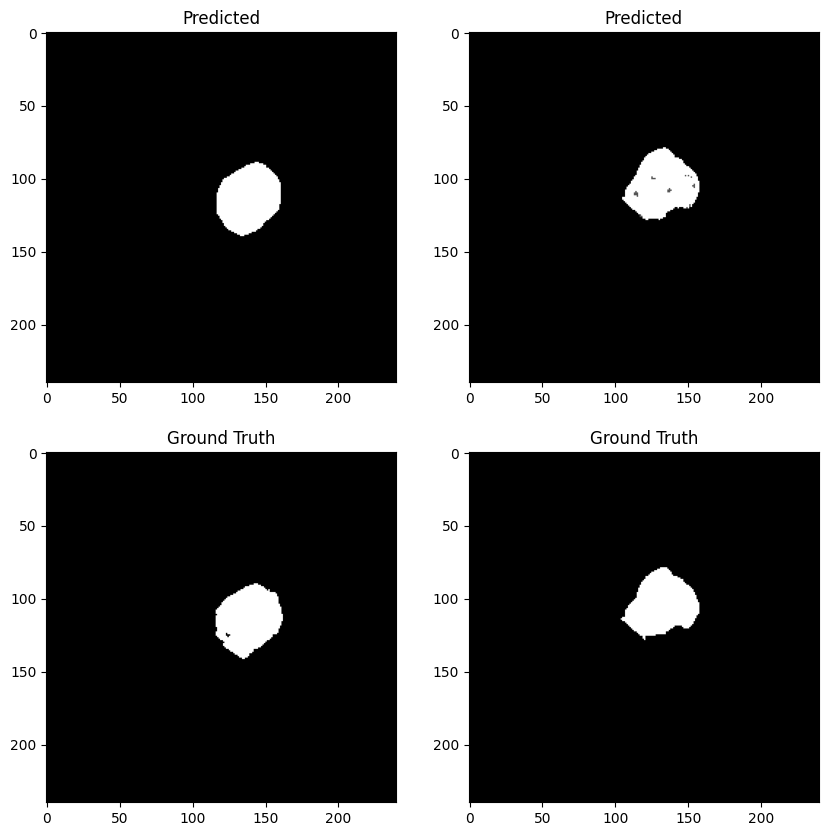

100%|██████████| 136/136 [21:32<00:00,  9.51s/it]



Average Training Loss: 0.012101647231782623

Average Training DSC: [0.99883209 0.80478071 0.88974201 0.68044562]
Average Training ASSD: [ 0.1750326  31.8557382  19.53452339 26.4935952 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


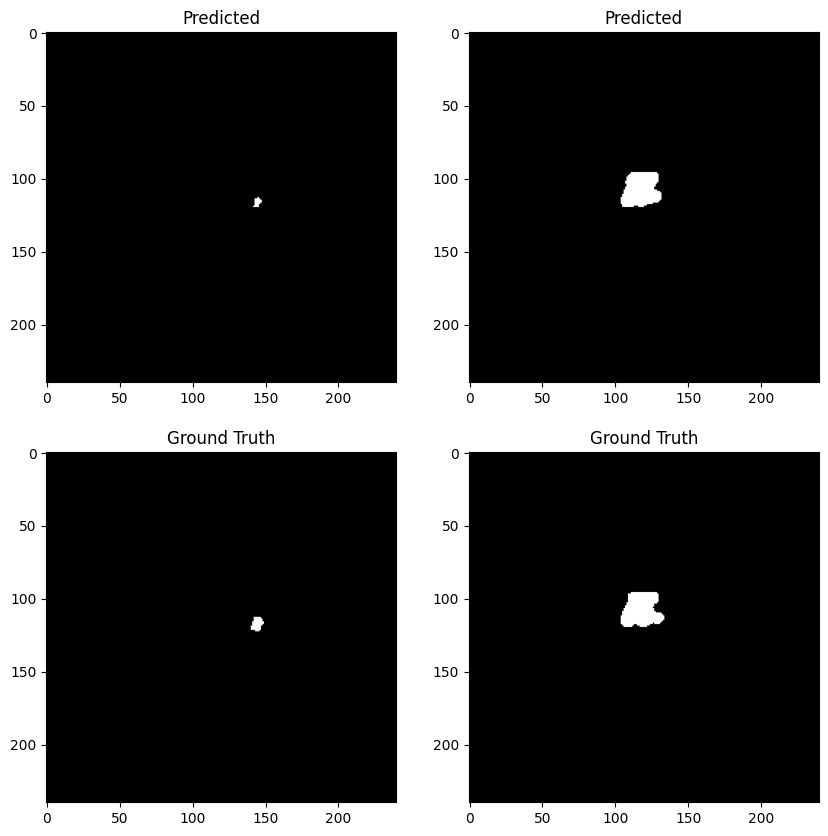

100%|██████████| 34/34 [05:04<00:00,  8.94s/it]


Average Validation Loss: 0.015211957917713067

Average Validation DSC: [0.99872676 0.78093762 0.91067915 0.68960994]
Average Validation ASSD: [ 0.18581213 34.27732677 11.12307152 23.10701716]
Epoch 51/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


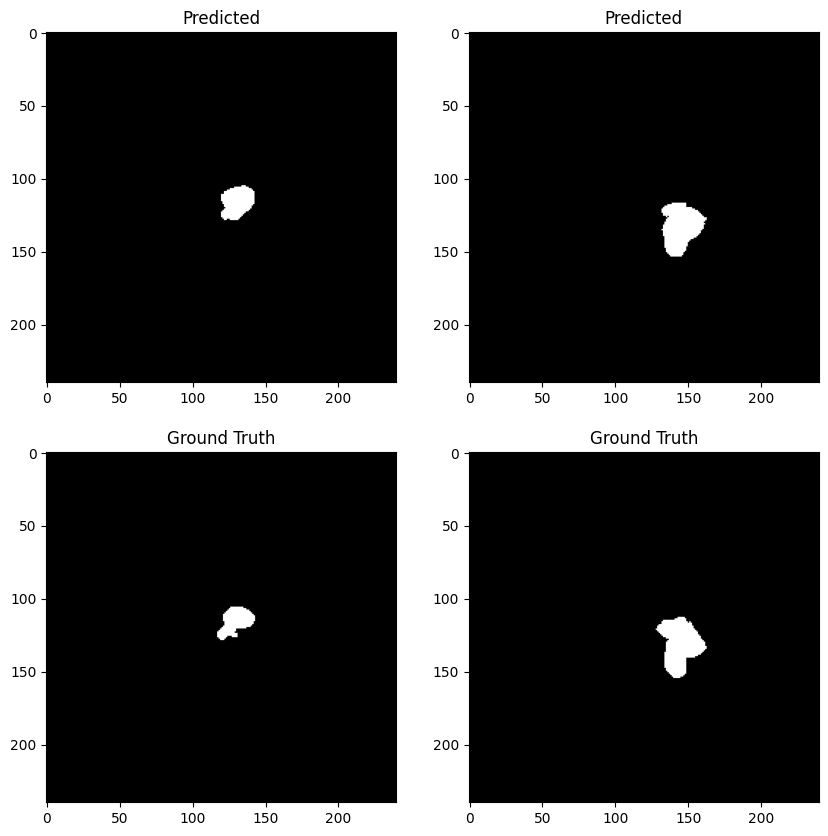

100%|██████████| 136/136 [21:06<00:00,  9.31s/it]



Average Training Loss: 0.011063411787344032

Average Training DSC: [0.9989379  0.82975649 0.89268988 0.69799606]
Average Training ASSD: [ 0.15646396 26.61522563 18.57382904 27.13815849]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


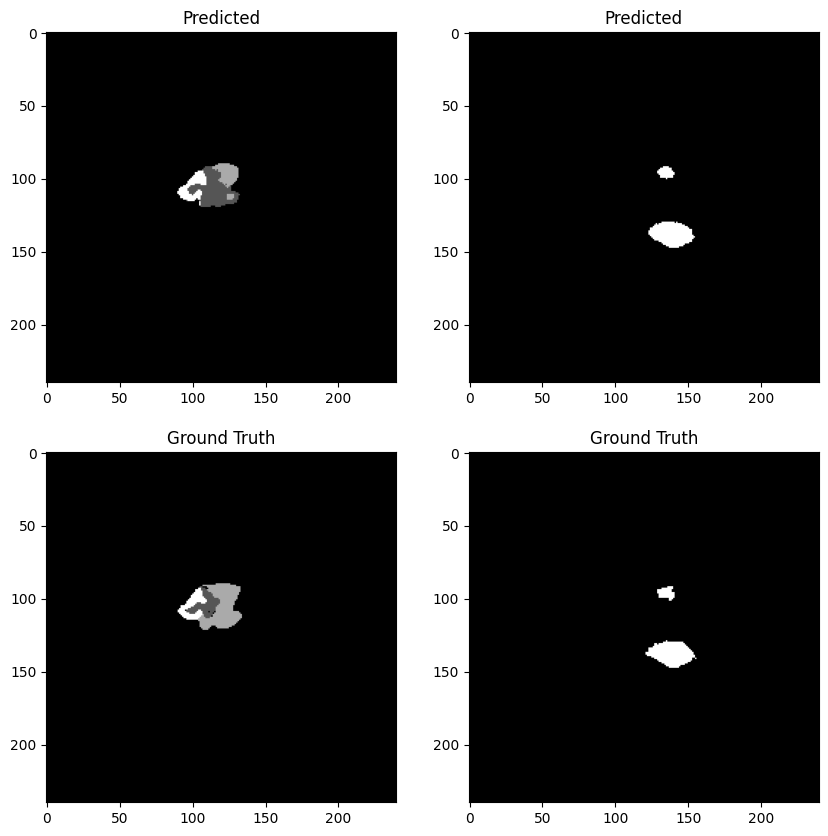

100%|██████████| 34/34 [04:55<00:00,  8.70s/it]


Average Validation Loss: 0.013539402375874273

Average Validation DSC: [0.99886911 0.81897284 0.90140678 0.6917354 ]
Average Validation ASSD: [ 0.16931408 26.7334863  14.74948774 25.74484943]
Epoch 52/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


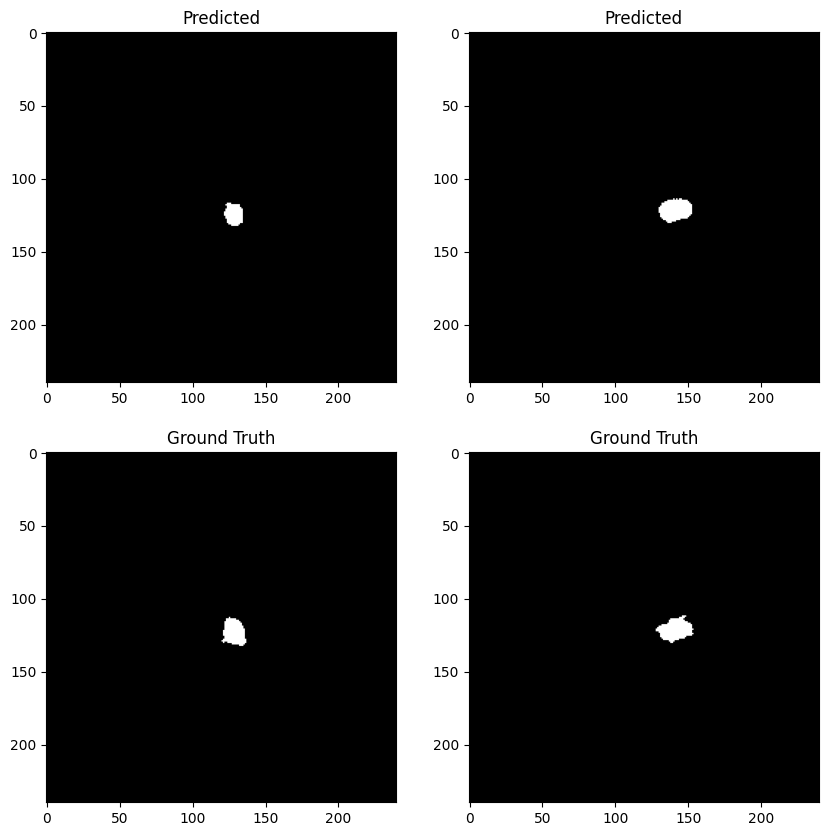

100%|██████████| 136/136 [20:53<00:00,  9.21s/it]



Average Training Loss: 0.010637214160798228

Average Training DSC: [0.99895331 0.83679557 0.90063145 0.70763523]
Average Training ASSD: [ 0.15440847 25.43835488 17.71352228 27.30379077]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


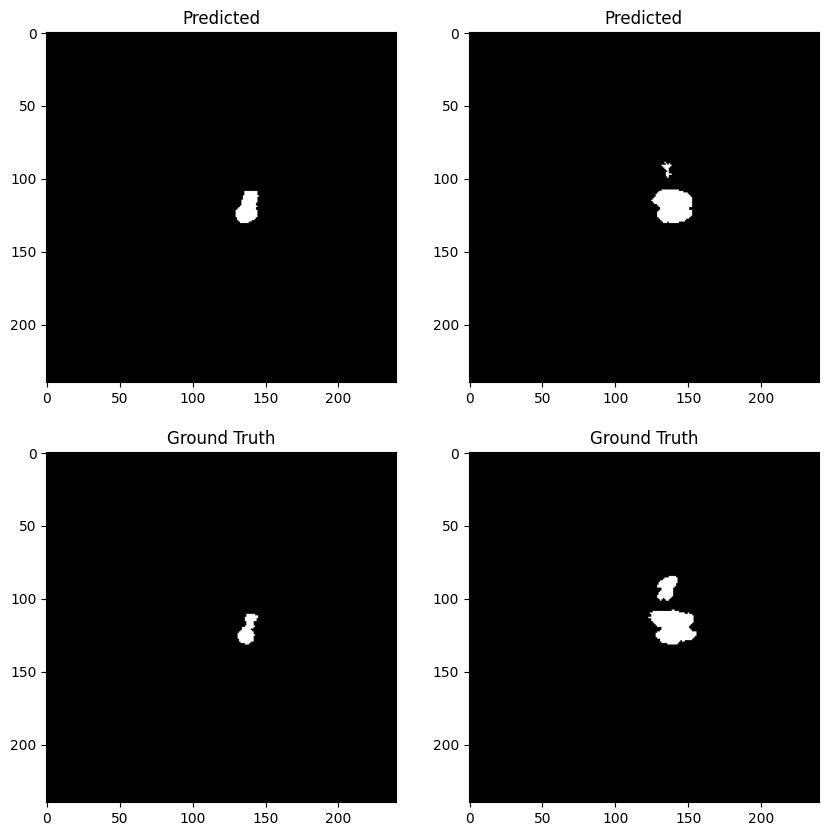

100%|██████████| 34/34 [05:13<00:00,  9.21s/it]


Average Validation Loss: 0.013849198270369978

Average Validation DSC: [0.99890048 0.81749614 0.91392405 0.69925627]
Average Validation ASSD: [ 0.17602216 24.43184506 10.52718086 25.71713091]
Epoch 53/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


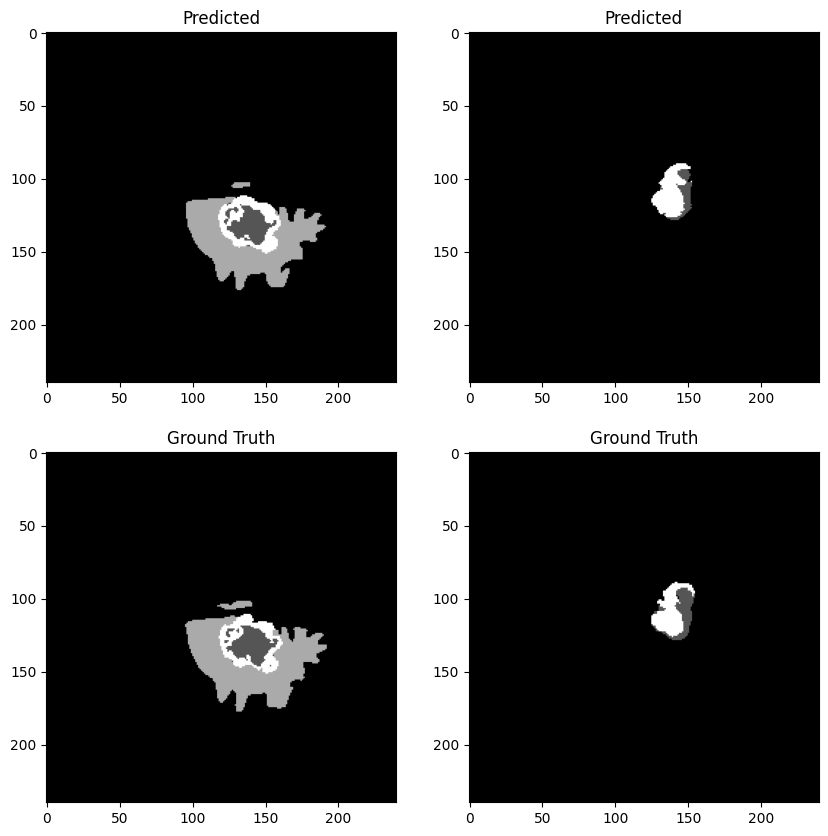

100%|██████████| 136/136 [20:31<00:00,  9.06s/it]



Average Training Loss: 0.01002360152779147

Average Training DSC: [0.99899985 0.8474436  0.91111854 0.71169109]
Average Training ASSD: [ 0.142942   22.18229798 14.31416925 27.06009114]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


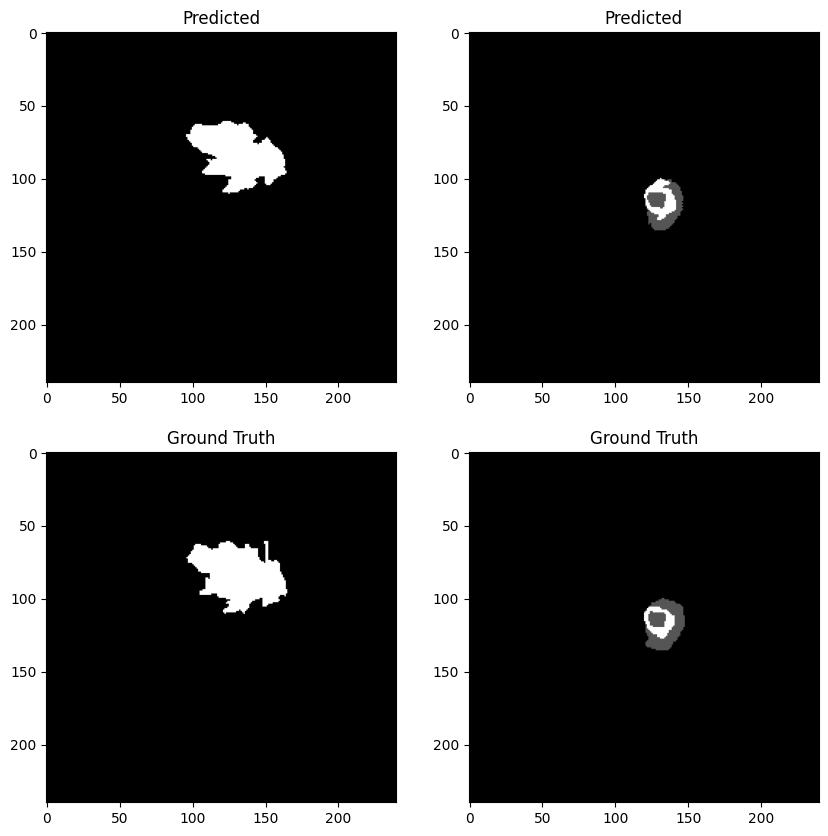

100%|██████████| 34/34 [04:49<00:00,  8.51s/it]


Average Validation Loss: 0.013179207494591965

Average Validation DSC: [0.99889763 0.82811911 0.91335001 0.70609074]
Average Validation ASSD: [ 0.15734047 24.53021155 11.77214295 24.84781665]
Epoch 54/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


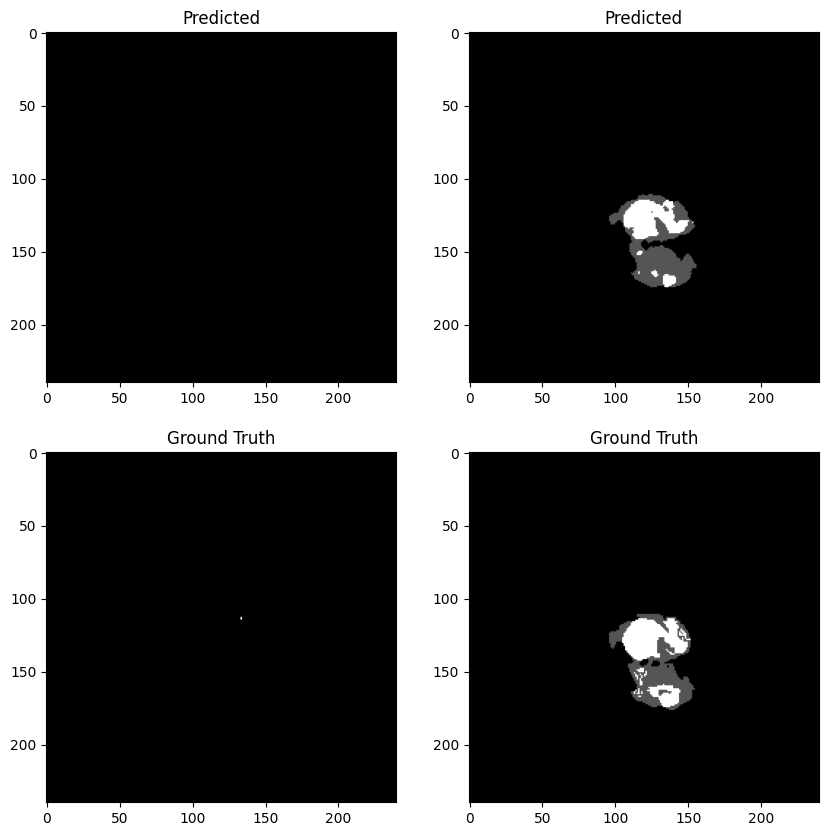

100%|██████████| 136/136 [20:25<00:00,  9.01s/it]



Average Training Loss: 0.0093814713147688

Average Training DSC: [0.99904028 0.86072619 0.91566989 0.72528632]
Average Training ASSD: [ 0.14153795 20.36887704 13.51777363 26.43438702]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


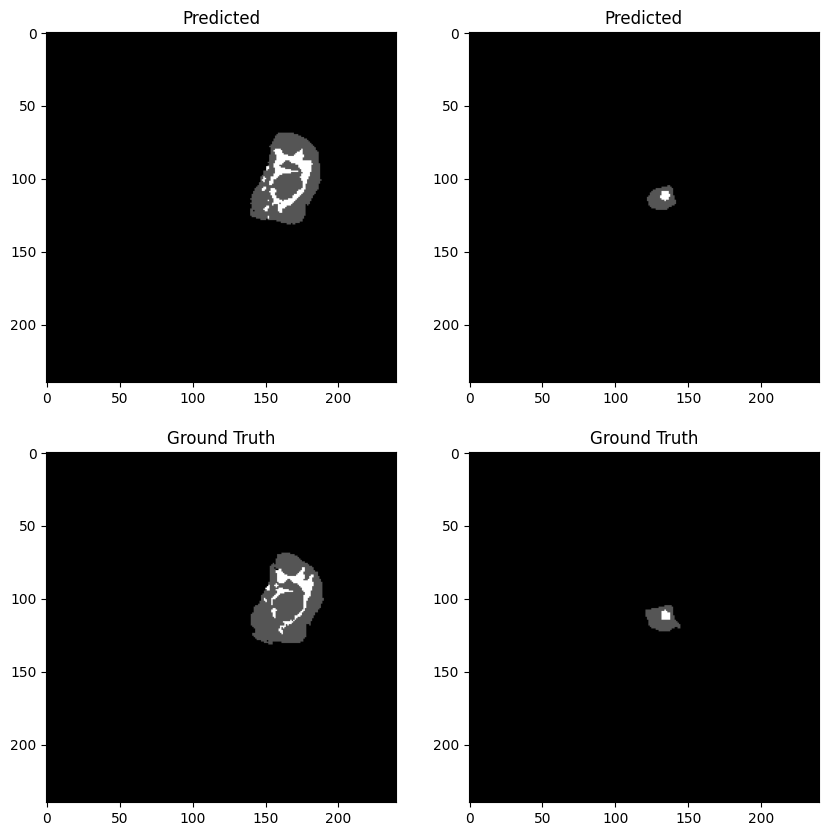

100%|██████████| 34/34 [04:42<00:00,  8.32s/it]


Average Validation Loss: 0.012929372462060522

Average Validation DSC: [0.99892172 0.84299602 0.91937433 0.71081935]
Average Validation ASSD: [ 0.16905824 22.35883144 10.3467249  27.38560374]
Epoch 55/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


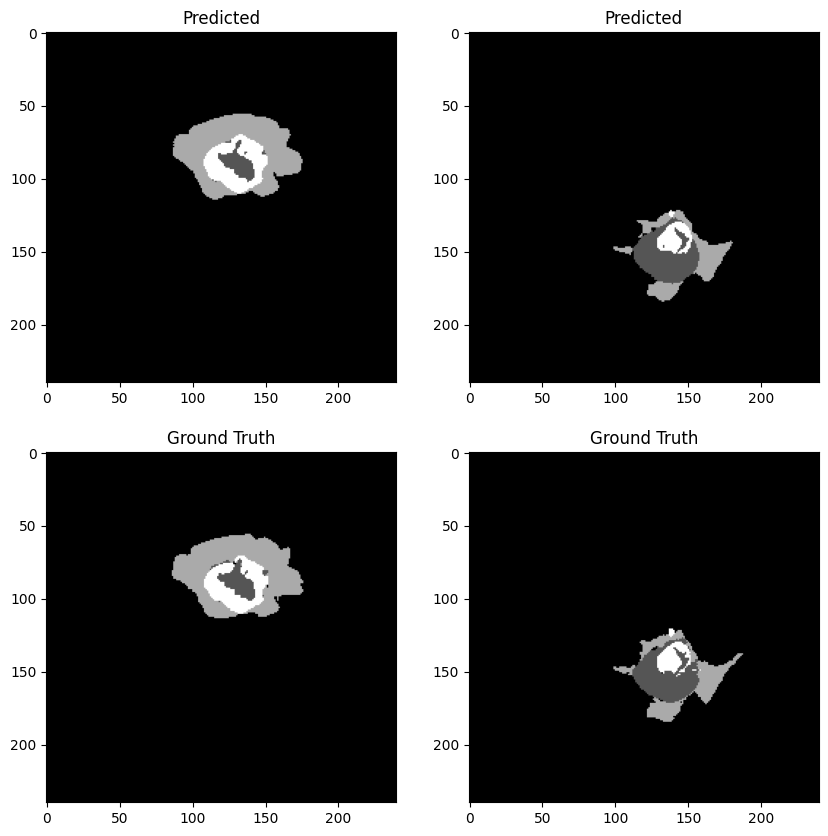

100%|██████████| 136/136 [20:32<00:00,  9.06s/it]



Average Training Loss: 0.008931384298621732

Average Training DSC: [0.99907808 0.87251136 0.91418356 0.73354406]
Average Training ASSD: [ 0.13238006 16.2018708  14.41276186 26.22979092]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


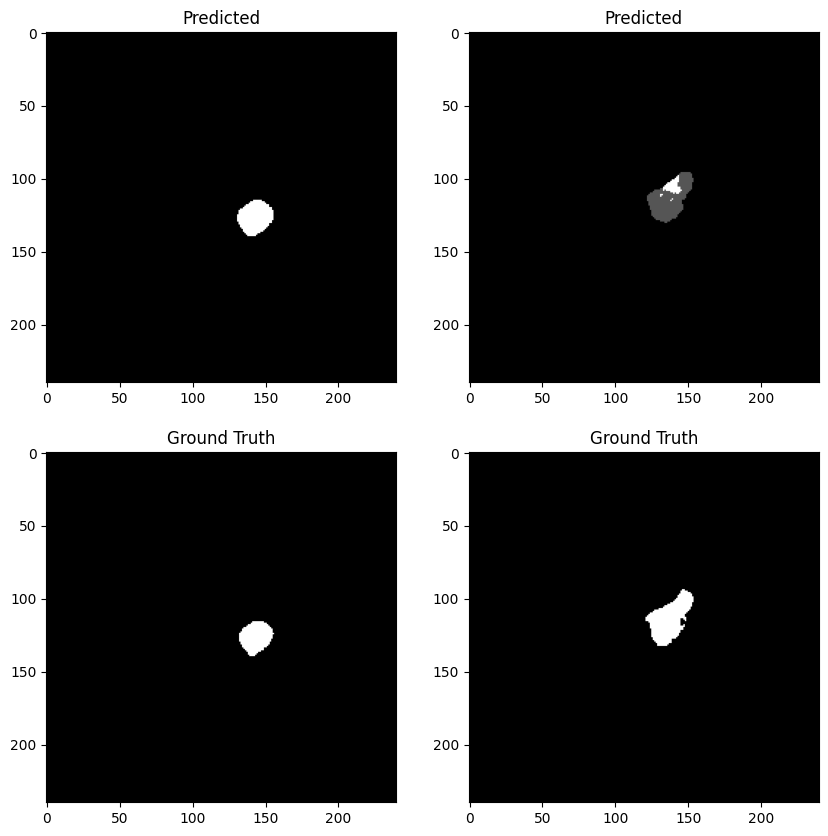

100%|██████████| 34/34 [04:38<00:00,  8.20s/it]


Average Validation Loss: 0.014193879262379864

Average Validation DSC: [0.99899967 0.81470593 0.92310411 0.66003383]
Average Validation ASSD: [ 0.14880506 33.82645066 10.05621333 35.74101499]
Epoch 56/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


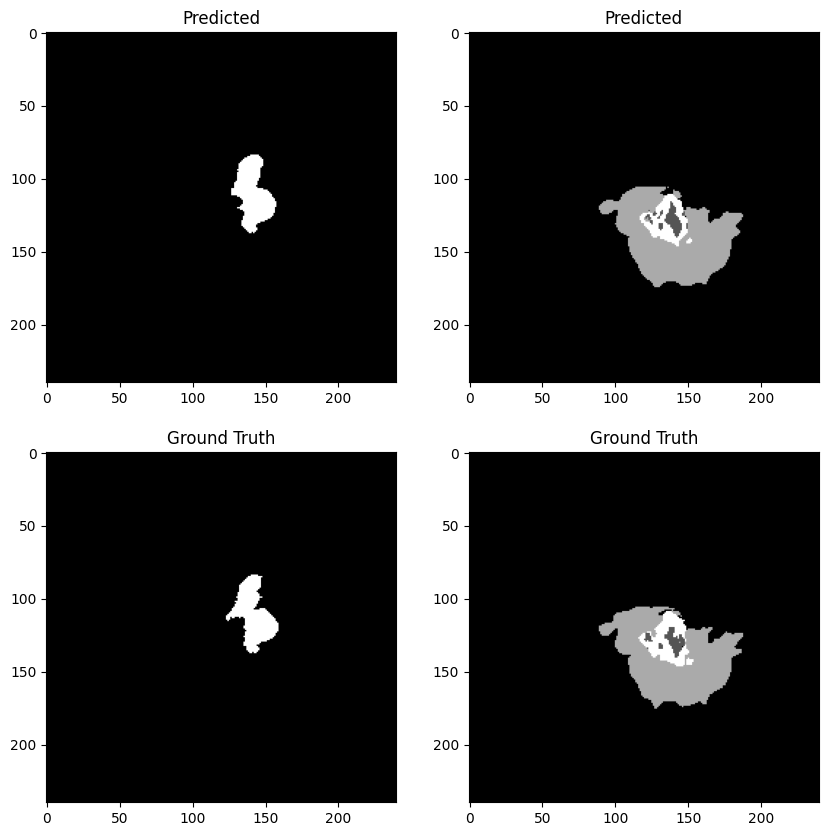

100%|██████████| 136/136 [20:26<00:00,  9.01s/it]



Average Training Loss: 0.00962084166787784

Average Training DSC: [0.99900478 0.85653853 0.9135639  0.72455105]
Average Training ASSD: [ 0.14629582 20.89748109 13.93862604 25.15738325]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


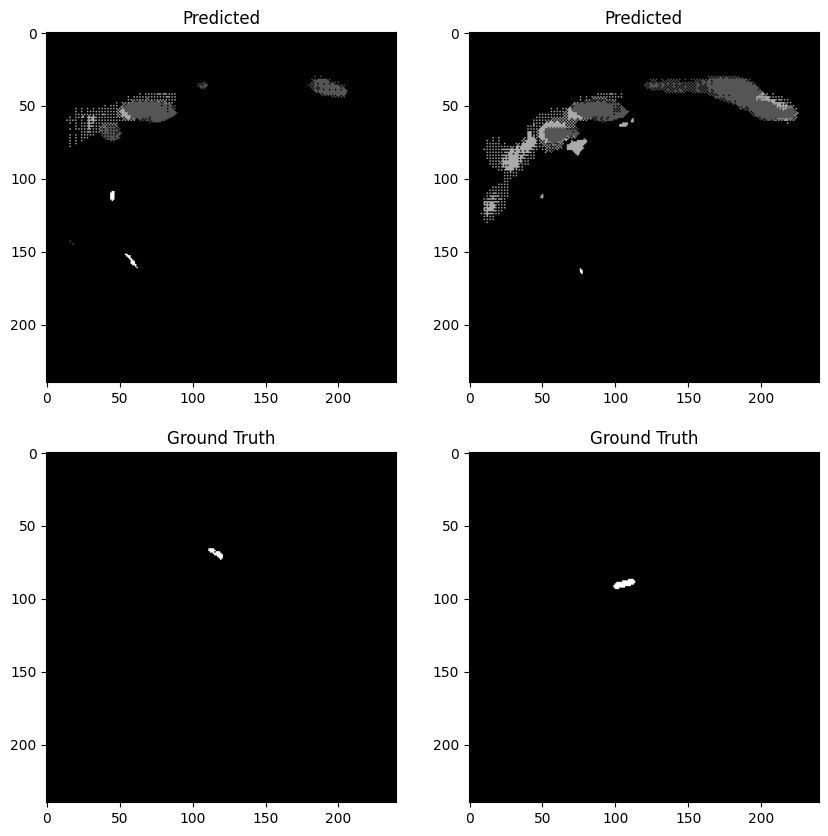

100%|██████████| 34/34 [05:15<00:00,  9.27s/it]


Average Validation Loss: 0.4125538021326065

Average Validation DSC: [0.97554952 0.17614719 0.11392781 0.59930144]
Average Validation ASSD: [  9.52408512 179.3662349  275.659954    11.62159517]
Epoch 57/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


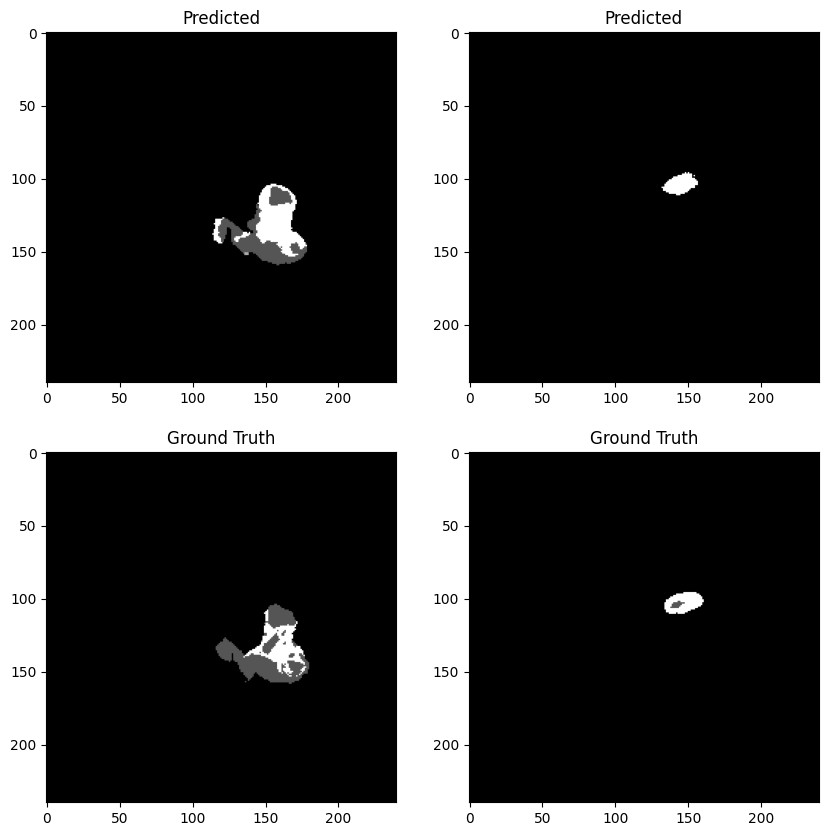

100%|██████████| 136/136 [21:32<00:00,  9.50s/it]



Average Training Loss: 0.010254076483440311

Average Training DSC: [0.99894812 0.8438086  0.88934102 0.70907165]
Average Training ASSD: [ 0.16343874 23.43964383 21.17314523 27.77370176]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


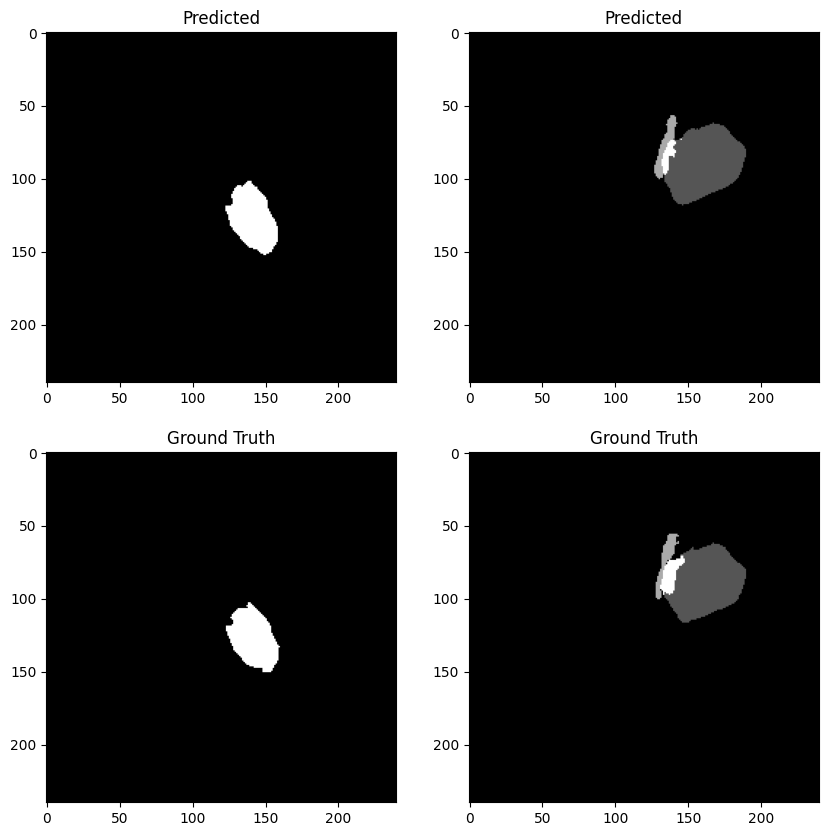

100%|██████████| 34/34 [05:02<00:00,  8.89s/it]


Average Validation Loss: 0.01327931327635751

Average Validation DSC: [0.99893167 0.82352358 0.91933269 0.71134592]
Average Validation ASSD: [ 0.15524026 29.2663199  10.05619804 21.2367317 ]
Epoch 58/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


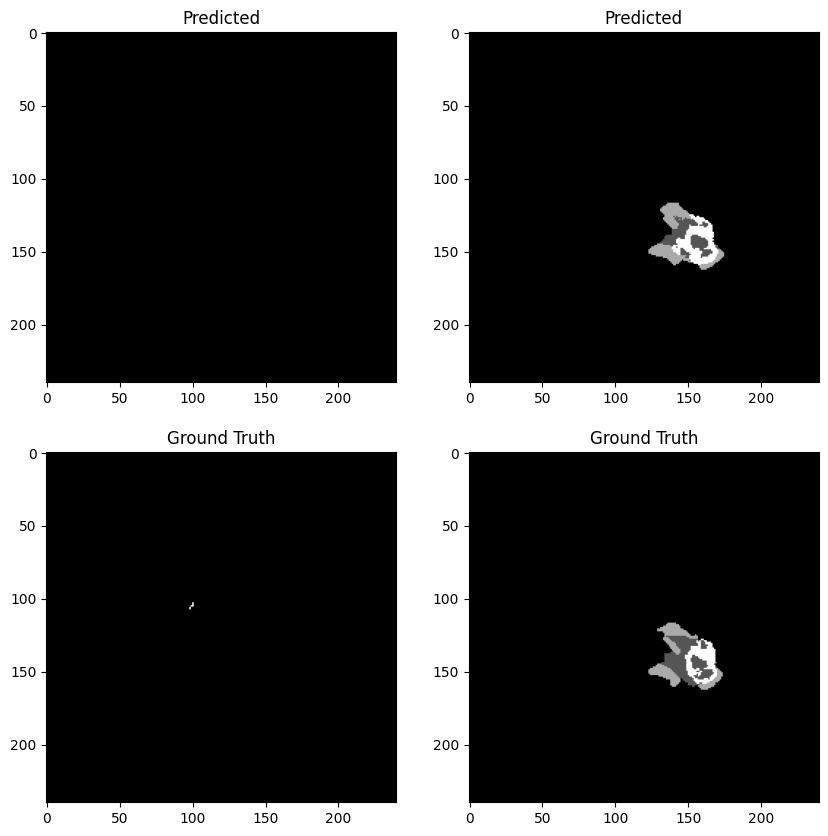

100%|██████████| 136/136 [20:55<00:00,  9.23s/it]



Average Training Loss: 0.008936759259086102

Average Training DSC: [0.9990756  0.87110279 0.91834135 0.73528054]
Average Training ASSD: [ 0.13401219 17.61329965 13.16490425 26.34287146]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


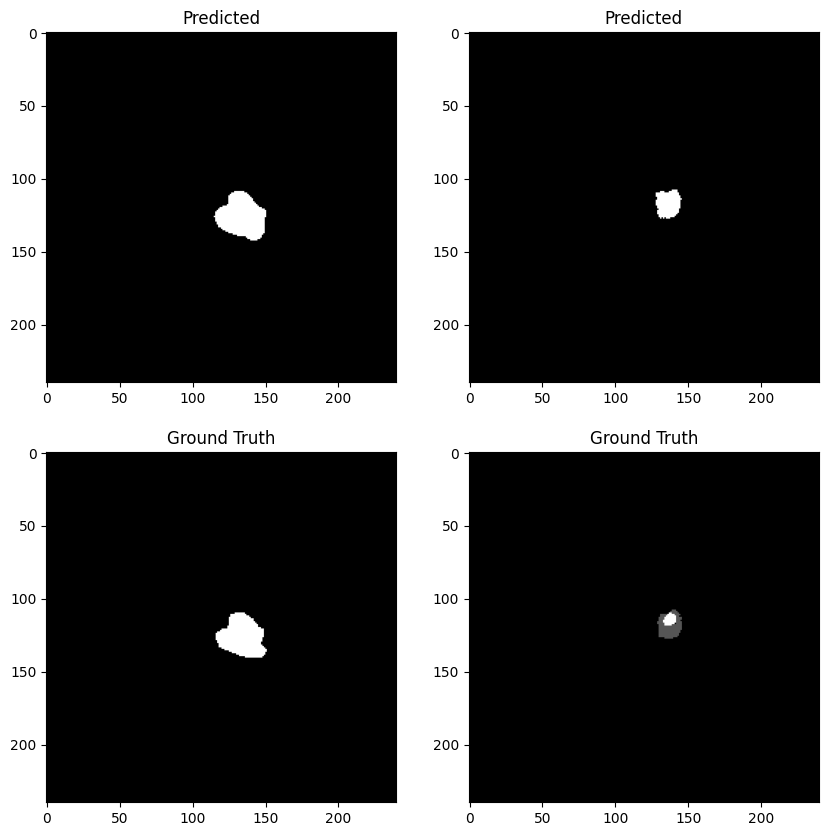

100%|██████████| 34/34 [04:56<00:00,  8.73s/it]


Average Validation Loss: 0.012761719004415414

Average Validation DSC: [0.99898351 0.83479971 0.91900757 0.69753152]
Average Validation ASSD: [ 0.12788093 27.01656784 11.02621173 24.99999588]
Epoch 59/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


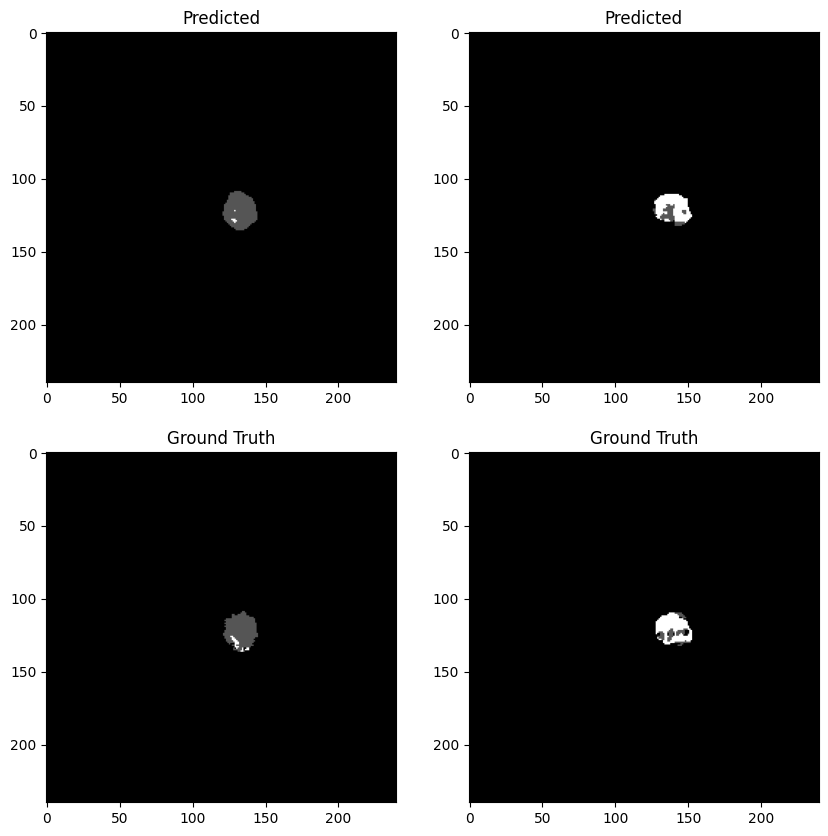

100%|██████████| 136/136 [20:56<00:00,  9.24s/it]



Average Training Loss: 0.008259147165945786

Average Training DSC: [0.99913988 0.87650267 0.92374195 0.74496939]
Average Training ASSD: [ 0.12042567 15.77007494 12.2984747  25.37367864]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


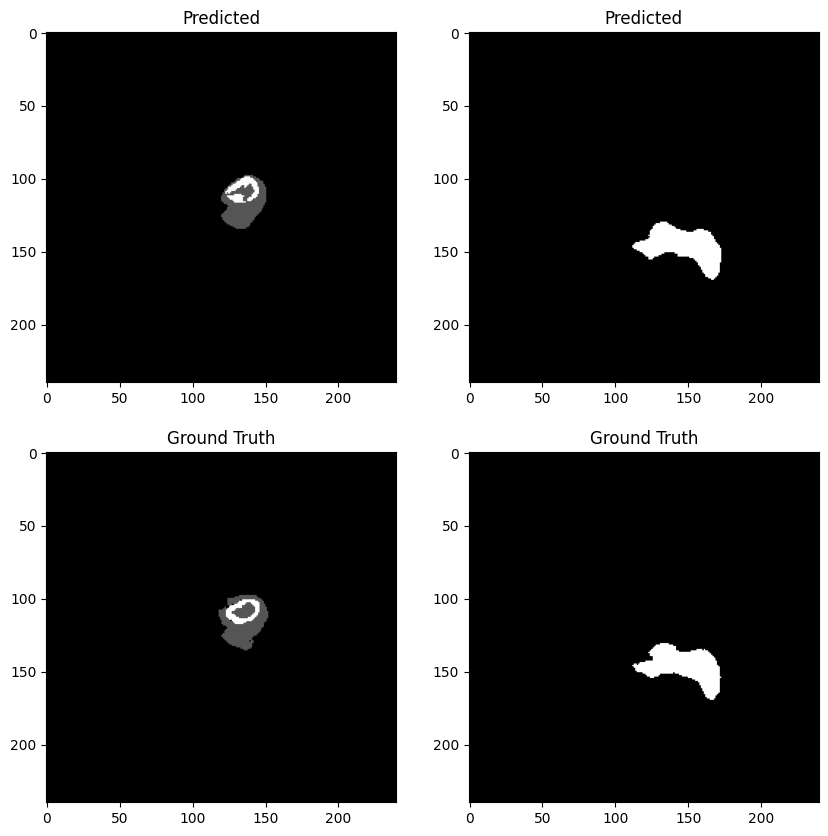

100%|██████████| 34/34 [05:24<00:00,  9.56s/it]


Average Validation Loss: 0.012246894006453016

Average Validation DSC: [0.99903537 0.85598461 0.91645879 0.73946021]
Average Validation ASSD: [ 0.13201321 21.61328936 12.40384986 19.49685164]
Epoch 60/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


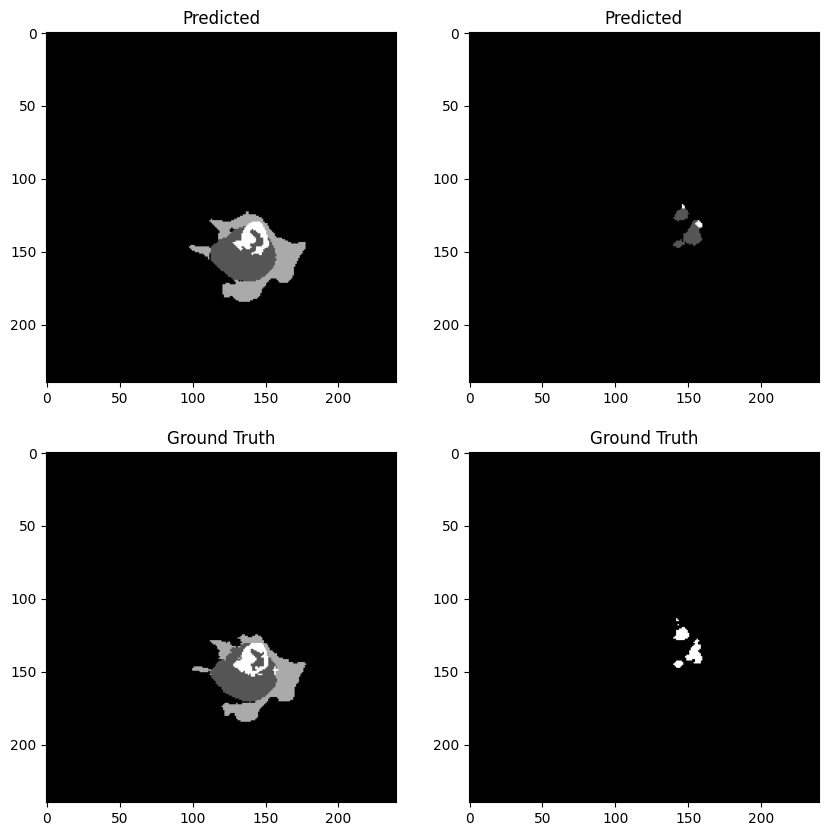

100%|██████████| 136/136 [20:51<00:00,  9.20s/it]



Average Training Loss: 0.008149355064447531

Average Training DSC: [0.99914674 0.8752104  0.92004217 0.75189746]
Average Training ASSD: [ 0.1513333  17.60143459 14.59300091 23.37498302]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


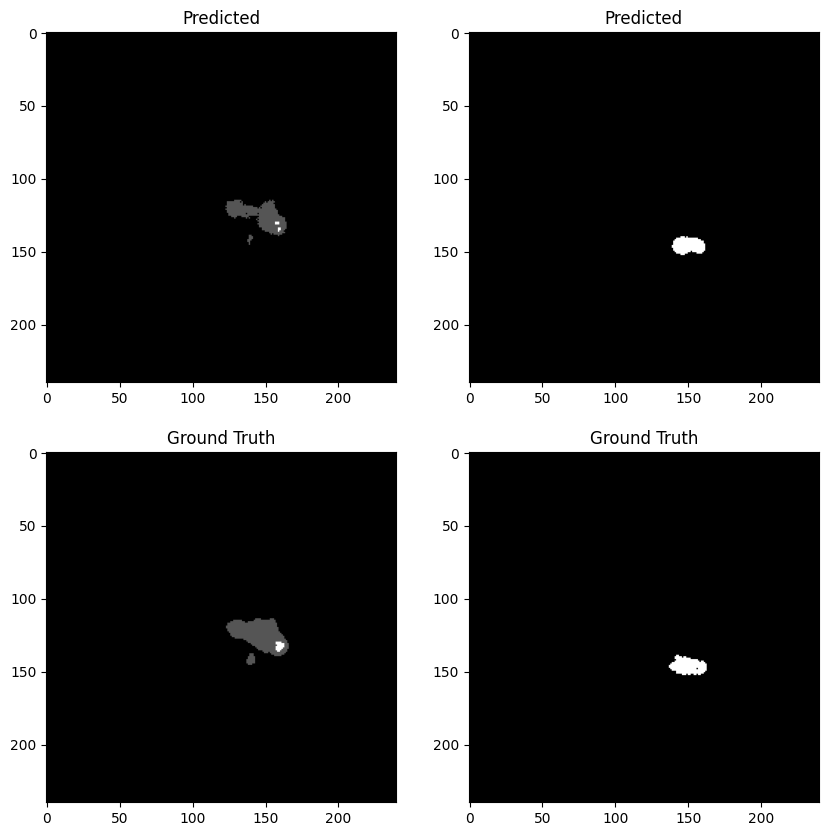

100%|██████████| 34/34 [05:14<00:00,  9.26s/it]


Average Validation Loss: 0.01903289441457566

Average Validation DSC: [0.99868342 0.79669592 0.8819914  0.6226465 ]
Average Validation ASSD: [ 0.18987037 34.75821603 21.76287678 44.05929895]
Epoch 61/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


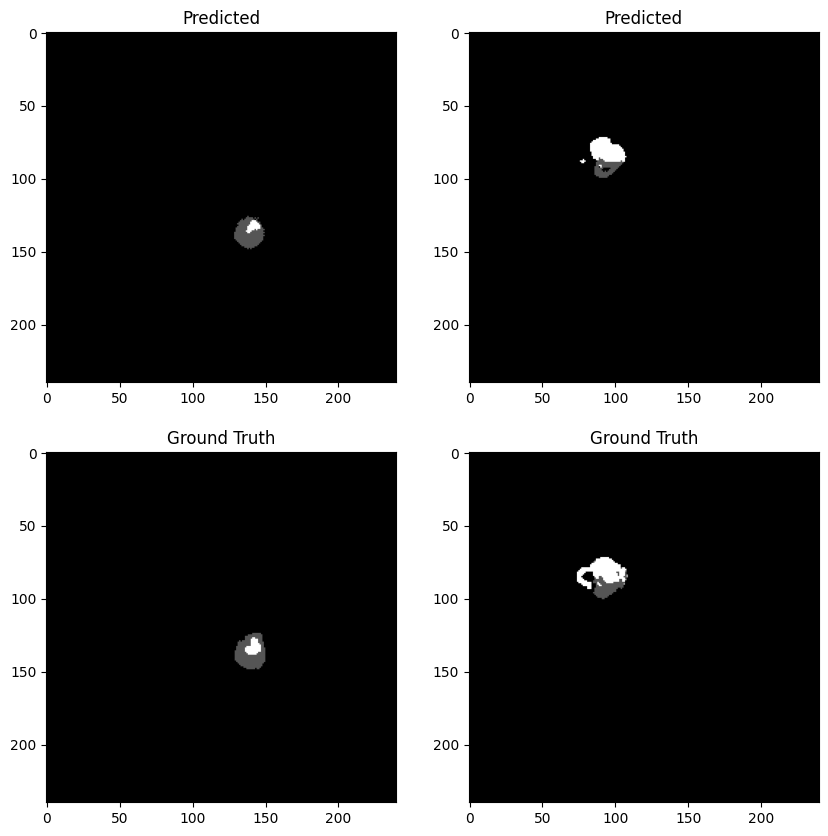

100%|██████████| 136/136 [20:43<00:00,  9.15s/it]



Average Training Loss: 0.01938784436103614

Average Training DSC: [0.99815174 0.68758995 0.80481443 0.5924315 ]
Average Training ASSD: [ 0.37064794 60.10319686 44.64289582 34.47253925]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


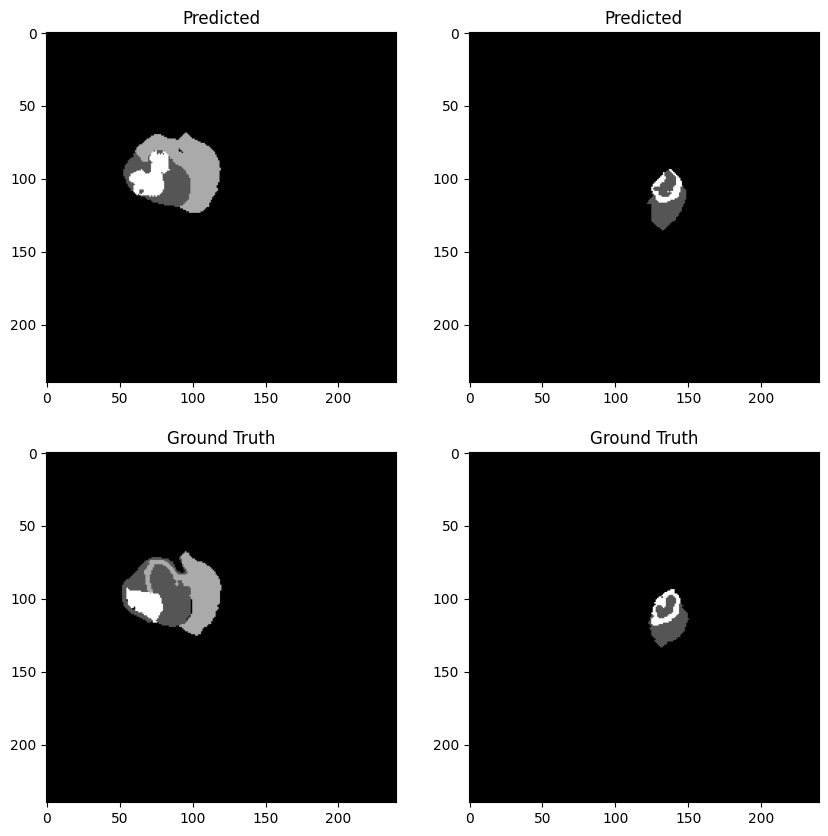

100%|██████████| 34/34 [05:08<00:00,  9.09s/it]


Average Validation Loss: 0.01498404550640022

Average Validation DSC: [0.99876605 0.78866225 0.86535987 0.66976504]
Average Validation ASSD: [ 0.21021947 32.35924708 27.60200061 29.26758909]
Epoch 62/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


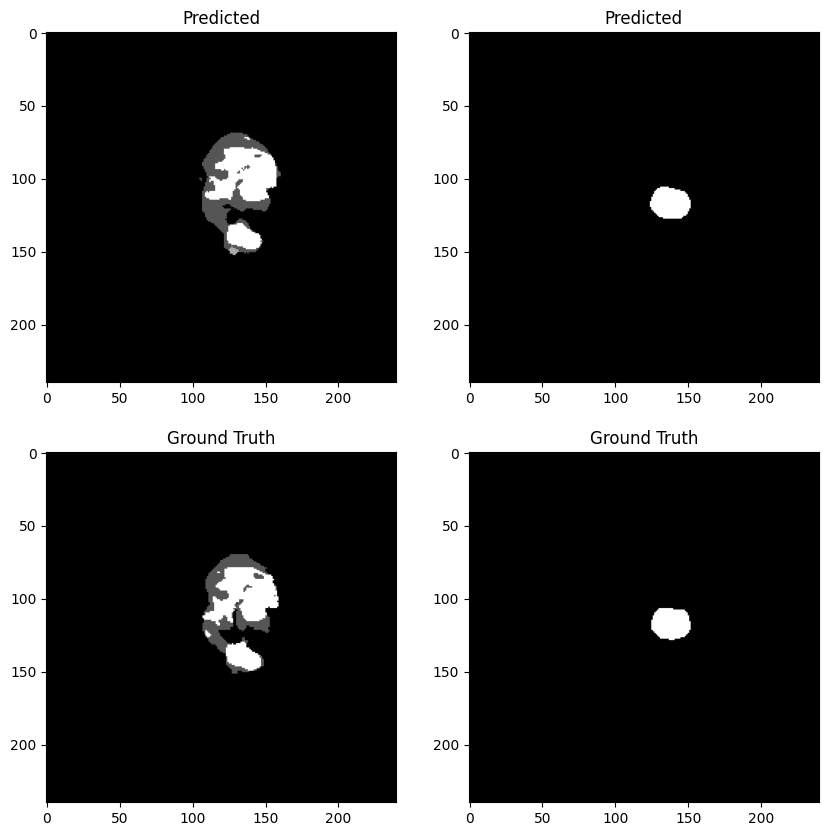

100%|██████████| 136/136 [21:03<00:00,  9.29s/it]



Average Training Loss: 0.010436033121282783

Average Training DSC: [0.99891737 0.8358952  0.9036617  0.70381172]
Average Training ASSD: [ 0.16670021 23.83805399 17.03737483 28.6152499 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


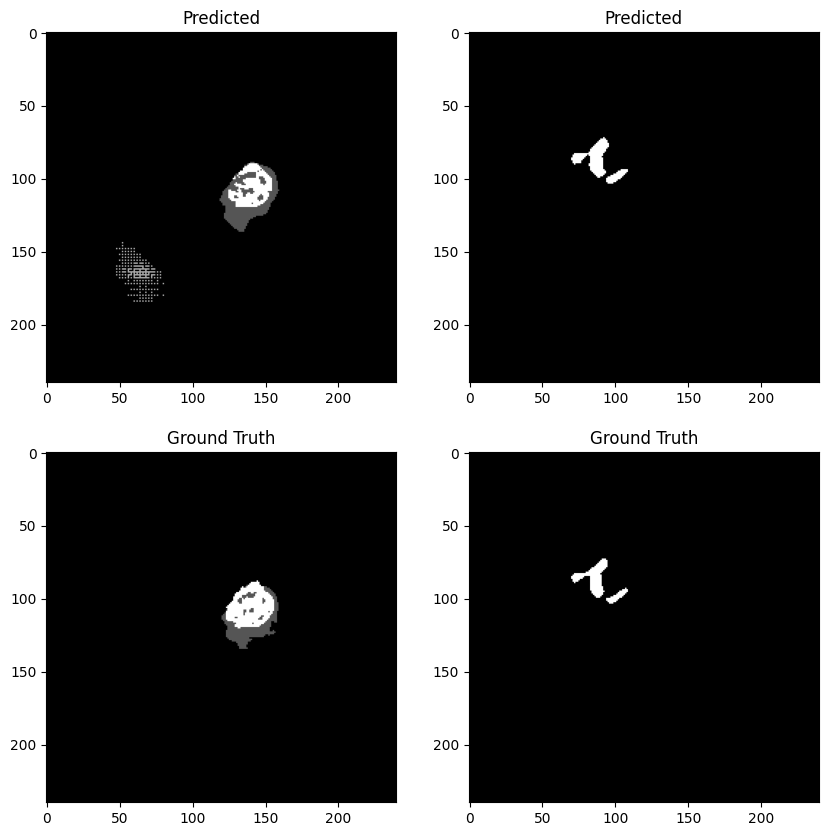

100%|██████████| 34/34 [05:18<00:00,  9.36s/it]


Average Validation Loss: 0.021279571358771884

Average Validation DSC: [0.99733654 0.71801893 0.77055237 0.6113467 ]
Average Validation ASSD: [ 2.385145   62.19859757 63.37941068 46.01672798]
Epoch 63/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


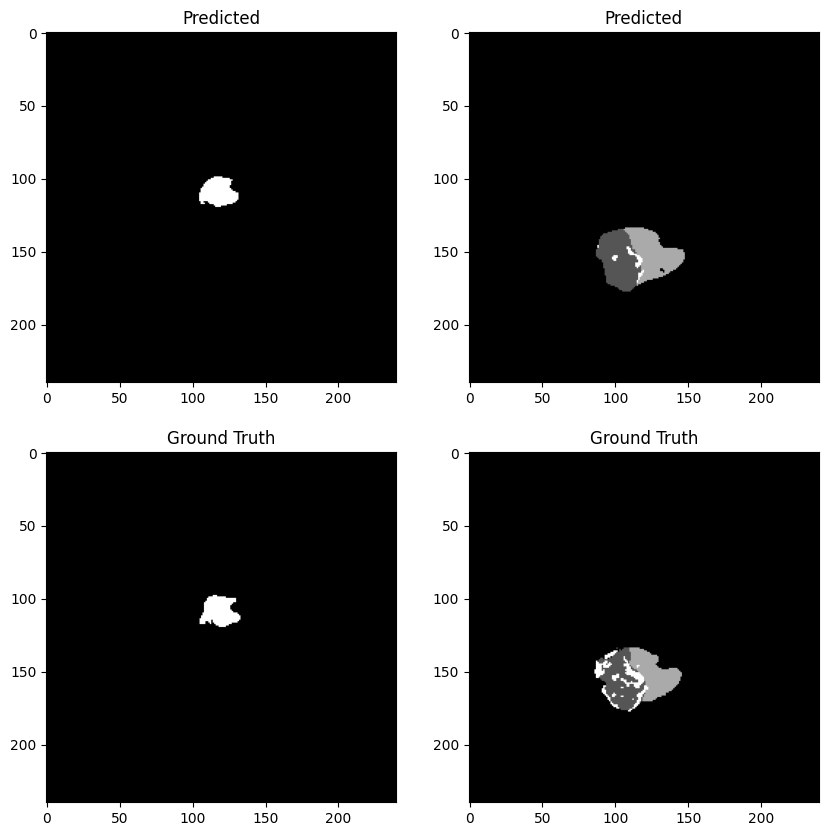

100%|██████████| 136/136 [20:33<00:00,  9.07s/it]



Average Training Loss: 0.008985034553060198

Average Training DSC: [0.9990665  0.85953875 0.92130584 0.72892404]
Average Training ASSD: [ 0.13401743 20.12645264 12.33274889 26.74812477]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


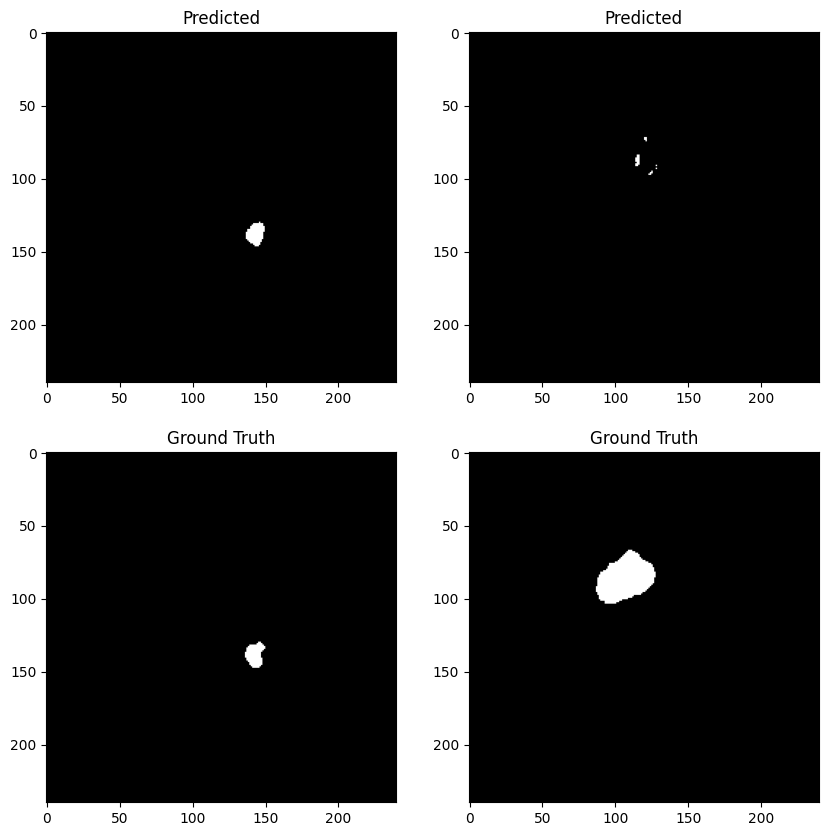

100%|██████████| 34/34 [05:03<00:00,  8.92s/it]


Average Validation Loss: 0.013796895934159266

Average Validation DSC: [0.99900211 0.80816952 0.9097724  0.70525999]
Average Validation ASSD: [ 0.15752421 29.85759879 15.33422292 24.1683177 ]
Epoch 64/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


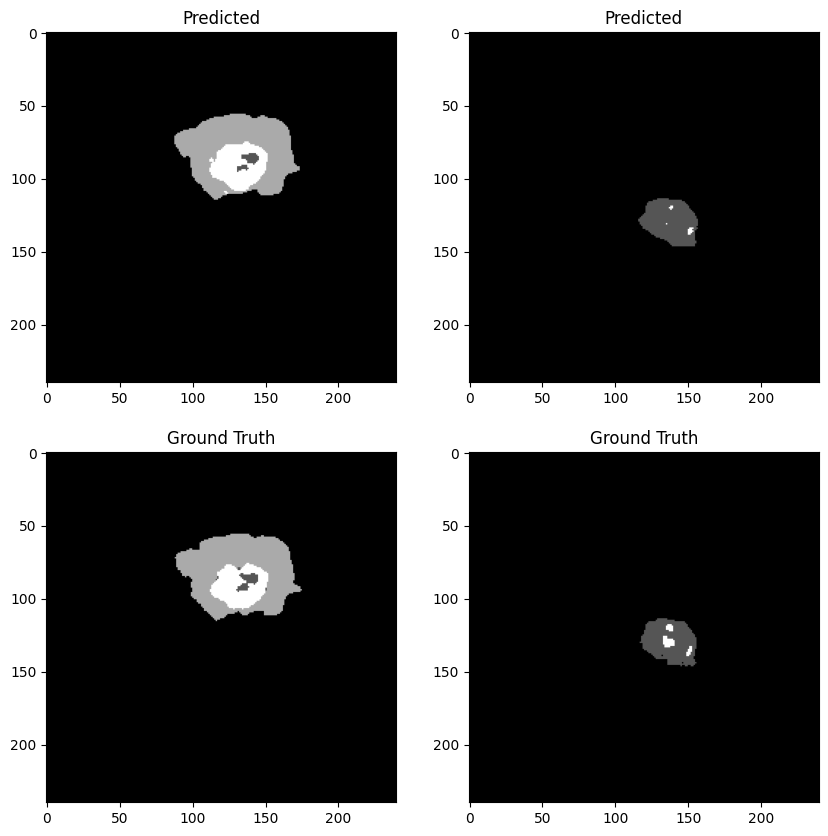

100%|██████████| 136/136 [20:33<00:00,  9.07s/it]



Average Training Loss: 0.008264242363271905

Average Training DSC: [0.99912957 0.87719544 0.92473193 0.73795004]
Average Training ASSD: [ 0.13020142 15.36956367 11.96604892 27.47664187]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


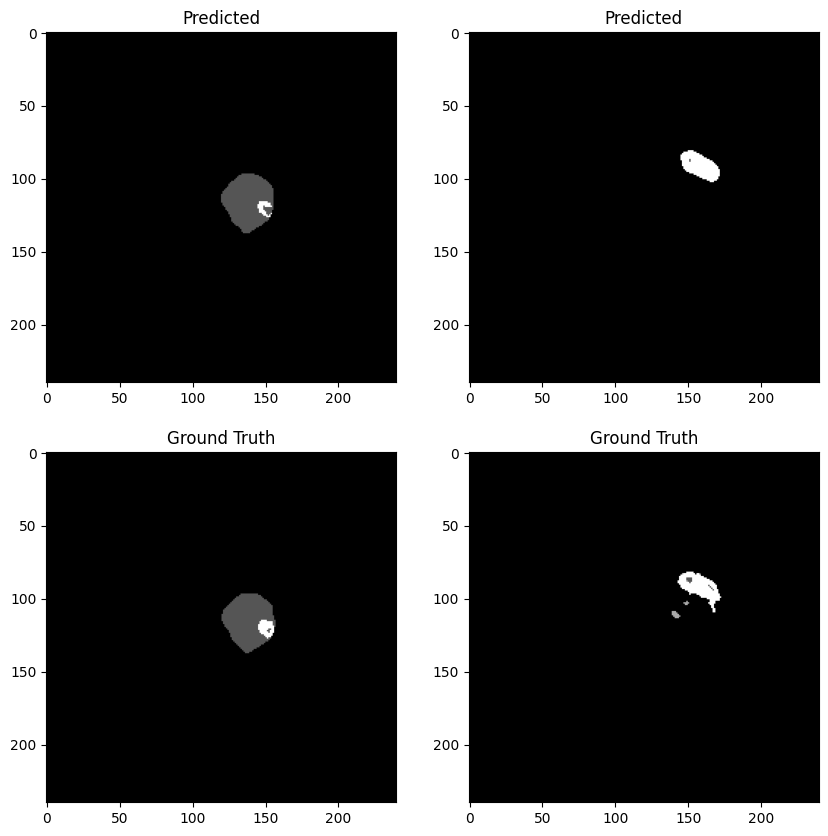

100%|██████████| 34/34 [04:50<00:00,  8.53s/it]


Average Validation Loss: 0.012933679007212906

Average Validation DSC: [0.99901537 0.86036706 0.92498731 0.73026532]
Average Validation ASSD: [ 0.13203965 19.70204757 10.62453678 22.08722021]
Epoch 65/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


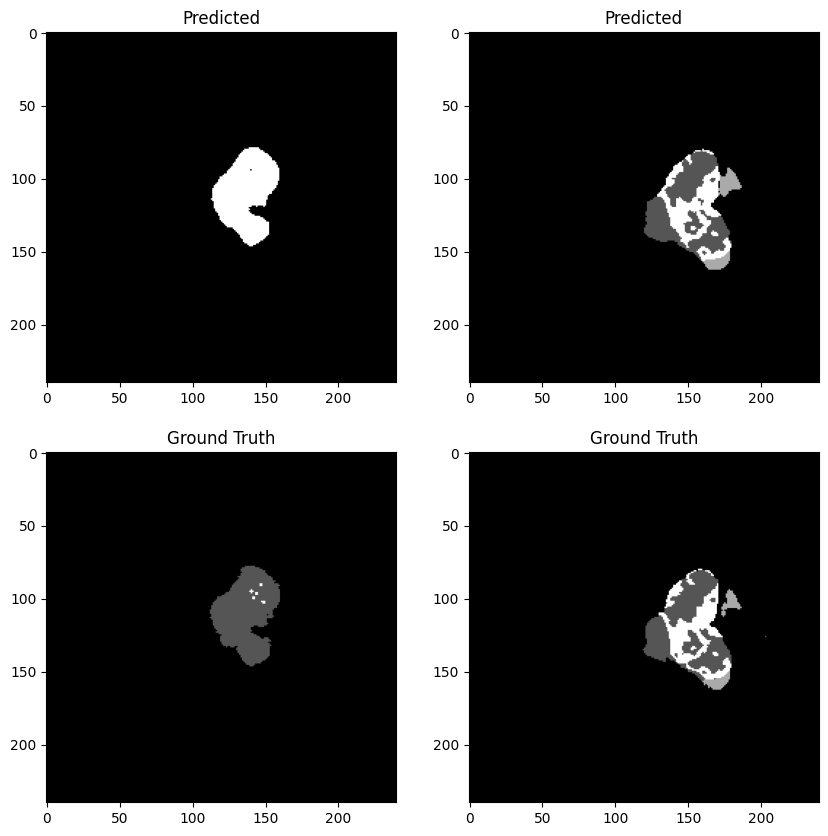

100%|██████████| 136/136 [20:24<00:00,  9.00s/it]



Average Training Loss: 0.007805857112329891

Average Training DSC: [0.99917486 0.88603196 0.92632472 0.75365941]
Average Training ASSD: [ 0.11647265 14.6504     12.53131426 24.28369997]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


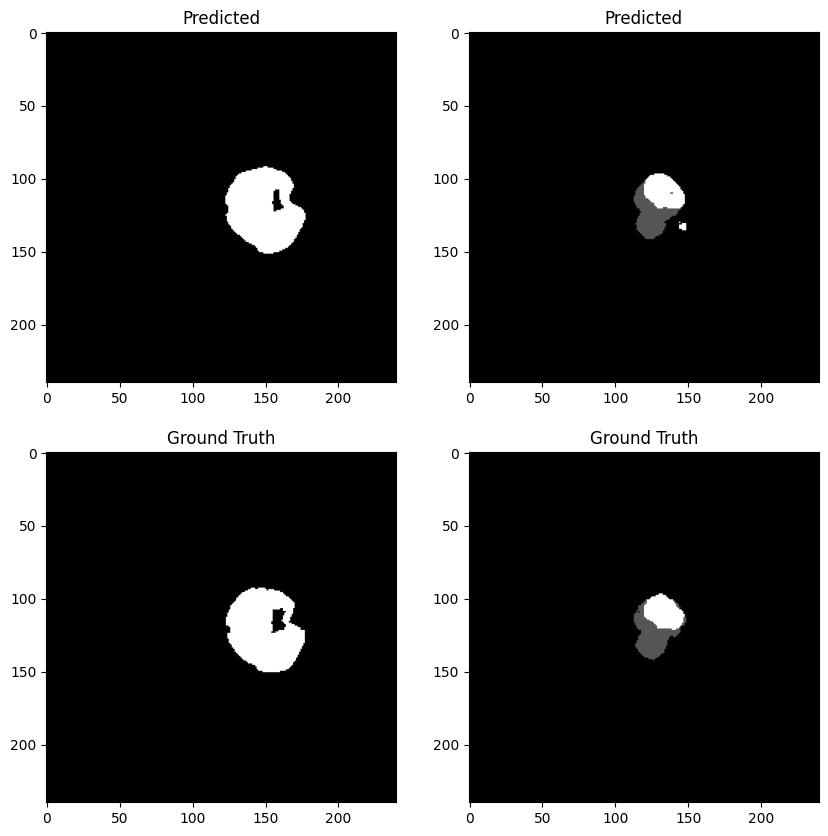

100%|██████████| 34/34 [05:13<00:00,  9.22s/it]


Average Validation Loss: 0.0117769240100375

Average Validation DSC: [0.99906752 0.85636406 0.92235103 0.7317859 ]
Average Validation ASSD: [ 0.13405522 21.58385231 11.66650714 22.78011089]
Epoch 66/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


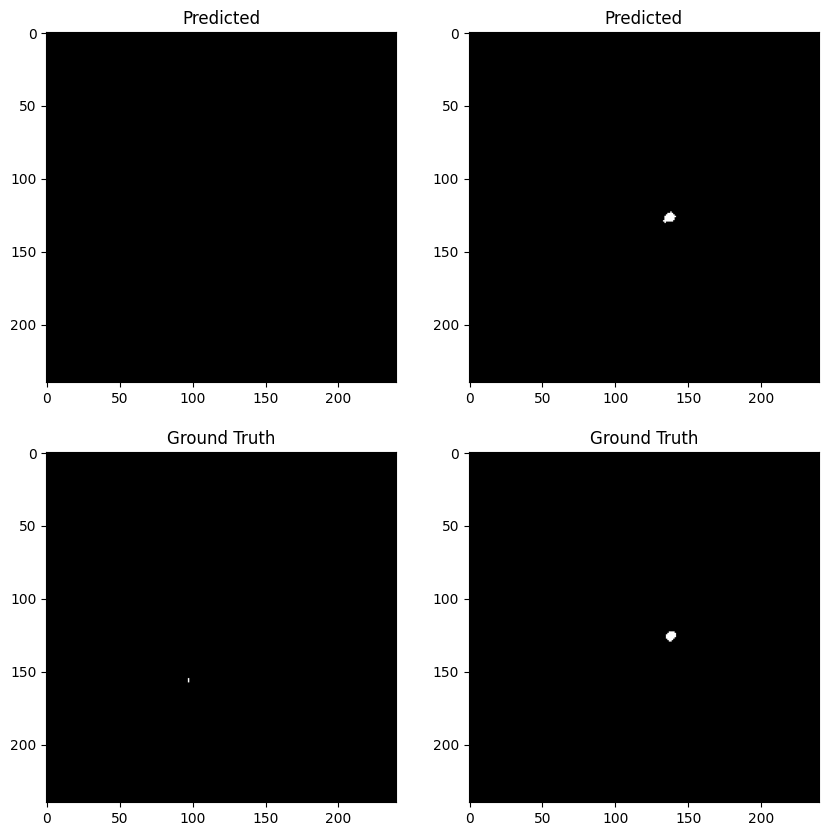

100%|██████████| 136/136 [21:06<00:00,  9.31s/it]



Average Training Loss: 0.007558795866583858

Average Training DSC: [0.99921421 0.88631677 0.9312753  0.76260704]
Average Training ASSD: [ 0.11243254 13.56962755 10.2746742  23.69555245]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


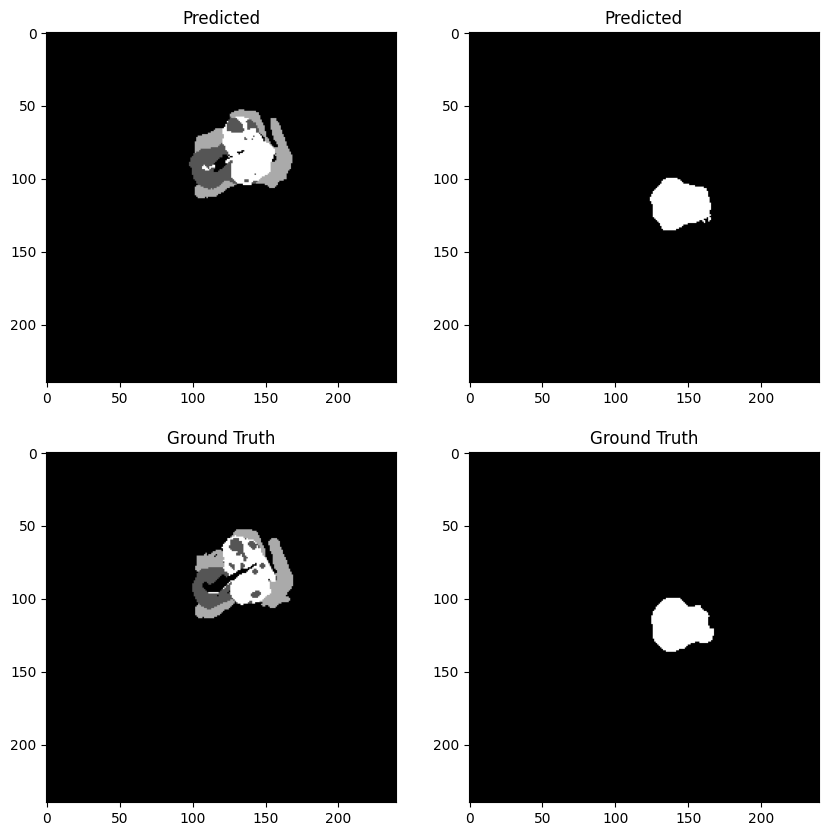

100%|██████████| 34/34 [04:59<00:00,  8.80s/it]


Average Validation Loss: 0.011594116975388983

Average Validation DSC: [0.99908641 0.86466822 0.93104687 0.74446929]
Average Validation ASSD: [ 0.12787763 18.19054507  8.27718192 20.46726792]
Epoch 67/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


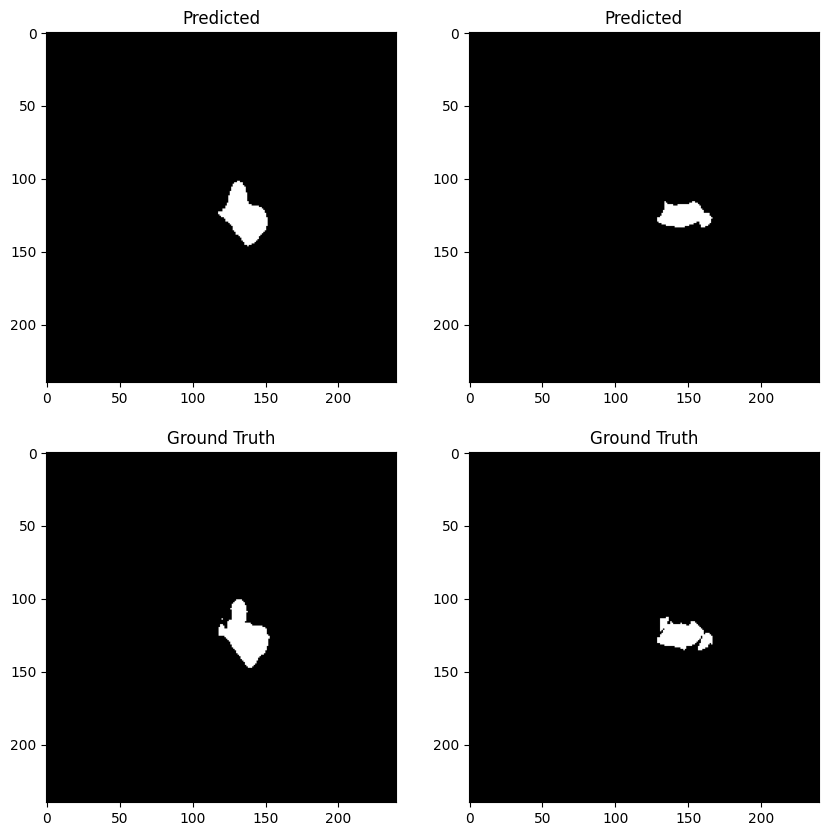

100%|██████████| 136/136 [20:20<00:00,  8.98s/it]



Average Training Loss: 0.0073163652867900535

Average Training DSC: [0.99921965 0.89623704 0.9310249  0.76444446]
Average Training ASSD: [ 0.10503131 11.47092691 10.68569497 23.41027696]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


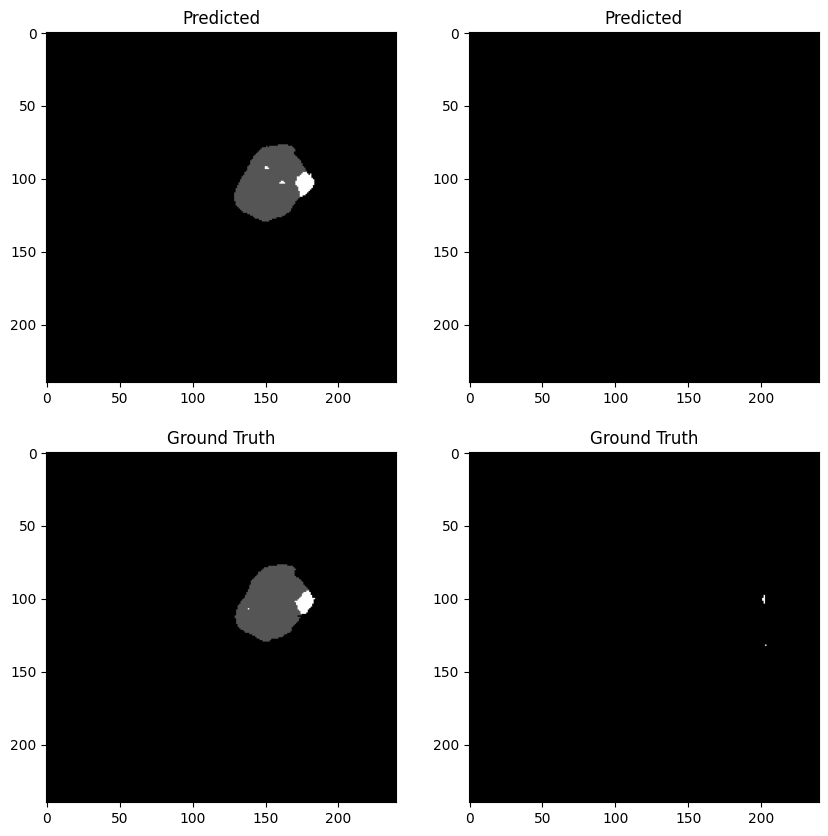

100%|██████████| 34/34 [05:32<00:00,  9.78s/it]


Average Validation Loss: 0.012623211190871456

Average Validation DSC: [0.99908093 0.84893048 0.93018629 0.74827162]
Average Validation ASSD: [ 0.13410217 25.22752534 10.33256161 19.88654183]
Epoch 68/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


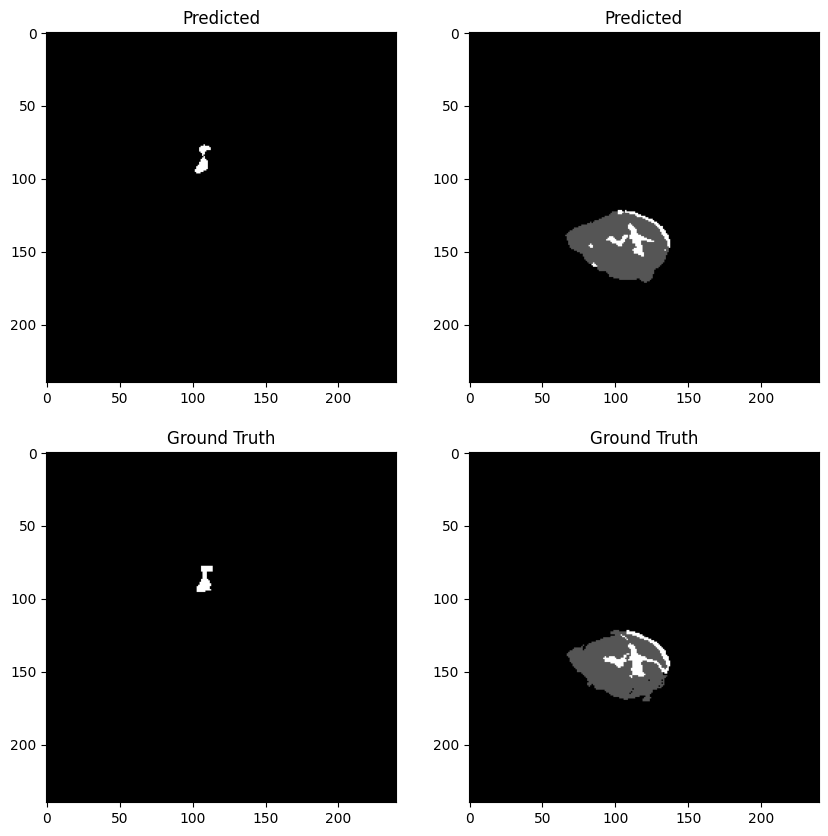

100%|██████████| 136/136 [21:39<00:00,  9.55s/it]



Average Training Loss: 0.008305652662837767

Average Training DSC: [0.99912106 0.87329861 0.92150627 0.74381388]
Average Training ASSD: [ 0.12581082 16.35306869 13.30506719 24.68663237]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


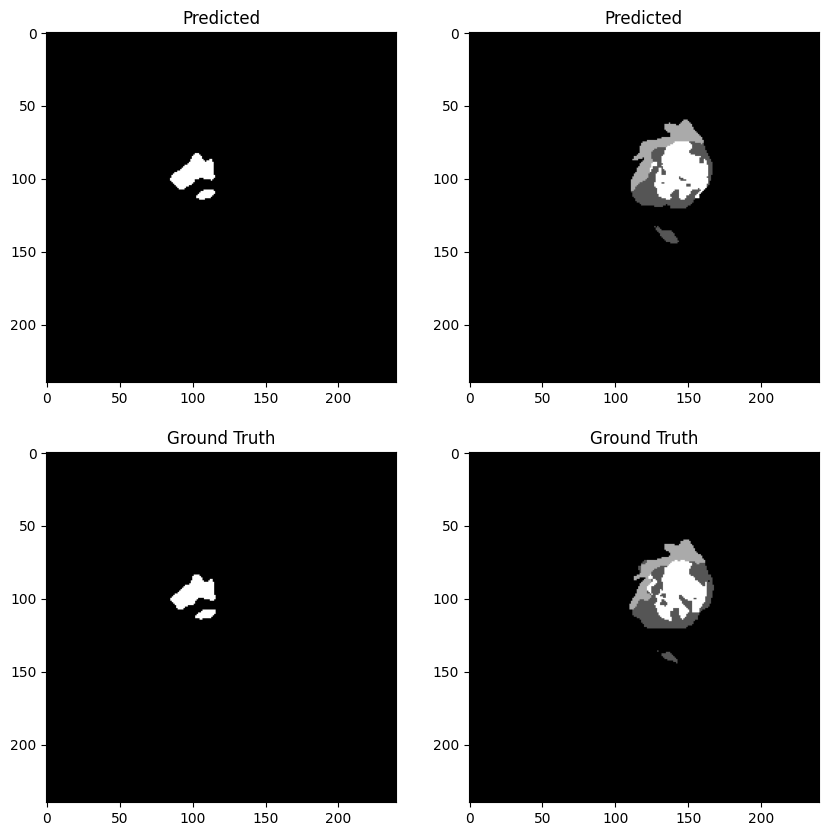

100%|██████████| 34/34 [05:05<00:00,  9.00s/it]


Average Validation Loss: 0.012275671038557501

Average Validation DSC: [0.99904844 0.85144365 0.92037584 0.7476121 ]
Average Validation ASSD: [ 0.12949375 21.05845882 11.09092028 19.20128301]
Epoch 69/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


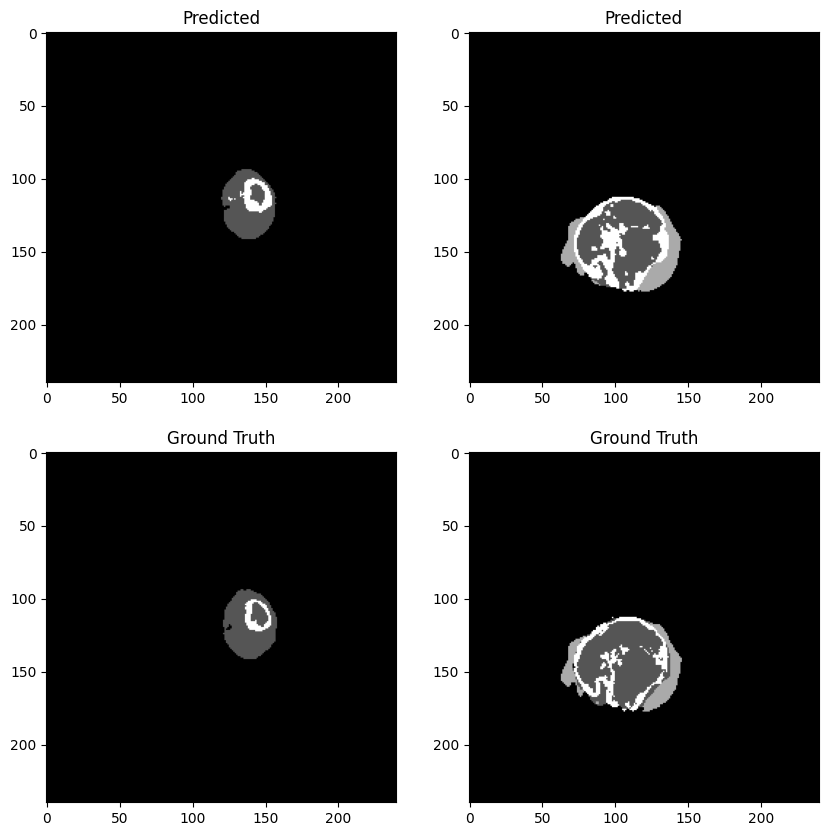

100%|██████████| 136/136 [20:31<00:00,  9.05s/it]



Average Training Loss: 0.00742141597370124

Average Training DSC: [0.99920826 0.88694529 0.93098592 0.7577931 ]
Average Training ASSD: [ 0.11153706 14.21443203 10.76686254 23.30269742]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


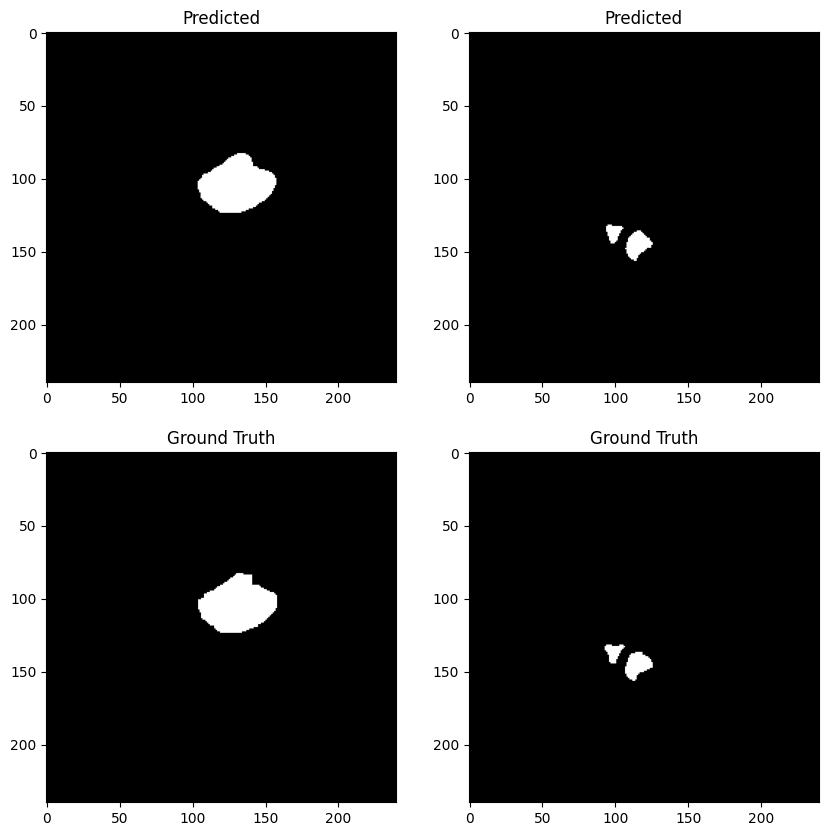

100%|██████████| 34/34 [04:38<00:00,  8.20s/it]


Average Validation Loss: 0.012635689187685357

Average Validation DSC: [0.99907555 0.85453696 0.92827124 0.72607925]
Average Validation ASSD: [ 0.16099001 18.98673575  8.1598918  27.57879182]
Epoch 70/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


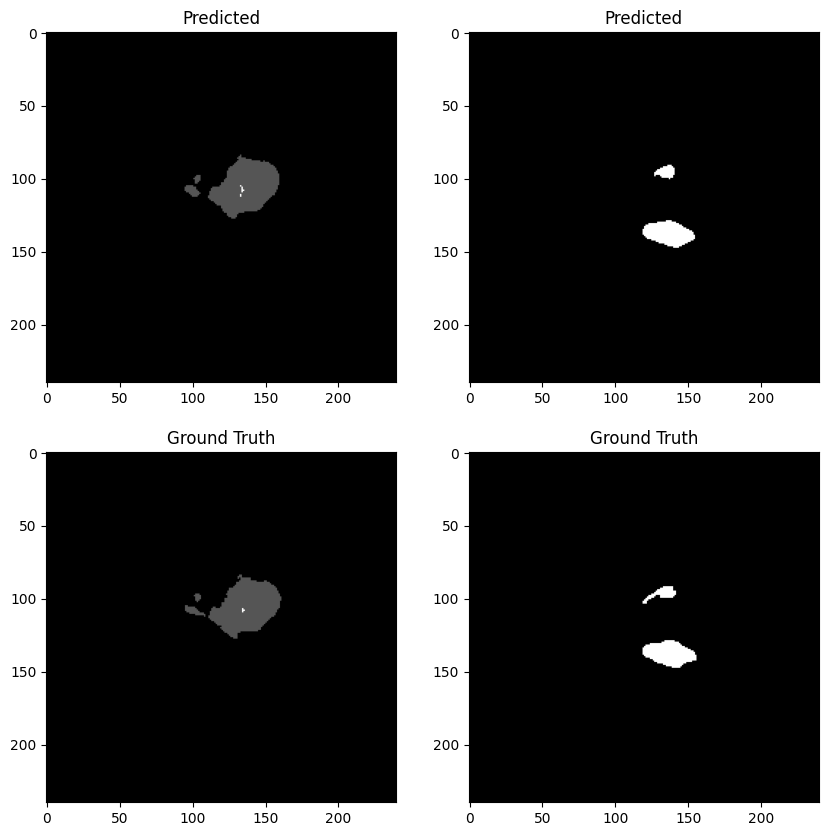

100%|██████████| 136/136 [20:53<00:00,  9.22s/it]



Average Training Loss: 0.0072246566106674865

Average Training DSC: [0.99921945 0.89036258 0.93275484 0.76490701]
Average Training ASSD: [ 0.10948271 13.47645735  9.7713215  23.5101813 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


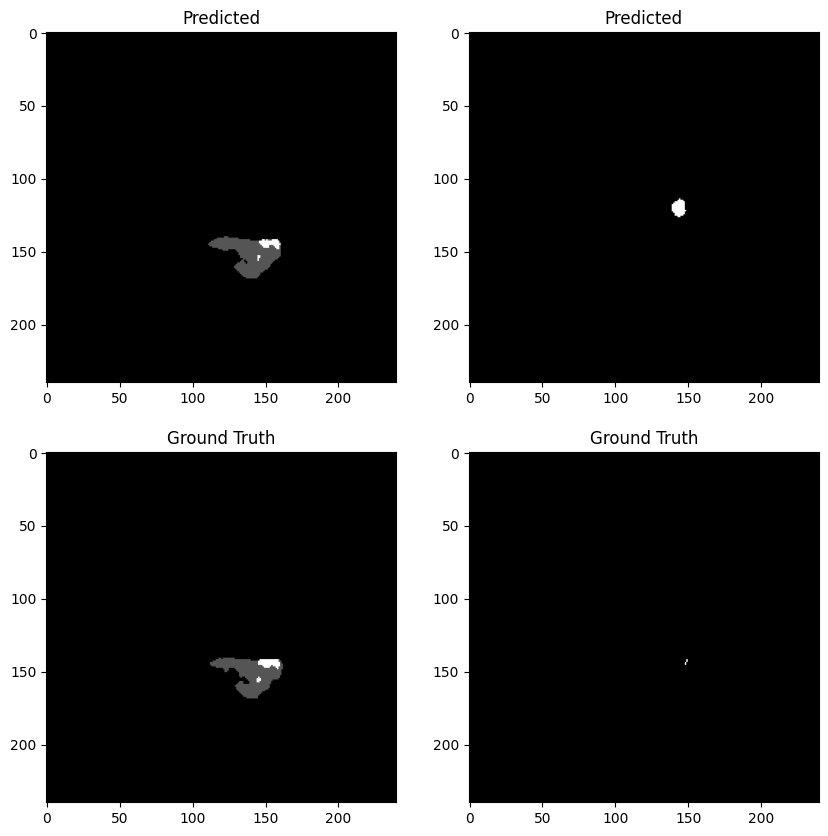

100%|██████████| 34/34 [04:52<00:00,  8.61s/it]


Average Validation Loss: 0.011114976245581228

Average Validation DSC: [0.99913176 0.86240295 0.93206263 0.74347577]
Average Validation ASSD: [ 0.12668069 20.31801146  8.45909764 20.07967446]
Epoch 71/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


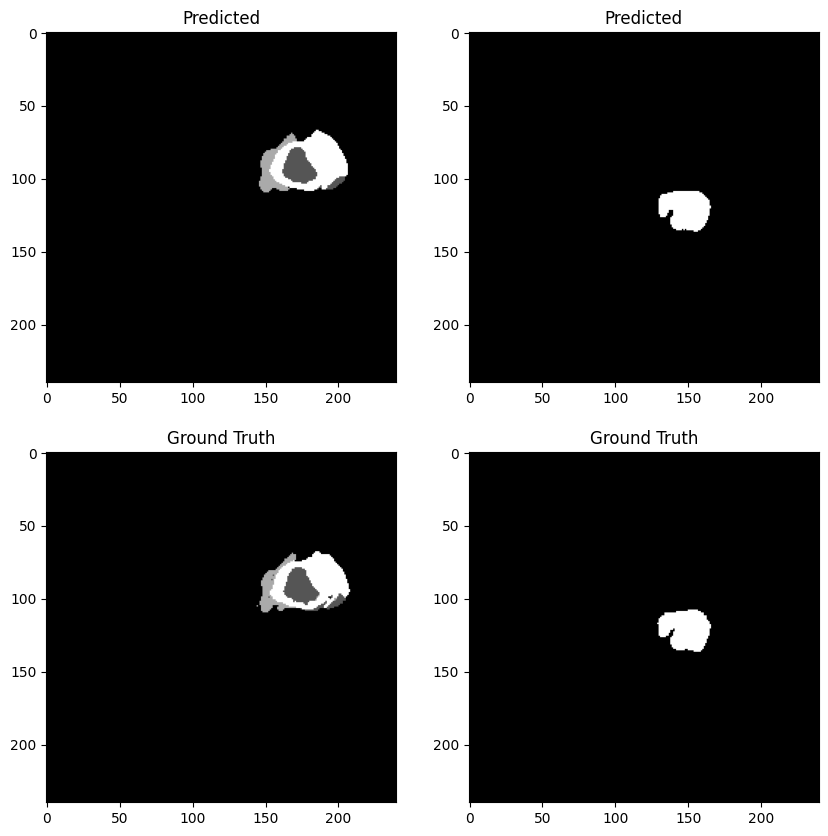

100%|██████████| 136/136 [20:19<00:00,  8.97s/it]



Average Training Loss: 0.0069351110004765145

Average Training DSC: [0.99925732 0.90098589 0.93461003 0.77373488]
Average Training ASSD: [ 0.10138593 11.11039892  9.7690329  23.18944032]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


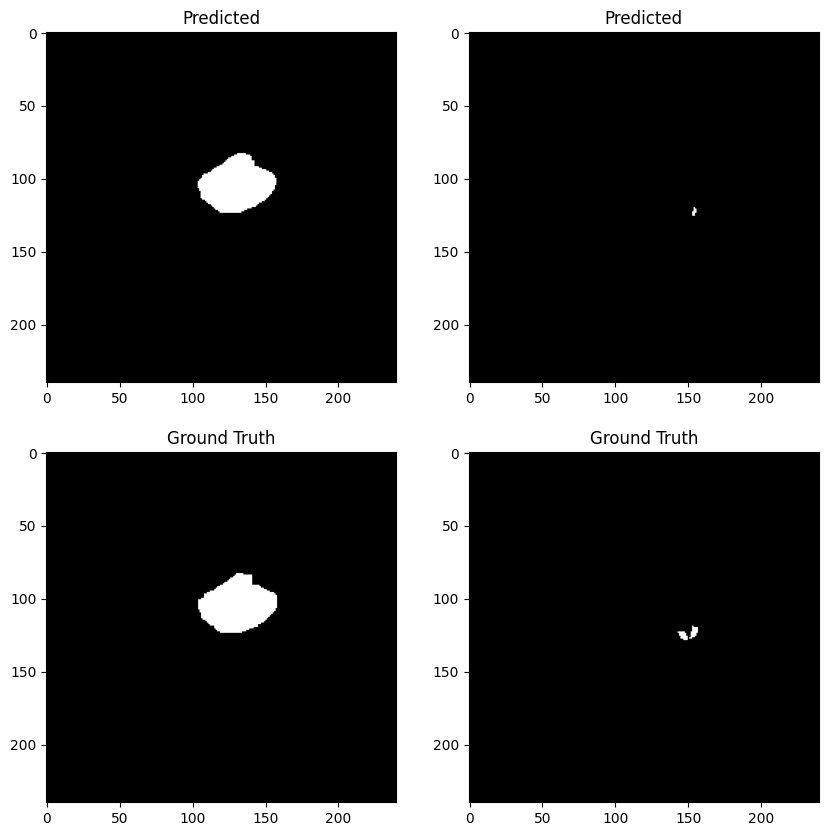

100%|██████████| 34/34 [05:07<00:00,  9.06s/it]


Average Validation Loss: 0.011665919836720122

Average Validation DSC: [0.99912664 0.86864705 0.93363426 0.74894141]
Average Validation ASSD: [ 0.13415895 17.90496192  8.2743375  21.49064415]
Epoch 72/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


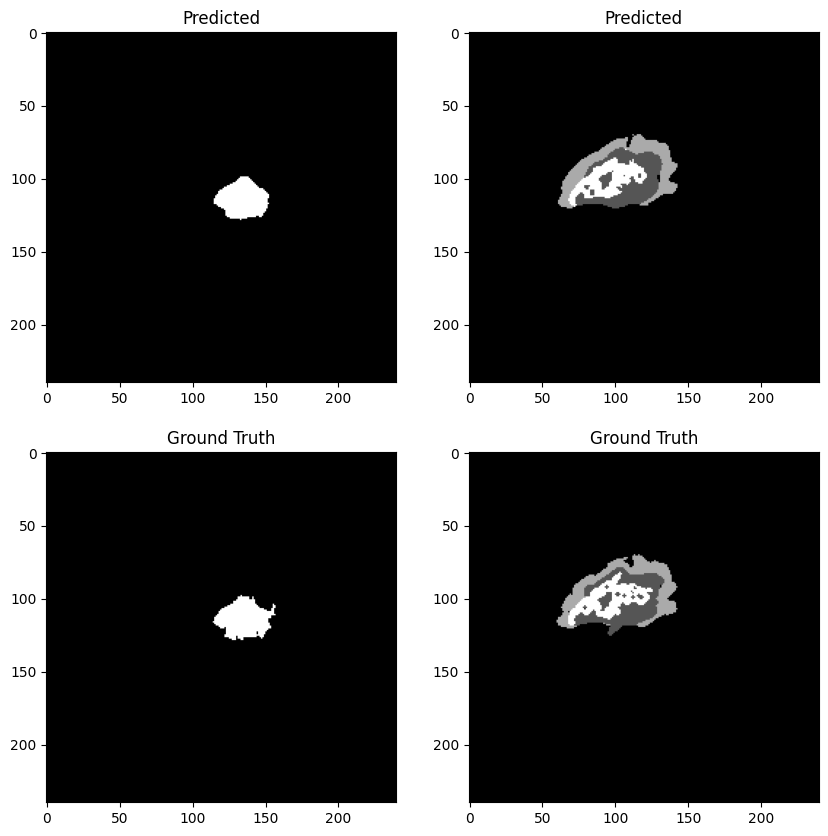

100%|██████████| 136/136 [20:49<00:00,  9.19s/it]



Average Training Loss: 0.006465508862782051

Average Training DSC: [0.9993041  0.91097759 0.94068309 0.78607057]
Average Training ASSD: [ 0.0928756   8.50941441  8.41024902 22.19799796]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


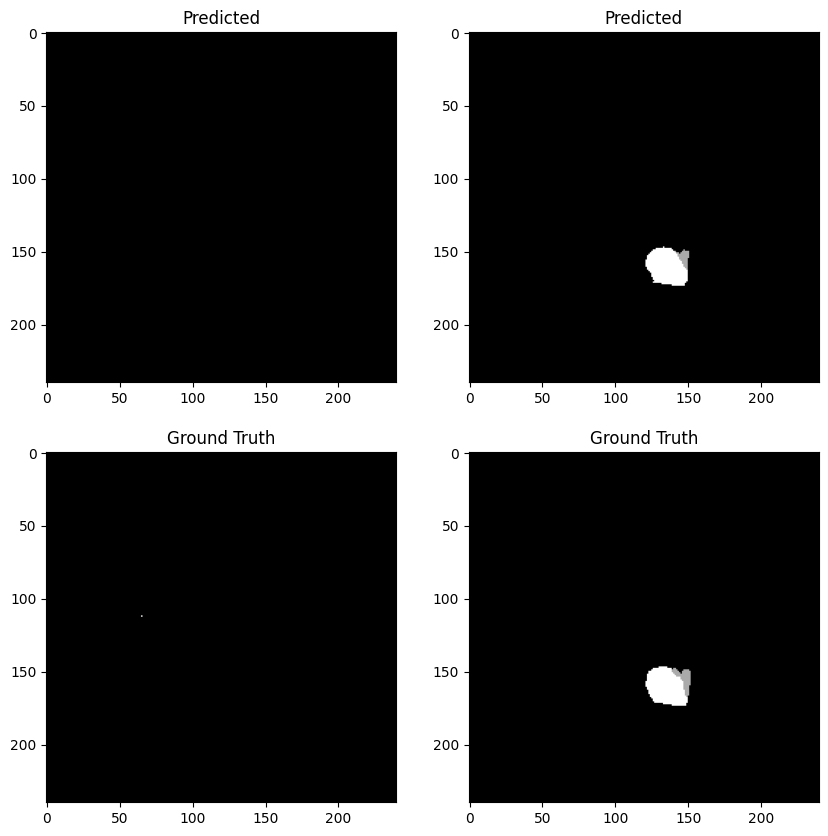

100%|██████████| 34/34 [04:52<00:00,  8.59s/it]


Average Validation Loss: 0.012341841822490096

Average Validation DSC: [0.99896366 0.85337116 0.92606776 0.75644174]
Average Validation ASSD: [ 0.14528773 18.99135396  8.31155435 16.52382731]
Epoch 73/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


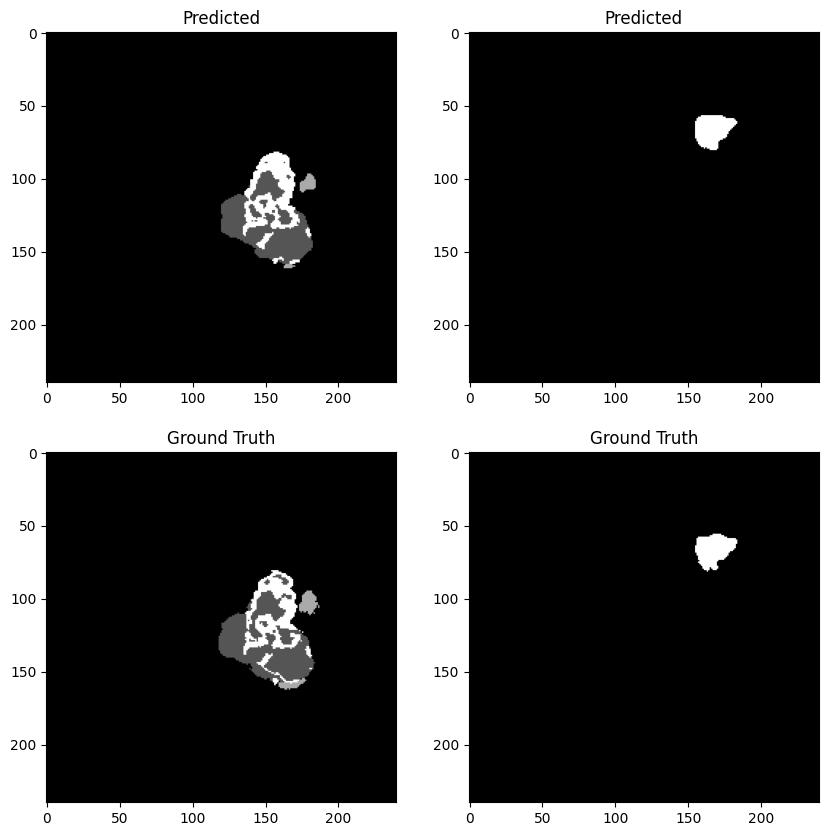

100%|██████████| 136/136 [20:58<00:00,  9.25s/it]



Average Training Loss: 0.006876141243778607

Average Training DSC: [0.99925524 0.89146589 0.93434041 0.77789407]
Average Training ASSD: [ 0.10167908 13.8659861  10.3247192  22.36817999]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


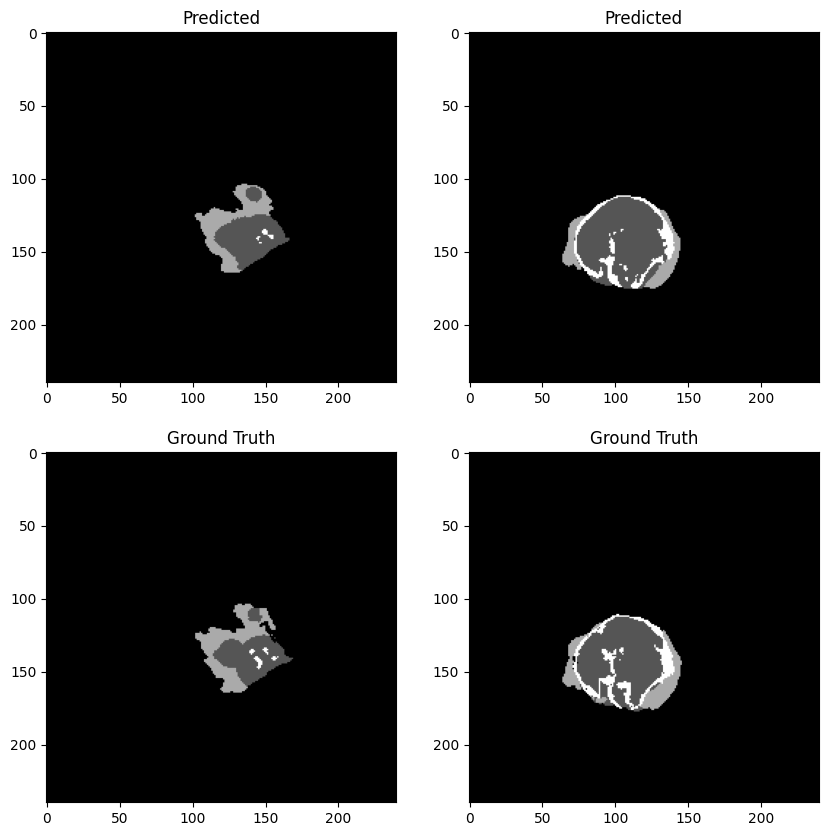

100%|██████████| 34/34 [04:52<00:00,  8.59s/it]


Average Validation Loss: 0.011505392380058765

Average Validation DSC: [0.99913803 0.87117863 0.932346   0.74835608]
Average Validation ASSD: [ 0.1320237  18.47731967  8.63262434 22.85324459]
Epoch 74/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


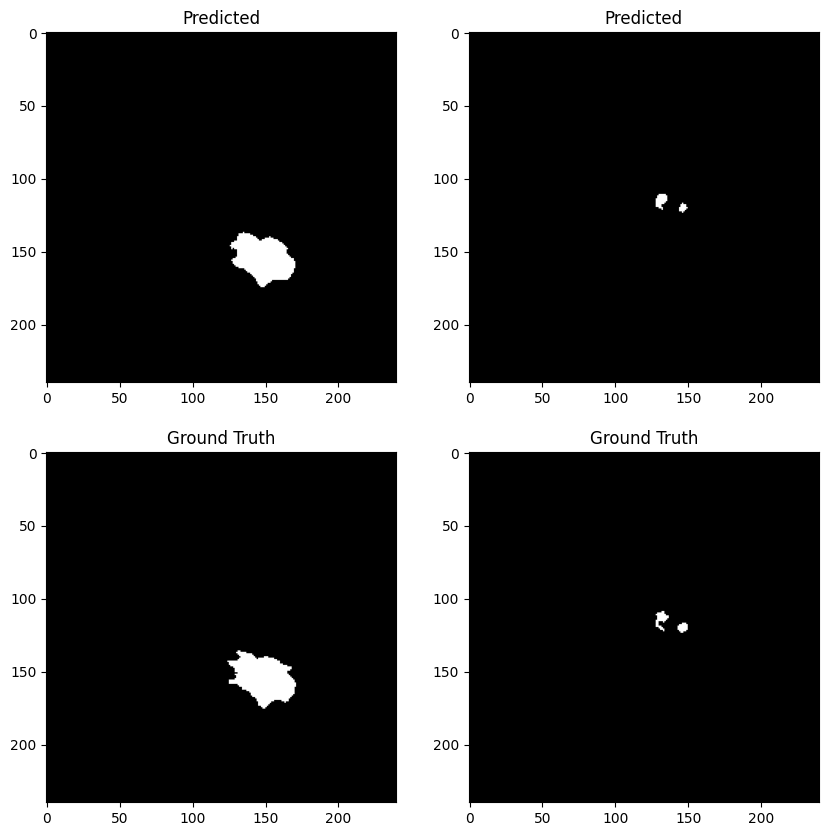

100%|██████████| 136/136 [20:59<00:00,  9.26s/it]



Average Training Loss: 0.006452195877072346

Average Training DSC: [0.9993026  0.90681274 0.94311151 0.78527033]
Average Training ASSD: [ 0.09531343  9.34650267  7.81156829 21.81700803]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


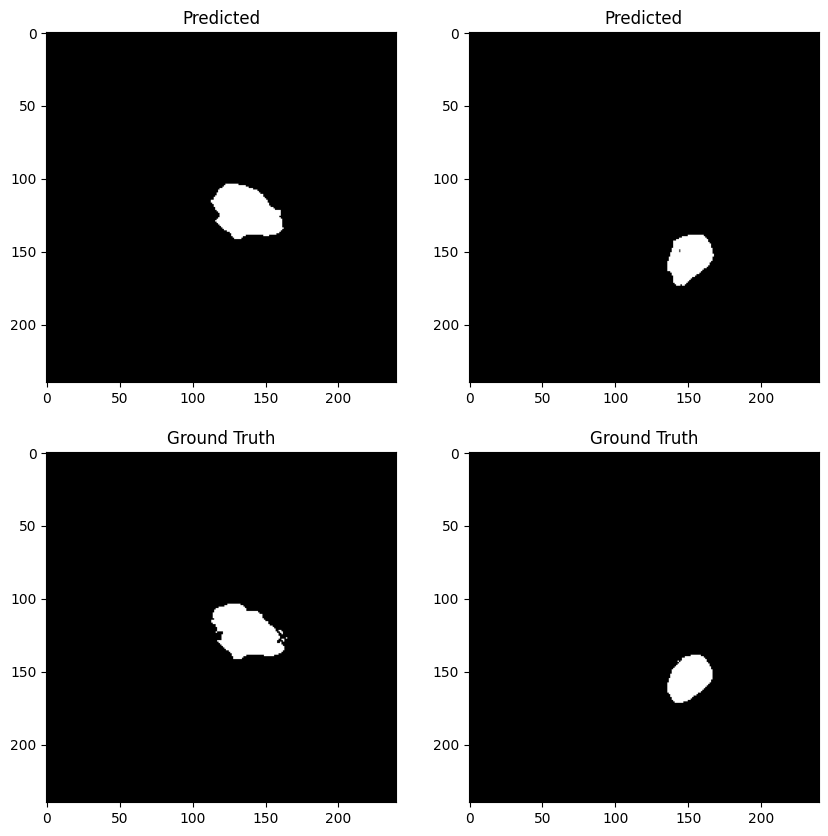

100%|██████████| 34/34 [05:09<00:00,  9.10s/it]


Average Validation Loss: 0.012394819888012373

Average Validation DSC: [0.99911032 0.86061148 0.9315484  0.74319766]
Average Validation ASSD: [ 0.11489474 20.84157562  9.62797217 19.22694364]
Epoch 75/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


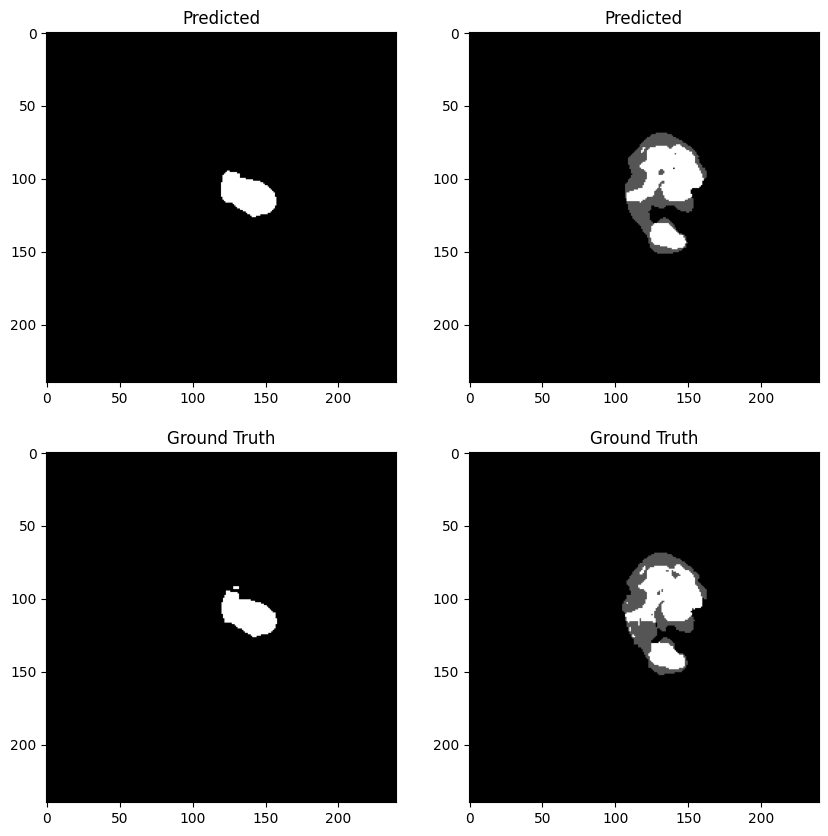

100%|██████████| 136/136 [20:17<00:00,  8.95s/it]



Average Training Loss: 0.006284563363913228

Average Training DSC: [0.99931355 0.90354897 0.94096191 0.78764803]
Average Training ASSD: [ 0.09381396 11.17303458  8.23381089 21.98066686]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


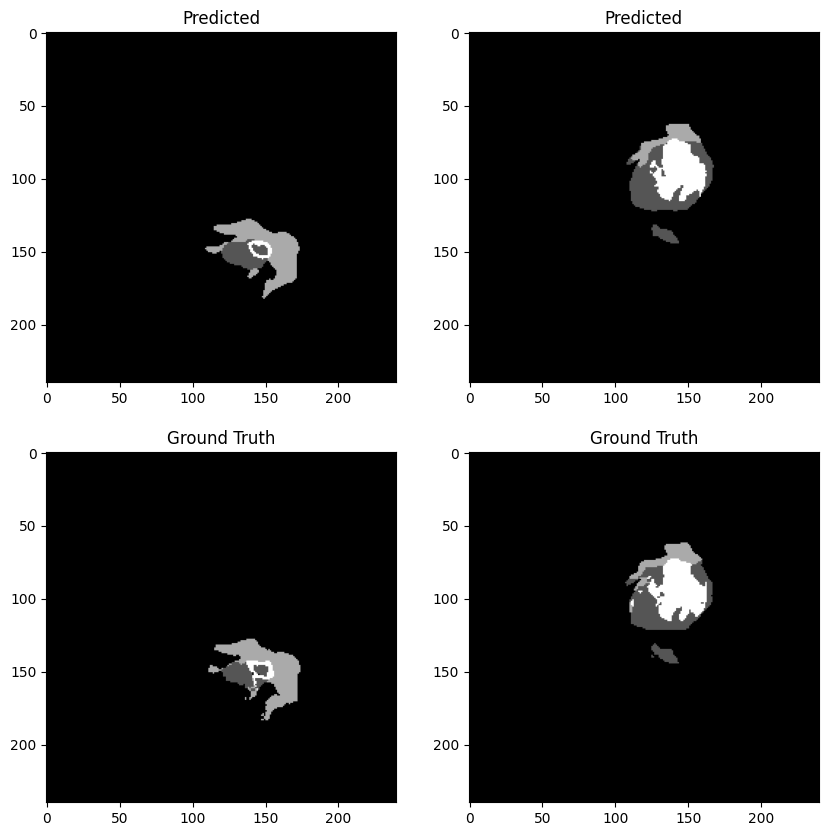

100%|██████████| 34/34 [05:06<00:00,  9.03s/it]


Average Validation Loss: 0.012227596537045696

Average Validation DSC: [0.99910899 0.85097925 0.93194728 0.74291287]
Average Validation ASSD: [ 0.12782083 22.98681913  8.11891236 21.64279418]
Epoch 76/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


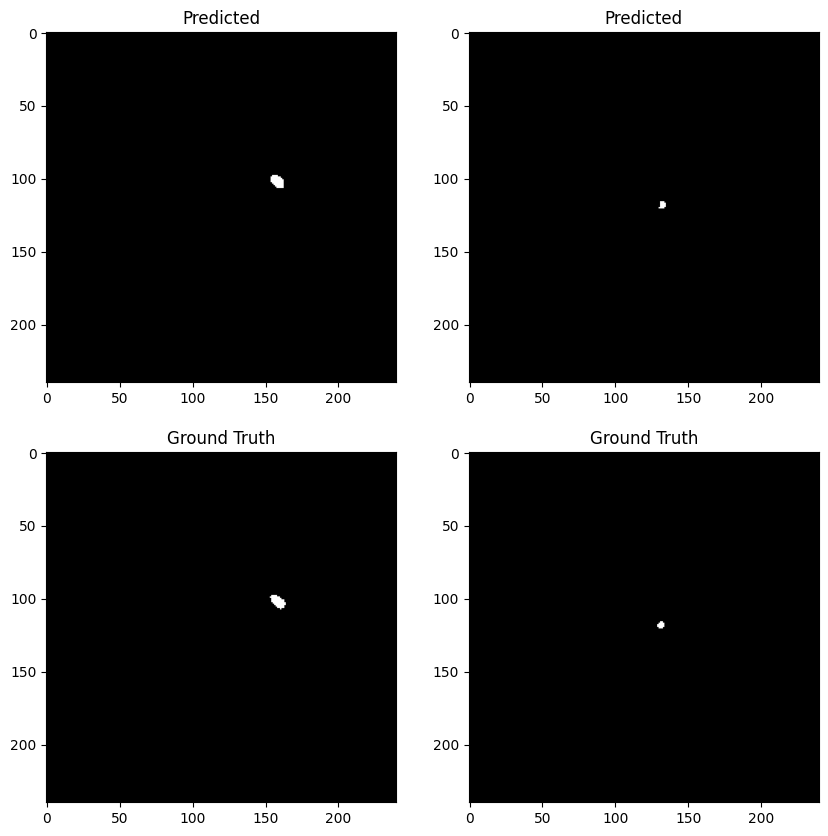

100%|██████████| 136/136 [21:04<00:00,  9.30s/it]



Average Training Loss: 0.0064549753990243465

Average Training DSC: [0.99931289 0.89922243 0.93721356 0.78422964]
Average Training ASSD: [ 0.092689   12.74998497  9.48888276 21.00962998]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


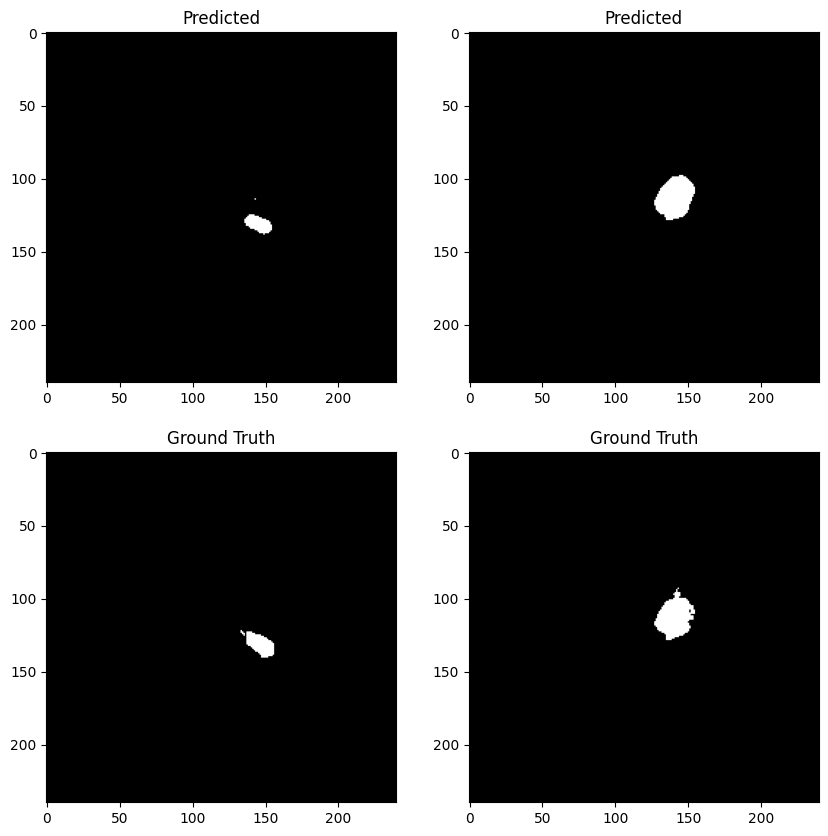

100%|██████████| 34/34 [04:58<00:00,  8.77s/it]


Average Validation Loss: 0.012268119039671385

Average Validation DSC: [0.99903431 0.85811703 0.91620057 0.75772691]
Average Validation ASSD: [ 0.12007738 21.92905909 13.61222134 17.2473584 ]
Epoch 77/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


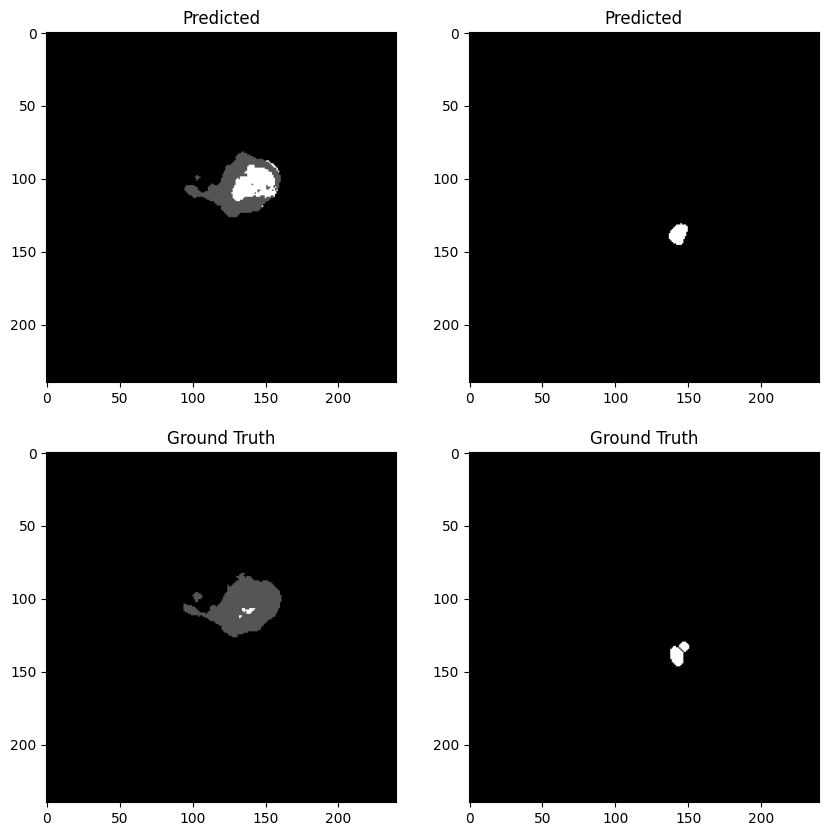

100%|██████████| 136/136 [20:36<00:00,  9.09s/it]



Average Training Loss: 0.0065787166411824085

Average Training DSC: [0.99928096 0.90497167 0.9373465  0.78674228]
Average Training ASSD: [ 0.09552047 10.58104549  9.57857396 18.93897631]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


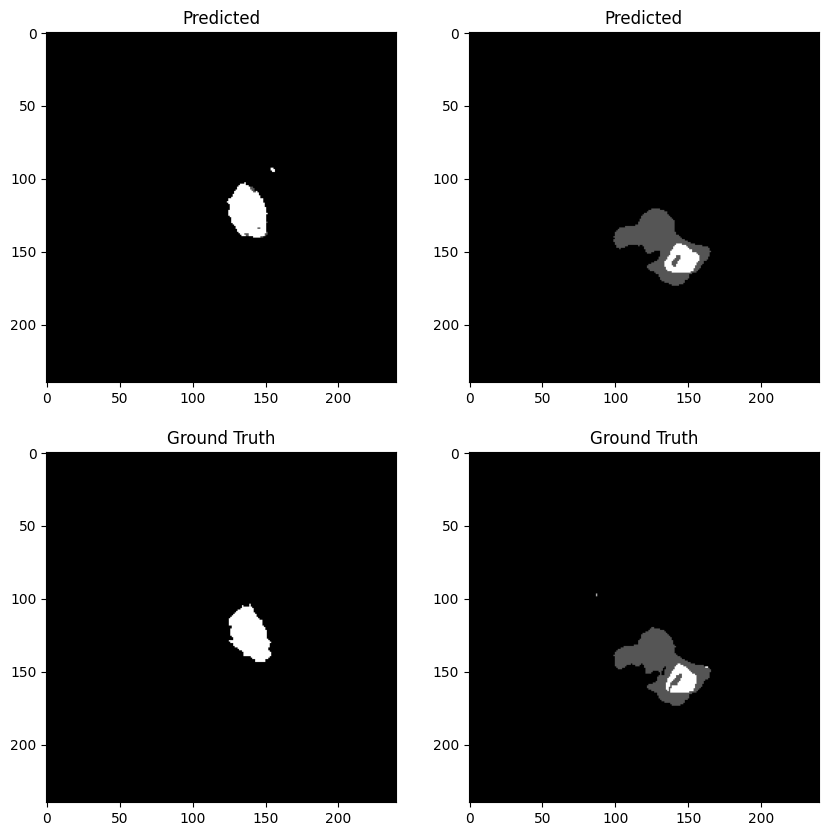

100%|██████████| 34/34 [04:54<00:00,  8.66s/it]


Average Validation Loss: 0.010054436991648638

Average Validation DSC: [0.99919958 0.84561045 0.93903982 0.76499793]
Average Validation ASSD: [ 0.11403078 24.80943099  7.25023468 17.61657942]
Epoch 78/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


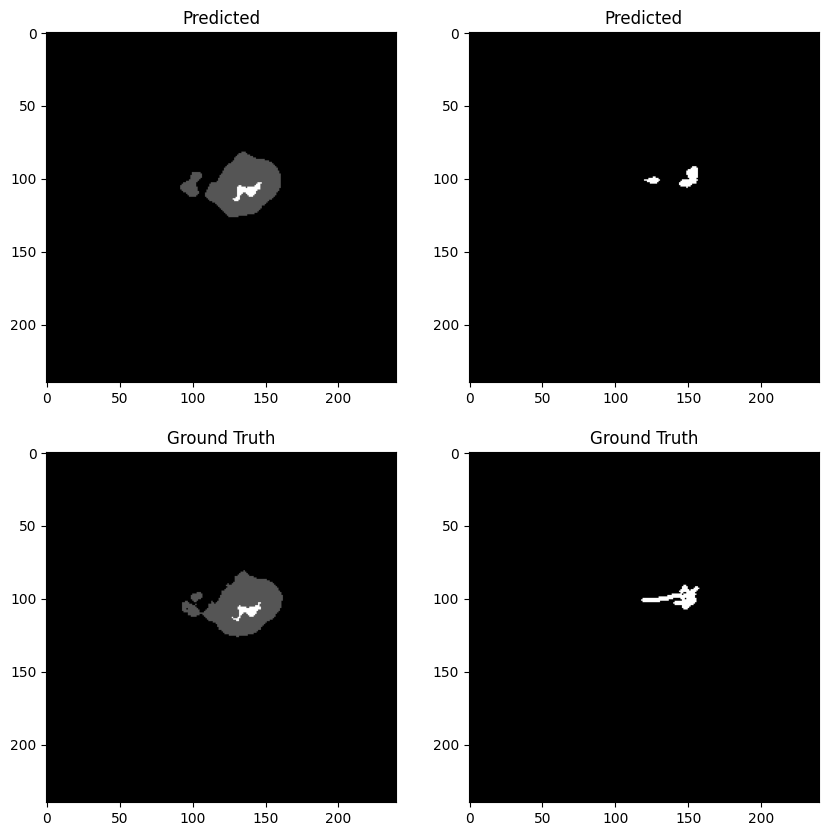

100%|██████████| 136/136 [20:56<00:00,  9.24s/it]



Average Training Loss: 0.008460272634264958

Average Training DSC: [0.9991286  0.8736261  0.90231667 0.76180686]
Average Training ASSD: [ 0.13630753 18.49796645 19.89426679 22.95168162]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


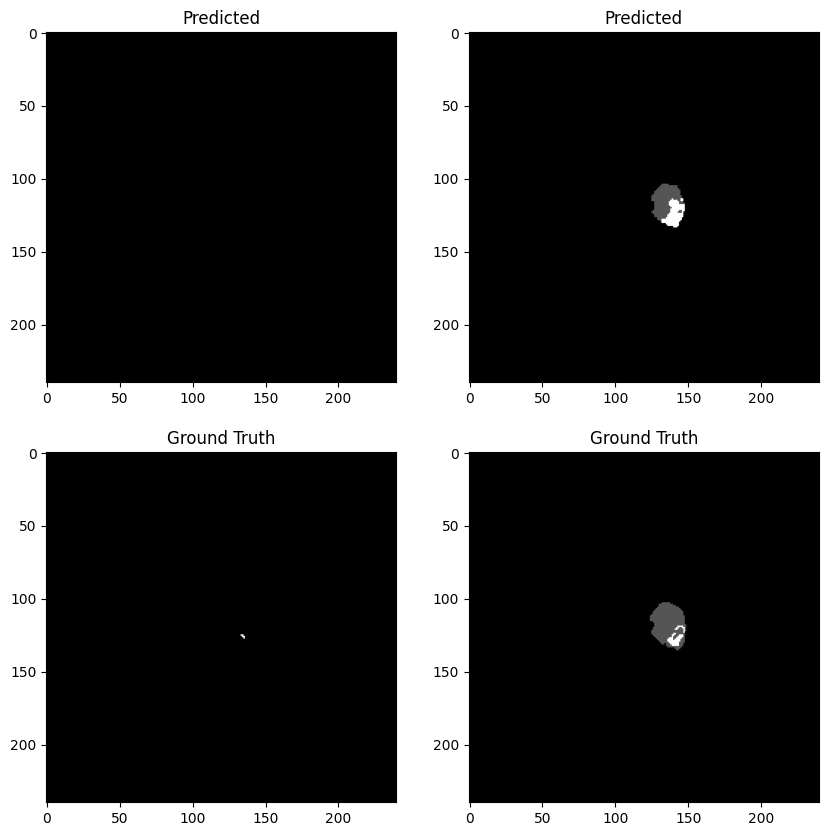

100%|██████████| 34/34 [05:05<00:00,  8.98s/it]


Average Validation Loss: 0.01718174118329497

Average Validation DSC: [0.99866608 0.74656102 0.84285844 0.58337608]
Average Validation ASSD: [ 0.20329927 48.09006782 34.43244808 44.92013107]
Epoch 79/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


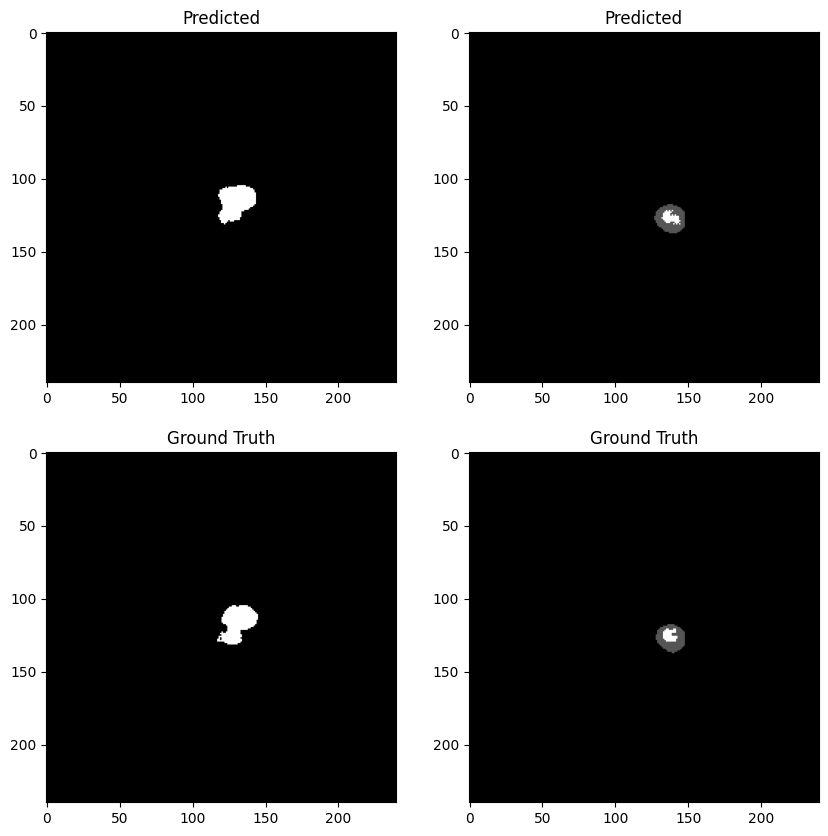

100%|██████████| 136/136 [21:24<00:00,  9.45s/it]



Average Training Loss: 0.00833025503465358

Average Training DSC: [0.9991071  0.8711892  0.92222996 0.74642203]
Average Training ASSD: [ 0.13115171 18.08522879 13.13705642 22.70719852]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


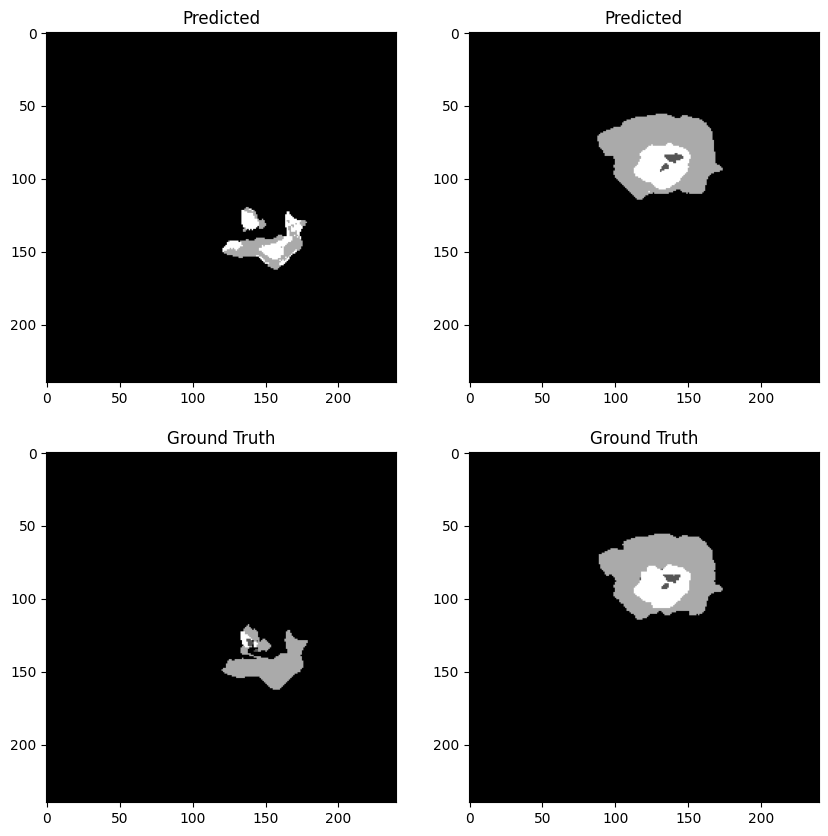

100%|██████████| 34/34 [04:55<00:00,  8.68s/it]


Average Validation Loss: 0.011744621771332972

Average Validation DSC: [0.99914127 0.86505067 0.93084915 0.75643364]
Average Validation ASSD: [ 0.12417368 18.68030755  8.6805941  18.66112822]
Epoch 80/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


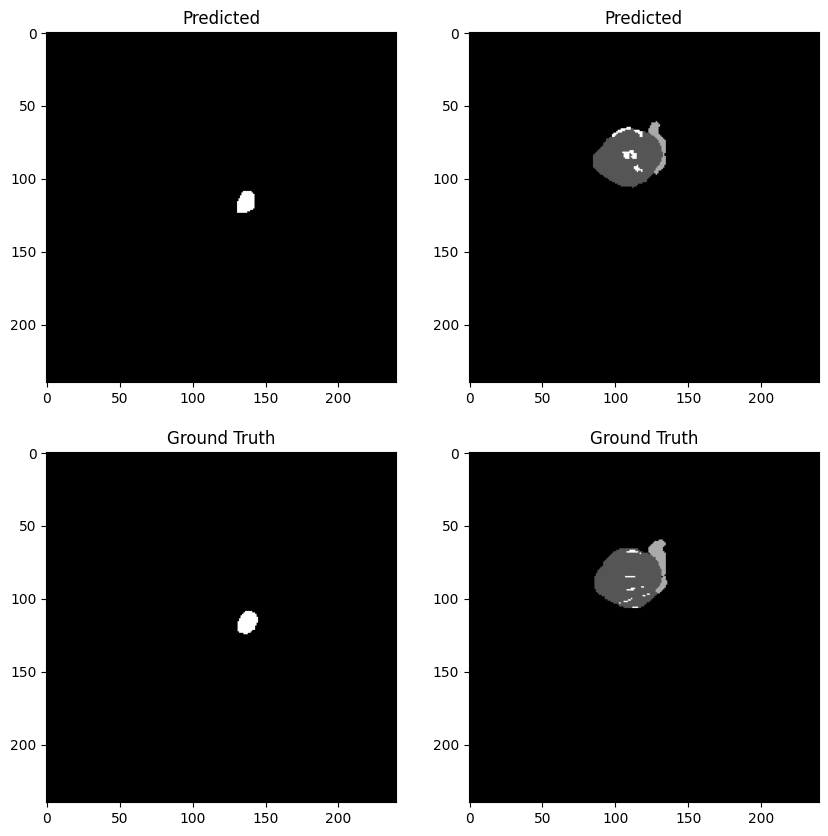

100%|██████████| 136/136 [20:33<00:00,  9.07s/it]



Average Training Loss: 0.006834968719083597

Average Training DSC: [0.99926433 0.8983897  0.92985149 0.78008879]
Average Training ASSD: [ 0.10254701 12.18905054 12.08278853 21.86302735]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


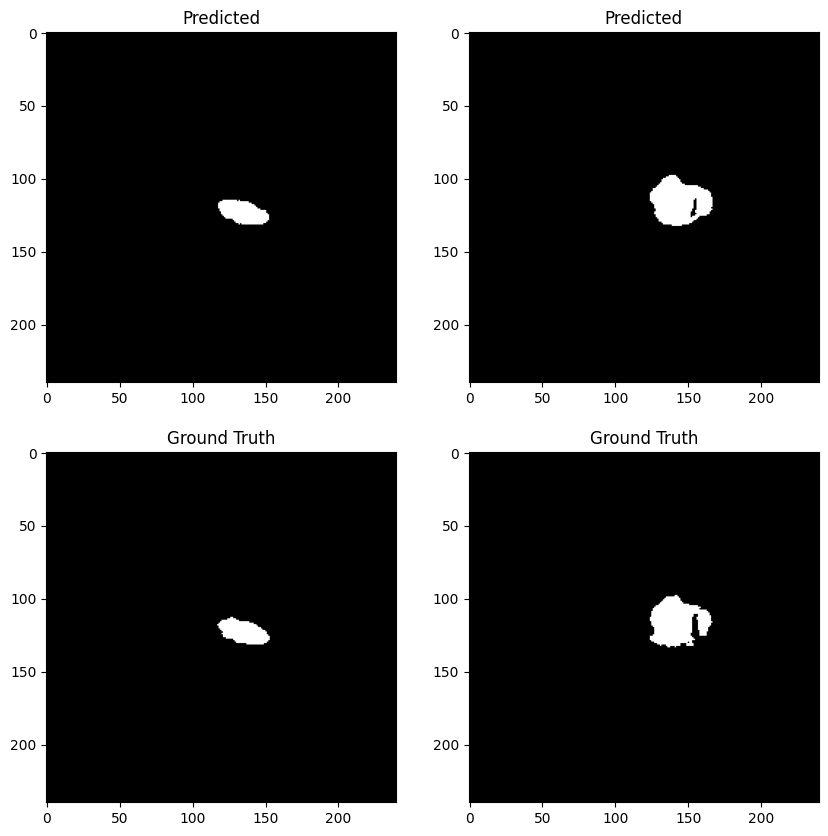

100%|██████████| 34/34 [05:07<00:00,  9.04s/it]


Average Validation Loss: 0.010985252105028313

Average Validation DSC: [0.99913106 0.87011485 0.93664608 0.75046779]
Average Validation ASSD: [ 0.13244779 18.56543605  8.32646153 22.7970388 ]
Epoch 81/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


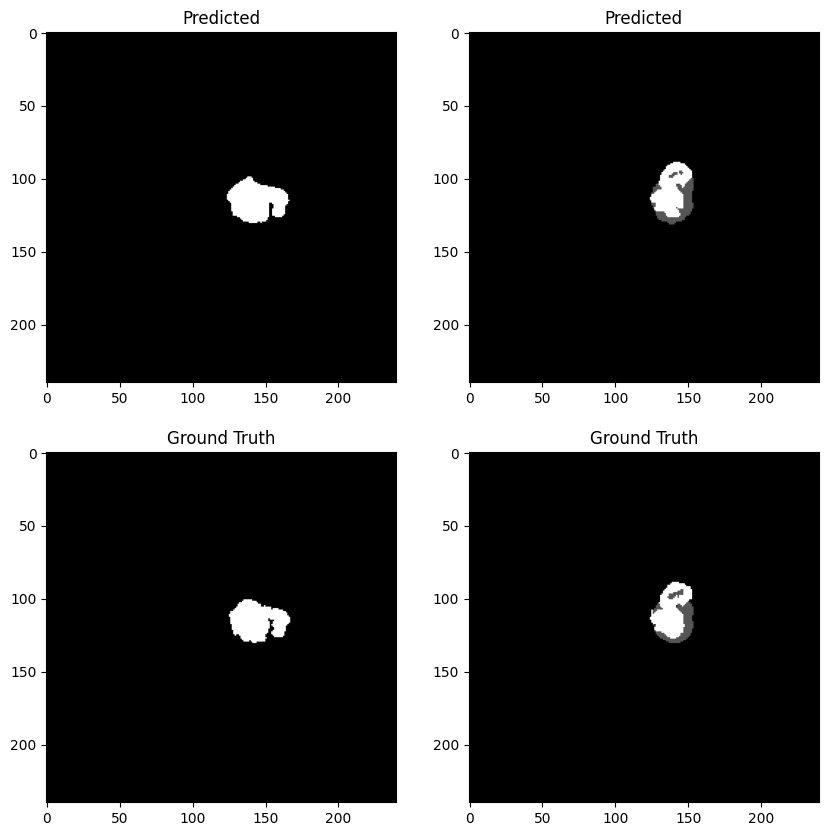

100%|██████████| 136/136 [20:38<00:00,  9.11s/it]



Average Training Loss: 0.006699172303984489

Average Training DSC: [0.99928753 0.89811277 0.92971754 0.78366369]
Average Training ASSD: [ 0.10869789 12.75088544 12.16118456 21.50667108]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


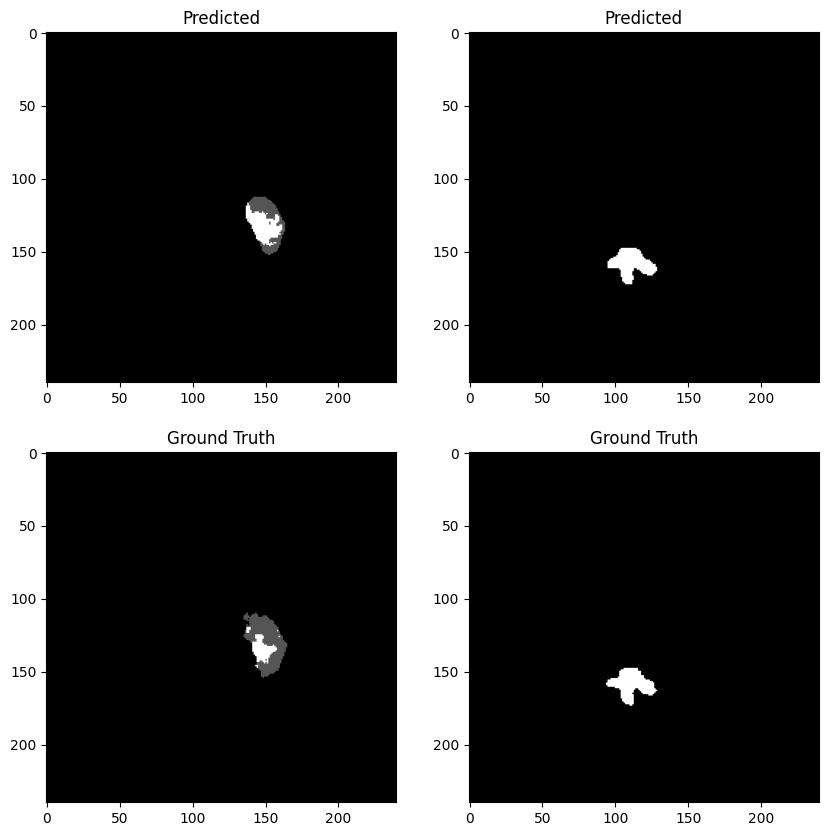

100%|██████████| 34/34 [04:52<00:00,  8.60s/it]


Average Validation Loss: 0.012534438947434811

Average Validation DSC: [0.9990416  0.78024041 0.91686267 0.72836207]
Average Validation ASSD: [ 0.16270857 41.16234811 11.01425466 16.25692659]
Epoch 82/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


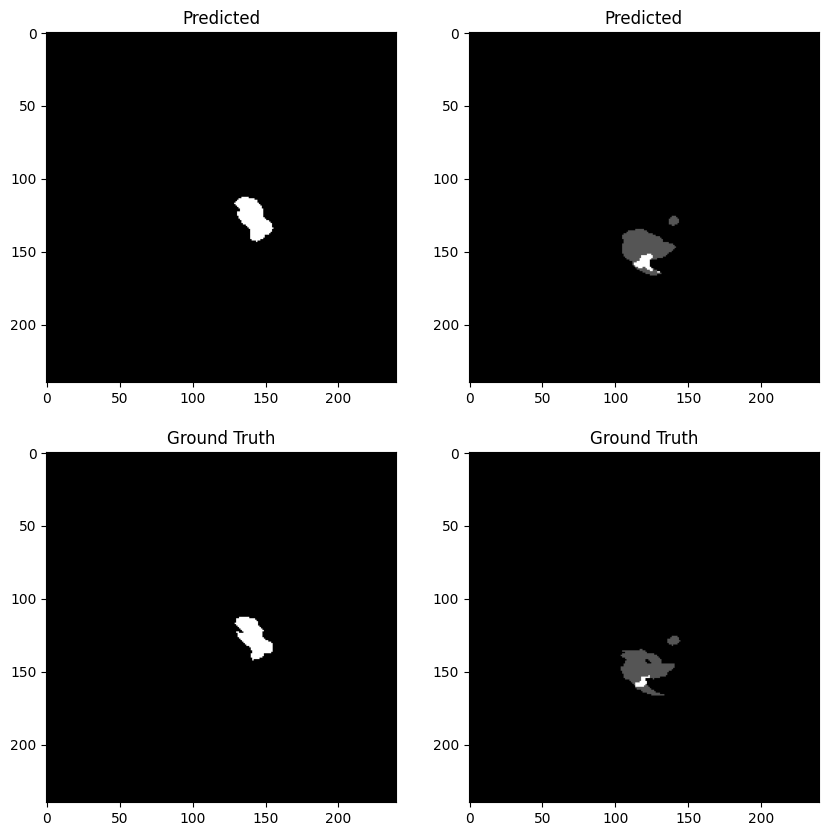

100%|██████████| 136/136 [20:57<00:00,  9.25s/it]



Average Training Loss: 0.008398777695701402

Average Training DSC: [0.99910319 0.87089793 0.92085404 0.74284976]
Average Training ASSD: [ 0.13544944 18.26454115 13.20357722 24.67500384]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


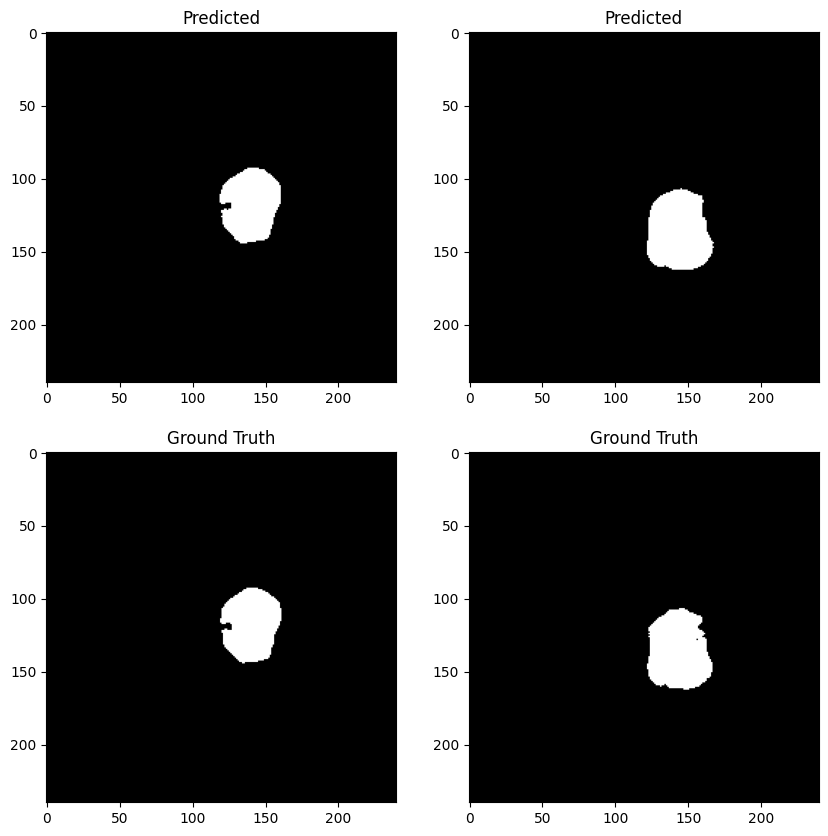

100%|██████████| 34/34 [05:01<00:00,  8.87s/it]


Average Validation Loss: 0.01163303739774753

Average Validation DSC: [0.99911773 0.85814833 0.93190904 0.74897579]
Average Validation ASSD: [ 0.12845582 21.67974026  8.27680488 19.96022015]
Epoch 83/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


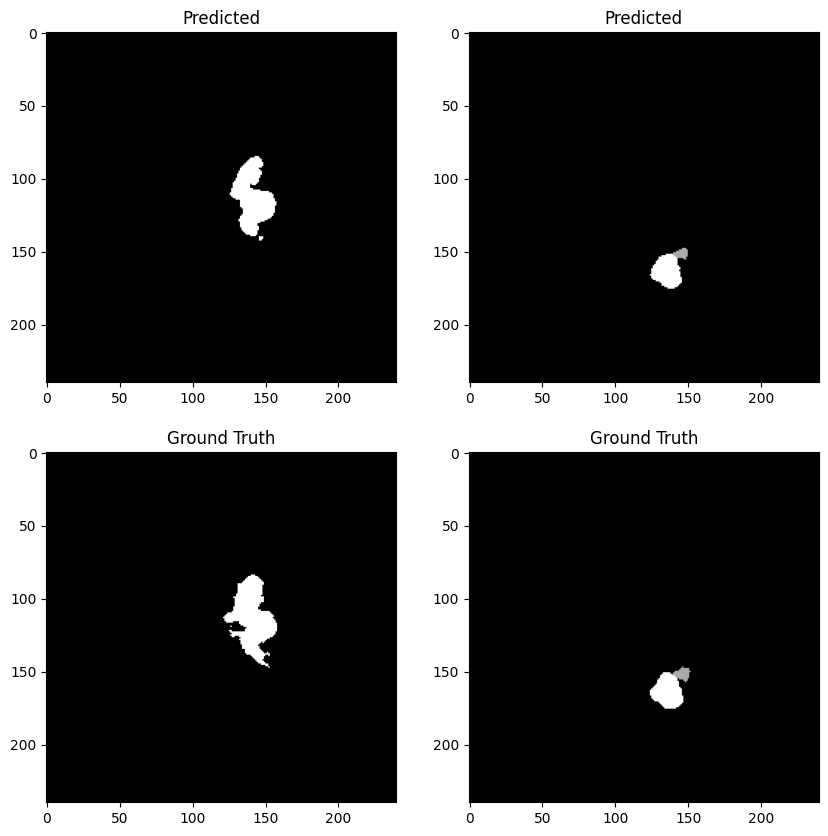

100%|██████████| 136/136 [20:58<00:00,  9.25s/it]



Average Training Loss: 0.007179763493374647

Average Training DSC: [0.99925544 0.89710716 0.92911014 0.77925342]
Average Training ASSD: [ 0.12335189 12.77883023 12.74866766 22.22496903]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


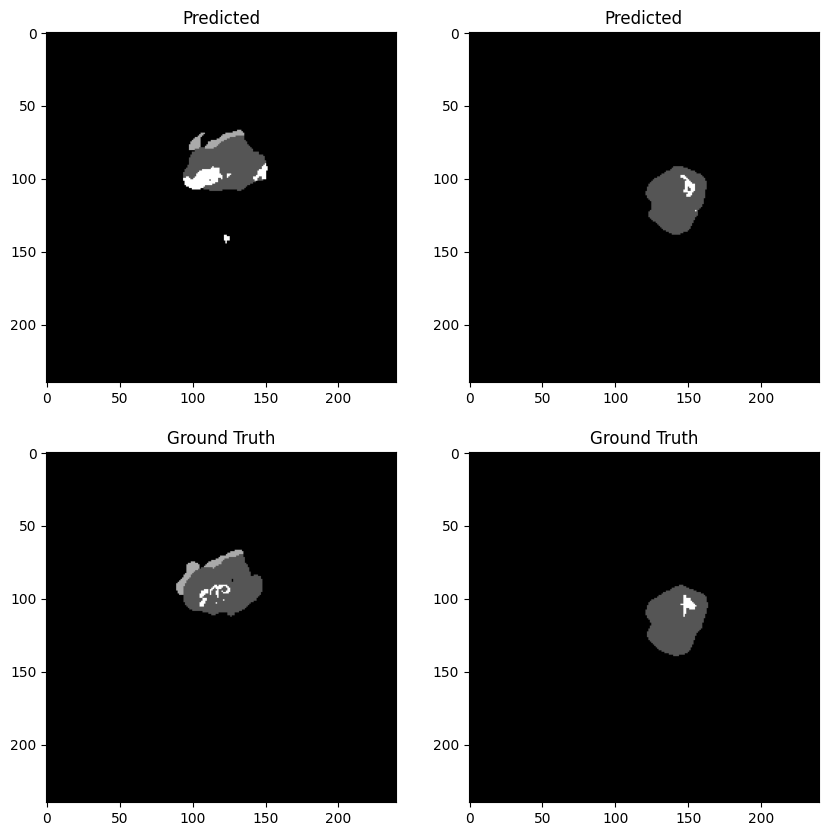

100%|██████████| 34/34 [05:01<00:00,  8.87s/it]


Average Validation Loss: 0.015802898252492443

Average Validation DSC: [0.99872585 0.79841533 0.91712429 0.69351151]
Average Validation ASSD: [ 0.26838682 34.96687939 10.14182965 11.44991075]
Epoch 84/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


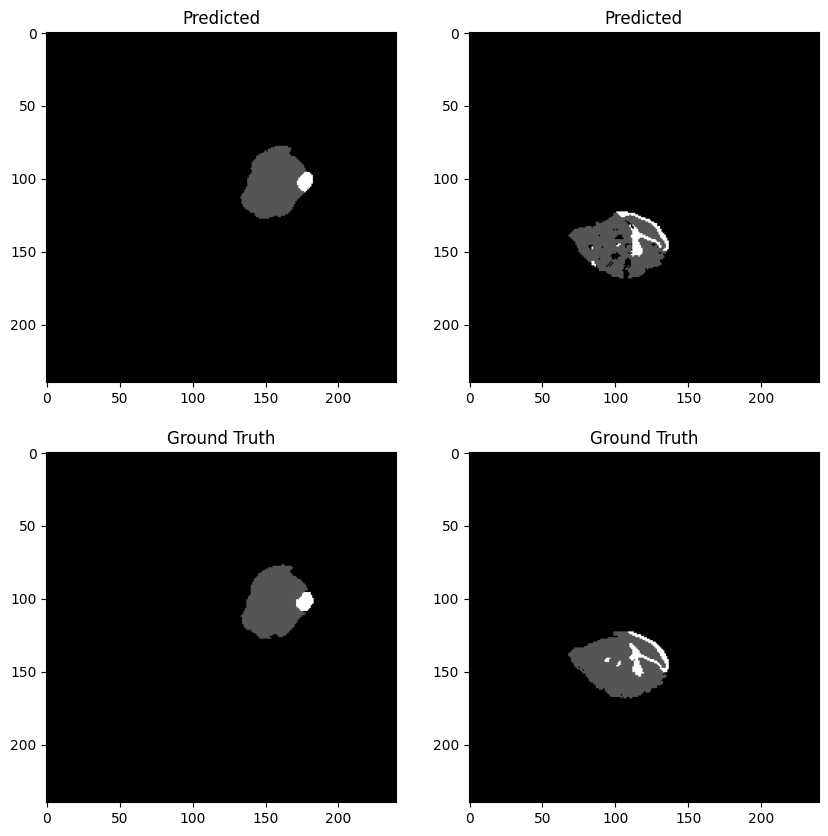

100%|██████████| 136/136 [20:39<00:00,  9.12s/it]



Average Training Loss: 0.02393844848334351

Average Training DSC: [0.99790692 0.65175809 0.75278908 0.53758469]
Average Training ASSD: [ 0.44414202 63.3358731  58.19292577 39.35828264]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


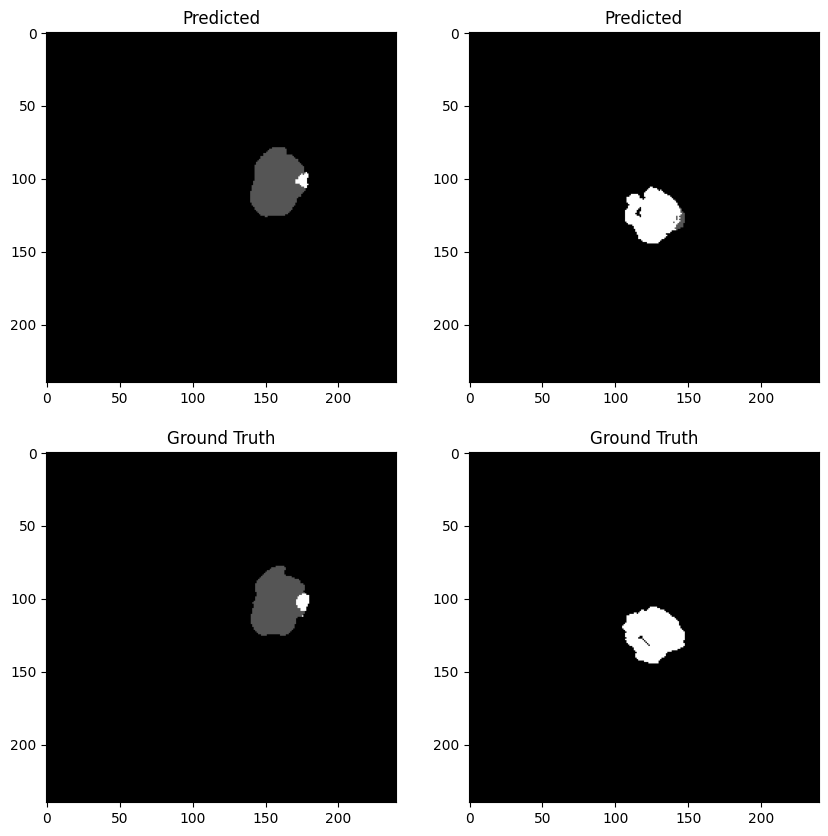

100%|██████████| 34/34 [05:02<00:00,  8.89s/it]


Average Validation Loss: 0.0142398643964792

Average Validation DSC: [0.99869623 0.78656027 0.86452015 0.63882734]
Average Validation ASSD: [ 0.19650951 31.09106917 26.2639838  28.56822383]
Epoch 85/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


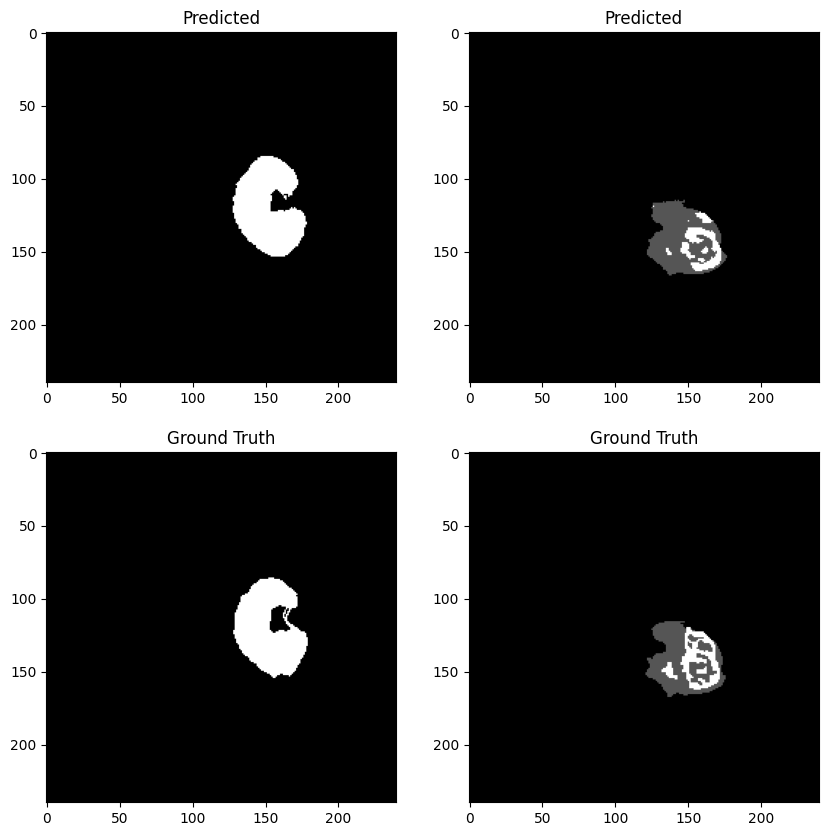

100%|██████████| 136/136 [20:30<00:00,  9.05s/it]



Average Training Loss: 0.010176675842718823

Average Training DSC: [0.99890667 0.83746754 0.88612201 0.6915943 ]
Average Training ASSD: [ 0.16449587 22.09504885 22.31585433 29.6394875 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


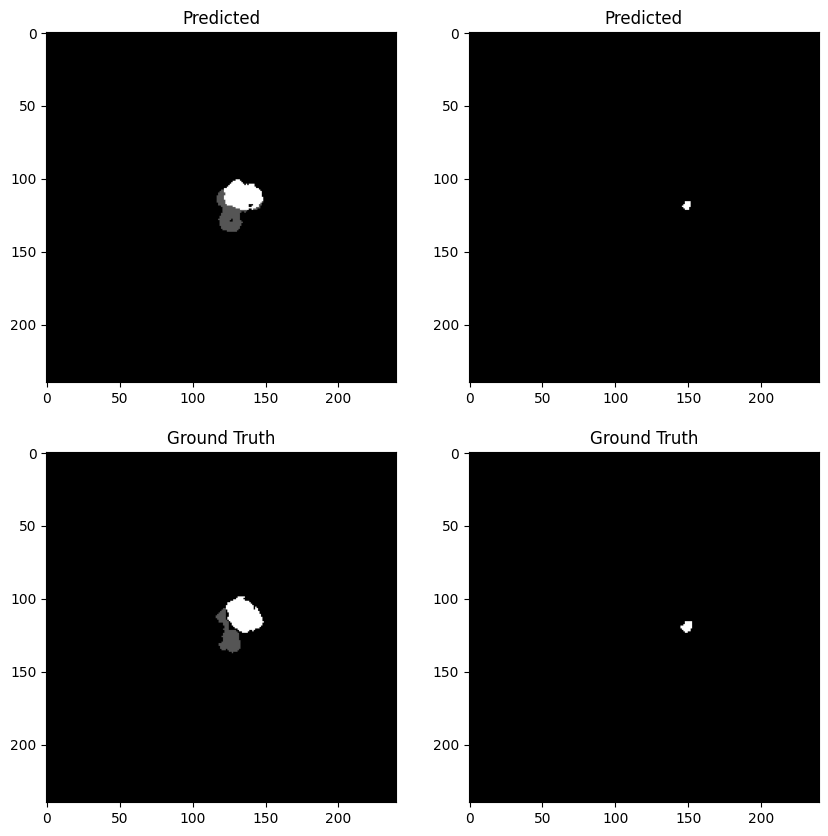

100%|██████████| 34/34 [05:06<00:00,  9.01s/it]


Average Validation Loss: 0.011044657802866661

Average Validation DSC: [0.9990045  0.83745849 0.91134353 0.71869059]
Average Validation ASSD: [ 0.14071935 22.98699887 13.35485568 21.96143443]
Epoch 86/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


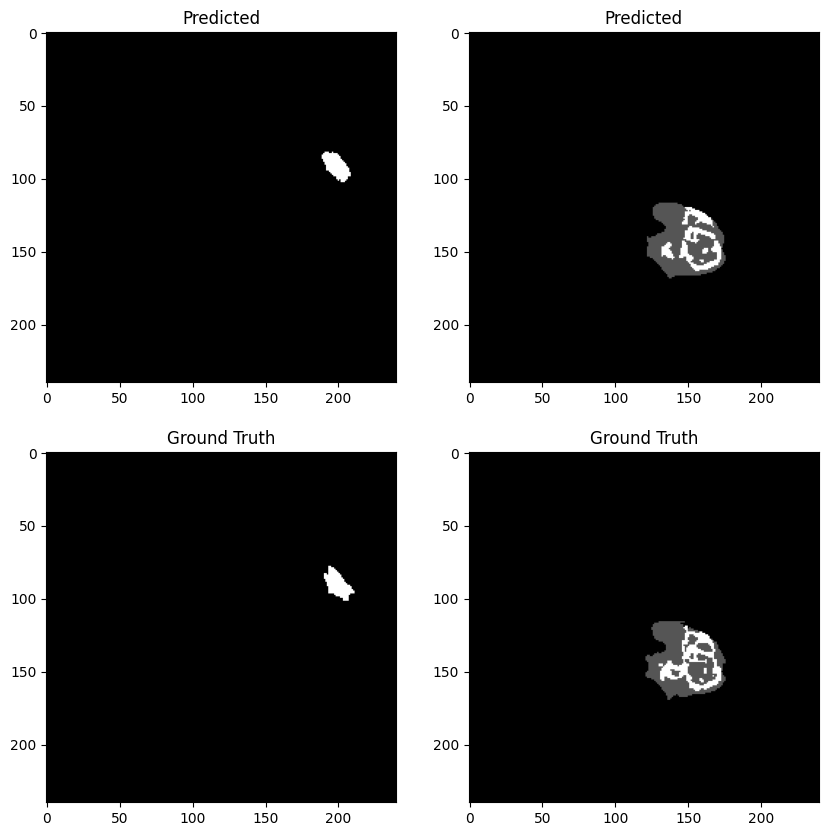

100%|██████████| 136/136 [21:09<00:00,  9.34s/it]



Average Training Loss: 0.008313995385405552

Average Training DSC: [0.99911238 0.87536185 0.91312169 0.73824191]
Average Training ASSD: [ 0.12381489 15.04714408 15.0783214  25.96140008]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


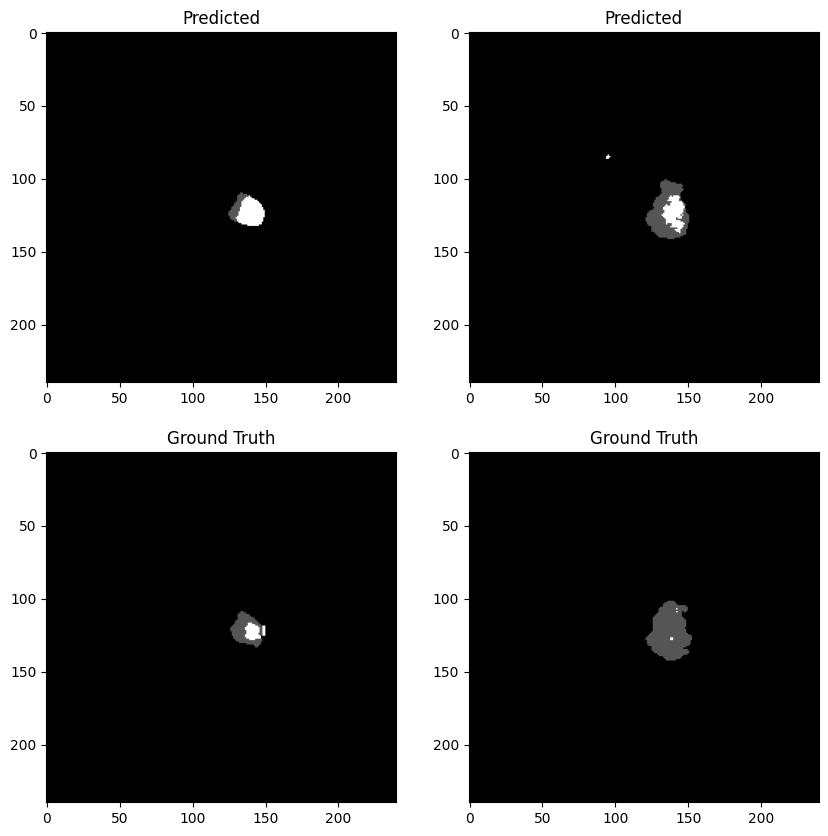

100%|██████████| 34/34 [04:50<00:00,  8.55s/it]


Average Validation Loss: 0.011697764097548583

Average Validation DSC: [0.99905217 0.84345509 0.92133808 0.7398849 ]
Average Validation ASSD: [ 0.13928497 17.74232134 10.69368354 17.10804209]
Epoch 87/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


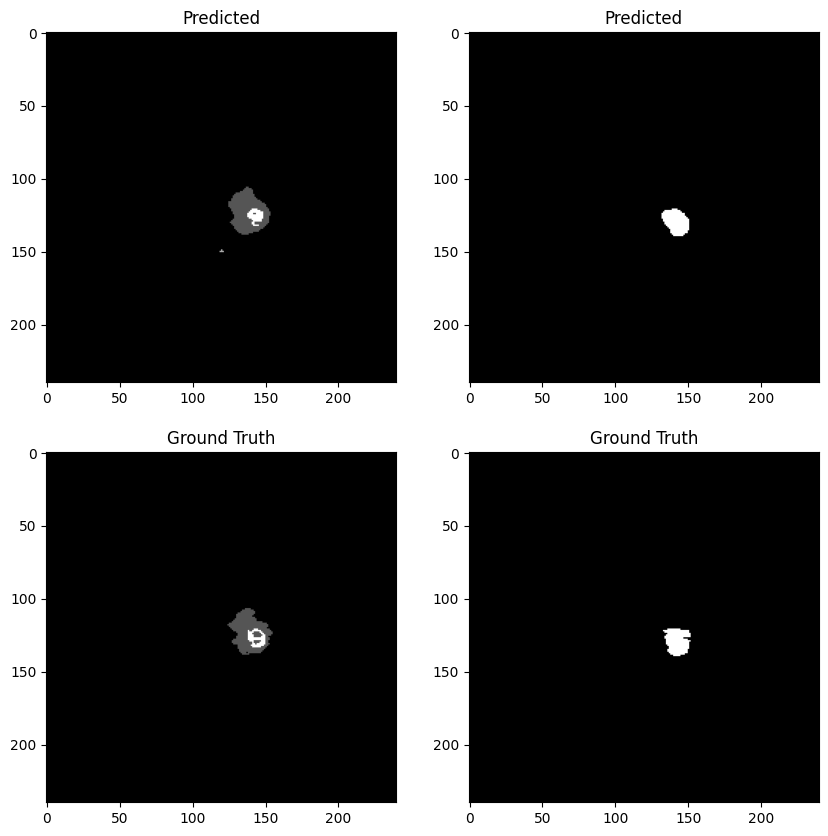

100%|██████████| 136/136 [21:02<00:00,  9.28s/it]



Average Training Loss: 0.007540321450077873

Average Training DSC: [0.99917519 0.88660096 0.92368659 0.75434505]
Average Training ASSD: [ 0.1155174  13.83731283 12.78186948 24.53983929]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


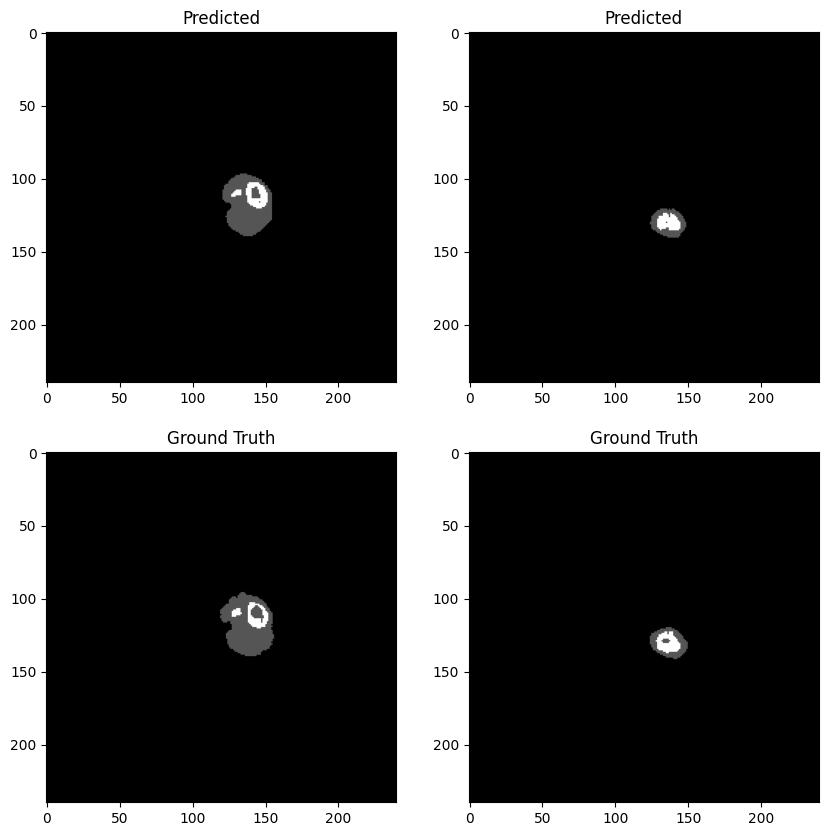

100%|██████████| 34/34 [04:54<00:00,  8.66s/it]


Average Validation Loss: 0.011297618271782994

Average Validation DSC: [0.99907807 0.86226531 0.92783432 0.69938381]
Average Validation ASSD: [ 0.13387402 16.95385397  8.67146736 28.84866051]
Epoch 88/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


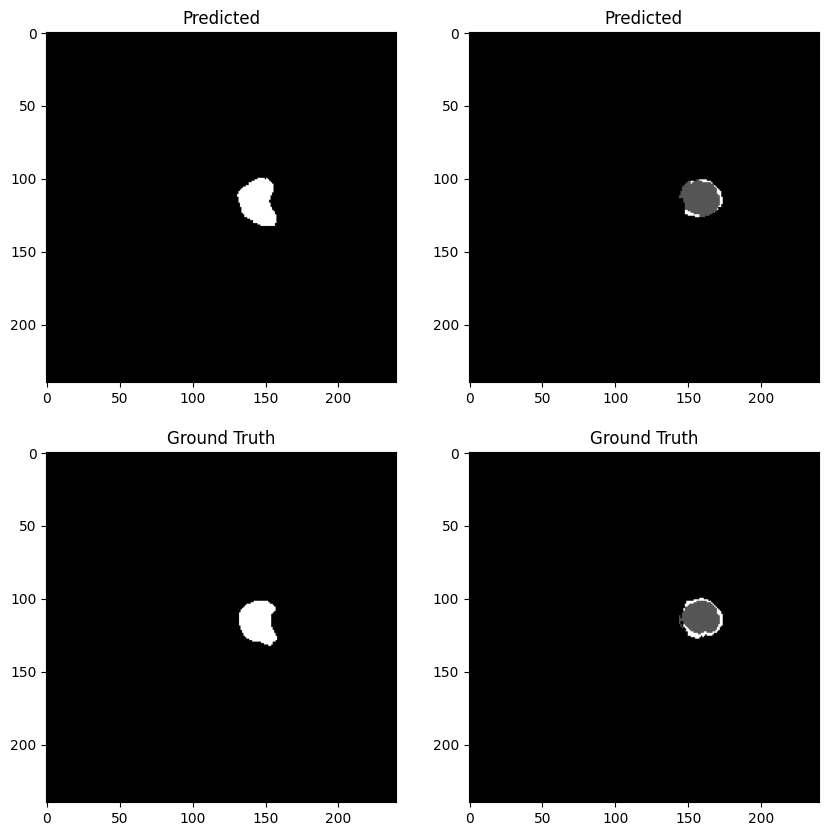

100%|██████████| 136/136 [21:25<00:00,  9.45s/it]



Average Training Loss: 0.00698081318713615

Average Training DSC: [0.99925007 0.89610878 0.93432745 0.76655455]
Average Training ASSD: [ 0.10562225 11.38886535 10.08590217 24.88797782]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


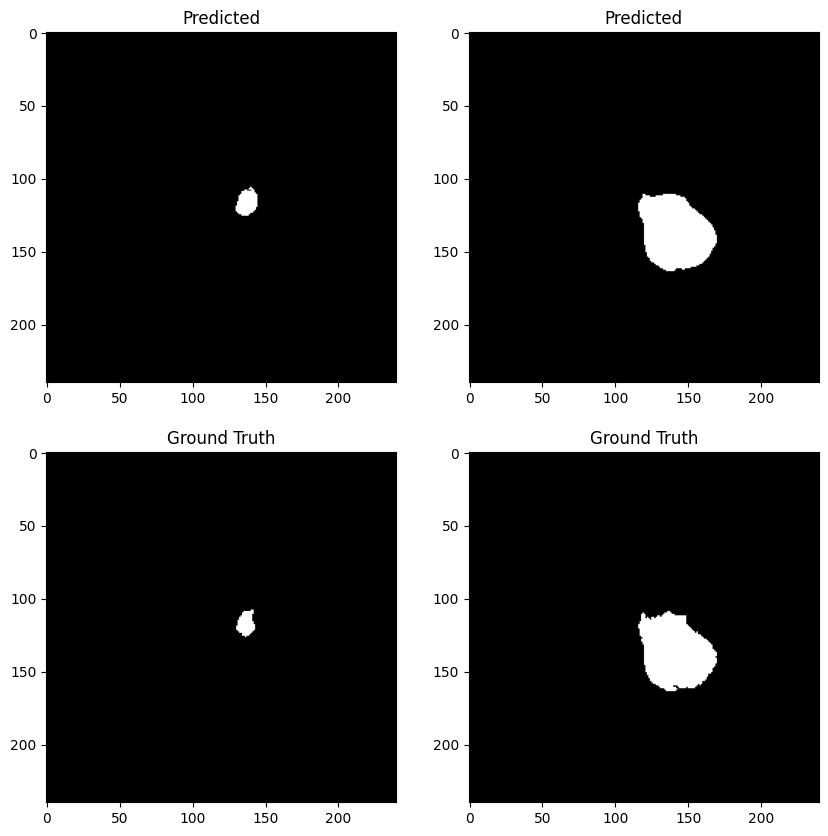

100%|██████████| 34/34 [05:06<00:00,  9.03s/it]


Average Validation Loss: 0.011212414966019638

Average Validation DSC: [0.9991174  0.84601031 0.9277396  0.74431497]
Average Validation ASSD: [ 0.13220448 22.38997112  9.30382845 22.32108682]
Epoch 89/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


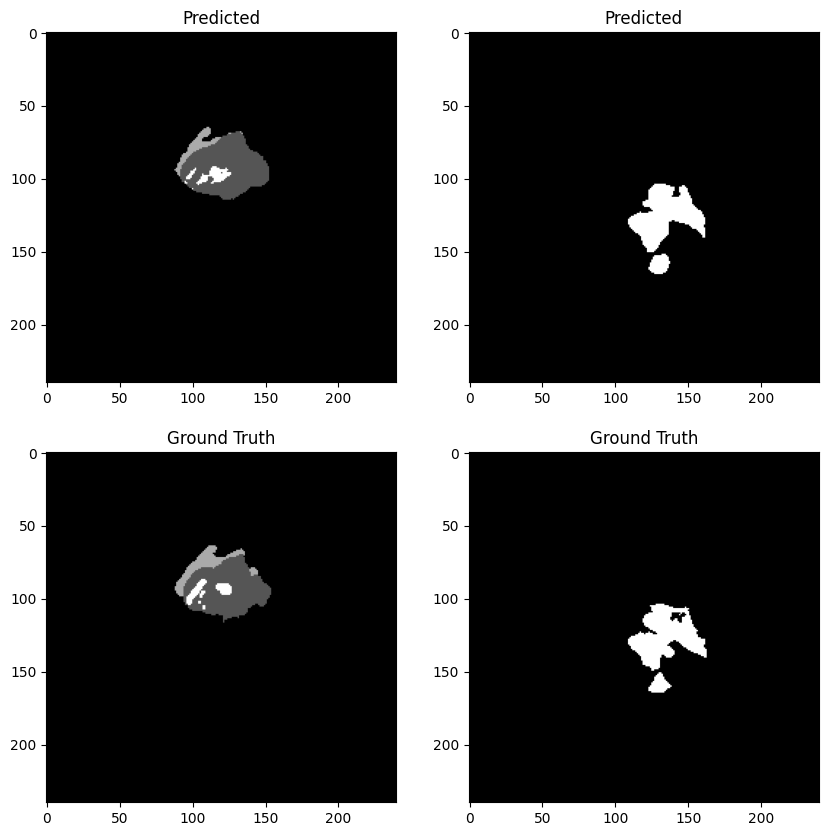

100%|██████████| 136/136 [20:27<00:00,  9.02s/it]



Average Training Loss: 0.0065639825359753825

Average Training DSC: [0.99929289 0.90432618 0.93503305 0.78128779]
Average Training ASSD: [ 0.09644011 10.43401987 10.15334598 21.59258876]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


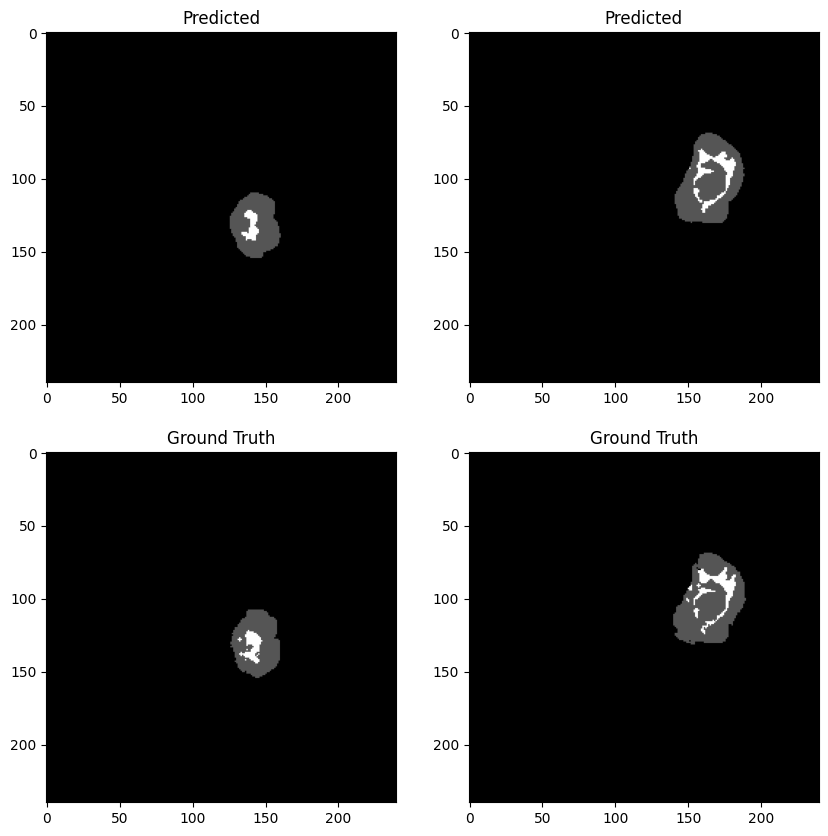

100%|██████████| 34/34 [04:54<00:00,  8.68s/it]


Average Validation Loss: 0.010292458087753724

Average Validation DSC: [0.99916119 0.86337986 0.93501351 0.75123477]
Average Validation ASSD: [ 0.12149375 21.38345094  8.26997849 23.01871464]
Epoch 90/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


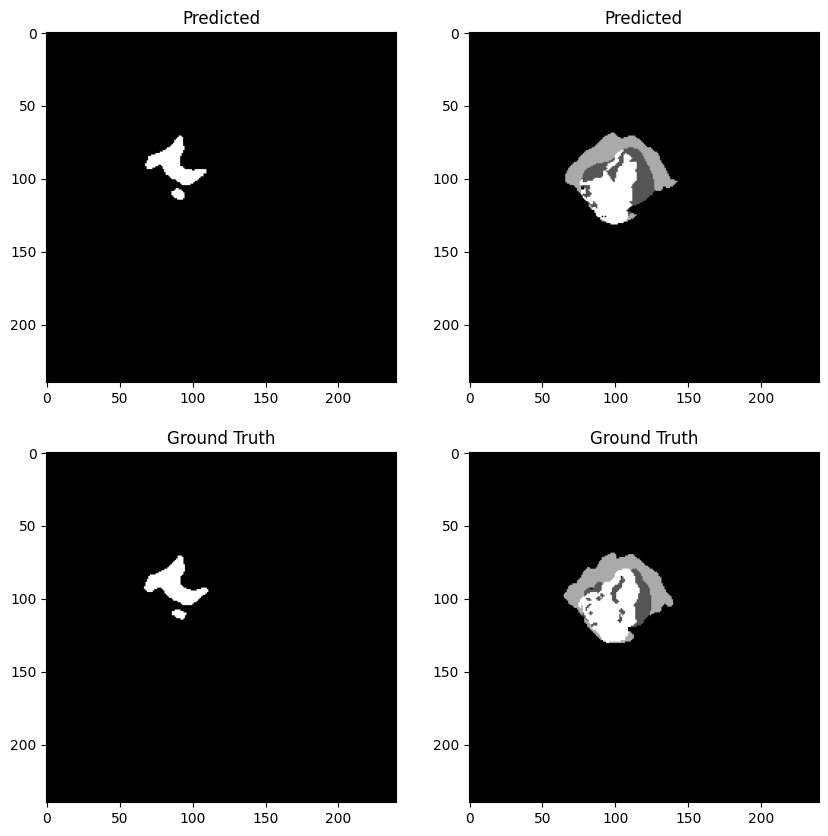

100%|██████████| 136/136 [20:42<00:00,  9.14s/it]



Average Training Loss: 0.006156367390170036

Average Training DSC: [0.99931983 0.90655779 0.94047029 0.78795363]
Average Training ASSD: [ 0.09400444 10.49496388  8.65164994 22.9212873 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


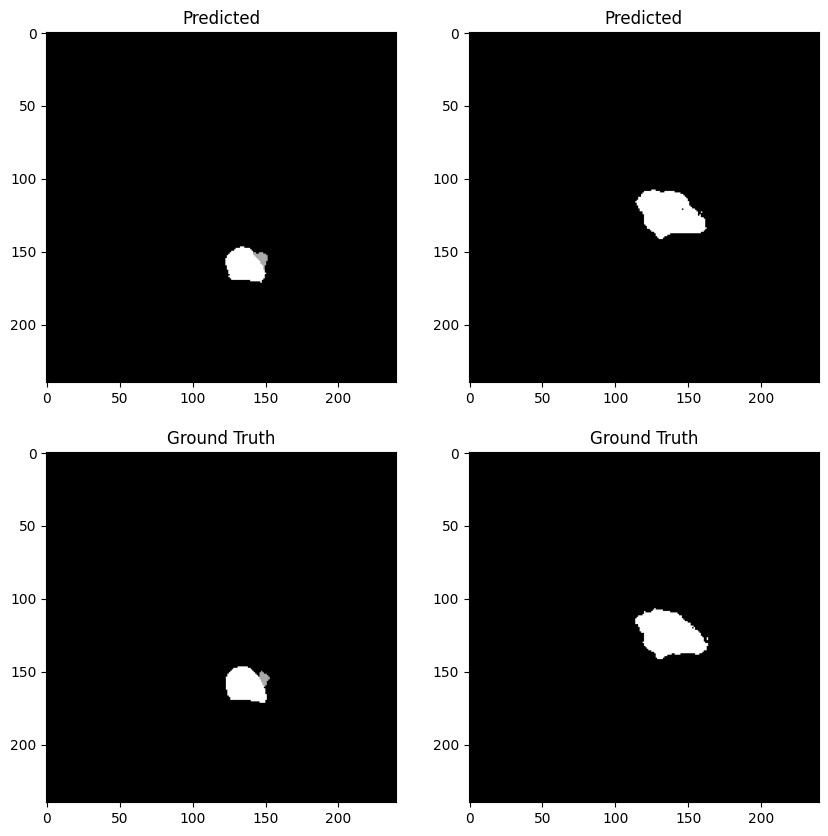

100%|██████████| 34/34 [04:39<00:00,  8.24s/it]


Average Validation Loss: 0.01055509627194089

Average Validation DSC: [0.99919425 0.87186064 0.9367424  0.756085  ]
Average Validation ASSD: [ 0.12154904 18.88096016  7.92991075 22.98105998]
Epoch 91/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


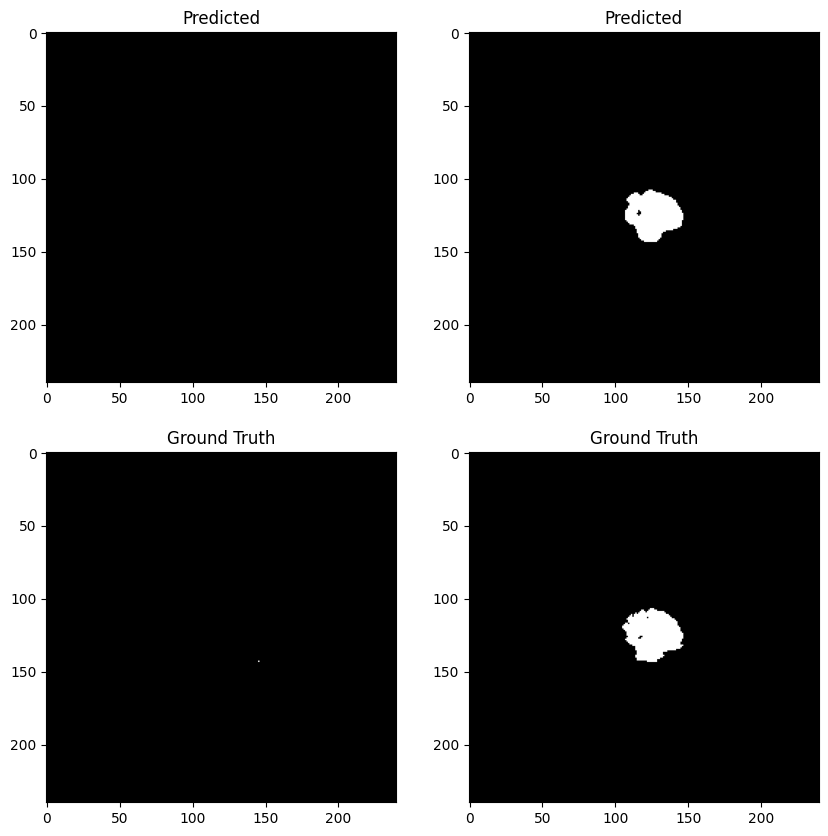

100%|██████████| 136/136 [20:47<00:00,  9.17s/it]



Average Training Loss: 0.0059957605964668535

Average Training DSC: [0.99934368 0.91194082 0.94557676 0.7945491 ]
Average Training ASSD: [ 0.08900045  8.82490639  7.13180541 21.46379494]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


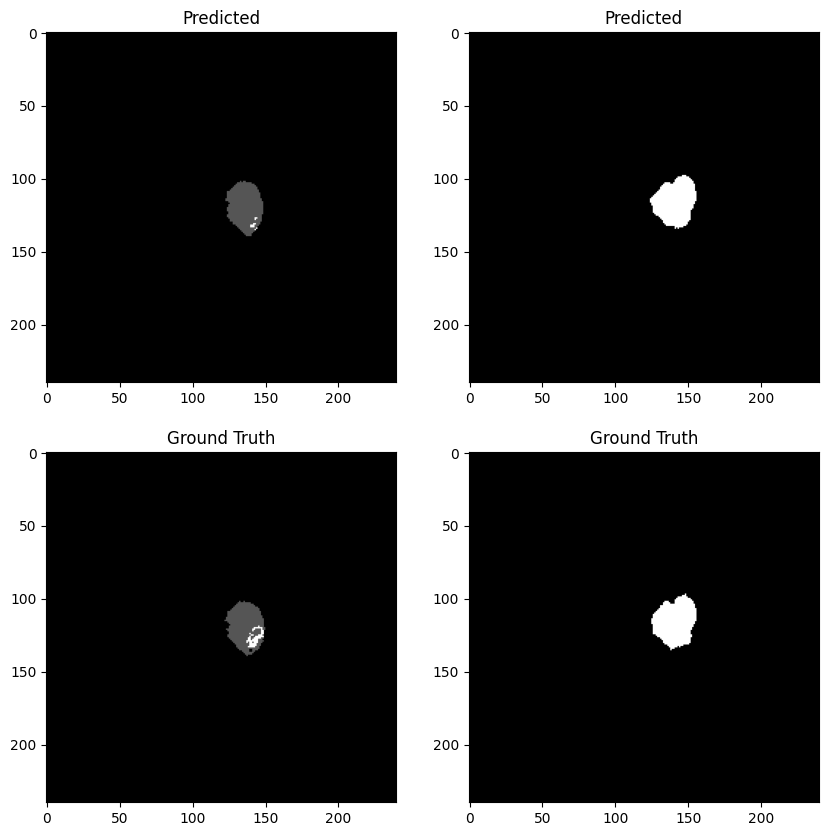

100%|██████████| 34/34 [04:57<00:00,  8.74s/it]


Average Validation Loss: 0.009767865748418605

Average Validation DSC: [0.99920793 0.87764457 0.93878526 0.75637196]
Average Validation ASSD: [ 0.10982333 16.22242325  7.06347695 21.30230193]
Epoch 92/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


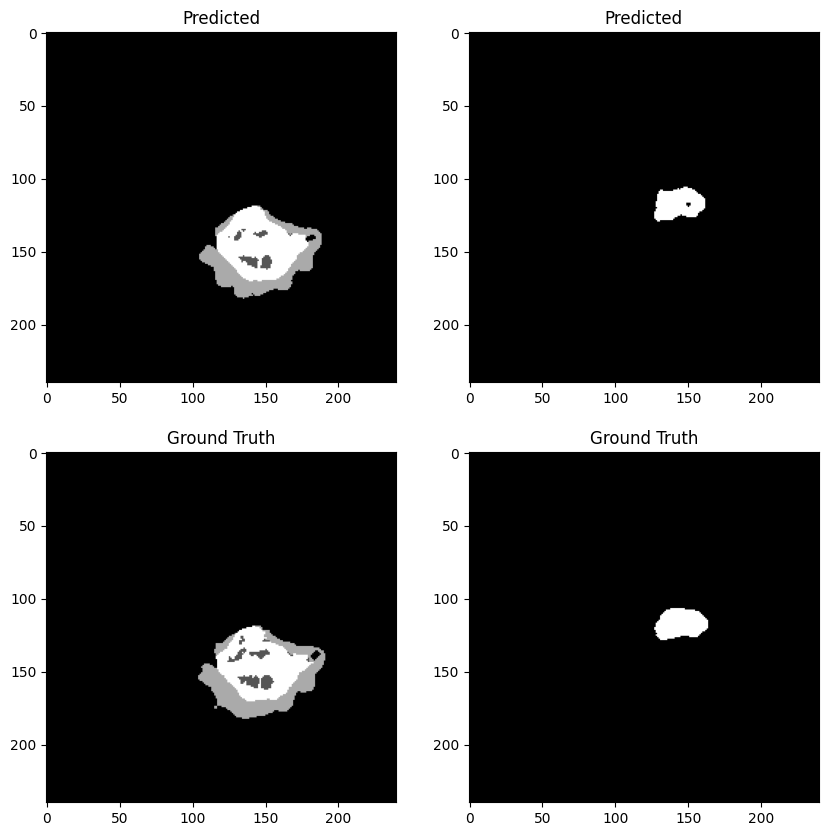

100%|██████████| 136/136 [20:17<00:00,  8.95s/it]



Average Training Loss: 0.005829078008365982

Average Training DSC: [0.9993504  0.9187375  0.94675456 0.79579426]
Average Training ASSD: [ 0.09011649  7.39335641  6.96136286 21.64387546]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


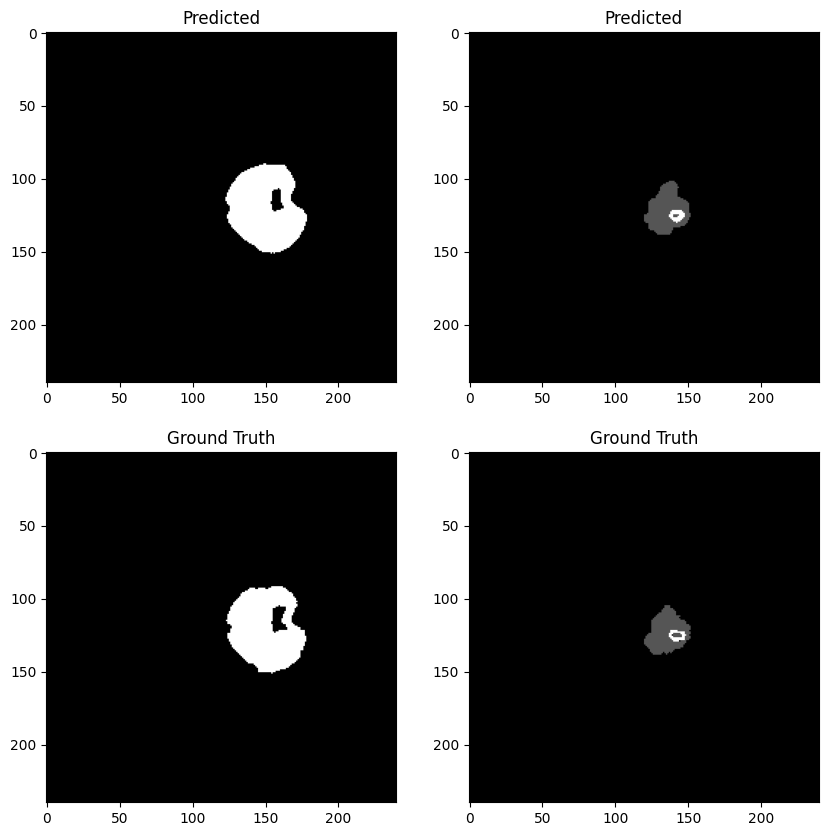

100%|██████████| 34/34 [04:55<00:00,  8.69s/it]


Average Validation Loss: 0.010450048783027074

Average Validation DSC: [0.99921098 0.88331679 0.9419693  0.76919171]
Average Validation ASSD: [ 0.11072499 17.3279043   6.57126008 18.02252534]
Epoch 93/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


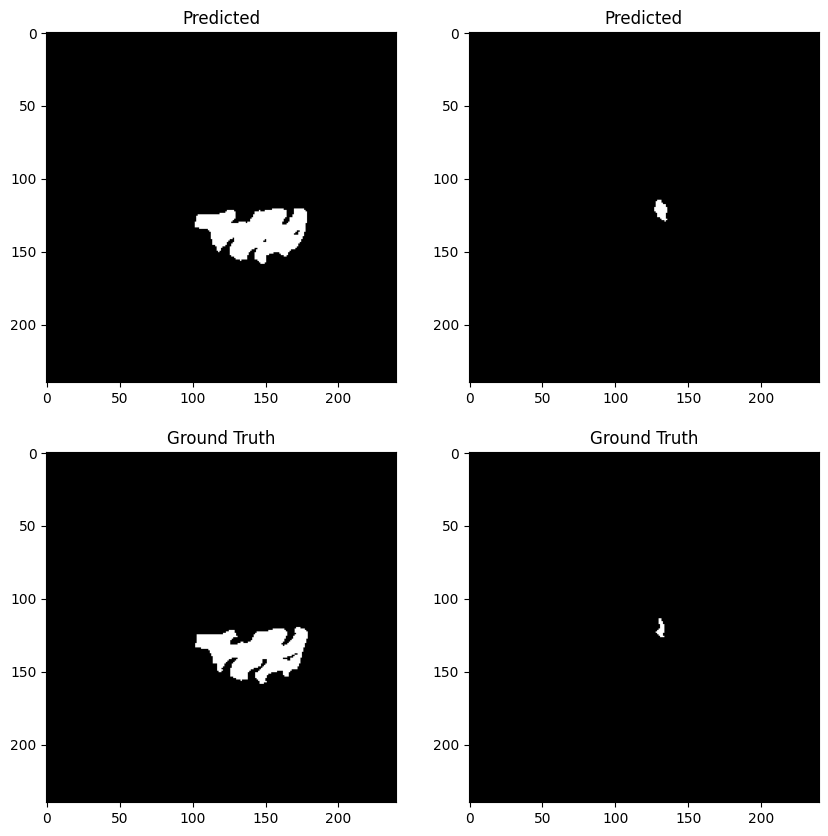

100%|██████████| 136/136 [20:38<00:00,  9.11s/it]



Average Training Loss: 0.005611342377960682

Average Training DSC: [0.99938278 0.91435656 0.94402197 0.80357385]
Average Training ASSD: [ 0.08650221  9.94752655  8.03980856 20.1971783 ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


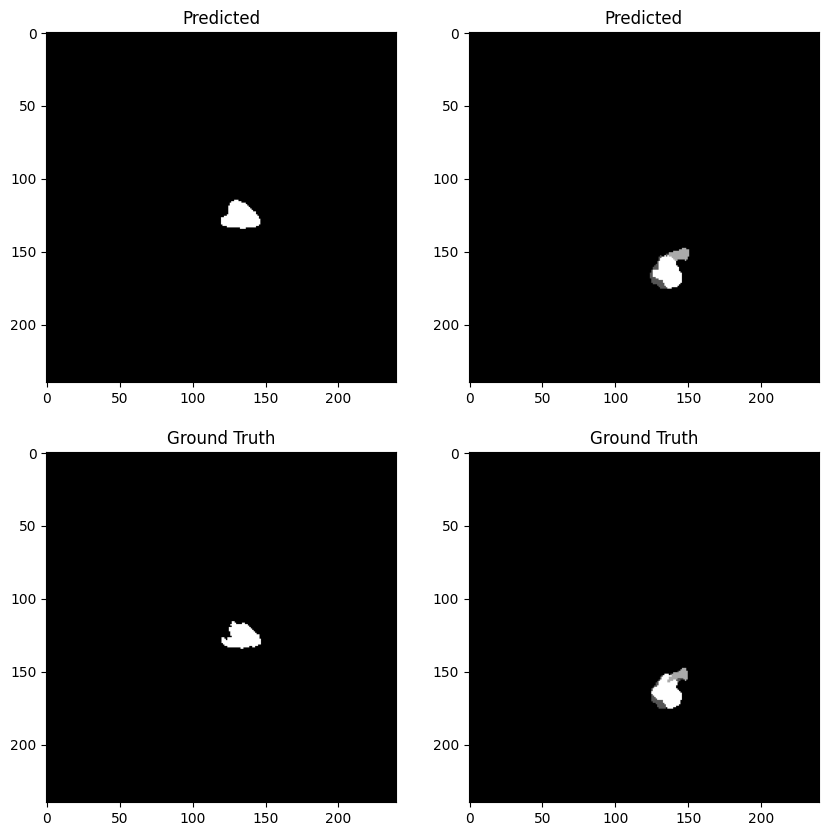

100%|██████████| 34/34 [04:54<00:00,  8.67s/it]


Average Validation Loss: 0.010281361584715983

Average Validation DSC: [0.99921952 0.87757777 0.94233078 0.76849026]
Average Validation ASSD: [ 0.10613076 17.61313467  7.30579705 20.73883217]
Epoch 94/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


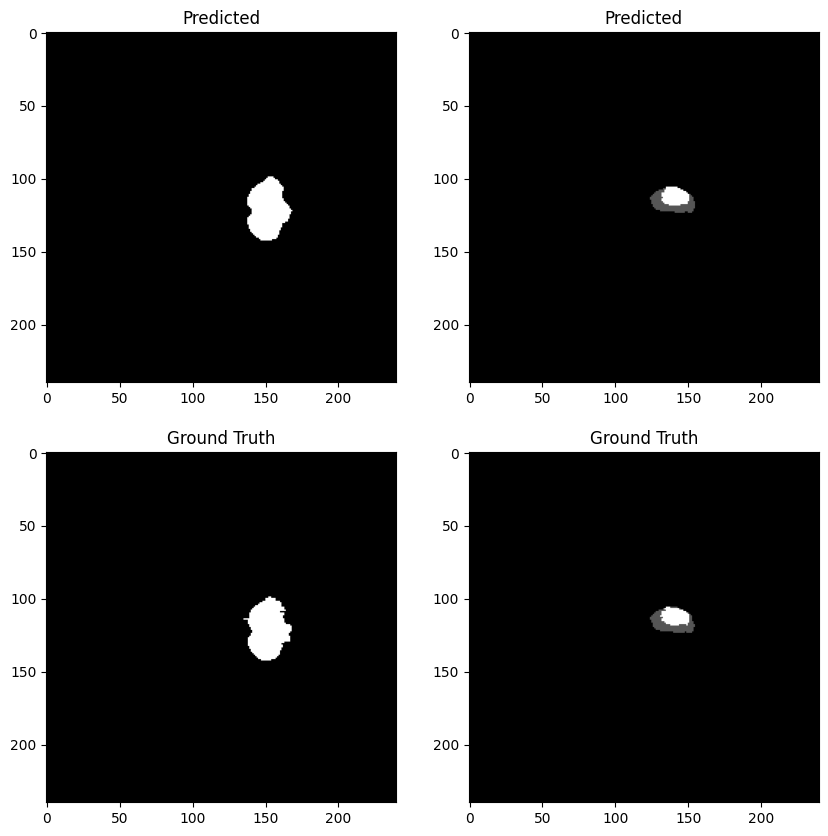

100%|██████████| 136/136 [20:54<00:00,  9.23s/it]



Average Training Loss: 0.005634406120995717

Average Training DSC: [0.99938994 0.91355763 0.9447687  0.80078449]
Average Training ASSD: [ 0.08362484  9.30758394  8.02526013 22.17077566]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


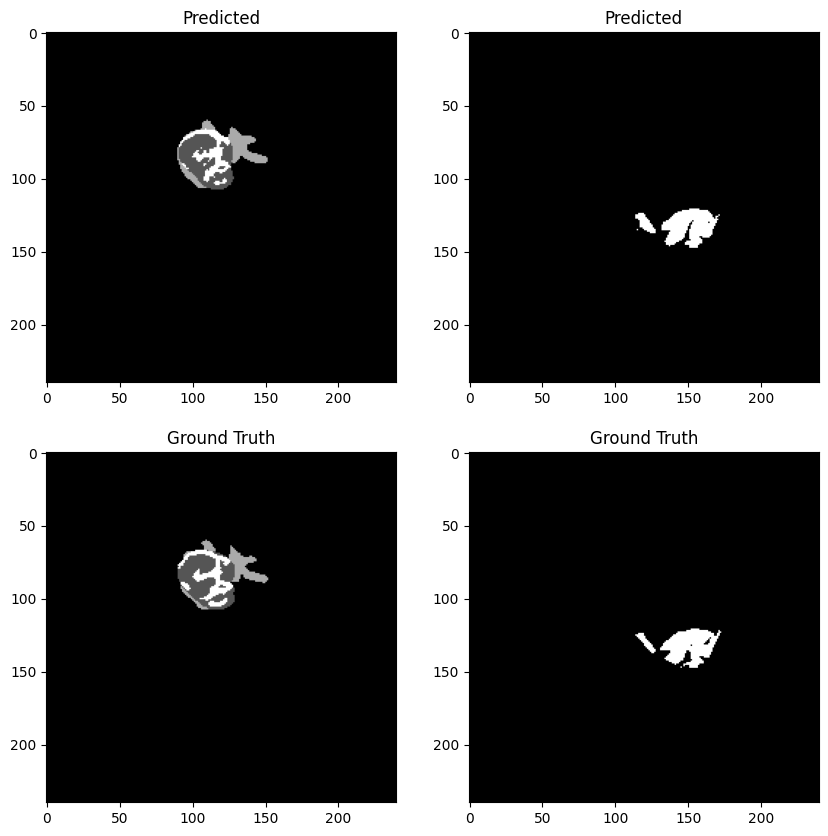

100%|██████████| 34/34 [05:12<00:00,  9.20s/it]


Average Validation Loss: 0.009782321710029946

Average Validation DSC: [0.99920804 0.87521146 0.9401526  0.77457556]
Average Validation ASSD: [ 0.11362045 18.53955133  7.57828783 17.43487052]
Epoch 95/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


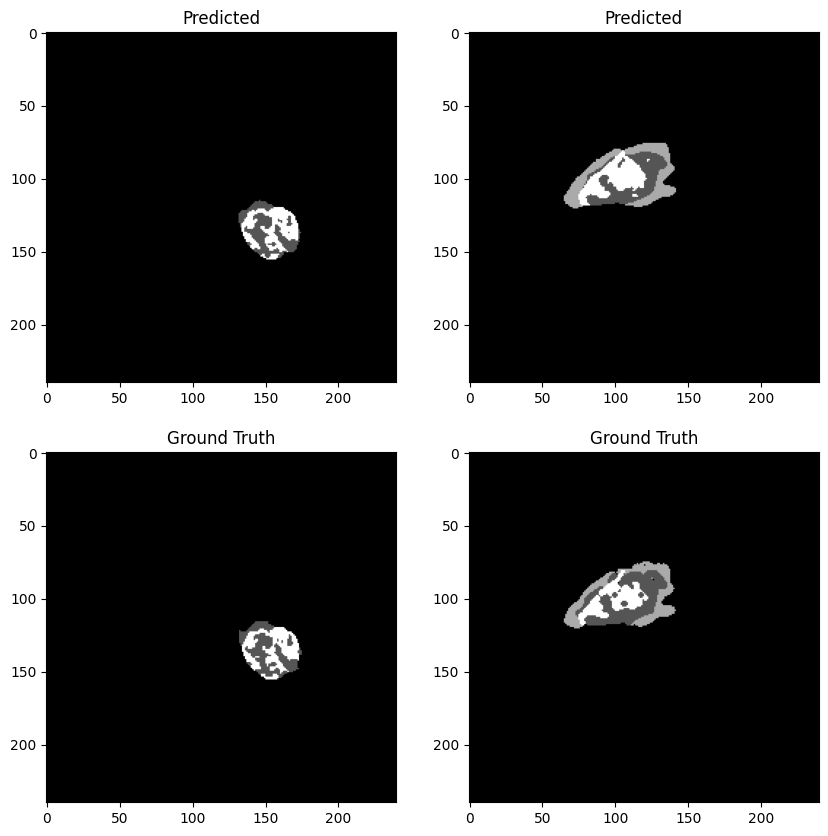

100%|██████████| 136/136 [20:15<00:00,  8.94s/it]



Average Training Loss: 0.005405809872386539

Average Training DSC: [0.99940916 0.92222212 0.94813225 0.8096102 ]
Average Training ASSD: [ 0.07867898  7.2847856   7.20277841 20.62360994]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


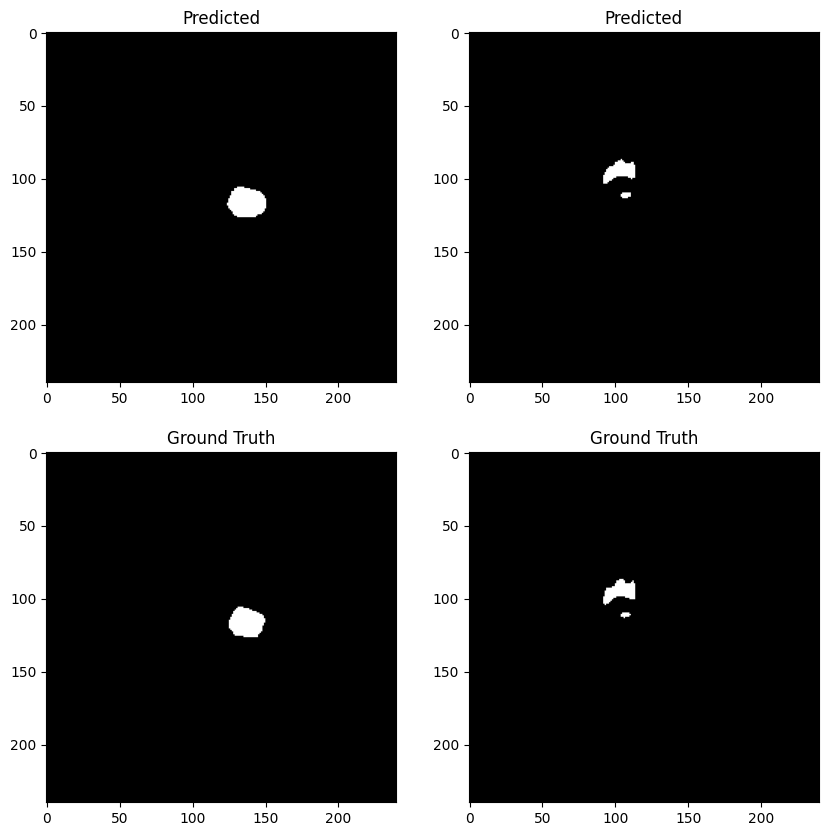

100%|██████████| 34/34 [04:59<00:00,  8.81s/it]


Average Validation Loss: 0.010753345634678708

Average Validation DSC: [0.99924467 0.87085539 0.94417969 0.74103708]
Average Validation ASSD: [ 0.10252184 18.96725151  6.6357815  22.00342523]
Epoch 96/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


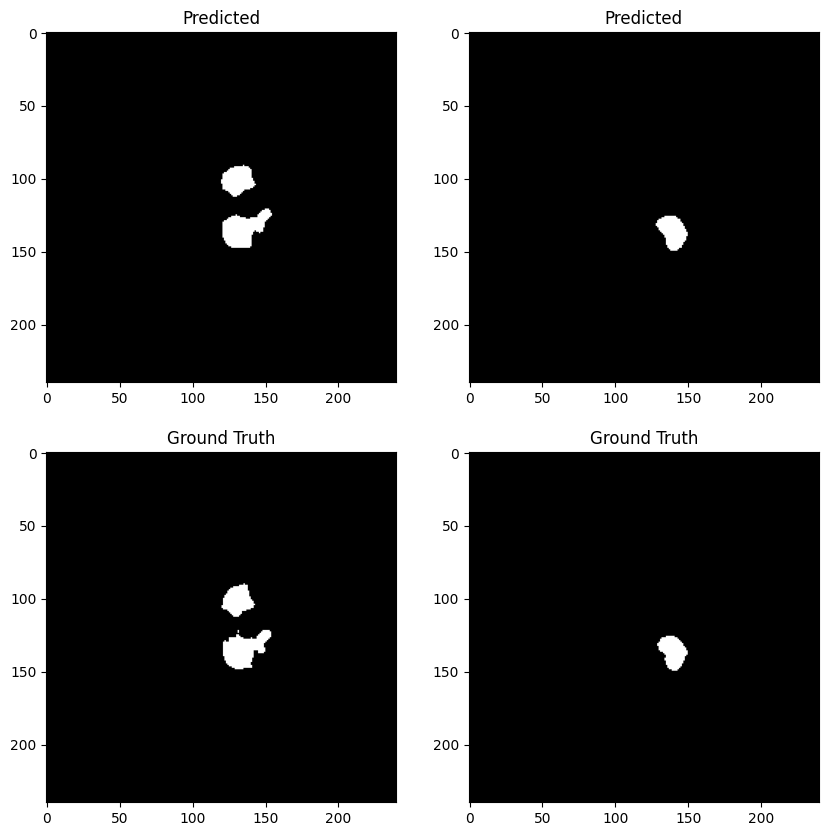

100%|██████████| 136/136 [20:49<00:00,  9.19s/it]



Average Training Loss: 0.005302296175881673

Average Training DSC: [0.99942566 0.91721701 0.94674095 0.81069843]
Average Training ASSD: [ 0.0773631   9.68515512  7.2911602  21.48035362]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


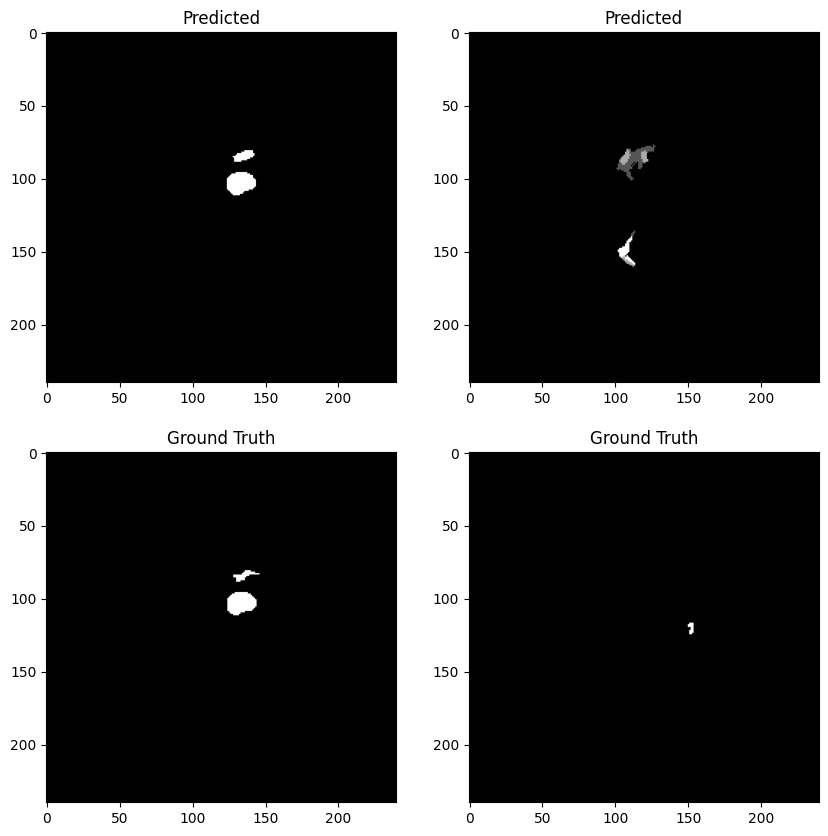

100%|██████████| 34/34 [05:04<00:00,  8.97s/it]


Average Validation Loss: 0.009560500257922447

Average Validation DSC: [0.9992317  0.88803667 0.94525924 0.76431032]
Average Validation ASSD: [ 0.10924716 14.95146003  6.23403739 22.00068991]
Epoch 97/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


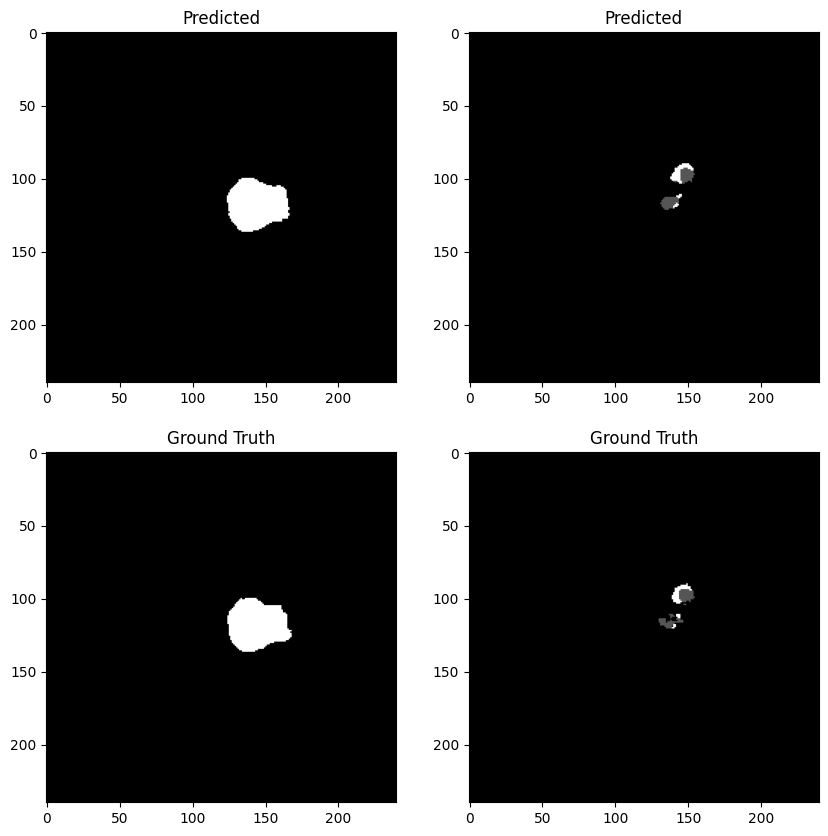

100%|██████████| 136/136 [20:26<00:00,  9.02s/it]



Average Training Loss: 0.0055346927102244295

Average Training DSC: [0.99940152 0.91656965 0.94536808 0.80183209]
Average Training ASSD: [ 0.08256925  7.97481396  7.87957941 20.53476958]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


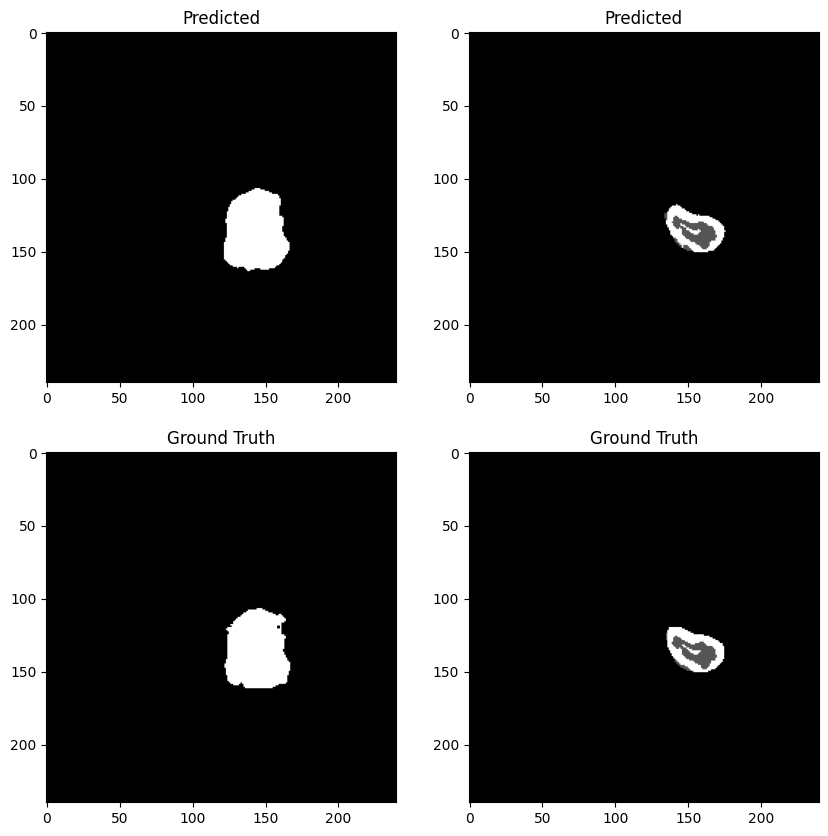

100%|██████████| 34/34 [05:14<00:00,  9.26s/it]


Average Validation Loss: 0.00931753360611551

Average Validation DSC: [0.99923039 0.87771241 0.94516025 0.76812403]
Average Validation ASSD: [ 0.1113244  17.54823215  6.63734197 22.30463206]
Epoch 98/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


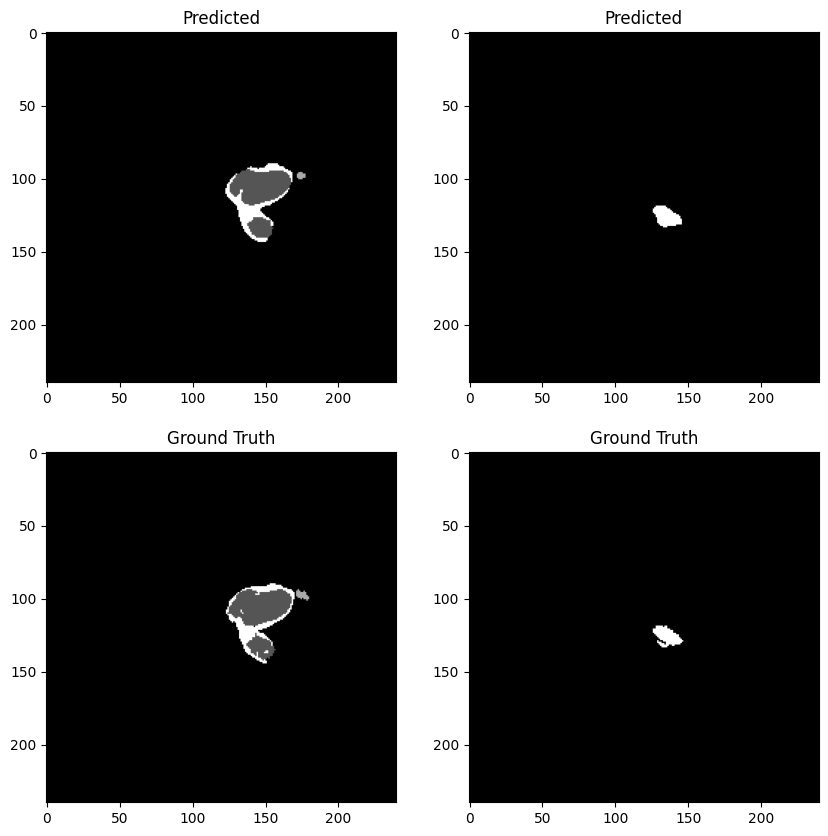

100%|██████████| 136/136 [21:04<00:00,  9.30s/it]



Average Training Loss: 0.0053421309207538695

Average Training DSC: [0.99942328 0.91724114 0.94857162 0.81408929]
Average Training ASSD: [ 0.07633419  9.1862405   7.27853677 18.83250595]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


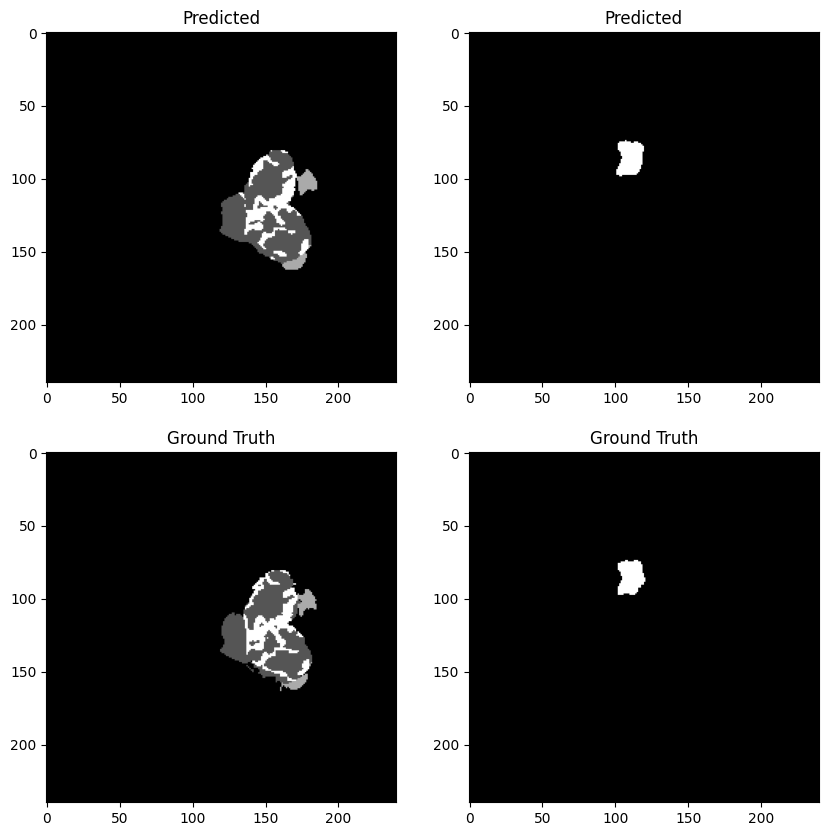

100%|██████████| 34/34 [05:35<00:00,  9.86s/it]


Average Validation Loss: 0.009567801525597186

Average Validation DSC: [0.99921292 0.88557467 0.94418329 0.76354834]
Average Validation ASSD: [ 0.11544511 17.14988819  6.2483698  23.75337867]
Epoch 99/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


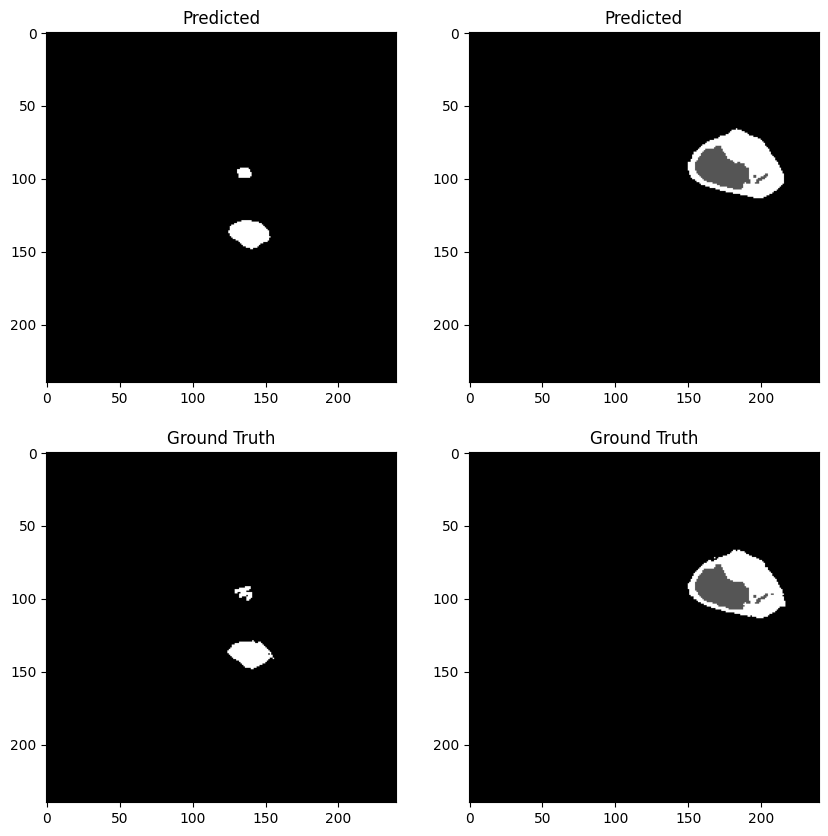

100%|██████████| 136/136 [21:33<00:00,  9.51s/it]



Average Training Loss: 0.005322908652220469

Average Training DSC: [0.99941524 0.92573289 0.94812662 0.81209968]
Average Training ASSD: [ 0.07830851  6.20472867  7.11861044 20.62164006]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


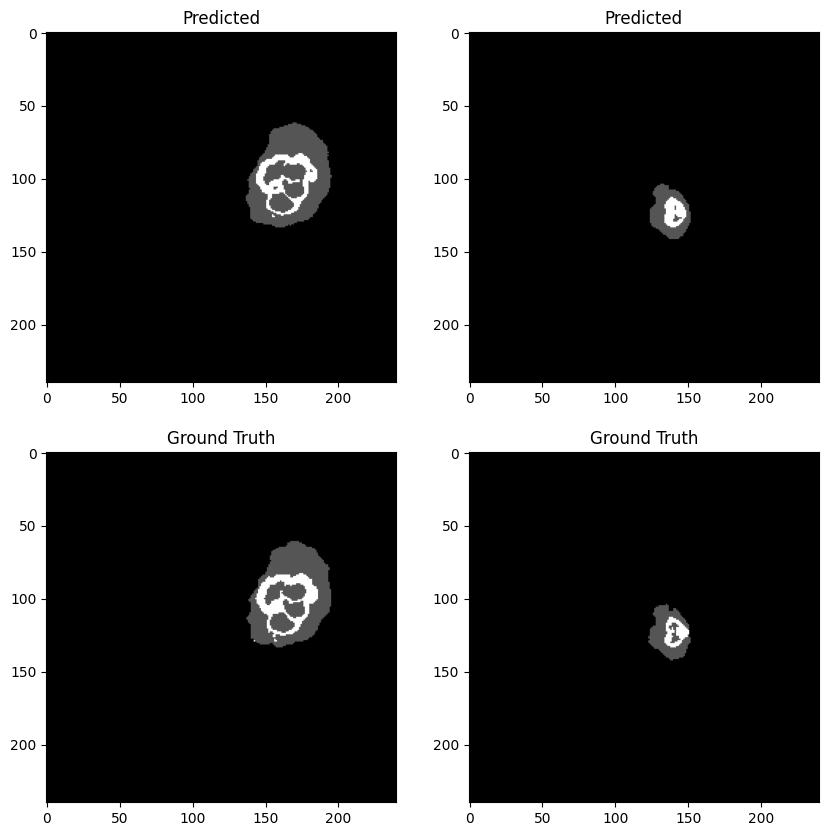

100%|██████████| 34/34 [05:13<00:00,  9.23s/it]


Average Validation Loss: 0.009252905667595127

Average Validation DSC: [0.99925968 0.87817647 0.94653051 0.76346014]
Average Validation ASSD: [ 0.10283327 18.83364518  6.29513531 19.35784878]
Epoch 100/100
-------------------------


  0%|          | 0/136 [00:00<?, ?it/s]

Training Prediction Visualization:


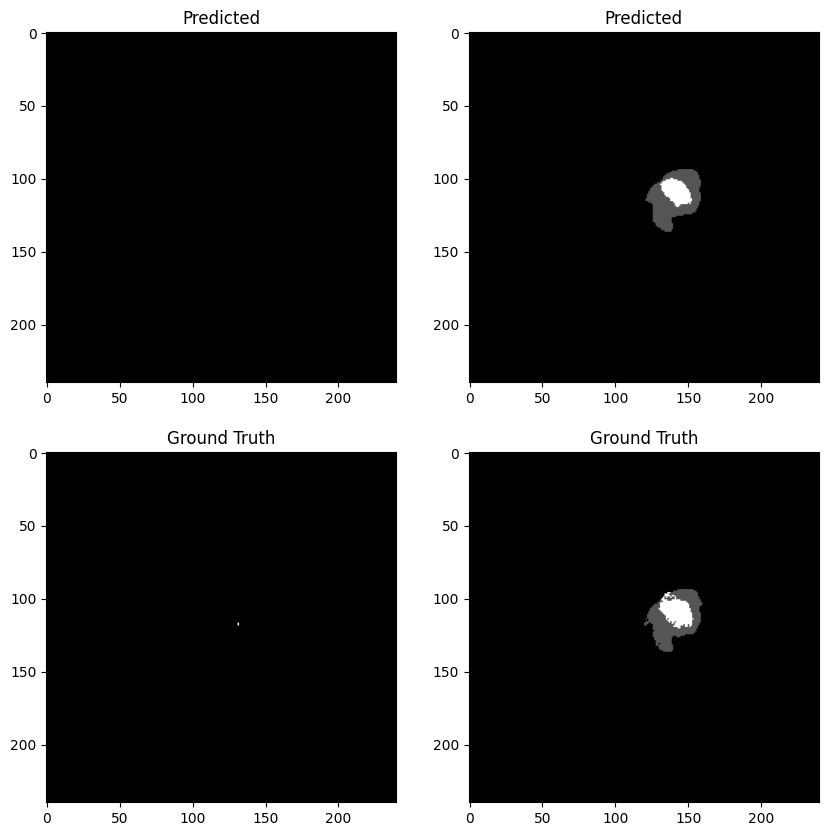

100%|██████████| 136/136 [20:10<00:00,  8.90s/it]



Average Training Loss: 0.00503342181978309

Average Training DSC: [0.9994479  0.92725749 0.95033804 0.81766296]
Average Training ASSD: [ 0.07311958  6.43261735  6.85905743 19.828065  ]


  0%|          | 0/34 [00:00<?, ?it/s]

Validation Prediction Visualization:


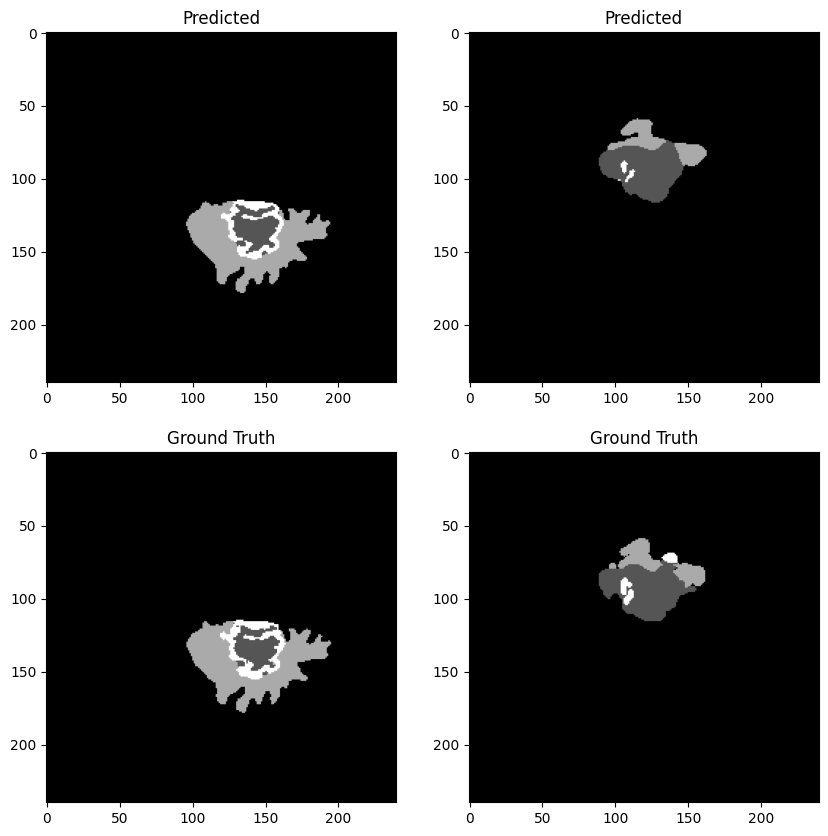

100%|██████████| 34/34 [04:59<00:00,  8.82s/it]


Average Validation Loss: 0.008891837370088872

Average Validation DSC: [0.99927517 0.88938599 0.94651694 0.77189734]
Average Validation ASSD: [ 0.1074815  14.42953087  6.54663083 19.26169348]


In [12]:
model = train_model(num_epochs = 100)